In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [2]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [3]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [5]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [9]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [10]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 2286

Testing
Number of Labels: 1311


In [11]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [13]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [15]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.3153 - loss: 1.3034 - val_accuracy: 0.5484 - val_loss: 1.0698 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6684 - loss: 0.8310 - val_accuracy: 0.6301 - val_loss: 0.8748 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7568 - loss: 0.6305 - val_accuracy: 0.6636 - val_loss: 0.7846 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7773 - loss: 0.5433 - val_accuracy: 0.7048 - val_loss: 0.7113 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8179 - loss: 0.4641 - val_accuracy: 0.7849 - val_loss: 0.5227 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.8655 - loss: 0.3542 - val_accuracy: 0.7674 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8851 - loss: 0.303

In [16]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9493 - loss: 0.3798
Test accuracy: 94.3555%


In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       300
           1       0.89      0.90      0.89       306
           2       0.95      0.99      0.97       405
           3       0.96      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



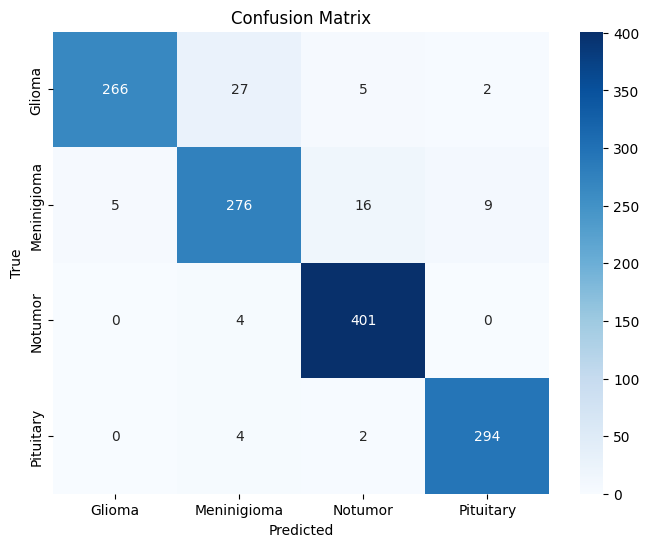

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
model.save('SSL_40-60.h5')

In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_40-60.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/3426 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


  0%|          | 1/3426 [00:00<39:40,  1.44it/s]

Tr-pi_0940.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0940.jpg to BT100/Training/pituitary/20250330_235028_Tr-pi_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1043.jpg to BT100/Training/meningioma/20250330_235028_Tr-me_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 3/3426 [00:00<13:00,  4.38it/s]

Tr-gl_1072.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1072.jpg to BT100/Training/glioma/20250330_235028_Tr-gl_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1048.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1048.jpg to BT100/Training/meningioma/20250330_235028_Tr-me_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 5/3426 [00:00<08:14,  6.92it/s]

Tr-gl_0780.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0780.jpg to BT100/Training/glioma/20250330_235028_Tr-gl_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0283.jpg to BT100/Training/notumor/20250330_235028_Tr-no_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 7/3426 [00:01<06:50,  8.32it/s]

Tr-no_0585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0585.jpg to BT100/Training/notumor/20250330_235028_Tr-no_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_0917.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0917.jpg to BT100/Training/pituitary/20250330_235028_Tr-pi_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 9/3426 [00:01<05:40, 10.03it/s]

Tr-no_0110.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0110.jpg to BT100/Training/notumor/20250330_235029_Tr-no_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1169.jpg -> Class: meningioma, Confidence: 0.69
Moved low-confidence image Tr-me_1169.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 11/3426 [00:01<04:59, 11.40it/s]

Tr-gl_0648.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0648.jpg to BT100/Training/glioma/20250330_235029_Tr-gl_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0297.jpg -> Class: pituitary, Confidence: 0.72
Moved low-confidence image Tr-pi_0297.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 13/3426 [00:01<04:36, 12.33it/s]

Tr-pi_0448.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0448.jpg to BT100/Training/pituitary/20250330_235029_Tr-pi_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0216.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0216.jpg to BT100/Training/notumor/20250330_235029_Tr-me_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 15/3426 [00:01<04:25, 12.84it/s]

Tr-me_1069.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1069.jpg to BT100/Training/meningioma/20250330_235029_Tr-me_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1184.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1184.jpg to BT100/Training/meningioma/20250330_235029_Tr-me_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 17/3426 [00:01<04:16, 13.28it/s]

Tr-gl_0191.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0191.jpg to BT100/Training/glioma/20250330_235029_Tr-gl_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1357.jpg to BT100/Training/pituitary/20250330_235029_Tr-pi_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0570.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0570.jpg to BT100/Training/pituitary/20250330_235029_Tr-pi_0570.jpg


  1%|          | 19/3426 [00:01<04:07, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0021.jpg to BT100/Training/notumor/20250330_235029_Tr-no_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 21/3426 [00:02<04:33, 12.46it/s]

Tr-no_1338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1338.jpg to BT100/Training/notumor/20250330_235029_Tr-no_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1038.jpg to BT100/Training/notumor/20250330_235030_Tr-no_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0119.jpg to BT100/Training/glioma/20250330_235030_Tr-gl_0119.jpg


  1%|          | 23/3426 [00:02<04:23, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0374.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0374.jpg to BT100/Training/glioma/20250330_235030_Tr-gl_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 25/3426 [00:02<04:11, 13.53it/s]

Tr-pi_1389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1389.jpg to BT100/Training/pituitary/20250330_235030_Tr-pi_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0370.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0370.jpg to BT100/Training/meningioma/20250330_235030_Tr-me_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0096.jpg to BT100/Training/notumor/20250330_235030_Tr-no_0096.jpg


  1%|          | 27/3426 [00:02<04:05, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0926.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0926.jpg to BT100/Training/notumor/20250330_235030_Tr-no_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 29/3426 [00:02<04:04, 13.91it/s]

Tr-gl_0345.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0345.jpg to BT100/Training/glioma/20250330_235030_Tr-gl_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0753.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0753.jpg to BT100/Training/meningioma/20250330_235030_Tr-me_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 31/3426 [00:02<03:56, 14.33it/s]

Tr-pi_0539.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0539.jpg to BT100/Training/pituitary/20250330_235030_Tr-pi_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-no_1175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1175.jpg to BT100/Training/notumor/20250330_235030_Tr-no_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 33/3426 [00:02<03:50, 14.70it/s]

Tr-pi_0604.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0604.jpg to BT100/Training/pituitary/20250330_235030_Tr-pi_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0185.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0185.jpg to BT100/Training/meningioma/20250330_235030_Tr-me_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 35/3426 [00:03<04:16, 13.20it/s]

Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0121.jpg to BT100/Training/meningioma/20250330_235030_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1181.jpg to BT100/Training/meningioma/20250330_235031_Tr-me_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 37/3426 [00:03<04:28, 12.63it/s]

Tr-pi_0683.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0683.jpg to BT100/Training/pituitary/20250330_235031_Tr-pi_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1004.jpg to BT100/Training/pituitary/20250330_235031_Tr-pi_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 39/3426 [00:03<04:18, 13.11it/s]

Tr-no_0112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0112.jpg to BT100/Training/notumor/20250330_235031_Tr-no_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0498.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0498.jpg to BT100/Training/pituitary/20250330_235031_Tr-pi_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 41/3426 [00:03<04:07, 13.69it/s]

Tr-gl_0676.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0676.jpg to BT100/Training/glioma/20250330_235031_Tr-gl_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1143.jpg to BT100/Training/pituitary/20250330_235031_Tr-pi_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|▏         | 43/3426 [00:03<04:04, 13.83it/s]

Tr-no_0543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0543.jpg to BT100/Training/notumor/20250330_235031_Tr-no_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0978.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0978.jpg to BT100/Training/meningioma/20250330_235031_Tr-me_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|▏         | 45/3426 [00:03<03:56, 14.28it/s]

Tr-gl_0372.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0372.jpg to BT100/Training/glioma/20250330_235031_Tr-gl_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1197.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1197.jpg to BT100/Training/meningioma/20250330_235031_Tr-me_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 47/3426 [00:03<03:52, 14.52it/s]

Tr-no_0781.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0781.jpg to BT100/Training/notumor/20250330_235031_Tr-no_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0508.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0508.jpg to BT100/Training/meningioma/20250330_235031_Tr-me_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 49/3426 [00:04<04:17, 13.10it/s]

Tr-pi_0247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0247.jpg to BT100/Training/pituitary/20250330_235031_Tr-pi_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0380.jpg to BT100/Training/notumor/20250330_235032_Tr-no_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|▏         | 51/3426 [00:04<04:10, 13.47it/s]

Tr-me_0019.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0019.jpg to BT100/Training/meningioma/20250330_235032_Tr-me_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0513.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0513.jpg to BT100/Training/notumor/20250330_235032_Tr-no_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 53/3426 [00:04<04:07, 13.61it/s]

Tr-gl_0291.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0291.jpg to BT100/Training/glioma/20250330_235032_Tr-gl_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1081.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1081.jpg to BT100/Training/pituitary/20250330_235032_Tr-pi_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 55/3426 [00:04<04:06, 13.70it/s]

Tr-me_0832.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0832.jpg to BT100/Training/meningioma/20250330_235032_Tr-me_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0701.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0701.jpg to BT100/Training/meningioma/20250330_235032_Tr-me_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 57/3426 [00:04<04:05, 13.74it/s]

Tr-me_0635.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0635.jpg to BT100/Training/meningioma/20250330_235032_Tr-me_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0060.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0060.jpg to BT100/Training/glioma/20250330_235032_Tr-gl_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 59/3426 [00:04<03:58, 14.14it/s]

Tr-pi_1152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1152.jpg to BT100/Training/pituitary/20250330_235032_Tr-pi_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1223.jpg to BT100/Training/meningioma/20250330_235032_Tr-me_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 61/3426 [00:05<04:02, 13.87it/s]

Tr-pi_1002.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1002.jpg to BT100/Training/pituitary/20250330_235032_Tr-pi_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0714.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0714.jpg to BT100/Training/notumor/20250330_235032_Tr-no_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 63/3426 [00:05<04:21, 12.88it/s]

Tr-me_1216.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1216.jpg to BT100/Training/meningioma/20250330_235033_Tr-me_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1120.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1120.jpg to BT100/Training/pituitary/20250330_235033_Tr-pi_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 65/3426 [00:05<04:31, 12.36it/s]

Tr-me_0243.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0243.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0643.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0643.jpg to BT100/Training/meningioma/20250330_235033_Tr-me_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 67/3426 [00:05<04:16, 13.09it/s]

Tr-pi_0647.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0647.jpg to BT100/Training/pituitary/20250330_235033_Tr-pi_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1002.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1002.jpg to BT100/Training/notumor/20250330_235033_Tr-no_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 69/3426 [00:05<04:06, 13.61it/s]

Tr-no_0897.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0897.jpg to BT100/Training/notumor/20250330_235033_Tr-no_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0033.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0033.jpg to BT100/Training/meningioma/20250330_235033_Tr-me_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 71/3426 [00:05<04:03, 13.80it/s]

Tr-gl_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0306.jpg to BT100/Training/glioma/20250330_235033_Tr-gl_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1250.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-me_1250.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 73/3426 [00:05<03:55, 14.27it/s]

Tr-gl_0418.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0418.jpg to BT100/Training/glioma/20250330_235033_Tr-gl_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0233.jpg to BT100/Training/meningioma/20250330_235033_Tr-me_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 75/3426 [00:06<04:17, 13.01it/s]

Tr-pi_0336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0336.jpg to BT100/Training/pituitary/20250330_235033_Tr-pi_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0422.jpg to BT100/Training/notumor/20250330_235033_Tr-no_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 77/3426 [00:06<04:08, 13.46it/s]

Tr-me_0167.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0167.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0760.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0760.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1457.jpg to BT100/Training/notumor/20250330_235034_Tr-no_1457.jpg


  2%|▏         | 79/3426 [00:06<04:01, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_1293.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1293.jpg to BT100/Training/pituitary/20250330_235034_Tr-pi_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 81/3426 [00:06<03:53, 14.31it/s]

Tr-no_0785.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0785.jpg to BT100/Training/notumor/20250330_235034_Tr-no_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0544.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0544.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 83/3426 [00:06<03:51, 14.45it/s]

Tr-me_0183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0183.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0832.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0832.jpg to BT100/Training/notumor/20250330_235034_Tr-no_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 85/3426 [00:06<04:08, 13.45it/s]

Tr-pi_0357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0357.jpg to BT100/Training/pituitary/20250330_235034_Tr-pi_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0895.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0895.jpg to BT100/Training/notumor/20250330_235034_Tr-no_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 87/3426 [00:06<04:00, 13.88it/s]

Tr-pi_0176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0176.jpg to BT100/Training/pituitary/20250330_235034_Tr-pi_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0088.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 89/3426 [00:07<04:26, 12.53it/s]

Tr-me_0372.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0372.jpg to BT100/Training/meningioma/20250330_235034_Tr-me_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0063.jpg to BT100/Training/notumor/20250330_235035_Tr-no_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 91/3426 [00:07<04:13, 13.15it/s]

Tr-me_0015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0015.jpg to BT100/Training/meningioma/20250330_235035_Tr-me_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0097.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0097.jpg to BT100/Training/notumor/20250330_235035_Tr-no_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 93/3426 [00:07<04:25, 12.55it/s]

Tr-me_1317.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1317.jpg to BT100/Training/meningioma/20250330_235035_Tr-me_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1493.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1493.jpg to BT100/Training/notumor/20250330_235035_Tr-no_1493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 95/3426 [00:07<04:35, 12.07it/s]

Tr-no_0893.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0893.jpg to BT100/Training/notumor/20250330_235035_Tr-no_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0254.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0254.jpg to BT100/Training/meningioma/20250330_235035_Tr-me_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|▎         | 97/3426 [00:07<05:16, 10.50it/s]

Tr-gl_1164.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-gl_1164.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-me_0503.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0503.jpg to BT100/Training/meningioma/20250330_235035_Tr-me_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 99/3426 [00:08<05:48,  9.54it/s]

Tr-pi_0753.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-pi_0753.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1032.jpg to BT100/Training/meningioma/20250330_235036_Tr-me_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 101/3426 [00:08<05:55,  9.35it/s]

Tr-me_0360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0360.jpg to BT100/Training/notumor/20250330_235036_Tr-me_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 102/3426 [00:08<06:07,  9.05it/s]

Tr-no_0693.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0693.jpg to BT100/Training/notumor/20250330_235036_Tr-no_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0728.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0728.jpg to BT100/Training/glioma/20250330_235036_Tr-gl_0728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 104/3426 [00:08<05:40,  9.77it/s]

Tr-no_0287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0287.jpg to BT100/Training/notumor/20250330_235036_Tr-no_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 105/3426 [00:08<05:51,  9.46it/s]

Tr-no_1286.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1286.jpg to BT100/Training/notumor/20250330_235036_Tr-no_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 106/3426 [00:08<06:13,  8.90it/s]

Tr-pi_0839.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0839.jpg to BT100/Training/pituitary/20250330_235036_Tr-pi_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  3%|▎         | 107/3426 [00:09<06:36,  8.38it/s]

Tr-gl_1263.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1263.jpg to BT100/Training/glioma/20250330_235036_Tr-gl_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 108/3426 [00:09<06:44,  8.20it/s]

Tr-gl_1065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1065.jpg to BT100/Training/glioma/20250330_235036_Tr-gl_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 109/3426 [00:09<06:29,  8.52it/s]

Tr-me_0032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0032.jpg to BT100/Training/meningioma/20250330_235037_Tr-me_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 110/3426 [00:09<06:47,  8.14it/s]

Tr-no_1295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1295.jpg to BT100/Training/notumor/20250330_235037_Tr-no_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  3%|▎         | 111/3426 [00:09<07:00,  7.88it/s]

Tr-me_1131.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1131.jpg to BT100/Training/meningioma/20250330_235037_Tr-me_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0630.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0630.jpg to BT100/Training/pituitary/20250330_235037_Tr-pi_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 113/3426 [00:09<05:34,  9.90it/s]

Tr-gl_0359.jpg -> Class: meningioma, Confidence: 0.55
Moved low-confidence image Tr-gl_0359.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0719.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0719.jpg to BT100/Training/pituitary/20250330_235037_Tr-pi_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 115/3426 [00:09<05:19, 10.38it/s]

Tr-pi_1034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1034.jpg to BT100/Training/pituitary/20250330_235037_Tr-pi_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0405.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0405.jpg to BT100/Training/pituitary/20250330_235037_Tr-pi_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 117/3426 [00:10<04:52, 11.32it/s]

Tr-gl_0015.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0015.jpg to BT100/Training/glioma/20250330_235037_Tr-gl_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0565.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0565.jpg to BT100/Training/glioma/20250330_235037_Tr-gl_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 119/3426 [00:10<04:42, 11.70it/s]

Tr-gl_0460.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0460.jpg to BT100/Training/glioma/20250330_235037_Tr-gl_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0371.jpg to BT100/Training/notumor/20250330_235038_Tr-no_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▎         | 121/3426 [00:10<04:26, 12.42it/s]

Tr-me_0632.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0632.jpg to BT100/Training/meningioma/20250330_235038_Tr-me_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0690.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0690.jpg to BT100/Training/notumor/20250330_235038_Tr-no_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 123/3426 [00:10<04:12, 13.07it/s]

Tr-pi_0732.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0732.jpg to BT100/Training/pituitary/20250330_235038_Tr-pi_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1281.jpg to BT100/Training/meningioma/20250330_235038_Tr-me_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▎         | 125/3426 [00:10<03:59, 13.76it/s]

Tr-gl_0416.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0416.jpg to BT100/Training/glioma/20250330_235038_Tr-gl_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0588.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0588.jpg to BT100/Training/pituitary/20250330_235038_Tr-pi_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 127/3426 [00:10<03:56, 13.96it/s]

Tr-pi_0804.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0804.jpg to BT100/Training/pituitary/20250330_235038_Tr-pi_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1285.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1285.jpg to BT100/Training/meningioma/20250330_235038_Tr-me_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0364.jpg to BT100/Training/notumor/20250330_235038_Tr-no_0364.jpg


  4%|▍         | 129/3426 [00:10<03:51, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1290.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1290.jpg to BT100/Training/notumor/20250330_235038_Tr-no_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 131/3426 [00:11<03:55, 13.96it/s]

Tr-me_1205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1205.jpg to BT100/Training/meningioma/20250330_235038_Tr-me_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0721.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0721.jpg to BT100/Training/notumor/20250330_235038_Tr-no_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▍         | 133/3426 [00:11<04:44, 11.58it/s]

Tr-pi_0841.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0841.jpg to BT100/Training/pituitary/20250330_235039_Tr-pi_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0653.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0653.jpg to BT100/Training/notumor/20250330_235039_Tr-no_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 135/3426 [00:11<04:47, 11.44it/s]

Tr-pi_0345.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0345.jpg to BT100/Training/pituitary/20250330_235039_Tr-pi_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0747.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0747.jpg to BT100/Training/notumor/20250330_235039_Tr-no_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 137/3426 [00:11<04:29, 12.22it/s]

Tr-pi_0743.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0743.jpg to BT100/Training/pituitary/20250330_235039_Tr-pi_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0721.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0721.jpg to BT100/Training/meningioma/20250330_235039_Tr-me_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 139/3426 [00:11<04:35, 11.94it/s]

Tr-gl_0298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0298.jpg to BT100/Training/glioma/20250330_235039_Tr-gl_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1147.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1147.jpg to BT100/Training/glioma/20250330_235039_Tr-gl_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▍         | 141/3426 [00:11<04:39, 11.75it/s]

Tr-me_0174.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0174.jpg to BT100/Training/meningioma/20250330_235039_Tr-me_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1231.jpg to BT100/Training/notumor/20250330_235039_Tr-no_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1097.jpg -> Class: pituitary, Confidence: 1.00

  4%|▍         | 143/3426 [00:12<04:36, 11.86it/s]


Moving Tr-pi_1097.jpg to BT100/Training/pituitary/20250330_235039_Tr-pi_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0733.jpg to BT100/Training/glioma/20250330_235039_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 145/3426 [00:12<04:22, 12.48it/s]

Tr-me_0437.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0437.jpg to BT100/Training/meningioma/20250330_235040_Tr-me_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1213.jpg to BT100/Training/pituitary/20250330_235040_Tr-pi_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▍         | 147/3426 [00:12<04:11, 13.03it/s]

Tr-pi_0788.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0788.jpg to BT100/Training/pituitary/20250330_235040_Tr-pi_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0609.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0609.jpg to BT100/Training/meningioma/20250330_235040_Tr-me_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 149/3426 [00:12<03:59, 13.69it/s]

Tr-gl_0613.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0613.jpg to BT100/Training/glioma/20250330_235040_Tr-gl_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0917.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0917.jpg to BT100/Training/notumor/20250330_235040_Tr-no_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 151/3426 [00:12<03:56, 13.85it/s]

Tr-me_0310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0310.jpg to BT100/Training/pituitary/20250330_235040_Tr-me_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0013.jpg to BT100/Training/meningioma/20250330_235040_Tr-me_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 153/3426 [00:12<03:52, 14.05it/s]

Tr-no_0952.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0952.jpg to BT100/Training/notumor/20250330_235040_Tr-no_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1383.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1383.jpg to BT100/Training/pituitary/20250330_235040_Tr-pi_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 155/3426 [00:12<03:50, 14.21it/s]

Tr-me_0427.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0427.jpg to BT100/Training/meningioma/20250330_235040_Tr-me_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0674.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0674.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1003.jpg to BT100/Training/glioma/20250330_235040_Tr-gl_1003.jpg


  5%|▍         | 157/3426 [00:13<04:19, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0547.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0547.jpg to BT100/Training/pituitary/20250330_235040_Tr-pi_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 159/3426 [00:13<04:09, 13.07it/s]

Tr-me_0905.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0905.jpg to BT100/Training/meningioma/20250330_235041_Tr-me_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0189.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0189.jpg to BT100/Training/notumor/20250330_235041_Tr-no_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 161/3426 [00:13<04:02, 13.45it/s]

Tr-no_1255.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1255.jpg to BT100/Training/notumor/20250330_235041_Tr-no_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0258.jpg to BT100/Training/meningioma/20250330_235041_Tr-me_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 163/3426 [00:13<04:17, 12.68it/s]

Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0181.jpg to BT100/Training/meningioma/20250330_235041_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0951.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0951.jpg to BT100/Training/notumor/20250330_235041_Tr-no_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 165/3426 [00:13<04:07, 13.17it/s]

Tr-pi_0359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0359.jpg to BT100/Training/pituitary/20250330_235041_Tr-pi_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1370.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1370.jpg to BT100/Training/pituitary/20250330_235041_Tr-pi_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 167/3426 [00:13<04:03, 13.41it/s]

Tr-me_0309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0309.jpg to BT100/Training/pituitary/20250330_235041_Tr-me_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0771.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0771.jpg to BT100/Training/notumor/20250330_235041_Tr-no_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▍         | 169/3426 [00:13<03:57, 13.72it/s]

Tr-no_0569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0569.jpg to BT100/Training/notumor/20250330_235041_Tr-no_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0132.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0132.jpg to BT100/Training/glioma/20250330_235041_Tr-gl_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 171/3426 [00:14<04:20, 12.51it/s]

Tr-no_0906.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0906.jpg to BT100/Training/notumor/20250330_235041_Tr-no_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0996.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0996.jpg to BT100/Training/notumor/20250330_235042_Tr-no_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 173/3426 [00:14<04:09, 13.06it/s]

Tr-no_0119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0119.jpg to BT100/Training/notumor/20250330_235042_Tr-no_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0686.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0686.jpg to BT100/Training/meningioma/20250330_235042_Tr-me_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 175/3426 [00:14<04:03, 13.37it/s]

Tr-no_1354.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1354.jpg to BT100/Training/notumor/20250330_235042_Tr-no_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1066.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1066.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1267.jpg to BT100/Training/notumor/20250330_235042_Tr-no_1267.jpg


  5%|▌         | 177/3426 [00:14<03:55, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1281.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1281.jpg to BT100/Training/glioma/20250330_235042_Tr-gl_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  5%|▌         | 179/3426 [00:14<04:14, 12.76it/s]

Tr-pi_1392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1392.jpg to BT100/Training/pituitary/20250330_235042_Tr-pi_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1336.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_1336.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 181/3426 [00:14<04:03, 13.34it/s]

Tr-me_0739.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0739.jpg to BT100/Training/meningioma/20250330_235042_Tr-me_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0674.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0674.jpg to BT100/Training/notumor/20250330_235042_Tr-no_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 183/3426 [00:15<04:09, 13.02it/s]

Tr-pi_1192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1192.jpg to BT100/Training/pituitary/20250330_235042_Tr-pi_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0140.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0140.jpg to BT100/Training/pituitary/20250330_235042_Tr-pi_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 185/3426 [00:15<04:05, 13.19it/s]

Tr-pi_1387.jpg -> Class: pituitary, Confidence: 0.96
Moved low-confidence image Tr-pi_1387.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0223.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0223.jpg to BT100/Training/pituitary/20250330_235043_Tr-pi_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 187/3426 [00:15<04:00, 13.45it/s]

Tr-no_1291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1291.jpg to BT100/Training/notumor/20250330_235043_Tr-no_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1480.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1480.jpg to BT100/Training/notumor/20250330_235043_Tr-no_1480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 189/3426 [00:15<04:13, 12.77it/s]

Tr-pi_0305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0305.jpg to BT100/Training/pituitary/20250330_235043_Tr-pi_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0894.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0894.jpg to BT100/Training/meningioma/20250330_235043_Tr-me_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 191/3426 [00:15<04:06, 13.13it/s]

Tr-pi_0976.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0976.jpg to BT100/Training/pituitary/20250330_235043_Tr-pi_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0141.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0141.jpg to BT100/Training/notumor/20250330_235043_Tr-no_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 193/3426 [00:15<04:08, 13.04it/s]

Tr-pi_0207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0207.jpg to BT100/Training/pituitary/20250330_235043_Tr-pi_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0928.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0928.jpg to BT100/Training/meningioma/20250330_235043_Tr-me_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0993.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0993.jpg to BT100/Training/meningioma/20250330_235043_Tr-me_0993.jpg


  6%|▌         | 195/3426 [00:15<03:56, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0680.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0680.jpg to BT100/Training/glioma/20250330_235043_Tr-gl_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 197/3426 [00:16<04:14, 12.66it/s]

Tr-me_0572.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0572.jpg to BT100/Training/meningioma/20250330_235043_Tr-me_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0882.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0882.jpg to BT100/Training/notumor/20250330_235044_Tr-no_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 199/3426 [00:16<04:24, 12.22it/s]

Tr-no_0460.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0460.jpg to BT100/Training/notumor/20250330_235044_Tr-no_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1502.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1502.jpg to BT100/Training/notumor/20250330_235044_Tr-no_1502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 201/3426 [00:16<04:13, 12.72it/s]

Tr-me_1098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1098.jpg to BT100/Training/meningioma/20250330_235044_Tr-me_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0975.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0975.jpg to BT100/Training/notumor/20250330_235044_Tr-no_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 203/3426 [00:16<04:22, 12.30it/s]

Tr-pi_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0317.jpg to BT100/Training/pituitary/20250330_235044_Tr-pi_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0435.jpg -> Class: pituitary, Confidence: 0.75
Moved low-confidence image Tr-pi_0435.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 205/3426 [00:16<04:09, 12.94it/s]

Tr-no_1042.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1042.jpg to BT100/Training/notumor/20250330_235044_Tr-no_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0686.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0686.jpg to BT100/Training/glioma/20250330_235044_Tr-gl_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 207/3426 [00:16<03:58, 13.47it/s]

Tr-pi_0384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0384.jpg to BT100/Training/pituitary/20250330_235044_Tr-pi_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0535.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0535.jpg to BT100/Training/glioma/20250330_235044_Tr-gl_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 209/3426 [00:17<03:57, 13.55it/s]

Tr-pi_0175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0175.jpg to BT100/Training/pituitary/20250330_235044_Tr-pi_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0993.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0993.jpg to BT100/Training/glioma/20250330_235044_Tr-gl_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 211/3426 [00:17<04:00, 13.39it/s]

Tr-no_0125.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0125.jpg to BT100/Training/notumor/20250330_235045_Tr-no_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1355.jpg to BT100/Training/pituitary/20250330_235045_Tr-pi_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 213/3426 [00:17<04:14, 12.61it/s]

Tr-gl_0188.jpg -> Class: pituitary, Confidence: 0.77
Moved low-confidence image Tr-gl_0188.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1287.jpg to BT100/Training/meningioma/20250330_235045_Tr-me_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 215/3426 [00:17<04:03, 13.16it/s]

Tr-no_1441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1441.jpg to BT100/Training/notumor/20250330_235045_Tr-no_1441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0546.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0546.jpg to BT100/Training/glioma/20250330_235045_Tr-gl_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 217/3426 [00:17<04:16, 12.51it/s]

Tr-me_0791.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0791.jpg to BT100/Training/meningioma/20250330_235045_Tr-me_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0365.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0365.jpg to BT100/Training/glioma/20250330_235045_Tr-gl_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 219/3426 [00:17<04:26, 12.02it/s]

Tr-gl_1242.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-gl_1242.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0368.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_0368.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▋         | 221/3426 [00:18<04:34, 11.67it/s]

Tr-me_1066.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-me_1066.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0284.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0284.jpg to BT100/Training/meningioma/20250330_235045_Tr-me_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 223/3426 [00:18<04:24, 12.13it/s]

Tr-pi_0865.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0865.jpg to BT100/Training/pituitary/20250330_235046_Tr-pi_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0455.jpg to BT100/Training/notumor/20250330_235046_Tr-no_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 225/3426 [00:18<04:13, 12.64it/s]

Tr-pi_0013.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0013.jpg to BT100/Training/pituitary/20250330_235046_Tr-pi_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0883.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0883.jpg to BT100/Training/glioma/20250330_235046_Tr-gl_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 227/3426 [00:18<04:02, 13.17it/s]

Tr-no_0600.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0600.jpg to BT100/Training/notumor/20250330_235046_Tr-no_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0152.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0152.jpg to BT100/Training/meningioma/20250330_235046_Tr-me_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 229/3426 [00:18<03:56, 13.54it/s]

Tr-gl_1054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1054.jpg to BT100/Training/glioma/20250330_235046_Tr-gl_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1437.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1437.jpg to BT100/Training/pituitary/20250330_235046_Tr-pi_1437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0102.jpg to BT100/Training/meningioma/20250330_235046_Tr-me_0102.jpg


  7%|▋         | 231/3426 [00:18<03:48, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0395.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0395.jpg to BT100/Training/meningioma/20250330_235046_Tr-me_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 233/3426 [00:18<03:45, 14.14it/s]

Tr-no_0086.jpg -> Class: glioma, Confidence: 0.58
Moved low-confidence image Tr-no_0086.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0216.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0216.jpg to BT100/Training/glioma/20250330_235046_Tr-gl_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 235/3426 [00:19<04:08, 12.84it/s]

Tr-no_0249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0249.jpg to BT100/Training/notumor/20250330_235046_Tr-no_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1440.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1440.jpg to BT100/Training/notumor/20250330_235046_Tr-no_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 237/3426 [00:19<04:04, 13.02it/s]

Tr-pi_1166.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1166.jpg to BT100/Training/pituitary/20250330_235047_Tr-pi_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0246.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0246.jpg to BT100/Training/notumor/20250330_235047_Tr-no_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 239/3426 [00:19<03:55, 13.55it/s]

Tr-me_1201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1201.jpg to BT100/Training/meningioma/20250330_235047_Tr-me_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1137.jpg -> Class: meningioma, Confidence: 0.60
Moved low-confidence image Tr-gl_1137.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 241/3426 [00:19<04:06, 12.91it/s]

Tr-no_0504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0504.jpg to BT100/Training/notumor/20250330_235047_Tr-no_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1055.jpg to BT100/Training/glioma/20250330_235047_Tr-gl_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 243/3426 [00:19<04:43, 11.22it/s]

Tr-me_0749.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0749.jpg to BT100/Training/meningioma/20250330_235047_Tr-me_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1247.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1247.jpg to BT100/Training/glioma/20250330_235047_Tr-gl_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|▋         | 245/3426 [00:20<05:22,  9.87it/s]

Tr-no_0250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0250.jpg to BT100/Training/notumor/20250330_235047_Tr-no_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-no_1149.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1149.jpg to BT100/Training/notumor/20250330_235048_Tr-no_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 247/3426 [00:20<05:56,  8.93it/s]

Tr-gl_1189.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1189.jpg to BT100/Training/glioma/20250330_235048_Tr-gl_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 248/3426 [00:20<06:07,  8.65it/s]

Tr-no_1252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1252.jpg to BT100/Training/notumor/20250330_235048_Tr-no_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 249/3426 [00:20<06:14,  8.49it/s]

Tr-no_0174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0174.jpg to BT100/Training/notumor/20250330_235048_Tr-no_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 250/3426 [00:20<06:01,  8.78it/s]

Tr-no_1553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1553.jpg to BT100/Training/notumor/20250330_235048_Tr-no_1553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|▋         | 251/3426 [00:20<06:12,  8.53it/s]

Tr-no_0922.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0922.jpg to BT100/Training/notumor/20250330_235048_Tr-no_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 252/3426 [00:20<06:26,  8.20it/s]

Tr-gl_0202.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0202.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  7%|▋         | 253/3426 [00:21<06:41,  7.91it/s]

Tr-me_0493.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0493.jpg to BT100/Training/meningioma/20250330_235048_Tr-me_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 254/3426 [00:21<06:58,  7.59it/s]

Tr-pi_0467.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0467.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 255/3426 [00:21<06:37,  7.98it/s]

Tr-pi_0416.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0416.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 256/3426 [00:21<06:15,  8.45it/s]

Tr-me_1332.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1332.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 258/3426 [00:21<05:21,  9.86it/s]

Tr-gl_1077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1077.jpg to BT100/Training/glioma/20250330_235049_Tr-gl_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0350.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0350.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 260/3426 [00:21<04:43, 11.17it/s]

Tr-gl_1000.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1000.jpg to BT100/Training/glioma/20250330_235049_Tr-gl_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0469.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0469.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 262/3426 [00:21<04:50, 10.90it/s]

Tr-me_0600.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0600.jpg to BT100/Training/meningioma/20250330_235049_Tr-me_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1000.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1000.jpg to BT100/Training/pituitary/20250330_235049_Tr-pi_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 264/3426 [00:22<05:13, 10.10it/s]

Tr-gl_0449.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0449.jpg to BT100/Training/glioma/20250330_235049_Tr-gl_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0158.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0158.jpg to BT100/Training/glioma/20250330_235050_Tr-gl_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 266/3426 [00:22<05:25,  9.72it/s]

Tr-me_1091.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1091.jpg to BT100/Training/meningioma/20250330_235050_Tr-me_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0012.jpg to BT100/Training/notumor/20250330_235050_Tr-no_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 268/3426 [00:22<04:53, 10.76it/s]

Tr-gl_0161.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0161.jpg to BT100/Training/glioma/20250330_235050_Tr-gl_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1278.jpg to BT100/Training/glioma/20250330_235050_Tr-gl_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 270/3426 [00:22<04:33, 11.54it/s]

Tr-no_0501.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0501.jpg to BT100/Training/notumor/20250330_235050_Tr-no_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0439.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0439.jpg to BT100/Training/glioma/20250330_235050_Tr-gl_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 272/3426 [00:22<04:17, 12.27it/s]

Tr-pi_1012.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1012.jpg to BT100/Training/pituitary/20250330_235050_Tr-pi_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0226.jpg -> Class: notumor, Confidence: 0.79
Moved low-confidence image Tr-me_0226.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 274/3426 [00:22<04:07, 12.72it/s]

Tr-me_0726.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0726.jpg to BT100/Training/meningioma/20250330_235050_Tr-me_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0151.jpg to BT100/Training/pituitary/20250330_235050_Tr-pi_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 276/3426 [00:23<04:25, 11.89it/s]

Tr-pi_0934.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0934.jpg to BT100/Training/pituitary/20250330_235050_Tr-pi_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0314.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0314.jpg to BT100/Training/pituitary/20250330_235051_Tr-pi_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 278/3426 [00:23<04:32, 11.54it/s]

Tr-no_1431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1431.jpg to BT100/Training/notumor/20250330_235051_Tr-no_1431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0954.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0954.jpg to BT100/Training/glioma/20250330_235051_Tr-gl_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 280/3426 [00:23<04:16, 12.25it/s]

Tr-pi_0098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0098.jpg to BT100/Training/pituitary/20250330_235051_Tr-pi_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0598.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0598.jpg to BT100/Training/pituitary/20250330_235051_Tr-pi_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 282/3426 [00:23<04:26, 11.78it/s]

Tr-no_0284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0284.jpg to BT100/Training/notumor/20250330_235051_Tr-no_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0341.jpg to BT100/Training/pituitary/20250330_235051_Tr-pi_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 284/3426 [00:23<04:12, 12.45it/s]

Tr-gl_1018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1018.jpg to BT100/Training/glioma/20250330_235051_Tr-gl_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1336.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1336.jpg to BT100/Training/notumor/20250330_235051_Tr-no_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 286/3426 [00:23<04:06, 12.76it/s]

Tr-gl_1093.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1093.jpg to BT100/Training/glioma/20250330_235051_Tr-gl_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1541.jpg to BT100/Training/notumor/20250330_235051_Tr-no_1541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 288/3426 [00:24<04:41, 11.15it/s]

Tr-me_0645.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0645.jpg to BT100/Training/meningioma/20250330_235051_Tr-me_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0416.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0416.jpg to BT100/Training/meningioma/20250330_235052_Tr-me_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 290/3426 [00:24<04:28, 11.68it/s]

Tr-me_0117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0117.jpg to BT100/Training/meningioma/20250330_235052_Tr-me_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1181.jpg to BT100/Training/notumor/20250330_235052_Tr-no_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 292/3426 [00:24<04:36, 11.33it/s]

Tr-no_0821.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0821.jpg to BT100/Training/notumor/20250330_235052_Tr-no_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0661.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0661.jpg to BT100/Training/notumor/20250330_235052_Tr-no_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▊         | 294/3426 [00:24<04:20, 12.01it/s]

Tr-pi_0012.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0012.jpg to BT100/Training/pituitary/20250330_235052_Tr-pi_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0774.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0774.jpg to BT100/Training/glioma/20250330_235052_Tr-gl_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 296/3426 [00:24<04:26, 11.74it/s]

Tr-me_1004.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1004.jpg to BT100/Training/meningioma/20250330_235052_Tr-me_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0330.jpg to BT100/Training/notumor/20250330_235052_Tr-no_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▊         | 298/3426 [00:24<04:16, 12.20it/s]

Tr-me_0972.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0972.jpg to BT100/Training/meningioma/20250330_235052_Tr-me_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0501.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0501.jpg to BT100/Training/glioma/20250330_235052_Tr-gl_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 300/3426 [00:25<04:19, 12.05it/s]

Tr-no_0675.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0675.jpg to BT100/Training/notumor/20250330_235052_Tr-no_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0298.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0298.jpg to BT100/Training/notumor/20250330_235053_Tr-no_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 302/3426 [00:25<04:52, 10.69it/s]

Tr-pi_0214.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0214.jpg to BT100/Training/pituitary/20250330_235053_Tr-pi_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0039.jpg to BT100/Training/meningioma/20250330_235053_Tr-me_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 304/3426 [00:25<04:32, 11.48it/s]

Tr-me_1010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1010.jpg to BT100/Training/meningioma/20250330_235053_Tr-me_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0633.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0633.jpg to BT100/Training/pituitary/20250330_235053_Tr-pi_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 306/3426 [00:25<04:19, 12.04it/s]

Tr-gl_1299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1299.jpg to BT100/Training/glioma/20250330_235053_Tr-gl_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0488.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0488.jpg to BT100/Training/glioma/20250330_235053_Tr-gl_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 308/3426 [00:25<04:05, 12.72it/s]

Tr-me_1109.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1109.jpg to BT100/Training/meningioma/20250330_235053_Tr-me_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1316.jpg to BT100/Training/meningioma/20250330_235053_Tr-me_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 310/3426 [00:25<03:57, 13.12it/s]

Tr-pi_0236.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0236.jpg to BT100/Training/pituitary/20250330_235053_Tr-pi_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0039.jpg to BT100/Training/meningioma/20250330_235053_Tr-gl_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0366.jpg -> Class: pituitary, Confidence: 0.98

  9%|▉         | 312/3426 [00:26<04:18, 12.06it/s]


Moving Tr-pi_0366.jpg to BT100/Training/pituitary/20250330_235053_Tr-pi_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0037.jpg to BT100/Training/glioma/20250330_235054_Tr-gl_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 314/3426 [00:26<04:29, 11.54it/s]

Tr-pi_1241.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1241.jpg to BT100/Training/pituitary/20250330_235054_Tr-pi_1241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0195.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0195.jpg to BT100/Training/meningioma/20250330_235054_Tr-me_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 316/3426 [00:26<04:51, 10.65it/s]

Tr-no_0959.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0959.jpg to BT100/Training/notumor/20250330_235054_Tr-no_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1092.jpg to BT100/Training/notumor/20250330_235054_Tr-no_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▉         | 318/3426 [00:26<04:50, 10.68it/s]

Tr-pi_0495.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0495.jpg to BT100/Training/pituitary/20250330_235054_Tr-pi_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1077.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1077.jpg to BT100/Training/notumor/20250330_235054_Tr-no_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 320/3426 [00:26<04:28, 11.57it/s]

Tr-me_0104.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0104.jpg to BT100/Training/meningioma/20250330_235054_Tr-me_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0313.jpg to BT100/Training/glioma/20250330_235054_Tr-gl_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 322/3426 [00:27<04:38, 11.13it/s]

Tr-gl_1181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1181.jpg to BT100/Training/meningioma/20250330_235054_Tr-gl_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0049.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_0049.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 324/3426 [00:27<04:38, 11.13it/s]

Tr-me_0072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0072.jpg to BT100/Training/meningioma/20250330_235055_Tr-me_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1226.jpg to BT100/Training/pituitary/20250330_235055_Tr-pi_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 326/3426 [00:27<04:41, 11.01it/s]

Tr-pi_1428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1428.jpg to BT100/Training/pituitary/20250330_235055_Tr-pi_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1086.jpg to BT100/Training/glioma/20250330_235055_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 328/3426 [00:27<04:23, 11.76it/s]

Tr-me_0028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0028.jpg to BT100/Training/meningioma/20250330_235055_Tr-me_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0887.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0887.jpg to BT100/Training/notumor/20250330_235055_Tr-no_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 330/3426 [00:27<04:26, 11.63it/s]

Tr-no_0388.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0388.jpg to BT100/Training/notumor/20250330_235055_Tr-no_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1244.jpg to BT100/Training/meningioma/20250330_235055_Tr-me_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 332/3426 [00:27<04:08, 12.44it/s]

Tr-me_0109.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0109.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1038.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1038.jpg to BT100/Training/meningioma/20250330_235055_Tr-me_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 334/3426 [00:28<04:27, 11.54it/s]

Tr-me_0895.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0895.jpg to BT100/Training/meningioma/20250330_235055_Tr-me_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1205.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1205.jpg to BT100/Training/glioma/20250330_235056_Tr-gl_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 336/3426 [00:28<04:53, 10.52it/s]

Tr-pi_1040.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1040.jpg to BT100/Training/pituitary/20250330_235056_Tr-pi_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250330_235056_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 338/3426 [00:28<04:35, 11.19it/s]

Tr-no_0084.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0084.jpg to BT100/Training/notumor/20250330_235056_Tr-no_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0526.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0526.jpg to BT100/Training/pituitary/20250330_235056_Tr-pi_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|▉         | 340/3426 [00:28<04:38, 11.09it/s]

Tr-no_0755.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0755.jpg to BT100/Training/notumor/20250330_235056_Tr-no_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0120.jpg to BT100/Training/glioma/20250330_235056_Tr-gl_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|▉         | 342/3426 [00:28<04:38, 11.09it/s]

Tr-gl_0583.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0583.jpg to BT100/Training/glioma/20250330_235056_Tr-gl_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1232.jpg to BT100/Training/notumor/20250330_235056_Tr-no_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 344/3426 [00:29<04:37, 11.11it/s]

Tr-gl_0031.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0031.jpg to BT100/Training/glioma/20250330_235056_Tr-gl_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0384.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0384.jpg to BT100/Training/notumor/20250330_235056_Tr-no_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 346/3426 [00:29<04:43, 10.85it/s]

Tr-no_0816.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0816.jpg to BT100/Training/notumor/20250330_235057_Tr-no_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0160.jpg to BT100/Training/notumor/20250330_235057_Tr-no_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 348/3426 [00:29<04:22, 11.71it/s]

Tr-me_0313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0313.jpg to BT100/Training/pituitary/20250330_235057_Tr-me_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1179.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1179.jpg to BT100/Training/pituitary/20250330_235057_Tr-pi_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 350/3426 [00:29<04:13, 12.12it/s]

Tr-no_0346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0346.jpg to BT100/Training/notumor/20250330_235057_Tr-no_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0496.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0496.jpg to BT100/Training/glioma/20250330_235057_Tr-gl_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 352/3426 [00:29<04:02, 12.65it/s]

Tr-pi_0543.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0543.jpg to BT100/Training/pituitary/20250330_235057_Tr-pi_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1290.jpg to BT100/Training/pituitary/20250330_235057_Tr-pi_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 354/3426 [00:29<03:53, 13.16it/s]

Tr-me_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0180.jpg to BT100/Training/notumor/20250330_235057_Tr-me_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0499.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0499.jpg to BT100/Training/pituitary/20250330_235057_Tr-pi_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 356/3426 [00:29<03:52, 13.23it/s]

Tr-me_0884.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0884.jpg to BT100/Training/meningioma/20250330_235057_Tr-me_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0591.jpg to BT100/Training/notumor/20250330_235057_Tr-no_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 358/3426 [00:30<03:58, 12.88it/s]

Tr-pi_1093.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1093.jpg to BT100/Training/pituitary/20250330_235057_Tr-pi_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0063.jpg to BT100/Training/pituitary/20250330_235058_Tr-pi_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 360/3426 [00:30<04:13, 12.10it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250330_235058_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1078.jpg to BT100/Training/meningioma/20250330_235058_Tr-me_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 362/3426 [00:30<04:06, 12.43it/s]

Tr-pi_0726.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0726.jpg to BT100/Training/pituitary/20250330_235058_Tr-pi_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0791.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0791.jpg to BT100/Training/pituitary/20250330_235058_Tr-pi_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 364/3426 [00:30<03:57, 12.87it/s]

Tr-no_1196.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1196.jpg to BT100/Training/notumor/20250330_235058_Tr-no_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1066.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1066.jpg to BT100/Training/pituitary/20250330_235058_Tr-pi_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0916.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0916.jpg to BT100/Training/meningioma/20250330_235058_Tr-me_0916.jpg


 11%|█         | 366/3426 [00:30<04:10, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0538.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0538.jpg to BT100/Training/glioma/20250330_235058_Tr-gl_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 368/3426 [00:31<04:36, 11.06it/s]

Tr-me_0405.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0405.jpg to BT100/Training/meningioma/20250330_235058_Tr-me_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1292.jpg to BT100/Training/glioma/20250330_235058_Tr-gl_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 370/3426 [00:31<04:27, 11.42it/s]

Tr-gl_0175.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0175.jpg to BT100/Training/glioma/20250330_235058_Tr-gl_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1314.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1314.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 372/3426 [00:31<04:50, 10.53it/s]

Tr-no_0235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0235.jpg to BT100/Training/notumor/20250330_235059_Tr-no_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0711.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0711.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 374/3426 [00:31<04:47, 10.63it/s]

Tr-pi_1056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1056.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-pi_0581.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0581.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 376/3426 [00:31<05:32,  9.16it/s]

Tr-no_0094.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0094.jpg to BT100/Training/notumor/20250330_235059_Tr-no_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1225.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 378/3426 [00:32<05:19,  9.54it/s]

Tr-gl_0832.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0832.jpg to BT100/Training/glioma/20250330_235059_Tr-gl_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 379/3426 [00:32<05:35,  9.08it/s]

Tr-pi_0465.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0465.jpg to BT100/Training/pituitary/20250330_235059_Tr-pi_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0949.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0949.jpg to BT100/Training/meningioma/20250330_235100_Tr-me_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 381/3426 [00:32<05:42,  8.88it/s]

Tr-pi_1138.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1138.jpg to BT100/Training/pituitary/20250330_235100_Tr-pi_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 11%|█         | 382/3426 [00:32<06:06,  8.32it/s]

Tr-no_0791.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0791.jpg to BT100/Training/notumor/20250330_235100_Tr-no_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 383/3426 [00:32<06:19,  8.02it/s]

Tr-no_0042.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0042.jpg to BT100/Training/notumor/20250330_235100_Tr-no_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 384/3426 [00:32<06:26,  7.87it/s]

Tr-no_0613.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0613.jpg to BT100/Training/notumor/20250330_235100_Tr-no_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█         | 385/3426 [00:32<06:09,  8.22it/s]

Tr-no_0437.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0437.jpg to BT100/Training/notumor/20250330_235100_Tr-no_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 11%|█▏        | 386/3426 [00:33<06:08,  8.25it/s]

Tr-pi_1070.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1070.jpg to BT100/Training/pituitary/20250330_235100_Tr-pi_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 11%|█▏        | 387/3426 [00:33<06:02,  8.39it/s]

Tr-no_1344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1344.jpg to BT100/Training/notumor/20250330_235100_Tr-no_1344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█▏        | 388/3426 [00:33<06:32,  7.75it/s]

Tr-pi_0878.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0878.jpg to BT100/Training/pituitary/20250330_235101_Tr-pi_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█▏        | 389/3426 [00:33<06:11,  8.18it/s]

Tr-gl_0481.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0481.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 11%|█▏        | 390/3426 [00:33<06:27,  7.84it/s]

Tr-me_0371.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0371.jpg to BT100/Training/meningioma/20250330_235101_Tr-me_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0629.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0629.jpg to BT100/Training/pituitary/20250330_235101_Tr-pi_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█▏        | 392/3426 [00:33<05:15,  9.61it/s]

Tr-gl_1264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1264.jpg to BT100/Training/glioma/20250330_235101_Tr-gl_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█▏        | 393/3426 [00:33<05:27,  9.26it/s]

Tr-no_1093.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1093.jpg to BT100/Training/notumor/20250330_235101_Tr-no_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1054.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1054.jpg to BT100/Training/pituitary/20250330_235101_Tr-pi_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 395/3426 [00:34<05:11,  9.72it/s]

Tr-pi_0422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0422.jpg to BT100/Training/pituitary/20250330_235101_Tr-pi_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1546.jpg to BT100/Training/notumor/20250330_235101_Tr-no_1546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 397/3426 [00:34<04:41, 10.74it/s]

Tr-pi_0071.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0071.jpg to BT100/Training/pituitary/20250330_235102_Tr-pi_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0486.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0486.jpg to BT100/Training/meningioma/20250330_235102_Tr-me_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 399/3426 [00:34<04:22, 11.55it/s]

Tr-no_1008.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1008.jpg to BT100/Training/notumor/20250330_235102_Tr-no_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0920.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0920.jpg to BT100/Training/pituitary/20250330_235102_Tr-pi_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 401/3426 [00:34<04:31, 11.15it/s]

Tr-pi_0992.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0992.jpg to BT100/Training/pituitary/20250330_235102_Tr-pi_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0402.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0402.jpg to BT100/Training/meningioma/20250330_235102_Tr-me_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 403/3426 [00:34<04:39, 10.83it/s]

Tr-pi_0355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0355.jpg to BT100/Training/pituitary/20250330_235102_Tr-pi_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1031.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1031.jpg to BT100/Training/glioma/20250330_235102_Tr-gl_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 405/3426 [00:34<05:01, 10.02it/s]

Tr-no_0497.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0497.jpg to BT100/Training/notumor/20250330_235102_Tr-no_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0961.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0961.jpg to BT100/Training/notumor/20250330_235102_Tr-no_0961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 407/3426 [00:35<04:59, 10.07it/s]

Tr-pi_0790.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0790.jpg to BT100/Training/pituitary/20250330_235102_Tr-pi_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0182.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0182.jpg to BT100/Training/pituitary/20250330_235103_Tr-pi_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 409/3426 [00:35<05:15,  9.56it/s]

Tr-pi_0697.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0697.jpg to BT100/Training/pituitary/20250330_235103_Tr-pi_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0600.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0600.jpg to BT100/Training/glioma/20250330_235103_Tr-gl_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 411/3426 [00:35<04:49, 10.40it/s]

Tr-gl_1214.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1214.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0389.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0389.jpg to BT100/Training/meningioma/20250330_235103_Tr-me_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 413/3426 [00:35<04:36, 10.91it/s]

Tr-gl_0077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0077.jpg to BT100/Training/glioma/20250330_235103_Tr-gl_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1221.jpg to BT100/Training/pituitary/20250330_235103_Tr-pi_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 415/3426 [00:35<04:21, 11.53it/s]

Tr-no_0748.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0748.jpg to BT100/Training/notumor/20250330_235103_Tr-no_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0696.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0696.jpg to BT100/Training/glioma/20250330_235103_Tr-gl_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 417/3426 [00:36<04:55, 10.18it/s]

Tr-no_0157.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0157.jpg to BT100/Training/notumor/20250330_235103_Tr-no_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0773.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0773.jpg to BT100/Training/meningioma/20250330_235104_Tr-me_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 419/3426 [00:36<04:52, 10.27it/s]

Tr-no_0589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0589.jpg to BT100/Training/notumor/20250330_235104_Tr-no_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0258.jpg to BT100/Training/pituitary/20250330_235104_Tr-pi_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 421/3426 [00:36<04:35, 10.91it/s]

Tr-me_0022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0022.jpg to BT100/Training/meningioma/20250330_235104_Tr-me_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0352.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0352.jpg to BT100/Training/meningioma/20250330_235104_Tr-me_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 423/3426 [00:36<04:22, 11.44it/s]

Tr-pi_0879.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0879.jpg to BT100/Training/pituitary/20250330_235104_Tr-pi_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1073.jpg to BT100/Training/pituitary/20250330_235104_Tr-pi_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 425/3426 [00:36<04:30, 11.11it/s]

Tr-no_0204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0204.jpg to BT100/Training/notumor/20250330_235104_Tr-no_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0862.jpg to BT100/Training/glioma/20250330_235104_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 427/3426 [00:36<04:14, 11.79it/s]

Tr-pi_0387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0387.jpg to BT100/Training/pituitary/20250330_235104_Tr-pi_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0083.jpg to BT100/Training/meningioma/20250330_235104_Tr-me_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 429/3426 [00:37<04:16, 11.71it/s]

Tr-gl_0825.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0825.jpg to BT100/Training/glioma/20250330_235104_Tr-gl_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1198.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1198.jpg to BT100/Training/meningioma/20250330_235105_Tr-me_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 431/3426 [00:37<04:14, 11.79it/s]

Tr-no_1483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1483.jpg to BT100/Training/notumor/20250330_235105_Tr-no_1483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0423.jpg to BT100/Training/pituitary/20250330_235105_Tr-pi_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 433/3426 [00:37<04:21, 11.45it/s]

Tr-no_0337.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0337.jpg to BT100/Training/notumor/20250330_235105_Tr-no_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0849.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0849.jpg to BT100/Training/notumor/20250330_235105_Tr-no_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 435/3426 [00:37<04:43, 10.54it/s]

Tr-pi_1222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1222.jpg to BT100/Training/pituitary/20250330_235105_Tr-pi_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0596.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0596.jpg to BT100/Training/meningioma/20250330_235105_Tr-me_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 437/3426 [00:37<04:40, 10.66it/s]

Tr-gl_0069.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0069.jpg to BT100/Training/meningioma/20250330_235105_Tr-gl_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0561.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0561.jpg to BT100/Training/notumor/20250330_235105_Tr-me_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 439/3426 [00:38<05:03,  9.83it/s]

Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250330_235105_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1074.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 441/3426 [00:38<04:39, 10.69it/s]

Tr-pi_0146.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0146.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0210.jpg -> Class: glioma, Confidence: 0.67
Moved low-confidence image Tr-me_0210.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 443/3426 [00:38<04:37, 10.75it/s]

Tr-me_1312.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1312.jpg to BT100/Training/meningioma/20250330_235106_Tr-me_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0090.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 445/3426 [00:38<04:19, 11.47it/s]

Tr-pi_1332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1332.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1014.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 447/3426 [00:38<04:42, 10.54it/s]

Tr-pi_0959.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0959.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0802.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0802.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 449/3426 [00:38<04:21, 11.38it/s]

Tr-no_1475.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1475.jpg to BT100/Training/notumor/20250330_235106_Tr-no_1475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1203.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1203.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 451/3426 [00:39<04:20, 11.44it/s]

Tr-pi_0696.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0696.jpg to BT100/Training/pituitary/20250330_235106_Tr-pi_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0979.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0979.jpg to BT100/Training/pituitary/20250330_235107_Tr-pi_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 453/3426 [00:39<04:42, 10.54it/s]

Tr-pi_1403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1403.jpg to BT100/Training/pituitary/20250330_235107_Tr-pi_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0137.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0137.jpg to BT100/Training/glioma/20250330_235107_Tr-gl_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 455/3426 [00:39<04:40, 10.60it/s]

Tr-no_0354.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0354.jpg to BT100/Training/notumor/20250330_235107_Tr-no_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1333.jpg to BT100/Training/meningioma/20250330_235107_Tr-me_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 457/3426 [00:39<04:20, 11.38it/s]

Tr-me_0797.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0797.jpg to BT100/Training/meningioma/20250330_235107_Tr-me_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0389.jpg to BT100/Training/notumor/20250330_235107_Tr-no_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 459/3426 [00:39<04:27, 11.07it/s]

Tr-pi_0494.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-pi_0494.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1214.jpg to BT100/Training/pituitary/20250330_235107_Tr-pi_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0732.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0732.jpg to BT100/Training/meningioma/20250330_235107_Tr-me_0732.jpg


 13%|█▎        | 461/3426 [00:40<04:35, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0474.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0474.jpg to BT100/Training/pituitary/20250330_235107_Tr-pi_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 463/3426 [00:40<04:34, 10.79it/s]

Tr-me_0298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0298.jpg to BT100/Training/meningioma/20250330_235108_Tr-me_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1274.jpg to BT100/Training/notumor/20250330_235108_Tr-no_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 465/3426 [00:40<04:19, 11.41it/s]

Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0623.jpg to BT100/Training/glioma/20250330_235108_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1189.jpg to BT100/Training/pituitary/20250330_235108_Tr-pi_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 467/3426 [00:40<04:40, 10.54it/s]

Tr-gl_1071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1071.jpg to BT100/Training/glioma/20250330_235108_Tr-gl_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0595.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0595.jpg to BT100/Training/notumor/20250330_235108_Tr-no_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▎        | 469/3426 [00:40<04:54, 10.03it/s]

Tr-no_1505.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1505.jpg to BT100/Training/notumor/20250330_235108_Tr-no_1505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0304.jpg to BT100/Training/pituitary/20250330_235108_Tr-pi_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 471/3426 [00:41<05:12,  9.47it/s]

Tr-no_0802.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0802.jpg to BT100/Training/notumor/20250330_235108_Tr-no_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0194.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0194.jpg to BT100/Training/notumor/20250330_235109_Tr-no_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 473/3426 [00:41<04:42, 10.45it/s]

Tr-me_0231.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0231.jpg to BT100/Training/meningioma/20250330_235109_Tr-me_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0633.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0633.jpg to BT100/Training/notumor/20250330_235109_Tr-no_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 475/3426 [00:41<04:41, 10.50it/s]

Tr-pi_0041.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-pi_0041.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0764.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0764.jpg to BT100/Training/pituitary/20250330_235109_Tr-pi_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 477/3426 [00:41<05:00,  9.81it/s]

Tr-pi_0999.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0999.jpg to BT100/Training/pituitary/20250330_235109_Tr-pi_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_1147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1147.jpg to BT100/Training/pituitary/20250330_235109_Tr-pi_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 479/3426 [00:41<04:56,  9.93it/s]

Tr-pi_0634.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0634.jpg to BT100/Training/pituitary/20250330_235109_Tr-pi_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0871.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0871.jpg to BT100/Training/meningioma/20250330_235109_Tr-me_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 481/3426 [00:42<05:13,  9.40it/s]

Tr-gl_0795.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0795.jpg to BT100/Training/glioma/20250330_235109_Tr-gl_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0661.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0661.jpg to BT100/Training/meningioma/20250330_235110_Tr-me_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 483/3426 [00:42<04:44, 10.35it/s]

Tr-no_0803.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0803.jpg to BT100/Training/notumor/20250330_235110_Tr-no_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0592.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0592.jpg to BT100/Training/notumor/20250330_235110_Tr-no_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 485/3426 [00:42<04:25, 11.06it/s]

Tr-pi_0741.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0741.jpg to BT100/Training/pituitary/20250330_235110_Tr-pi_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1494.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1494.jpg to BT100/Training/notumor/20250330_235110_Tr-no_1494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 487/3426 [00:42<04:10, 11.72it/s]

Tr-no_0974.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0974.jpg to BT100/Training/notumor/20250330_235110_Tr-no_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-meTr_0008.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-meTr_0008.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 489/3426 [00:42<04:04, 12.01it/s]

Tr-gl_0524.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0524.jpg to BT100/Training/glioma/20250330_235110_Tr-gl_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0354.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_0354.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 491/3426 [00:42<04:12, 11.63it/s]

Tr-no_0787.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0787.jpg to BT100/Training/notumor/20250330_235110_Tr-no_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0968.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0968.jpg to BT100/Training/pituitary/20250330_235110_Tr-me_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 493/3426 [00:43<04:25, 11.05it/s]

Tr-me_0771.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0771.jpg to BT100/Training/meningioma/20250330_235110_Tr-me_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0325.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0325.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 495/3426 [00:43<04:25, 11.02it/s]

Tr-no_0448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0448.jpg to BT100/Training/notumor/20250330_235111_Tr-no_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0220.jpg to BT100/Training/glioma/20250330_235111_Tr-gl_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▍        | 497/3426 [00:43<04:28, 10.90it/s]

Tr-gl_0689.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0689.jpg to BT100/Training/glioma/20250330_235111_Tr-gl_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0051.jpg to BT100/Training/glioma/20250330_235111_Tr-gl_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 499/3426 [00:43<04:57,  9.85it/s]

Tr-gl_0108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0108.jpg to BT100/Training/glioma/20250330_235111_Tr-gl_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_1101.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1101.jpg to BT100/Training/meningioma/20250330_235111_Tr-me_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 501/3426 [00:43<05:17,  9.20it/s]

Tr-gl_0787.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0787.jpg to BT100/Training/glioma/20250330_235111_Tr-gl_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|█▍        | 502/3426 [00:44<05:37,  8.66it/s]

Tr-me_1258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1258.jpg to BT100/Training/meningioma/20250330_235111_Tr-me_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█▍        | 503/3426 [00:44<05:29,  8.86it/s]

Tr-gl_0405.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0405.jpg to BT100/Training/glioma/20250330_235112_Tr-gl_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0714.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0714.jpg to BT100/Training/glioma/20250330_235112_Tr-gl_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 505/3426 [00:44<05:10,  9.40it/s]

Tr-me_0730.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0730.jpg to BT100/Training/meningioma/20250330_235112_Tr-me_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0164.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0164.jpg to BT100/Training/glioma/20250330_235112_Tr-gl_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█▍        | 507/3426 [00:44<05:18,  9.17it/s]

Tr-no_0858.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0858.jpg to BT100/Training/notumor/20250330_235112_Tr-no_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 508/3426 [00:44<05:30,  8.83it/s]

Tr-no_1584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1584.jpg to BT100/Training/notumor/20250330_235112_Tr-no_1584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 15%|█▍        | 509/3426 [00:44<05:29,  8.85it/s]

Tr-gl_1303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1303.jpg to BT100/Training/glioma/20250330_235112_Tr-gl_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 510/3426 [00:45<05:26,  8.94it/s]

Tr-me_0452.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0452.jpg to BT100/Training/meningioma/20250330_235112_Tr-me_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 511/3426 [00:45<05:48,  8.37it/s]

Tr-no_0557.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0557.jpg to BT100/Training/notumor/20250330_235112_Tr-no_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 512/3426 [00:45<06:03,  8.02it/s]

Tr-gl_1209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1209.jpg to BT100/Training/glioma/20250330_235113_Tr-gl_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▍        | 513/3426 [00:45<06:15,  7.75it/s]

Tr-no_0117.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0117.jpg to BT100/Training/notumor/20250330_235113_Tr-no_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 15%|█▌        | 514/3426 [00:45<06:31,  7.45it/s]

Tr-me_1034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1034.jpg to BT100/Training/meningioma/20250330_235113_Tr-me_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 515/3426 [00:45<06:44,  7.20it/s]

Tr-me_1084.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1084.jpg to BT100/Training/meningioma/20250330_235113_Tr-me_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▌        | 516/3426 [00:45<06:52,  7.06it/s]

Tr-me_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0276.jpg to BT100/Training/notumor/20250330_235113_Tr-me_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 517/3426 [00:45<06:30,  7.44it/s]

Tr-gl_0860.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0860.jpg to BT100/Training/glioma/20250330_235113_Tr-gl_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0309.jpg to BT100/Training/notumor/20250330_235113_Tr-no_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 519/3426 [00:46<05:15,  9.23it/s]

Tr-me_0626.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0626.jpg to BT100/Training/meningioma/20250330_235113_Tr-me_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1344.jpg -> Class: pituitary, Confidence: 0.71
Moved low-confidence image Tr-pi_1344.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 521/3426 [00:46<04:56,  9.79it/s]

Tr-no_0561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0561.jpg to BT100/Training/notumor/20250330_235114_Tr-no_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 522/3426 [00:46<05:03,  9.58it/s]

Tr-no_1212.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1212.jpg to BT100/Training/notumor/20250330_235114_Tr-no_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0831.jpg to BT100/Training/pituitary/20250330_235114_Tr-me_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 524/3426 [00:46<04:30, 10.71it/s]

Tr-me_0896.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0896.jpg to BT100/Training/meningioma/20250330_235114_Tr-me_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0388.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0388.jpg to BT100/Training/glioma/20250330_235114_Tr-gl_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 526/3426 [00:46<04:57,  9.74it/s]

Tr-gl_1009.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1009.jpg to BT100/Training/glioma/20250330_235114_Tr-gl_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 527/3426 [00:46<05:04,  9.53it/s]

Tr-pi_0832.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0832.jpg to BT100/Training/pituitary/20250330_235114_Tr-pi_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▌        | 528/3426 [00:47<05:26,  8.88it/s]

Tr-pi_0193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0193.jpg to BT100/Training/pituitary/20250330_235114_Tr-pi_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 529/3426 [00:47<05:27,  8.84it/s]

Tr-no_1124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1124.jpg to BT100/Training/notumor/20250330_235115_Tr-no_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 530/3426 [00:47<05:31,  8.75it/s]

Tr-no_1293.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1293.jpg to BT100/Training/notumor/20250330_235115_Tr-no_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0193.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-gl_0193.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 532/3426 [00:47<05:08,  9.37it/s]

Tr-gl_1076.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1076.jpg to BT100/Training/glioma/20250330_235115_Tr-gl_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 533/3426 [00:47<05:14,  9.19it/s]

Tr-gl_0448.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0448.jpg to BT100/Training/glioma/20250330_235115_Tr-gl_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0585.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0585.jpg to BT100/Training/glioma/20250330_235115_Tr-gl_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 535/3426 [00:47<04:36, 10.47it/s]

Tr-pi_0160.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0160.jpg to BT100/Training/pituitary/20250330_235115_Tr-pi_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0970.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0970.jpg to BT100/Training/meningioma/20250330_235115_Tr-me_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 537/3426 [00:47<04:13, 11.41it/s]

Tr-pi_0199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0199.jpg to BT100/Training/pituitary/20250330_235115_Tr-pi_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0025.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0025.jpg to BT100/Training/glioma/20250330_235115_Tr-gl_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 539/3426 [00:48<04:17, 11.23it/s]

Tr-gl_0629.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0629.jpg to BT100/Training/glioma/20250330_235115_Tr-gl_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0539.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0539.jpg to BT100/Training/meningioma/20250330_235115_Tr-me_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 541/3426 [00:48<04:25, 10.89it/s]

Tr-no_0933.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0933.jpg to BT100/Training/notumor/20250330_235116_Tr-no_0933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1369.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1369.jpg to BT100/Training/notumor/20250330_235116_Tr-no_1369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 543/3426 [00:48<04:29, 10.72it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0270.jpg to BT100/Training/notumor/20250330_235116_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0934.jpg -> Class: notumor, Confidence: 0.88
Moved low-confidence image Tr-me_0934.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 545/3426 [00:48<04:10, 11.48it/s]

Tr-pi_0368.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-pi_0368.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0779.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0779.jpg to BT100/Training/notumor/20250330_235116_Tr-no_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 547/3426 [00:48<03:55, 12.20it/s]

Tr-pi_0436.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0436.jpg to BT100/Training/pituitary/20250330_235116_Tr-pi_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1102.jpg to BT100/Training/glioma/20250330_235116_Tr-gl_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 549/3426 [00:48<04:08, 11.58it/s]

Tr-piTr_0009.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0009.jpg to BT100/Training/pituitary/20250330_235116_Tr-piTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_0238.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0238.jpg to BT100/Training/notumor/20250330_235116_Tr-no_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 551/3426 [00:49<04:36, 10.38it/s]

Tr-gl_0756.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0756.jpg to BT100/Training/glioma/20250330_235117_Tr-gl_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0469.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0469.jpg to BT100/Training/meningioma/20250330_235117_Tr-me_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 553/3426 [00:49<04:33, 10.51it/s]

Tr-gl_0177.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0177.jpg to BT100/Training/glioma/20250330_235117_Tr-gl_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1245.jpg to BT100/Training/notumor/20250330_235117_Tr-no_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 555/3426 [00:49<04:30, 10.62it/s]

Tr-gl_0750.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0750.jpg to BT100/Training/glioma/20250330_235117_Tr-gl_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1081.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1081.jpg to BT100/Training/notumor/20250330_235117_Tr-no_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▋        | 557/3426 [00:49<04:11, 11.41it/s]

Tr-pi_1083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1083.jpg to BT100/Training/pituitary/20250330_235117_Tr-pi_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0038.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0038.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▋        | 559/3426 [00:49<04:13, 11.30it/s]

Tr-no_0546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0546.jpg to BT100/Training/notumor/20250330_235117_Tr-no_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0209.jpg to BT100/Training/pituitary/20250330_235117_Tr-pi_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▋        | 561/3426 [00:50<04:24, 10.83it/s]

Tr-me_0288.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0288.jpg to BT100/Training/meningioma/20250330_235117_Tr-me_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1144.jpg to BT100/Training/pituitary/20250330_235117_Tr-pi_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▋        | 563/3426 [00:50<04:06, 11.62it/s]

Tr-no_0984.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0984.jpg to BT100/Training/notumor/20250330_235118_Tr-no_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0759.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0759.jpg to BT100/Training/notumor/20250330_235118_Tr-no_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 565/3426 [00:50<03:58, 11.98it/s]

Tr-pi_0417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0417.jpg to BT100/Training/pituitary/20250330_235118_Tr-pi_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0478.jpg to BT100/Training/notumor/20250330_235118_Tr-no_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 567/3426 [00:50<03:50, 12.41it/s]

Tr-gl_0833.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0833.jpg to BT100/Training/glioma/20250330_235118_Tr-gl_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0734.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0734.jpg to BT100/Training/glioma/20250330_235118_Tr-gl_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 569/3426 [00:50<04:00, 11.86it/s]

Tr-no_1188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1188.jpg to BT100/Training/notumor/20250330_235118_Tr-no_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0179.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0179.jpg to BT100/Training/pituitary/20250330_235118_Tr-pi_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 571/3426 [00:50<04:24, 10.79it/s]

Tr-me_0018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0018.jpg to BT100/Training/meningioma/20250330_235118_Tr-me_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0597.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0597.jpg to BT100/Training/pituitary/20250330_235118_Tr-pi_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 573/3426 [00:51<04:38, 10.23it/s]

Tr-no_0923.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0923.jpg to BT100/Training/notumor/20250330_235118_Tr-no_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0709.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0709.jpg to BT100/Training/notumor/20250330_235119_Tr-no_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 575/3426 [00:51<04:49,  9.85it/s]

Tr-gl_0356.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-gl_0356.jpg to BT100/Training/notumor/20250330_235119_Tr-gl_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1080.jpg to BT100/Training/pituitary/20250330_235119_Tr-pi_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 577/3426 [00:51<04:59,  9.52it/s]

Tr-me_0356.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0356.jpg to BT100/Training/meningioma/20250330_235119_Tr-me_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 578/3426 [00:51<05:05,  9.32it/s]

Tr-pi_1301.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-pi_1301.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0948.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0948.jpg to BT100/Training/notumor/20250330_235119_Tr-no_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 580/3426 [00:51<04:55,  9.62it/s]

Tr-pi_0295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0295.jpg to BT100/Training/pituitary/20250330_235119_Tr-pi_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1004.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1004.jpg to BT100/Training/glioma/20250330_235119_Tr-gl_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 582/3426 [00:52<04:33, 10.39it/s]

Tr-pi_1134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1134.jpg to BT100/Training/pituitary/20250330_235119_Tr-pi_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1045.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1045.jpg to BT100/Training/glioma/20250330_235119_Tr-gl_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 584/3426 [00:52<04:15, 11.11it/s]

Tr-no_1240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1240.jpg to BT100/Training/notumor/20250330_235120_Tr-no_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0625.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0625.jpg to BT100/Training/glioma/20250330_235120_Tr-gl_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 586/3426 [00:52<04:02, 11.70it/s]

Tr-me_0078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0078.jpg to BT100/Training/meningioma/20250330_235120_Tr-me_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0083.jpg to BT100/Training/glioma/20250330_235120_Tr-gl_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 588/3426 [00:52<04:12, 11.24it/s]

Tr-no_1407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1407.jpg to BT100/Training/notumor/20250330_235120_Tr-no_1407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0321.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0321.jpg to BT100/Training/glioma/20250330_235120_Tr-gl_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 590/3426 [00:52<04:18, 10.98it/s]

Tr-pi_0482.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0482.jpg to BT100/Training/pituitary/20250330_235120_Tr-pi_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1069.jpg to BT100/Training/glioma/20250330_235120_Tr-gl_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 592/3426 [00:52<04:04, 11.59it/s]

Tr-no_1371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1371.jpg to BT100/Training/notumor/20250330_235120_Tr-no_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0653.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0653.jpg to BT100/Training/meningioma/20250330_235120_Tr-me_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 594/3426 [00:53<04:09, 11.33it/s]

Tr-pi_1218.jpg -> Class: notumor, Confidence: 0.85
Moved low-confidence image Tr-pi_1218.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0545.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-me_0545.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 596/3426 [00:53<03:59, 11.82it/s]

Tr-gl_0445.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0445.jpg to BT100/Training/glioma/20250330_235121_Tr-gl_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0953.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0953.jpg to BT100/Training/notumor/20250330_235121_Tr-no_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 598/3426 [00:53<04:11, 11.26it/s]

Tr-me_0672.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0672.jpg to BT100/Training/meningioma/20250330_235121_Tr-me_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0191.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-me_0191.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 600/3426 [00:53<04:14, 11.10it/s]

Tr-gl_1034.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1034.jpg to BT100/Training/glioma/20250330_235121_Tr-gl_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0519.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0519.jpg to BT100/Training/pituitary/20250330_235121_Tr-pi_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 602/3426 [00:53<04:36, 10.21it/s]

Tr-no_0960.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0960.jpg to BT100/Training/notumor/20250330_235121_Tr-no_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1292.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1292.jpg to BT100/Training/meningioma/20250330_235121_Tr-me_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 604/3426 [00:54<04:34, 10.29it/s]

Tr-me_0710.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0710.jpg to BT100/Training/meningioma/20250330_235121_Tr-me_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0715.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0715.jpg to BT100/Training/notumor/20250330_235122_Tr-no_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 606/3426 [00:54<04:47,  9.82it/s]

Tr-no_0272.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0272.jpg to BT100/Training/notumor/20250330_235122_Tr-no_0272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1349.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1349.jpg to BT100/Training/notumor/20250330_235122_Tr-no_1349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 608/3426 [00:54<04:24, 10.66it/s]

Tr-me_0075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0075.jpg to BT100/Training/meningioma/20250330_235122_Tr-me_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0040.jpg to BT100/Training/notumor/20250330_235122_Tr-pi_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 610/3426 [00:54<04:43,  9.92it/s]

Tr-no_1401.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1401.jpg to BT100/Training/notumor/20250330_235122_Tr-no_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0453.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0453.jpg to BT100/Training/pituitary/20250330_235122_Tr-pi_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 612/3426 [00:54<04:37, 10.13it/s]

Tr-me_0271.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-me_0271.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0874.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0874.jpg to BT100/Training/notumor/20250330_235122_Tr-no_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 614/3426 [00:55<04:25, 10.59it/s]

Tr-gl_0834.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0834.jpg to BT100/Training/glioma/20250330_235122_Tr-gl_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0974.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-pi_0974.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 616/3426 [00:55<04:44,  9.86it/s]

Tr-no_0303.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0303.jpg to BT100/Training/notumor/20250330_235123_Tr-no_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1018.jpg to BT100/Training/pituitary/20250330_235123_Tr-pi_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 618/3426 [00:55<04:20, 10.78it/s]

Tr-gl_1150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1150.jpg to BT100/Training/meningioma/20250330_235123_Tr-gl_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1098.jpg to BT100/Training/pituitary/20250330_235123_Tr-pi_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 620/3426 [00:55<04:38, 10.09it/s]

Tr-pi_0648.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0648.jpg to BT100/Training/pituitary/20250330_235123_Tr-pi_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1524.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1524.jpg to BT100/Training/notumor/20250330_235123_Tr-no_1524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 622/3426 [00:55<04:19, 10.80it/s]

Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250330_235123_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0529.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0529.jpg to BT100/Training/pituitary/20250330_235123_Tr-pi_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-gl_0315.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0315.jpg to BT100/Training/glioma/20250330_235123_Tr-gl_0315.jpg


 18%|█▊        | 624/3426 [00:56<04:53,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr-me_0893.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0893.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 626/3426 [00:56<05:22,  8.69it/s]

Tr-no_1422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1422.jpg to BT100/Training/notumor/20250330_235124_Tr-no_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 627/3426 [00:56<05:18,  8.80it/s]

Tr-me_0017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0017.jpg to BT100/Training/meningioma/20250330_235124_Tr-me_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 628/3426 [00:56<05:35,  8.34it/s]

Tr-me_0408.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0408.jpg to BT100/Training/meningioma/20250330_235124_Tr-me_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 629/3426 [00:56<05:33,  8.40it/s]

Tr-me_0247.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0247.jpg to BT100/Training/meningioma/20250330_235124_Tr-me_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 630/3426 [00:56<05:44,  8.12it/s]

Tr-pi_0829.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0829.jpg to BT100/Training/pituitary/20250330_235124_Tr-pi_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 631/3426 [00:57<05:53,  7.91it/s]

Tr-me_1112.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1112.jpg to BT100/Training/meningioma/20250330_235124_Tr-me_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 632/3426 [00:57<05:41,  8.17it/s]

Tr-me_0922.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0922.jpg to BT100/Training/meningioma/20250330_235124_Tr-me_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 633/3426 [00:57<06:01,  7.73it/s]

Tr-gl_0237.jpg -> Class: notumor, Confidence: 0.87
Moved low-confidence image Tr-gl_0237.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|█▊        | 634/3426 [00:57<06:18,  7.38it/s]

Tr-no_0071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0071.jpg to BT100/Training/notumor/20250330_235125_Tr-no_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 19%|█▊        | 635/3426 [00:57<05:59,  7.76it/s]

Tr-no_0279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0279.jpg to BT100/Training/notumor/20250330_235125_Tr-no_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▊        | 636/3426 [00:57<06:13,  7.48it/s]

Tr-pi_0406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0406.jpg to BT100/Training/pituitary/20250330_235125_Tr-pi_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▊        | 637/3426 [00:57<06:16,  7.40it/s]

Tr-gl_0881.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0881.jpg to BT100/Training/glioma/20250330_235125_Tr-gl_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▊        | 638/3426 [00:57<05:57,  7.80it/s]

Tr-me_1096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1096.jpg to BT100/Training/meningioma/20250330_235125_Tr-me_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 639/3426 [00:58<06:04,  7.65it/s]

Tr-no_1589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1589.jpg to BT100/Training/notumor/20250330_235125_Tr-no_1589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0225.jpg to BT100/Training/pituitary/20250330_235125_Tr-me_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▊        | 641/3426 [00:58<04:48,  9.65it/s]

Tr-pi_0243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0243.jpg to BT100/Training/pituitary/20250330_235126_Tr-pi_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▊        | 642/3426 [00:58<04:57,  9.34it/s]

Tr-no_0331.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0331.jpg to BT100/Training/notumor/20250330_235126_Tr-no_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0704.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0704.jpg to BT100/Training/meningioma/20250330_235126_Tr-me_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 644/3426 [00:58<04:40,  9.93it/s]

Tr-no_1235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1235.jpg to BT100/Training/notumor/20250330_235126_Tr-no_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1448.jpg to BT100/Training/notumor/20250330_235126_Tr-no_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 646/3426 [00:58<04:37, 10.02it/s]

Tr-no_1164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1164.jpg to BT100/Training/notumor/20250330_235126_Tr-no_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 647/3426 [00:58<04:47,  9.68it/s]

Tr-me_0880.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0880.jpg to BT100/Training/meningioma/20250330_235126_Tr-me_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0481.jpg to BT100/Training/notumor/20250330_235126_Tr-no_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 649/3426 [00:59<04:40,  9.90it/s]

Tr-gl_0959.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0959.jpg to BT100/Training/glioma/20250330_235126_Tr-gl_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 650/3426 [00:59<04:55,  9.40it/s]

Tr-no_0563.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0563.jpg to BT100/Training/notumor/20250330_235126_Tr-no_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1155.jpg to BT100/Training/glioma/20250330_235127_Tr-gl_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 652/3426 [00:59<04:45,  9.72it/s]

Tr-no_1248.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1248.jpg to BT100/Training/notumor/20250330_235127_Tr-no_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0201.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0201.jpg to BT100/Training/notumor/20250330_235127_Tr-no_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 654/3426 [00:59<04:21, 10.60it/s]

Tr-gl_0465.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0465.jpg to BT100/Training/glioma/20250330_235127_Tr-gl_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1239.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1239.jpg to BT100/Training/meningioma/20250330_235127_Tr-me_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 656/3426 [00:59<04:22, 10.54it/s]

Tr-gl_0835.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0835.jpg to BT100/Training/glioma/20250330_235127_Tr-gl_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0771.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0771.jpg to BT100/Training/pituitary/20250330_235127_Tr-pi_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 658/3426 [00:59<04:43,  9.78it/s]

Tr-pi_1103.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1103.jpg to BT100/Training/pituitary/20250330_235127_Tr-pi_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 659/3426 [01:00<04:52,  9.47it/s]

Tr-me_0048.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0048.jpg to BT100/Training/meningioma/20250330_235127_Tr-me_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1170.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1170.jpg to BT100/Training/meningioma/20250330_235127_Tr-me_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 661/3426 [01:00<04:25, 10.41it/s]

Tr-me_0764.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0764.jpg to BT100/Training/meningioma/20250330_235128_Tr-me_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0421.jpg to BT100/Training/notumor/20250330_235128_Tr-no_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 663/3426 [01:00<04:23, 10.49it/s]

Tr-gl_0645.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0645.jpg to BT100/Training/glioma/20250330_235128_Tr-gl_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1228.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1228.jpg to BT100/Training/pituitary/20250330_235128_Tr-pi_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 665/3426 [01:00<04:23, 10.48it/s]

Tr-pi_1268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1268.jpg to BT100/Training/pituitary/20250330_235128_Tr-pi_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0398.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0398.jpg to BT100/Training/pituitary/20250330_235128_Tr-pi_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 667/3426 [01:00<04:23, 10.46it/s]

Tr-no_1506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1506.jpg to BT100/Training/notumor/20250330_235128_Tr-no_1506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1278.jpg to BT100/Training/notumor/20250330_235128_Tr-no_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 669/3426 [01:01<04:42,  9.75it/s]

Tr-me_1194.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1194.jpg to BT100/Training/meningioma/20250330_235128_Tr-me_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 670/3426 [01:01<04:55,  9.31it/s]

Tr-gl_1211.jpg -> Class: notumor, Confidence: 0.80
Moved low-confidence image Tr-gl_1211.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0562.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_0562.jpg to BT100/Training/notumor/20250330_235129_Tr-me_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 672/3426 [01:01<04:23, 10.46it/s]

Tr-me_0261.jpg -> Class: notumor, Confidence: 0.91
Moved low-confidence image Tr-me_0261.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0385.jpg to BT100/Training/pituitary/20250330_235129_Tr-pi_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 674/3426 [01:01<04:27, 10.28it/s]

Tr-no_1462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1462.jpg to BT100/Training/notumor/20250330_235129_Tr-no_1462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1154.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1154.jpg to BT100/Training/pituitary/20250330_235129_Tr-pi_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 676/3426 [01:01<04:20, 10.58it/s]

Tr-pi_0419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0419.jpg to BT100/Training/pituitary/20250330_235129_Tr-pi_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0374.jpg to BT100/Training/notumor/20250330_235129_Tr-no_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 678/3426 [01:01<04:35,  9.98it/s]

Tr-me_0255.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0255.jpg to BT100/Training/meningioma/20250330_235129_Tr-me_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1262.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1262.jpg to BT100/Training/glioma/20250330_235129_Tr-gl_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 680/3426 [01:02<04:32, 10.09it/s]

Tr-no_0924.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0924.jpg to BT100/Training/notumor/20250330_235129_Tr-no_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1474.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1474.jpg to BT100/Training/notumor/20250330_235129_Tr-no_1474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 682/3426 [01:02<06:07,  7.47it/s]

Tr-no_1113.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1113.jpg to BT100/Training/notumor/20250330_235130_Tr-no_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1166.jpg to BT100/Training/notumor/20250330_235130_Tr-no_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 684/3426 [01:02<05:16,  8.67it/s]

Tr-gl_0249.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-gl_0249.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0853.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0853.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 686/3426 [01:02<04:58,  9.17it/s]

Tr-no_0286.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0286.jpg to BT100/Training/notumor/20250330_235130_Tr-no_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1213.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1213.jpg to BT100/Training/notumor/20250330_235130_Tr-no_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 688/3426 [01:02<04:29, 10.15it/s]

Tr-no_1246.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1246.jpg to BT100/Training/notumor/20250330_235130_Tr-no_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0674.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0674.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0483.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0483.jpg to BT100/Training/meningioma/20250330_235130_Tr-me_0483.jpg


 20%|██        | 690/3426 [01:03<04:31, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1248.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1248.jpg to BT100/Training/glioma/20250330_235131_Tr-gl_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 692/3426 [01:03<04:08, 10.98it/s]

Tr-gl_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0209.jpg to BT100/Training/glioma/20250330_235131_Tr-gl_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0071.jpg to BT100/Training/meningioma/20250330_235131_Tr-me_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 694/3426 [01:03<04:19, 10.54it/s]

Tr-no_1476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1476.jpg to BT100/Training/notumor/20250330_235131_Tr-no_1476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1283.jpg to BT100/Training/glioma/20250330_235131_Tr-gl_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 696/3426 [01:03<04:35,  9.93it/s]

Tr-no_1233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1233.jpg to BT100/Training/notumor/20250330_235131_Tr-no_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0603.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0603.jpg to BT100/Training/meningioma/20250330_235131_Tr-me_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 698/3426 [01:03<04:27, 10.18it/s]

Tr-gl_0933.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0933.jpg to BT100/Training/glioma/20250330_235131_Tr-gl_0933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1084.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1084.jpg to BT100/Training/notumor/20250330_235131_Tr-no_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 700/3426 [01:04<04:26, 10.22it/s]

Tr-me_0803.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0803.jpg to BT100/Training/meningioma/20250330_235131_Tr-me_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0716.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0716.jpg to BT100/Training/notumor/20250330_235132_Tr-no_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 702/3426 [01:04<04:20, 10.44it/s]

Tr-me_0538.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0538.jpg to BT100/Training/meningioma/20250330_235132_Tr-me_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0894.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0894.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 704/3426 [01:04<04:39,  9.73it/s]

Tr-gl_1062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1062.jpg to BT100/Training/glioma/20250330_235132_Tr-gl_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1208.jpg to BT100/Training/meningioma/20250330_235132_Tr-gl_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 706/3426 [01:04<04:44,  9.56it/s]

Tr-no_0660.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0660.jpg to BT100/Training/notumor/20250330_235132_Tr-no_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 707/3426 [01:04<04:47,  9.46it/s]

Tr-no_0467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0467.jpg to BT100/Training/notumor/20250330_235132_Tr-no_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0356.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0356.jpg to BT100/Training/pituitary/20250330_235132_Tr-pi_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 709/3426 [01:05<04:44,  9.56it/s]

Tr-pi_0892.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0892.jpg to BT100/Training/pituitary/20250330_235132_Tr-pi_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 710/3426 [01:05<04:47,  9.44it/s]

Tr-pi_1388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1388.jpg to BT100/Training/pituitary/20250330_235133_Tr-pi_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 711/3426 [01:05<04:53,  9.26it/s]

Tr-gl_0224.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0224.jpg to BT100/Training/glioma/20250330_235133_Tr-gl_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0500.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0500.jpg to BT100/Training/notumor/20250330_235133_Tr-no_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 713/3426 [01:05<04:19, 10.47it/s]

Tr-me_0660.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0660.jpg to BT100/Training/meningioma/20250330_235133_Tr-me_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0159.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0159.jpg to BT100/Training/pituitary/20250330_235133_Tr-pi_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 715/3426 [01:05<04:05, 11.02it/s]

Tr-gl_0818.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0818.jpg to BT100/Training/glioma/20250330_235133_Tr-gl_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1242.jpg to BT100/Training/meningioma/20250330_235133_Tr-me_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 717/3426 [01:05<04:25, 10.22it/s]

Tr-me_0345.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0345.jpg to BT100/Training/meningioma/20250330_235133_Tr-me_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0847.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0847.jpg to BT100/Training/meningioma/20250330_235133_Tr-me_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 719/3426 [01:06<04:24, 10.22it/s]

Tr-gl_1090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1090.jpg to BT100/Training/glioma/20250330_235133_Tr-gl_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1097.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1097.jpg to BT100/Training/glioma/20250330_235133_Tr-gl_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 721/3426 [01:06<04:39,  9.67it/s]

Tr-me_0322.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0322.jpg to BT100/Training/notumor/20250330_235134_Tr-me_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0015.jpg to BT100/Training/notumor/20250330_235134_Tr-no_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 723/3426 [01:06<04:34,  9.84it/s]

Tr-me_0491.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0491.jpg to BT100/Training/meningioma/20250330_235134_Tr-me_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0245.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0245.jpg to BT100/Training/pituitary/20250330_235134_Tr-pi_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 725/3426 [01:06<04:30,  9.97it/s]

Tr-gl_0064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0064.jpg to BT100/Training/glioma/20250330_235134_Tr-gl_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1587.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1587.jpg to BT100/Training/notumor/20250330_235134_Tr-no_1587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 727/3426 [01:06<04:41,  9.60it/s]

Tr-me_0145.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0145.jpg to BT100/Training/meningioma/20250330_235134_Tr-me_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0185.jpg to BT100/Training/notumor/20250330_235134_Tr-no_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 729/3426 [01:07<04:36,  9.74it/s]

Tr-no_0554.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0554.jpg to BT100/Training/notumor/20250330_235134_Tr-no_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 730/3426 [01:07<04:45,  9.46it/s]

Tr-pi_0139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0139.jpg to BT100/Training/pituitary/20250330_235135_Tr-pi_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 21%|██▏       | 731/3426 [01:07<04:48,  9.33it/s]

Tr-gl_1190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1190.jpg to BT100/Training/glioma/20250330_235135_Tr-gl_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 732/3426 [01:07<04:57,  9.05it/s]

Tr-me_0901.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0901.jpg to BT100/Training/meningioma/20250330_235135_Tr-me_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0050.jpg to BT100/Training/notumor/20250330_235135_Tr-no_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 734/3426 [01:07<04:25, 10.14it/s]

Tr-pi_1156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1156.jpg to BT100/Training/pituitary/20250330_235135_Tr-pi_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0326.jpg -> Class: glioma, Confidence: 0.78
Moved low-confidence image Tr-gl_0326.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 736/3426 [01:07<04:21, 10.28it/s]

Tr-no_0177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0177.jpg to BT100/Training/notumor/20250330_235135_Tr-no_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1048.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1048.jpg to BT100/Training/notumor/20250330_235135_Tr-no_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 738/3426 [01:08<04:20, 10.33it/s]

Tr-no_0233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0233.jpg to BT100/Training/notumor/20250330_235135_Tr-no_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-no_0596.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0596.jpg to BT100/Training/notumor/20250330_235135_Tr-no_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 740/3426 [01:08<05:01,  8.91it/s]

Tr-gl_1070.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1070.jpg to BT100/Training/glioma/20250330_235136_Tr-gl_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 741/3426 [01:08<05:13,  8.57it/s]

Tr-pi_0781.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0781.jpg to BT100/Training/pituitary/20250330_235136_Tr-pi_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 742/3426 [01:08<05:24,  8.27it/s]

Tr-no_0958.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0958.jpg to BT100/Training/notumor/20250330_235136_Tr-no_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 743/3426 [01:08<05:41,  7.86it/s]

Tr-pi_0291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0291.jpg to BT100/Training/pituitary/20250330_235136_Tr-pi_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0978.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0978.jpg to BT100/Training/pituitary/20250330_235136_Tr-pi_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 745/3426 [01:08<05:28,  8.16it/s]

Tr-me_0811.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0811.jpg to BT100/Training/meningioma/20250330_235136_Tr-me_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 746/3426 [01:09<05:31,  8.08it/s]

Tr-pi_0080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0080.jpg to BT100/Training/pituitary/20250330_235136_Tr-pi_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 747/3426 [01:09<05:46,  7.73it/s]

Tr-no_1105.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1105.jpg to BT100/Training/notumor/20250330_235137_Tr-no_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 748/3426 [01:09<05:55,  7.53it/s]

Tr-gl_0489.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0489.jpg to BT100/Training/glioma/20250330_235137_Tr-gl_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 749/3426 [01:09<06:02,  7.38it/s]

Tr-pi_0101.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0101.jpg to BT100/Training/pituitary/20250330_235137_Tr-pi_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 750/3426 [01:09<06:00,  7.41it/s]

Tr-gl_1218.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1218.jpg to BT100/Training/glioma/20250330_235137_Tr-gl_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 751/3426 [01:09<06:20,  7.04it/s]

Tr-me_1002.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1002.jpg to BT100/Training/meningioma/20250330_235137_Tr-me_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 752/3426 [01:09<05:53,  7.57it/s]

Tr-pi_0430.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0430.jpg to BT100/Training/pituitary/20250330_235137_Tr-pi_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 22%|██▏       | 753/3426 [01:10<06:01,  7.39it/s]

Tr-no_0441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0441.jpg to BT100/Training/notumor/20250330_235137_Tr-no_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 754/3426 [01:10<06:01,  7.38it/s]

Tr-me_0959.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0959.jpg to BT100/Training/meningioma/20250330_235137_Tr-me_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 755/3426 [01:10<05:48,  7.66it/s]

Tr-gl_0547.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0547.jpg to BT100/Training/glioma/20250330_235138_Tr-gl_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0569.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0569.jpg to BT100/Training/meningioma/20250330_235138_Tr-me_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 757/3426 [01:10<05:04,  8.76it/s]

Tr-pi_0109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0109.jpg to BT100/Training/pituitary/20250330_235138_Tr-pi_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0606.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0606.jpg to BT100/Training/pituitary/20250330_235138_Tr-pi_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 759/3426 [01:10<04:22, 10.14it/s]

Tr-me_0290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0290.jpg to BT100/Training/pituitary/20250330_235138_Tr-me_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0129.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0129.jpg to BT100/Training/meningioma/20250330_235138_Tr-me_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 761/3426 [01:10<04:22, 10.16it/s]

Tr-no_0024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0024.jpg to BT100/Training/notumor/20250330_235138_Tr-no_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0024.jpg to BT100/Training/pituitary/20250330_235138_Tr-pi_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 763/3426 [01:11<04:36,  9.62it/s]

Tr-gl_0299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0299.jpg to BT100/Training/glioma/20250330_235138_Tr-gl_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 764/3426 [01:11<04:46,  9.30it/s]

Tr-no_0288.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0288.jpg to BT100/Training/notumor/20250330_235138_Tr-no_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0863.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0863.jpg to BT100/Training/glioma/20250330_235139_Tr-gl_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 766/3426 [01:11<04:35,  9.67it/s]

Tr-me_0082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0082.jpg to BT100/Training/meningioma/20250330_235139_Tr-me_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 767/3426 [01:11<04:43,  9.39it/s]

Tr-pi_0929.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0929.jpg to BT100/Training/pituitary/20250330_235139_Tr-pi_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 768/3426 [01:11<04:51,  9.13it/s]

Tr-gl_0239.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0239.jpg to BT100/Training/glioma/20250330_235139_Tr-gl_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0760.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0760.jpg to BT100/Training/pituitary/20250330_235139_Tr-pi_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 770/3426 [01:11<04:42,  9.41it/s]

Tr-no_1432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1432.jpg to BT100/Training/notumor/20250330_235139_Tr-no_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 771/3426 [01:11<04:47,  9.24it/s]

Tr-me_0621.jpg -> Class: glioma, Confidence: 0.66
Moved low-confidence image Tr-me_0621.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 772/3426 [01:12<04:53,  9.03it/s]

Tr-pi_0935.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0935.jpg to BT100/Training/pituitary/20250330_235139_Tr-pi_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 773/3426 [01:12<04:58,  8.88it/s]

Tr-gl_1061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1061.jpg to BT100/Training/glioma/20250330_235139_Tr-gl_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0969.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0969.jpg to BT100/Training/pituitary/20250330_235140_Tr-pi_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 775/3426 [01:12<04:42,  9.38it/s]

Tr-me_0450.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0450.jpg to BT100/Training/meningioma/20250330_235140_Tr-me_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 776/3426 [01:12<04:48,  9.19it/s]

Tr-no_0170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0170.jpg to BT100/Training/notumor/20250330_235140_Tr-no_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 777/3426 [01:12<04:55,  8.96it/s]

Tr-me_1220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1220.jpg to BT100/Training/meningioma/20250330_235140_Tr-me_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0877.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0877.jpg to BT100/Training/pituitary/20250330_235140_Tr-pi_0877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 779/3426 [01:12<04:21, 10.10it/s]

Tr-no_0268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0268.jpg to BT100/Training/notumor/20250330_235140_Tr-no_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 780/3426 [01:12<04:40,  9.42it/s]

Tr-pi_1258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1258.jpg to BT100/Training/pituitary/20250330_235140_Tr-pi_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0498.jpg to BT100/Training/notumor/20250330_235140_Tr-no_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0749.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0749.jpg to BT100/Training/glioma/20250330_235140_Tr-gl_0749.jpg


 23%|██▎       | 782/3426 [01:13<04:13, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1099.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1099.jpg to BT100/Training/pituitary/20250330_235140_Tr-pi_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 784/3426 [01:13<03:53, 11.32it/s]

Tr-me_1196.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1196.jpg to BT100/Training/meningioma/20250330_235141_Tr-me_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0909.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0909.jpg to BT100/Training/pituitary/20250330_235141_Tr-pi_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 786/3426 [01:13<04:14, 10.36it/s]

Tr-no_1030.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1030.jpg to BT100/Training/notumor/20250330_235141_Tr-no_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0041.jpg to BT100/Training/meningioma/20250330_235141_Tr-me_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 788/3426 [01:13<03:57, 11.09it/s]

Tr-no_0609.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0609.jpg to BT100/Training/notumor/20250330_235141_Tr-no_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1306.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1306.jpg to BT100/Training/meningioma/20250330_235141_Tr-me_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 790/3426 [01:13<04:04, 10.78it/s]

Tr-gl_0102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0102.jpg to BT100/Training/glioma/20250330_235141_Tr-gl_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1030.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1030.jpg to BT100/Training/glioma/20250330_235141_Tr-gl_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 792/3426 [01:14<04:26,  9.90it/s]

Tr-no_0101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0101.jpg to BT100/Training/notumor/20250330_235141_Tr-no_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0920.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0920.jpg to BT100/Training/notumor/20250330_235141_Tr-no_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 794/3426 [01:14<04:22, 10.01it/s]

Tr-no_0505.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0505.jpg to BT100/Training/notumor/20250330_235142_Tr-no_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0198.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0198.jpg to BT100/Training/glioma/20250330_235142_Tr-gl_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 796/3426 [01:14<04:18, 10.18it/s]

Tr-gl_0318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0318.jpg to BT100/Training/glioma/20250330_235142_Tr-gl_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0639.jpg to BT100/Training/notumor/20250330_235142_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 798/3426 [01:14<04:16, 10.24it/s]

Tr-no_1534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1534.jpg to BT100/Training/notumor/20250330_235142_Tr-no_1534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0267.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0267.jpg to BT100/Training/pituitary/20250330_235142_Tr-pi_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 800/3426 [01:14<04:14, 10.31it/s]

Tr-me_0349.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0349.jpg to BT100/Training/meningioma/20250330_235142_Tr-me_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1184.jpg to BT100/Training/notumor/20250330_235142_Tr-no_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1052.jpg to BT100/Training/meningioma/20250330_235142_Tr-me_1052.jpg


 23%|██▎       | 802/3426 [01:14<04:17, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1135.jpg to BT100/Training/notumor/20250330_235142_Tr-no_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 804/3426 [01:15<04:24,  9.90it/s]

Tr-no_1080.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1080.jpg to BT100/Training/notumor/20250330_235143_Tr-no_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 805/3426 [01:15<04:29,  9.72it/s]

Tr-pi_1420.jpg -> Class: pituitary, Confidence: 0.97
Moved low-confidence image Tr-pi_1420.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 806/3426 [01:15<04:37,  9.44it/s]

Tr-gl_1015.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1015.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1068.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1068.jpg to BT100/Training/glioma/20250330_235143_Tr-gl_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▎       | 808/3426 [01:15<04:26,  9.84it/s]

Tr-no_1216.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1216.jpg to BT100/Training/notumor/20250330_235143_Tr-no_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 809/3426 [01:15<04:33,  9.55it/s]

Tr-pi_0517.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0517.jpg to BT100/Training/pituitary/20250330_235143_Tr-pi_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▎       | 810/3426 [01:15<04:39,  9.35it/s]

Tr-gl_1038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1038.jpg to BT100/Training/glioma/20250330_235143_Tr-gl_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0973.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0973.jpg to BT100/Training/meningioma/20250330_235143_Tr-me_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 812/3426 [01:16<04:29,  9.71it/s]

Tr-me_0144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0144.jpg to BT100/Training/meningioma/20250330_235143_Tr-me_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0138.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0138.jpg to BT100/Training/glioma/20250330_235143_Tr-gl_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 814/3426 [01:16<04:03, 10.71it/s]

Tr-no_0039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0039.jpg to BT100/Training/notumor/20250330_235144_Tr-no_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0650.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0650.jpg to BT100/Training/meningioma/20250330_235144_Tr-me_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 816/3426 [01:16<03:49, 11.39it/s]

Tr-pi_0641.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0641.jpg to BT100/Training/pituitary/20250330_235144_Tr-pi_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1048.jpg to BT100/Training/pituitary/20250330_235144_Tr-pi_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 818/3426 [01:16<04:17, 10.14it/s]

Tr-pi_1136.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1136.jpg to BT100/Training/pituitary/20250330_235144_Tr-pi_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0164.jpg to BT100/Training/notumor/20250330_235144_Tr-no_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 820/3426 [01:16<03:58, 10.92it/s]

Tr-no_1536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1536.jpg to BT100/Training/notumor/20250330_235144_Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0767.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0767.jpg to BT100/Training/pituitary/20250330_235144_Tr-pi_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 822/3426 [01:16<04:05, 10.61it/s]

Tr-no_1082.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1082.jpg to BT100/Training/notumor/20250330_235144_Tr-no_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_0979.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0979.jpg to BT100/Training/glioma/20250330_235144_Tr-gl_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 824/3426 [01:17<04:19, 10.03it/s]

Tr-gl_0995.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0995.jpg to BT100/Training/glioma/20250330_235144_Tr-gl_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0414.jpg to BT100/Training/notumor/20250330_235145_Tr-no_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 826/3426 [01:17<04:13, 10.26it/s]

Tr-pi_0255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0255.jpg to BT100/Training/pituitary/20250330_235145_Tr-pi_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1108.jpg to BT100/Training/glioma/20250330_235145_Tr-gl_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 828/3426 [01:17<03:59, 10.86it/s]

Tr-no_0764.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0764.jpg to BT100/Training/notumor/20250330_235145_Tr-no_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0168.jpg to BT100/Training/meningioma/20250330_235145_Tr-me_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▍       | 830/3426 [01:17<03:49, 11.30it/s]

Tr-gl_0608.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0608.jpg to BT100/Training/glioma/20250330_235145_Tr-gl_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0131.jpg to BT100/Training/pituitary/20250330_235145_Tr-pi_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 832/3426 [01:17<04:10, 10.35it/s]

Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1010.jpg to BT100/Training/pituitary/20250330_235145_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1324.jpg to BT100/Training/pituitary/20250330_235145_Tr-pi_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 834/3426 [01:18<04:29,  9.62it/s]

Tr-no_0638.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0638.jpg to BT100/Training/notumor/20250330_235145_Tr-no_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1020.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1020.jpg to BT100/Training/meningioma/20250330_235146_Tr-me_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 836/3426 [01:18<04:23,  9.83it/s]

Tr-no_0652.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0652.jpg to BT100/Training/notumor/20250330_235146_Tr-no_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0896.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0896.jpg to BT100/Training/pituitary/20250330_235146_Tr-pi_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 838/3426 [01:18<04:35,  9.41it/s]

Tr-gl_0144.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0144.jpg to BT100/Training/glioma/20250330_235146_Tr-gl_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 839/3426 [01:18<04:38,  9.28it/s]

Tr-gl_0858.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0858.jpg to BT100/Training/glioma/20250330_235146_Tr-gl_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1300.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1300.jpg to BT100/Training/glioma/20250330_235146_Tr-gl_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 841/3426 [01:18<04:09, 10.35it/s]

Tr-gl_0071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0071.jpg to BT100/Training/glioma/20250330_235146_Tr-gl_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0818.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0818.jpg to BT100/Training/pituitary/20250330_235146_Tr-pi_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 843/3426 [01:19<04:12, 10.22it/s]

Tr-pi_0413.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0413.jpg to BT100/Training/pituitary/20250330_235146_Tr-pi_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0215.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0215.jpg to BT100/Training/glioma/20250330_235146_Tr-gl_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 845/3426 [01:19<04:22,  9.82it/s]

Tr-gl_0751.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0751.jpg to BT100/Training/glioma/20250330_235147_Tr-gl_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0957.jpg to BT100/Training/notumor/20250330_235147_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0485.jpg to BT100/Training/notumor/20250330_235147_Tr-no_0485.jpg


 25%|██▍       | 847/3426 [01:19<04:05, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0666.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0666.jpg to BT100/Training/meningioma/20250330_235147_Tr-me_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 849/3426 [01:19<04:06, 10.47it/s]

Tr-pi_0271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0271.jpg to BT100/Training/pituitary/20250330_235147_Tr-pi_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1161.jpg to BT100/Training/meningioma/20250330_235147_Tr-me_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 851/3426 [01:19<04:23,  9.76it/s]

Tr-gl_0838.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0838.jpg to BT100/Training/glioma/20250330_235147_Tr-gl_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0290.jpg to BT100/Training/pituitary/20250330_235147_Tr-pi_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 853/3426 [01:20<04:27,  9.61it/s]

Tr-pi_0861.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0861.jpg to BT100/Training/pituitary/20250330_235147_Tr-pi_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 854/3426 [01:20<04:32,  9.44it/s]

Tr-gl_0609.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0609.jpg to BT100/Training/glioma/20250330_235147_Tr-gl_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▍       | 855/3426 [01:20<04:54,  8.74it/s]

Tr-gl_0334.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0334.jpg to BT100/Training/glioma/20250330_235148_Tr-gl_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 856/3426 [01:20<05:08,  8.33it/s]

Tr-no_1075.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1075.jpg to BT100/Training/notumor/20250330_235148_Tr-no_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▌       | 857/3426 [01:20<05:22,  7.96it/s]

Tr-no_1221.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1221.jpg to BT100/Training/notumor/20250330_235148_Tr-no_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 858/3426 [01:20<05:27,  7.83it/s]

Tr-me_1294.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1294.jpg to BT100/Training/meningioma/20250330_235148_Tr-me_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 859/3426 [01:20<05:41,  7.52it/s]

Tr-me_1319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1319.jpg to BT100/Training/meningioma/20250330_235148_Tr-me_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 860/3426 [01:21<05:46,  7.40it/s]

Tr-gl_0889.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0889.jpg to BT100/Training/glioma/20250330_235148_Tr-gl_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▌       | 861/3426 [01:21<05:36,  7.63it/s]

Tr-gl_1277.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1277.jpg to BT100/Training/glioma/20250330_235148_Tr-gl_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██▌       | 862/3426 [01:21<05:43,  7.46it/s]

Tr-gl_1228.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1228.jpg to BT100/Training/glioma/20250330_235149_Tr-gl_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 863/3426 [01:21<05:23,  7.91it/s]

Tr-pi_0971.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0971.jpg to BT100/Training/pituitary/20250330_235149_Tr-pi_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 864/3426 [01:21<05:38,  7.56it/s]

Tr-me_0334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0334.jpg to BT100/Training/meningioma/20250330_235149_Tr-me_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0708.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0708.jpg to BT100/Training/pituitary/20250330_235149_Tr-pi_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 866/3426 [01:21<04:58,  8.58it/s]

Tr-pi_1335.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1335.jpg to BT100/Training/pituitary/20250330_235149_Tr-pi_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▌       | 867/3426 [01:21<05:10,  8.23it/s]

Tr-gl_0479.jpg -> Class: notumor, Confidence: 0.81
Moved low-confidence image Tr-gl_0479.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 868/3426 [01:22<05:23,  7.91it/s]

Tr-pi_1151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1151.jpg to BT100/Training/pituitary/20250330_235149_Tr-pi_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▌       | 869/3426 [01:22<05:26,  7.82it/s]

Tr-no_1484.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1484.jpg to BT100/Training/notumor/20250330_235149_Tr-no_1484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 870/3426 [01:22<05:44,  7.42it/s]

Tr-gl_1267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1267.jpg to BT100/Training/glioma/20250330_235150_Tr-gl_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 25%|██▌       | 871/3426 [01:22<05:31,  7.70it/s]

Tr-me_0891.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0891.jpg to BT100/Training/meningioma/20250330_235150_Tr-me_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 25%|██▌       | 872/3426 [01:22<05:52,  7.24it/s]

Tr-me_1261.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1261.jpg to BT100/Training/meningioma/20250330_235150_Tr-me_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1310.jpg to BT100/Training/glioma/20250330_235150_Tr-gl_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 874/3426 [01:22<05:01,  8.46it/s]

Tr-no_0847.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0847.jpg to BT100/Training/notumor/20250330_235150_Tr-no_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 875/3426 [01:22<05:01,  8.47it/s]

Tr-me_0591.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0591.jpg to BT100/Training/meningioma/20250330_235150_Tr-me_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 876/3426 [01:23<05:03,  8.42it/s]

Tr-gl_0234.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0234.jpg to BT100/Training/glioma/20250330_235150_Tr-gl_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0365.jpg to BT100/Training/notumor/20250330_235150_Tr-no_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 878/3426 [01:23<04:54,  8.66it/s]

Tr-me_1183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1183.jpg to BT100/Training/meningioma/20250330_235151_Tr-me_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 879/3426 [01:23<04:55,  8.62it/s]

Tr-pi_1173.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1173.jpg to BT100/Training/pituitary/20250330_235151_Tr-pi_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1328.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1328.jpg to BT100/Training/meningioma/20250330_235151_Tr-me_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 881/3426 [01:23<04:33,  9.31it/s]

Tr-me_1235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1235.jpg to BT100/Training/meningioma/20250330_235151_Tr-me_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0983.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-pi_0983.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 883/3426 [01:23<04:22,  9.69it/s]

Tr-no_0774.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0774.jpg to BT100/Training/notumor/20250330_235151_Tr-no_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0032.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-pi_0032.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 885/3426 [01:23<04:22,  9.69it/s]

Tr-gl_0820.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0820.jpg to BT100/Training/glioma/20250330_235151_Tr-gl_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 886/3426 [01:24<04:31,  9.35it/s]

Tr-pi_1111.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-pi_1111.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 887/3426 [01:24<04:39,  9.07it/s]

Tr-no_0751.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0751.jpg to BT100/Training/notumor/20250330_235151_Tr-no_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 888/3426 [01:24<04:42,  8.99it/s]

Tr-no_0717.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0717.jpg to BT100/Training/notumor/20250330_235152_Tr-no_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 889/3426 [01:24<04:47,  8.84it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 0.80
Moved low-confidence image Tr-pi_1078.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0691.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0691.jpg to BT100/Training/meningioma/20250330_235152_Tr-me_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 891/3426 [01:24<04:29,  9.39it/s]

Tr-gl_0378.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0378.jpg to BT100/Training/glioma/20250330_235152_Tr-gl_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0943.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0943.jpg to BT100/Training/notumor/20250330_235152_Tr-no_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 893/3426 [01:24<04:21,  9.70it/s]

Tr-no_1456.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1456.jpg to BT100/Training/notumor/20250330_235152_Tr-no_1456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0938.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0938.jpg to BT100/Training/meningioma/20250330_235152_Tr-me_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 895/3426 [01:24<04:14,  9.94it/s]

Tr-pi_0968.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0968.jpg to BT100/Training/pituitary/20250330_235152_Tr-pi_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 896/3426 [01:25<04:27,  9.44it/s]

Tr-gl_0649.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0649.jpg to BT100/Training/glioma/20250330_235152_Tr-gl_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0586.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0586.jpg to BT100/Training/meningioma/20250330_235153_Tr-me_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 898/3426 [01:25<04:27,  9.46it/s]

Tr-gl_1026.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1026.jpg to BT100/Training/glioma/20250330_235153_Tr-gl_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 899/3426 [01:25<04:31,  9.30it/s]

Tr-pi_0955.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0955.jpg to BT100/Training/pituitary/20250330_235153_Tr-pi_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0285.jpg to BT100/Training/pituitary/20250330_235153_Tr-pi_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▋       | 901/3426 [01:25<04:22,  9.63it/s]

Tr-pi_0810.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0810.jpg to BT100/Training/pituitary/20250330_235153_Tr-pi_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0108.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0108.jpg to BT100/Training/pituitary/20250330_235153_Tr-pi_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 903/3426 [01:25<04:18,  9.77it/s]

Tr-me_1003.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1003.jpg to BT100/Training/meningioma/20250330_235153_Tr-me_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 904/3426 [01:25<04:24,  9.53it/s]

Tr-me_0280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0280.jpg to BT100/Training/meningioma/20250330_235153_Tr-me_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 905/3426 [01:26<04:34,  9.19it/s]

Tr-me_0217.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0217.jpg to BT100/Training/meningioma/20250330_235153_Tr-me_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 906/3426 [01:26<04:38,  9.05it/s]

Tr-pi_0129.jpg -> Class: pituitary, Confidence: 0.97
Moved low-confidence image Tr-pi_0129.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 907/3426 [01:26<04:45,  8.83it/s]

Tr-pi_0411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0411.jpg to BT100/Training/pituitary/20250330_235154_Tr-pi_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 908/3426 [01:26<04:49,  8.70it/s]

Tr-gl_1020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1020.jpg to BT100/Training/glioma/20250330_235154_Tr-gl_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 909/3426 [01:26<04:50,  8.67it/s]

Tr-pi_1025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1025.jpg to BT100/Training/pituitary/20250330_235154_Tr-pi_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0515.jpg to BT100/Training/meningioma/20250330_235154_Tr-pi_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 911/3426 [01:26<04:35,  9.12it/s]

Tr-me_0558.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0558.jpg to BT100/Training/meningioma/20250330_235154_Tr-me_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 912/3426 [01:26<04:37,  9.05it/s]

Tr-gl_0451.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0451.jpg to BT100/Training/glioma/20250330_235154_Tr-gl_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0434.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0434.jpg to BT100/Training/meningioma/20250330_235154_Tr-me_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 914/3426 [01:27<04:09, 10.07it/s]

Tr-me_1233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1233.jpg to BT100/Training/meningioma/20250330_235154_Tr-me_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 915/3426 [01:27<04:21,  9.61it/s]

Tr-pi_0637.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0637.jpg to BT100/Training/pituitary/20250330_235154_Tr-pi_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 916/3426 [01:27<04:32,  9.20it/s]

Tr-no_0387.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-no_0387.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 917/3426 [01:27<04:37,  9.04it/s]

Tr-pi_1359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1359.jpg to BT100/Training/pituitary/20250330_235155_Tr-pi_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 918/3426 [01:27<04:43,  8.84it/s]

Tr-me_0844.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0844.jpg to BT100/Training/meningioma/20250330_235155_Tr-me_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 919/3426 [01:27<04:45,  8.79it/s]

Tr-me_1057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1057.jpg to BT100/Training/meningioma/20250330_235155_Tr-me_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1249.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1249.jpg to BT100/Training/glioma/20250330_235155_Tr-gl_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 921/3426 [01:27<04:21,  9.56it/s]

Tr-no_0136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0136.jpg to BT100/Training/notumor/20250330_235155_Tr-no_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 922/3426 [01:27<04:31,  9.22it/s]

Tr-pi_0225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0225.jpg to BT100/Training/pituitary/20250330_235155_Tr-pi_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 923/3426 [01:28<04:38,  9.00it/s]

Tr-me_0374.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0374.jpg to BT100/Training/meningioma/20250330_235155_Tr-me_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0766.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0766.jpg to BT100/Training/glioma/20250330_235155_Tr-gl_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 925/3426 [01:28<04:03, 10.29it/s]

Tr-pi_0477.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0477.jpg to BT100/Training/pituitary/20250330_235156_Tr-pi_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0479.jpg to BT100/Training/notumor/20250330_235156_Tr-no_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 927/3426 [01:28<04:10,  9.99it/s]

Tr-pi_1247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1247.jpg to BT100/Training/pituitary/20250330_235156_Tr-pi_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 928/3426 [01:28<04:18,  9.67it/s]

Tr-gl_0912.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0912.jpg to BT100/Training/glioma/20250330_235156_Tr-gl_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 929/3426 [01:28<04:26,  9.36it/s]

Tr-me_0035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0035.jpg to BT100/Training/meningioma/20250330_235156_Tr-me_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1064.jpg to BT100/Training/glioma/20250330_235156_Tr-gl_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 931/3426 [01:28<04:00, 10.38it/s]

Tr-pi_0281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0281.jpg to BT100/Training/pituitary/20250330_235156_Tr-pi_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0465.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0465.jpg to BT100/Training/meningioma/20250330_235156_Tr-me_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 933/3426 [01:29<04:18,  9.66it/s]

Tr-me_0659.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0659.jpg to BT100/Training/meningioma/20250330_235156_Tr-me_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0437.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0437.jpg to BT100/Training/glioma/20250330_235156_Tr-gl_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 935/3426 [01:29<04:16,  9.73it/s]

Tr-me_1188.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1188.jpg to BT100/Training/meningioma/20250330_235157_Tr-me_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0305.jpg to BT100/Training/meningioma/20250330_235157_Tr-gl_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 937/3426 [01:29<04:14,  9.79it/s]

Tr-no_1540.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1540.jpg to BT100/Training/notumor/20250330_235157_Tr-no_1540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 938/3426 [01:29<04:19,  9.57it/s]

Tr-me_0044.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0044.jpg to BT100/Training/meningioma/20250330_235157_Tr-me_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 939/3426 [01:29<04:28,  9.25it/s]

Tr-pi_0528.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0528.jpg to BT100/Training/pituitary/20250330_235157_Tr-pi_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 940/3426 [01:29<04:34,  9.04it/s]

Tr-pi_0825.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0825.jpg to BT100/Training/pituitary/20250330_235157_Tr-pi_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 941/3426 [01:29<04:42,  8.80it/s]

Tr-pi_0077.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0077.jpg to BT100/Training/pituitary/20250330_235157_Tr-pi_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 942/3426 [01:30<04:43,  8.75it/s]

Tr-pi_0893.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0893.jpg to BT100/Training/pituitary/20250330_235157_Tr-pi_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0321.jpg to BT100/Training/meningioma/20250330_235157_Tr-me_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 944/3426 [01:30<04:09,  9.96it/s]

Tr-pi_1089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1089.jpg to BT100/Training/pituitary/20250330_235158_Tr-pi_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1428.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1428.jpg to BT100/Training/notumor/20250330_235158_Tr-no_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 946/3426 [01:30<04:16,  9.68it/s]

Tr-gl_0742.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0742.jpg to BT100/Training/glioma/20250330_235158_Tr-gl_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0396.jpg to BT100/Training/notumor/20250330_235158_Tr-no_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0681.jpg -> Class: meningioma, Confidence: 1.00

 28%|██▊       | 948/3426 [01:30<04:13,  9.77it/s]


Moving Tr-me_0681.jpg to BT100/Training/meningioma/20250330_235158_Tr-me_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1096.jpg to BT100/Training/glioma/20250330_235158_Tr-gl_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 950/3426 [01:30<04:12,  9.81it/s]

Tr-pi_0056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0056.jpg to BT100/Training/pituitary/20250330_235158_Tr-pi_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1365.jpg to BT100/Training/notumor/20250330_235158_Tr-no_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 952/3426 [01:31<04:06, 10.03it/s]

Tr-no_0794.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0794.jpg to BT100/Training/notumor/20250330_235158_Tr-no_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 953/3426 [01:31<04:19,  9.52it/s]

Tr-pi_1217.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1217.jpg to BT100/Training/pituitary/20250330_235158_Tr-pi_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 954/3426 [01:31<04:30,  9.13it/s]

Tr-no_0264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0264.jpg to BT100/Training/notumor/20250330_235159_Tr-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0508.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0508.jpg to BT100/Training/glioma/20250330_235159_Tr-gl_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 956/3426 [01:31<04:02, 10.18it/s]

Tr-gl_0308.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-gl_0308.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0542.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-pi_0542.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 958/3426 [01:31<04:06,  9.99it/s]

Tr-gl_0801.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0801.jpg to BT100/Training/glioma/20250330_235159_Tr-gl_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 959/3426 [01:31<04:14,  9.68it/s]

Tr-no_1225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1225.jpg to BT100/Training/notumor/20250330_235159_Tr-no_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 960/3426 [01:31<04:22,  9.41it/s]

Tr-no_0370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0370.jpg to BT100/Training/notumor/20250330_235159_Tr-no_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 961/3426 [01:31<04:29,  9.13it/s]

Tr-gl_0616.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0616.jpg to BT100/Training/glioma/20250330_235159_Tr-gl_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 962/3426 [01:32<04:24,  9.33it/s]

Tr-me_0579.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0579.jpg to BT100/Training/meningioma/20250330_235159_Tr-me_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 963/3426 [01:32<04:33,  9.01it/s]

Tr-no_0658.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0658.jpg to BT100/Training/notumor/20250330_235200_Tr-no_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 964/3426 [01:32<04:36,  8.91it/s]

Tr-no_1044.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1044.jpg to BT100/Training/notumor/20250330_235200_Tr-no_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 965/3426 [01:32<04:47,  8.56it/s]

Tr-me_0311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0311.jpg to BT100/Training/pituitary/20250330_235200_Tr-me_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 966/3426 [01:32<04:49,  8.50it/s]

Tr-pi_1178.jpg -> Class: pituitary, Confidence: 0.87
Moved low-confidence image Tr-pi_1178.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██▊       | 967/3426 [01:32<05:07,  7.99it/s]

Tr-pi_0653.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0653.jpg to BT100/Training/pituitary/20250330_235200_Tr-pi_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 968/3426 [01:32<05:11,  7.88it/s]

Tr-no_0251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0251.jpg to BT100/Training/notumor/20250330_235200_Tr-no_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 969/3426 [01:33<05:23,  7.60it/s]

Tr-pi_0157.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0157.jpg to BT100/Training/pituitary/20250330_235200_Tr-pi_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 970/3426 [01:33<05:21,  7.64it/s]

Tr-no_1140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1140.jpg to BT100/Training/notumor/20250330_235200_Tr-no_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 971/3426 [01:33<05:16,  7.75it/s]

Tr-me_1274.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1274.jpg to BT100/Training/meningioma/20250330_235201_Tr-me_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██▊       | 972/3426 [01:33<05:05,  8.04it/s]

Tr-me_0224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0224.jpg to BT100/Training/meningioma/20250330_235201_Tr-me_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 973/3426 [01:33<05:00,  8.17it/s]

Tr-gl_0971.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0971.jpg to BT100/Training/glioma/20250330_235201_Tr-gl_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 974/3426 [01:33<04:55,  8.30it/s]

Tr-pi_0625.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0625.jpg to BT100/Training/pituitary/20250330_235201_Tr-pi_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 975/3426 [01:33<05:06,  8.00it/s]

Tr-no_1257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1257.jpg to BT100/Training/notumor/20250330_235201_Tr-no_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 976/3426 [01:33<05:12,  7.84it/s]

Tr-pi_0745.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0745.jpg to BT100/Training/pituitary/20250330_235201_Tr-pi_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▊       | 977/3426 [01:34<05:19,  7.68it/s]

Tr-gl_1162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1162.jpg to BT100/Training/meningioma/20250330_235201_Tr-gl_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▊       | 978/3426 [01:34<05:16,  7.73it/s]

Tr-gl_0761.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0761.jpg to BT100/Training/glioma/20250330_235201_Tr-gl_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▊       | 979/3426 [01:34<05:11,  7.85it/s]

Tr-no_0338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0338.jpg to BT100/Training/notumor/20250330_235202_Tr-no_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▊       | 980/3426 [01:34<04:59,  8.17it/s]

Tr-me_1321.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1321.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 29%|██▊       | 981/3426 [01:34<05:12,  7.83it/s]

Tr-me_1210.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1210.jpg to BT100/Training/meningioma/20250330_235202_Tr-me_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 29%|██▊       | 982/3426 [01:34<05:31,  7.38it/s]

Tr-no_0980.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0980.jpg to BT100/Training/notumor/20250330_235202_Tr-no_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▊       | 983/3426 [01:34<05:26,  7.49it/s]

Tr-me_0620.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0620.jpg to BT100/Training/meningioma/20250330_235202_Tr-me_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 984/3426 [01:34<05:49,  6.98it/s]

Tr-pi_0937.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0937.jpg to BT100/Training/pituitary/20250330_235202_Tr-pi_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 985/3426 [01:35<05:36,  7.24it/s]

Tr-me_1171.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1171.jpg to BT100/Training/meningioma/20250330_235202_Tr-me_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1330.jpg to BT100/Training/meningioma/20250330_235202_Tr-me_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 987/3426 [01:35<04:52,  8.34it/s]

Tr-no_1525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1525.jpg to BT100/Training/notumor/20250330_235203_Tr-no_1525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 988/3426 [01:35<04:52,  8.33it/s]

Tr-me_0599.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0599.jpg to BT100/Training/meningioma/20250330_235203_Tr-me_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 989/3426 [01:35<04:50,  8.39it/s]

Tr-pi_1386.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1386.jpg to BT100/Training/pituitary/20250330_235203_Tr-pi_1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0746.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0746.jpg to BT100/Training/notumor/20250330_235203_Tr-no_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 991/3426 [01:35<04:09,  9.76it/s]

Tr-gl_0348.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0348.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 992/3426 [01:35<04:21,  9.32it/s]

Tr-no_1229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1229.jpg to BT100/Training/notumor/20250330_235203_Tr-no_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 993/3426 [01:35<04:26,  9.12it/s]

Tr-gl_0626.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0626.jpg to BT100/Training/glioma/20250330_235203_Tr-gl_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 994/3426 [01:36<04:37,  8.75it/s]

Tr-gl_0484.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0484.jpg to BT100/Training/glioma/20250330_235203_Tr-gl_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 995/3426 [01:36<04:46,  8.49it/s]

Tr-gl_0107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0107.jpg to BT100/Training/meningioma/20250330_235203_Tr-gl_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0401.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0401.jpg to BT100/Training/pituitary/20250330_235204_Tr-pi_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 997/3426 [01:36<04:03,  9.98it/s]

Tr-no_0806.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0806.jpg to BT100/Training/notumor/20250330_235204_Tr-no_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 998/3426 [01:36<04:14,  9.54it/s]

Tr-gl_0990.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0990.jpg to BT100/Training/glioma/20250330_235204_Tr-gl_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 999/3426 [01:36<04:22,  9.23it/s]

Tr-pi_0485.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0485.jpg to BT100/Training/pituitary/20250330_235204_Tr-pi_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1000/3426 [01:36<04:33,  8.88it/s]

Tr-pi_0739.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0739.jpg to BT100/Training/pituitary/20250330_235204_Tr-pi_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1001/3426 [01:36<04:37,  8.73it/s]

Tr-no_1228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1228.jpg to BT100/Training/notumor/20250330_235204_Tr-no_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 1002/3426 [01:36<04:41,  8.62it/s]

Tr-me_1168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1168.jpg to BT100/Training/meningioma/20250330_235204_Tr-me_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0108.jpg to BT100/Training/meningioma/20250330_235204_Tr-me_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1004/3426 [01:37<04:26,  9.09it/s]

Tr-no_1271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1271.jpg to BT100/Training/notumor/20250330_235204_Tr-no_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 1005/3426 [01:37<04:26,  9.07it/s]

Tr-me_1224.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_1224.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0502.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0502.jpg to BT100/Training/notumor/20250330_235205_Tr-no_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 1007/3426 [01:37<04:25,  9.11it/s]

Tr-me_0624.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0624.jpg to BT100/Training/meningioma/20250330_235205_Tr-me_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 1008/3426 [01:37<04:32,  8.89it/s]

Tr-gl_0534.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0534.jpg to BT100/Training/glioma/20250330_235205_Tr-gl_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0567.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0567.jpg to BT100/Training/glioma/20250330_235205_Tr-gl_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1010/3426 [01:37<04:17,  9.39it/s]

Tr-no_1590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1590.jpg to BT100/Training/notumor/20250330_235205_Tr-no_1590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1011/3426 [01:37<04:24,  9.12it/s]

Tr-me_0696.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0696.jpg to BT100/Training/meningioma/20250330_235205_Tr-me_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1012/3426 [01:38<04:28,  8.99it/s]

Tr-gl_0336.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0336.jpg to BT100/Training/glioma/20250330_235205_Tr-gl_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0873.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0873.jpg to BT100/Training/notumor/20250330_235205_Tr-no_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 1014/3426 [01:38<04:15,  9.43it/s]

Tr-me_0897.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0897.jpg to BT100/Training/meningioma/20250330_235206_Tr-me_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0621.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0621.jpg to BT100/Training/pituitary/20250330_235206_Tr-pi_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 1016/3426 [01:38<04:06,  9.76it/s]

Tr-pi_0988.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0988.jpg to BT100/Training/pituitary/20250330_235206_Tr-pi_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 1017/3426 [01:38<04:16,  9.38it/s]

Tr-me_0944.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0944.jpg to BT100/Training/meningioma/20250330_235206_Tr-me_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1283.jpg to BT100/Training/notumor/20250330_235206_Tr-no_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1019/3426 [01:38<04:11,  9.56it/s]

Tr-me_0413.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0413.jpg to BT100/Training/meningioma/20250330_235206_Tr-me_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0203.jpg to BT100/Training/pituitary/20250330_235206_Tr-pi_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 1021/3426 [01:38<04:04,  9.82it/s]

Tr-gl_0606.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0606.jpg to BT100/Training/glioma/20250330_235206_Tr-gl_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1022/3426 [01:39<04:12,  9.52it/s]

Tr-pi_0729.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0729.jpg to BT100/Training/pituitary/20250330_235206_Tr-pi_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1023/3426 [01:39<04:22,  9.14it/s]

Tr-no_0840.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0840.jpg to BT100/Training/notumor/20250330_235206_Tr-no_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0622.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0622.jpg to BT100/Training/pituitary/20250330_235207_Tr-pi_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 1025/3426 [01:39<03:53, 10.30it/s]

Tr-pi_0927.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0927.jpg to BT100/Training/pituitary/20250330_235207_Tr-pi_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0966.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0966.jpg to BT100/Training/glioma/20250330_235207_Tr-gl_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1027/3426 [01:39<04:11,  9.53it/s]

Tr-no_1570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1570.jpg to BT100/Training/notumor/20250330_235207_Tr-no_1570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1548.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1548.jpg to BT100/Training/notumor/20250330_235207_Tr-no_1548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 1029/3426 [01:39<04:07,  9.70it/s]

Tr-me_0409.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0409.jpg to BT100/Training/meningioma/20250330_235207_Tr-me_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0904.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0904.jpg to BT100/Training/glioma/20250330_235207_Tr-gl_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 1031/3426 [01:39<03:49, 10.45it/s]

Tr-no_1222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1222.jpg to BT100/Training/notumor/20250330_235207_Tr-no_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1234.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1234.jpg to BT100/Training/glioma/20250330_235207_Tr-gl_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1033/3426 [01:40<03:52, 10.30it/s]

Tr-pi_1067.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_1067.jpg to BT100/Training/pituitary/20250330_235207_Tr-pi_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0785.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0785.jpg to BT100/Training/meningioma/20250330_235208_Tr-me_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1452.jpg -> Class: notumor, Confidence: 1.00

 30%|███       | 1035/3426 [01:40<03:52, 10.27it/s]


Moving Tr-no_1452.jpg to BT100/Training/notumor/20250330_235208_Tr-no_1452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0511.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0511.jpg to BT100/Training/glioma/20250330_235208_Tr-gl_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 1037/3426 [01:40<04:08,  9.61it/s]

Tr-no_0273.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0273.jpg to BT100/Training/notumor/20250330_235208_Tr-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0417.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0417.jpg to BT100/Training/notumor/20250330_235208_Tr-no_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1039/3426 [01:40<04:08,  9.60it/s]

Tr-no_1310.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1310.jpg to BT100/Training/notumor/20250330_235208_Tr-no_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 1040/3426 [01:40<04:11,  9.48it/s]

Tr-gl_0884.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0884.jpg to BT100/Training/glioma/20250330_235208_Tr-gl_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0090.jpg to BT100/Training/glioma/20250330_235208_Tr-gl_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 1042/3426 [01:41<03:57, 10.05it/s]

Tr-no_0089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0089.jpg to BT100/Training/notumor/20250330_235208_Tr-no_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1127.jpg to BT100/Training/glioma/20250330_235208_Tr-gl_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 1044/3426 [01:41<04:19,  9.19it/s]

Tr-gl_0518.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0518.jpg to BT100/Training/glioma/20250330_235209_Tr-gl_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1045/3426 [01:41<04:23,  9.04it/s]

Tr-gl_1025.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1025.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1046/3426 [01:41<04:27,  8.91it/s]

Tr-pi_1094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1094.jpg to BT100/Training/pituitary/20250330_235209_Tr-pi_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1047/3426 [01:41<04:32,  8.74it/s]

Tr-pi_0464.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0464.jpg to BT100/Training/pituitary/20250330_235209_Tr-pi_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1048/3426 [01:41<04:37,  8.56it/s]

Tr-no_1402.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1402.jpg to BT100/Training/notumor/20250330_235209_Tr-no_1402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1049/3426 [01:41<04:39,  8.50it/s]

Tr-me_1065.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_1065.jpg to BT100/Training/notumor/20250330_235209_Tr-me_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1050/3426 [01:42<04:42,  8.40it/s]

Tr-no_1395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1395.jpg to BT100/Training/notumor/20250330_235209_Tr-no_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 1051/3426 [01:42<04:45,  8.31it/s]

Tr-me_0455.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0455.jpg to BT100/Training/meningioma/20250330_235209_Tr-me_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 1052/3426 [01:42<04:47,  8.26it/s]

Tr-no_0377.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0377.jpg to BT100/Training/notumor/20250330_235210_Tr-no_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 1053/3426 [01:42<04:44,  8.35it/s]

Tr-gl_0344.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0344.jpg to BT100/Training/glioma/20250330_235210_Tr-gl_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1054/3426 [01:42<04:48,  8.21it/s]

Tr-pi_1036.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1036.jpg to BT100/Training/pituitary/20250330_235210_Tr-pi_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1055/3426 [01:42<04:49,  8.18it/s]

Tr-no_0379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0379.jpg to BT100/Training/notumor/20250330_235210_Tr-no_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 1056/3426 [01:42<04:55,  8.01it/s]

Tr-pi_0089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0089.jpg to BT100/Training/pituitary/20250330_235210_Tr-pi_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1057/3426 [01:42<04:55,  8.01it/s]

Tr-no_0383.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0383.jpg to BT100/Training/notumor/20250330_235210_Tr-no_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1320.jpg to BT100/Training/glioma/20250330_235210_Tr-gl_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1059/3426 [01:43<04:41,  8.42it/s]

Tr-pi_0310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0310.jpg to BT100/Training/pituitary/20250330_235210_Tr-pi_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0829.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0829.jpg to BT100/Training/notumor/20250330_235211_Tr-no_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 1061/3426 [01:43<04:13,  9.32it/s]

Tr-gl_0044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0044.jpg to BT100/Training/glioma/20250330_235211_Tr-gl_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 1062/3426 [01:43<04:23,  8.98it/s]

Tr-no_1404.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1404.jpg to BT100/Training/notumor/20250330_235211_Tr-no_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1063/3426 [01:43<04:27,  8.84it/s]

Tr-me_0025.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0025.jpg to BT100/Training/meningioma/20250330_235211_Tr-me_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 1064/3426 [01:43<04:31,  8.69it/s]

Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1260.jpg to BT100/Training/pituitary/20250330_235211_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1065/3426 [01:43<04:39,  8.45it/s]

Tr-me_1082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1082.jpg to BT100/Training/meningioma/20250330_235211_Tr-me_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1066/3426 [01:43<04:45,  8.28it/s]

Tr-gl_0895.jpg -> Class: notumor, Confidence: 0.78
Moved low-confidence image Tr-gl_0895.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 1067/3426 [01:44<04:47,  8.20it/s]

Tr-me_0205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0205.jpg to BT100/Training/meningioma/20250330_235211_Tr-me_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0222.jpg to BT100/Training/notumor/20250330_235211_Tr-no_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1069/3426 [01:44<04:26,  8.83it/s]

Tr-no_1471.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1471.jpg to BT100/Training/notumor/20250330_235212_Tr-no_1471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1070/3426 [01:44<04:33,  8.61it/s]

Tr-me_0588.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0588.jpg to BT100/Training/meningioma/20250330_235212_Tr-me_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1071/3426 [01:44<04:39,  8.44it/s]

Tr-me_0133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0133.jpg to BT100/Training/meningioma/20250330_235212_Tr-me_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 1072/3426 [01:44<04:41,  8.37it/s]

Tr-no_0842.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0842.jpg to BT100/Training/notumor/20250330_235212_Tr-no_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 1073/3426 [01:44<04:44,  8.28it/s]

Tr-no_1019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1019.jpg to BT100/Training/notumor/20250330_235212_Tr-no_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1074/3426 [01:44<04:46,  8.22it/s]

Tr-piTr_0006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0006.jpg to BT100/Training/pituitary/20250330_235212_Tr-piTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███▏      | 1075/3426 [01:44<04:38,  8.44it/s]

Tr-no_1027.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1027.jpg to BT100/Training/notumor/20250330_235212_Tr-no_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 31%|███▏      | 1076/3426 [01:45<04:47,  8.18it/s]

Tr-pi_0016.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0016.jpg to BT100/Training/pituitary/20250330_235212_Tr-pi_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███▏      | 1077/3426 [01:45<04:45,  8.23it/s]

Tr-me_1243.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1243.jpg to BT100/Training/meningioma/20250330_235213_Tr-me_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 31%|███▏      | 1078/3426 [01:45<05:04,  7.72it/s]

Tr-gl_0062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0062.jpg to BT100/Training/glioma/20250330_235213_Tr-gl_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|███▏      | 1079/3426 [01:45<05:07,  7.62it/s]

Tr-no_1122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1122.jpg to BT100/Training/notumor/20250330_235213_Tr-no_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 32%|███▏      | 1080/3426 [01:45<05:13,  7.48it/s]

Tr-gl_1153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1153.jpg to BT100/Training/meningioma/20250330_235213_Tr-gl_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 32%|███▏      | 1081/3426 [01:45<05:28,  7.14it/s]

Tr-gl_0115.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0115.jpg to BT100/Training/glioma/20250330_235213_Tr-gl_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0694.jpg -> Class: glioma, Confidence: 0.69


 32%|███▏      | 1082/3426 [01:45<05:32,  7.05it/s]

Moved low-confidence image Tr-me_0694.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1083/3426 [01:46<05:34,  7.00it/s]

Tr-pi_1252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1252.jpg to BT100/Training/pituitary/20250330_235213_Tr-pi_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1084/3426 [01:46<05:17,  7.37it/s]

Tr-me_0038.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0038.jpg to BT100/Training/meningioma/20250330_235214_Tr-me_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 1085/3426 [01:46<05:14,  7.45it/s]

Tr-pi_1427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1427.jpg to BT100/Training/pituitary/20250330_235214_Tr-pi_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 32%|███▏      | 1086/3426 [01:46<05:21,  7.28it/s]

Tr-me_0584.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0584.jpg to BT100/Training/meningioma/20250330_235214_Tr-me_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 32%|███▏      | 1087/3426 [01:46<05:30,  7.07it/s]

Tr-no_1567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1567.jpg to BT100/Training/notumor/20250330_235214_Tr-no_1567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1088/3426 [01:46<05:31,  7.06it/s]

Tr-me_0926.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0926.jpg to BT100/Training/meningioma/20250330_235214_Tr-me_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 1089/3426 [01:46<05:36,  6.94it/s]

Tr-no_0724.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0724.jpg to BT100/Training/notumor/20250330_235214_Tr-no_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 1090/3426 [01:47<05:35,  6.96it/s]

Tr-pi_1329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1329.jpg to BT100/Training/pituitary/20250330_235214_Tr-pi_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|███▏      | 1091/3426 [01:47<05:41,  6.84it/s]

Tr-me_1028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1028.jpg to BT100/Training/meningioma/20250330_235215_Tr-me_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1092/3426 [01:47<05:11,  7.50it/s]

Tr-no_0722.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0722.jpg to BT100/Training/notumor/20250330_235215_Tr-no_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1093/3426 [01:47<05:04,  7.67it/s]

Tr-gl_0063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0063.jpg to BT100/Training/glioma/20250330_235215_Tr-gl_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1094/3426 [01:47<04:58,  7.82it/s]

Tr-me_0432.jpg -> Class: meningioma, Confidence: 0.57
Moved low-confidence image Tr-me_0432.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1095/3426 [01:47<04:55,  7.89it/s]

Tr-no_1263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1263.jpg to BT100/Training/notumor/20250330_235215_Tr-no_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1152.jpg to BT100/Training/notumor/20250330_235215_Tr-no_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 1097/3426 [01:47<04:19,  8.96it/s]

Tr-no_0274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0274.jpg to BT100/Training/notumor/20250330_235215_Tr-no_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0296.jpg to BT100/Training/meningioma/20250330_235215_Tr-me_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1099/3426 [01:48<04:16,  9.06it/s]

Tr-gl_0146.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0146.jpg to BT100/Training/glioma/20250330_235215_Tr-gl_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1100/3426 [01:48<04:20,  8.94it/s]

Tr-gl_0870.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0870.jpg to BT100/Training/glioma/20250330_235216_Tr-gl_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1101/3426 [01:48<04:23,  8.83it/s]

Tr-gl_1256.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1256.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0534.jpg to BT100/Training/notumor/20250330_235216_Tr-no_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1103/3426 [01:48<04:13,  9.17it/s]

Tr-no_1571.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1571.jpg to BT100/Training/notumor/20250330_235216_Tr-no_1571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0590.jpg to BT100/Training/notumor/20250330_235216_Tr-no_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1105/3426 [01:48<03:52,  9.98it/s]

Tr-pi_1374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1374.jpg to BT100/Training/pituitary/20250330_235216_Tr-pi_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1106/3426 [01:48<04:04,  9.48it/s]

Tr-no_1220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1220.jpg to BT100/Training/notumor/20250330_235216_Tr-no_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1107/3426 [01:48<04:19,  8.94it/s]

Tr-me_0410.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-me_0410.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1108/3426 [01:49<04:31,  8.55it/s]

Tr-gl_0510.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0510.jpg to BT100/Training/glioma/20250330_235216_Tr-gl_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0945.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0945.jpg to BT100/Training/notumor/20250330_235217_Tr-no_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 1110/3426 [01:49<03:52,  9.97it/s]

Tr-me_1144.jpg -> Class: glioma, Confidence: 0.53
Moved low-confidence image Tr-me_1144.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1111/3426 [01:49<04:02,  9.54it/s]

Tr-no_1223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1223.jpg to BT100/Training/notumor/20250330_235217_Tr-no_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1425.jpg -> Class: notumor, Confidence: 0.80
Moved low-confidence image Tr-pi_1425.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 1113/3426 [01:49<03:56,  9.79it/s]

Tr-no_0360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0360.jpg to BT100/Training/notumor/20250330_235217_Tr-no_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1114/3426 [01:49<04:08,  9.31it/s]

Tr-gl_1313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1313.jpg to BT100/Training/glioma/20250330_235217_Tr-gl_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1115/3426 [01:49<04:15,  9.05it/s]

Tr-me_0092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0092.jpg to BT100/Training/meningioma/20250330_235217_Tr-me_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1116/3426 [01:49<04:24,  8.72it/s]

Tr-pi_1419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1419.jpg to BT100/Training/pituitary/20250330_235217_Tr-pi_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0268.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0268.jpg to BT100/Training/meningioma/20250330_235217_Tr-me_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1118/3426 [01:50<04:17,  8.98it/s]

Tr-pi_0391.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0391.jpg to BT100/Training/pituitary/20250330_235217_Tr-pi_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0059.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0059.jpg to BT100/Training/notumor/20250330_235218_Tr-no_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1120/3426 [01:50<03:56,  9.75it/s]

Tr-pi_0428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0428.jpg to BT100/Training/pituitary/20250330_235218_Tr-pi_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1121/3426 [01:50<04:05,  9.38it/s]

Tr-gl_1001.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1001.jpg to BT100/Training/glioma/20250330_235218_Tr-gl_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 1122/3426 [01:50<04:08,  9.26it/s]

Tr-no_0242.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0242.jpg to BT100/Training/notumor/20250330_235218_Tr-no_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 1123/3426 [01:50<04:14,  9.04it/s]

Tr-no_1347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1347.jpg to BT100/Training/notumor/20250330_235218_Tr-no_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1124/3426 [01:50<04:20,  8.84it/s]

Tr-gl_0632.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0632.jpg to BT100/Training/glioma/20250330_235218_Tr-gl_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 1125/3426 [01:50<04:22,  8.76it/s]

Tr-pi_0462.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0462.jpg to BT100/Training/pituitary/20250330_235218_Tr-pi_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1126/3426 [01:51<04:32,  8.44it/s]

Tr-me_0398.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0398.jpg to BT100/Training/meningioma/20250330_235218_Tr-me_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1127/3426 [01:51<04:35,  8.35it/s]

Tr-gl_1098.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1098.jpg to BT100/Training/glioma/20250330_235218_Tr-gl_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0080.jpg to BT100/Training/meningioma/20250330_235219_Tr-me_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1129/3426 [01:51<03:54,  9.81it/s]

Tr-gl_1238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1238.jpg to BT100/Training/glioma/20250330_235219_Tr-gl_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0631.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0631.jpg to BT100/Training/pituitary/20250330_235219_Tr-pi_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1131/3426 [01:51<03:55,  9.76it/s]

Tr-no_0567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0567.jpg to BT100/Training/notumor/20250330_235219_Tr-no_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 1132/3426 [01:51<04:00,  9.53it/s]

Tr-pi_0858.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0858.jpg to BT100/Training/pituitary/20250330_235219_Tr-pi_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0393.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0393.jpg to BT100/Training/glioma/20250330_235219_Tr-gl_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1134/3426 [01:51<03:39, 10.42it/s]

Tr-gl_0561.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0561.jpg to BT100/Training/glioma/20250330_235219_Tr-gl_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0720.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0720.jpg to BT100/Training/glioma/20250330_235219_Tr-gl_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 1136/3426 [01:52<03:57,  9.63it/s]

Tr-pi_0331.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0331.jpg to BT100/Training/pituitary/20250330_235219_Tr-pi_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1137/3426 [01:52<04:04,  9.35it/s]

Tr-pi_0894.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0894.jpg to BT100/Training/pituitary/20250330_235219_Tr-pi_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1061.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1061.jpg to BT100/Training/notumor/20250330_235220_Tr-no_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1139/3426 [01:52<03:48, 10.00it/s]

Tr-pi_1276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1276.jpg to BT100/Training/pituitary/20250330_235220_Tr-pi_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1140/3426 [01:52<03:59,  9.54it/s]

Tr-no_1368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1368.jpg to BT100/Training/notumor/20250330_235220_Tr-no_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1426.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1426.jpg to BT100/Training/pituitary/20250330_235220_Tr-pi_1426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1142/3426 [01:52<03:35, 10.62it/s]

Tr-pi_1235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1235.jpg to BT100/Training/pituitary/20250330_235220_Tr-pi_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0936.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0936.jpg to BT100/Training/glioma/20250330_235220_Tr-gl_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1144/3426 [01:52<03:40, 10.35it/s]

Tr-gl_0635.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0635.jpg to BT100/Training/glioma/20250330_235220_Tr-gl_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0238.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0238.jpg to BT100/Training/meningioma/20250330_235220_Tr-me_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 1146/3426 [01:53<04:01,  9.42it/s]

Tr-no_0247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0247.jpg to BT100/Training/notumor/20250330_235220_Tr-no_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0539.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0539.jpg to BT100/Training/glioma/20250330_235220_Tr-gl_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 1148/3426 [01:53<03:53,  9.76it/s]

Tr-me_0886.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0886.jpg to BT100/Training/meningioma/20250330_235221_Tr-me_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1149/3426 [01:53<03:59,  9.51it/s]

Tr-no_0397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0397.jpg to BT100/Training/notumor/20250330_235221_Tr-no_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▎      | 1150/3426 [01:53<04:06,  9.24it/s]

Tr-gl_1240.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-gl_1240.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 1151/3426 [01:53<04:13,  8.97it/s]

Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0662.jpg to BT100/Training/notumor/20250330_235221_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1152/3426 [01:53<04:21,  8.68it/s]

Tr-gl_0057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0057.jpg to BT100/Training/glioma/20250330_235221_Tr-gl_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0932.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0932.jpg to BT100/Training/glioma/20250330_235221_Tr-gl_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▎      | 1154/3426 [01:53<04:08,  9.13it/s]

Tr-pi_1348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1348.jpg to BT100/Training/pituitary/20250330_235221_Tr-pi_1348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▎      | 1155/3426 [01:54<04:28,  8.47it/s]

Tr-me_0899.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0899.jpg to BT100/Training/meningioma/20250330_235221_Tr-me_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1156/3426 [01:54<04:29,  8.43it/s]

Tr-pi_1145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1145.jpg to BT100/Training/pituitary/20250330_235222_Tr-pi_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0908.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0908.jpg to BT100/Training/notumor/20250330_235222_Tr-no_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0012.jpg to BT100/Training/glioma/20250330_235222_Tr-gl_0012.jpg


 34%|███▍      | 1158/3426 [01:54<04:12,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1159/3426 [01:54<04:16,  8.85it/s]

Tr-me_0906.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0906.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1160/3426 [01:54<04:21,  8.66it/s]

Tr-no_1392.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1392.jpg to BT100/Training/notumor/20250330_235222_Tr-no_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 1161/3426 [01:54<04:23,  8.59it/s]

Tr-gl_0770.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0770.jpg to BT100/Training/glioma/20250330_235222_Tr-gl_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1162/3426 [01:54<04:31,  8.34it/s]

Tr-pi_1114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1114.jpg to BT100/Training/pituitary/20250330_235222_Tr-pi_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 1163/3426 [01:55<04:32,  8.29it/s]

Tr-pi_0712.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0712.jpg to BT100/Training/pituitary/20250330_235222_Tr-pi_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1164/3426 [01:55<04:35,  8.20it/s]

Tr-gl_1311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1311.jpg to BT100/Training/glioma/20250330_235222_Tr-gl_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1165/3426 [01:55<04:34,  8.23it/s]

Tr-pi_0687.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0687.jpg to BT100/Training/pituitary/20250330_235223_Tr-pi_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1166/3426 [01:55<04:36,  8.17it/s]

Tr-no_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0180.jpg to BT100/Training/notumor/20250330_235223_Tr-no_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1167/3426 [01:55<04:39,  8.10it/s]

Tr-me_0107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0107.jpg to BT100/Training/meningioma/20250330_235223_Tr-me_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0958.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0958.jpg to BT100/Training/glioma/20250330_235223_Tr-gl_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1169/3426 [01:55<04:15,  8.82it/s]

Tr-pi_0137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0137.jpg to BT100/Training/pituitary/20250330_235223_Tr-pi_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1170/3426 [01:55<04:18,  8.73it/s]

Tr-pi_1219.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1219.jpg to BT100/Training/pituitary/20250330_235223_Tr-pi_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0314.jpg to BT100/Training/notumor/20250330_235223_Tr-no_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1172/3426 [01:56<04:05,  9.16it/s]

Tr-no_1098.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1098.jpg to BT100/Training/notumor/20250330_235223_Tr-no_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1268.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1268.jpg to BT100/Training/meningioma/20250330_235223_Tr-gl_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1174/3426 [01:56<04:00,  9.35it/s]

Tr-gl_0207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0207.jpg to BT100/Training/glioma/20250330_235224_Tr-gl_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1175/3426 [01:56<04:07,  9.10it/s]

Tr-gl_0260.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0260.jpg to BT100/Training/glioma/20250330_235224_Tr-gl_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1176/3426 [01:56<04:14,  8.85it/s]

Tr-no_1242.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1242.jpg to BT100/Training/notumor/20250330_235224_Tr-no_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 1177/3426 [01:56<04:20,  8.63it/s]

Tr-gl_1019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1019.jpg to BT100/Training/glioma/20250330_235224_Tr-gl_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1178/3426 [01:56<04:26,  8.44it/s]

Tr-pi_0798.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0798.jpg to BT100/Training/pituitary/20250330_235224_Tr-pi_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1179/3426 [01:56<04:30,  8.31it/s]

Tr-no_0758.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0758.jpg to BT100/Training/notumor/20250330_235224_Tr-no_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0355.jpg to BT100/Training/notumor/20250330_235224_Tr-no_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|███▍      | 1181/3426 [01:57<04:24,  8.50it/s]

Tr-me_1193.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1193.jpg to BT100/Training/meningioma/20250330_235224_Tr-me_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0740.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0740.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1183/3426 [01:57<04:10,  8.97it/s]

Tr-gl_0919.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0919.jpg to BT100/Training/glioma/20250330_235225_Tr-gl_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 35%|███▍      | 1184/3426 [01:57<04:27,  8.38it/s]

Tr-me_0631.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0631.jpg to BT100/Training/meningioma/20250330_235225_Tr-me_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▍      | 1185/3426 [01:57<04:21,  8.56it/s]

Tr-pi_1163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1163.jpg to BT100/Training/pituitary/20250330_235225_Tr-pi_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▍      | 1186/3426 [01:57<04:36,  8.12it/s]

Tr-gl_0973.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0973.jpg to BT100/Training/glioma/20250330_235225_Tr-gl_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 1187/3426 [01:57<04:34,  8.15it/s]

Tr-me_0796.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-me_0796.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 35%|███▍      | 1188/3426 [01:58<05:04,  7.35it/s]

Tr-pi_0253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0253.jpg to BT100/Training/pituitary/20250330_235225_Tr-pi_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 35%|███▍      | 1189/3426 [01:58<05:23,  6.92it/s]

Tr-pi_1100.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1100.jpg to BT100/Training/pituitary/20250330_235225_Tr-pi_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|███▍      | 1190/3426 [01:58<05:25,  6.86it/s]

Tr-pi_0689.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0689.jpg to BT100/Training/pituitary/20250330_235226_Tr-pi_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1191/3426 [01:58<05:18,  7.02it/s]

Tr-gl_0671.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0671.jpg to BT100/Training/glioma/20250330_235226_Tr-gl_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1192/3426 [01:58<05:10,  7.20it/s]

Tr-me_1174.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1174.jpg to BT100/Training/meningioma/20250330_235226_Tr-me_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 1193/3426 [01:58<05:07,  7.26it/s]

Tr-me_0752.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0752.jpg to BT100/Training/meningioma/20250330_235226_Tr-me_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1194/3426 [01:58<04:44,  7.83it/s]

Tr-me_0236.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0236.jpg to BT100/Training/meningioma/20250330_235226_Tr-me_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 35%|███▍      | 1195/3426 [01:58<04:55,  7.56it/s]

Tr-gl_0785.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0785.jpg to BT100/Training/glioma/20250330_235226_Tr-gl_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1196/3426 [01:59<04:49,  7.71it/s]

Tr-pi_1118.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1118.jpg to BT100/Training/pituitary/20250330_235226_Tr-pi_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▍      | 1197/3426 [01:59<04:58,  7.46it/s]

Tr-no_0825.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0825.jpg to BT100/Training/notumor/20250330_235227_Tr-no_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 35%|███▍      | 1198/3426 [01:59<04:57,  7.49it/s]

Tr-pi_0834.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0834.jpg to BT100/Training/pituitary/20250330_235227_Tr-pi_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 1199/3426 [01:59<04:53,  7.58it/s]

Tr-pi_0473.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0473.jpg to BT100/Training/pituitary/20250330_235227_Tr-pi_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 1200/3426 [01:59<05:05,  7.28it/s]

Tr-no_1485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1485.jpg to BT100/Training/notumor/20250330_235227_Tr-no_1485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 35%|███▌      | 1201/3426 [01:59<05:14,  7.08it/s]

Tr-pi_0596.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0596.jpg to BT100/Training/pituitary/20250330_235227_Tr-pi_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▌      | 1202/3426 [01:59<05:14,  7.08it/s]

Tr-gl_0282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0282.jpg to BT100/Training/glioma/20250330_235227_Tr-gl_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1104.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1104.jpg to BT100/Training/notumor/20250330_235227_Tr-no_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1204/3426 [02:00<04:23,  8.43it/s]

Tr-gl_1033.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1033.jpg to BT100/Training/glioma/20250330_235227_Tr-gl_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0028.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0028.jpg to BT100/Training/pituitary/20250330_235228_Tr-pi_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1206/3426 [02:00<04:17,  8.61it/s]

Tr-me_0116.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0116.jpg to BT100/Training/meningioma/20250330_235228_Tr-me_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0467.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0467.jpg to BT100/Training/glioma/20250330_235228_Tr-gl_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▌      | 1208/3426 [02:00<04:03,  9.12it/s]

Tr-gl_0783.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0783.jpg to BT100/Training/glioma/20250330_235228_Tr-gl_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0016.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0016.jpg to BT100/Training/meningioma/20250330_235228_Tr-me_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1210/3426 [02:00<03:58,  9.30it/s]

Tr-me_1088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1088.jpg to BT100/Training/meningioma/20250330_235228_Tr-me_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0472.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0472.jpg to BT100/Training/notumor/20250330_235228_Tr-no_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1212/3426 [02:00<03:54,  9.46it/s]

Tr-me_0911.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0911.jpg to BT100/Training/meningioma/20250330_235228_Tr-me_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 1213/3426 [02:01<03:53,  9.49it/s]

Tr-me_0547.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0547.jpg to BT100/Training/meningioma/20250330_235228_Tr-me_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1214/3426 [02:01<04:00,  9.21it/s]

Tr-gl_1296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1296.jpg to BT100/Training/glioma/20250330_235229_Tr-gl_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▌      | 1215/3426 [02:01<04:07,  8.94it/s]

Tr-me_0172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0172.jpg to BT100/Training/meningioma/20250330_235229_Tr-me_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0213.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0213.jpg to BT100/Training/meningioma/20250330_235229_Tr-me_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1217/3426 [02:01<03:58,  9.27it/s]

Tr-no_1119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1119.jpg to BT100/Training/notumor/20250330_235229_Tr-no_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1218/3426 [02:01<04:01,  9.14it/s]

Tr-no_0668.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0668.jpg to BT100/Training/notumor/20250330_235229_Tr-no_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1159.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1159.jpg to BT100/Training/notumor/20250330_235229_Tr-no_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1220/3426 [02:01<03:52,  9.48it/s]

Tr-pi_0189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0189.jpg to BT100/Training/pituitary/20250330_235229_Tr-pi_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0365.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0365.jpg to BT100/Training/pituitary/20250330_235229_Tr-pi_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1222/3426 [02:02<03:38, 10.11it/s]

Tr-gl_0412.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0412.jpg to BT100/Training/glioma/20250330_235229_Tr-gl_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1223/3426 [02:02<03:54,  9.40it/s]

Tr-no_0665.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0665.jpg to BT100/Training/notumor/20250330_235229_Tr-no_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1224/3426 [02:02<04:02,  9.09it/s]

Tr-gl_0651.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0651.jpg to BT100/Training/glioma/20250330_235230_Tr-gl_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1225/3426 [02:02<04:15,  8.62it/s]

Tr-no_0078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0078.jpg to BT100/Training/notumor/20250330_235230_Tr-no_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0867.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0867.jpg to BT100/Training/glioma/20250330_235230_Tr-gl_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1227/3426 [02:02<04:01,  9.09it/s]

Tr-pi_0576.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0576.jpg to BT100/Training/pituitary/20250330_235230_Tr-pi_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1228/3426 [02:02<04:04,  8.99it/s]

Tr-gl_0415.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0415.jpg to BT100/Training/glioma/20250330_235230_Tr-gl_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1229/3426 [02:02<04:08,  8.84it/s]

Tr-no_0348.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0348.jpg to BT100/Training/meningioma/20250330_235230_Tr-no_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1230/3426 [02:02<04:11,  8.73it/s]

Tr-me_1094.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1094.jpg to BT100/Training/meningioma/20250330_235230_Tr-me_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1231/3426 [02:03<04:18,  8.50it/s]

Tr-pi_0268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0268.jpg to BT100/Training/pituitary/20250330_235230_Tr-pi_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1232/3426 [02:03<04:19,  8.46it/s]

Tr-gl_1163.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1163.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1233/3426 [02:03<04:19,  8.46it/s]

Tr-no_0038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0038.jpg to BT100/Training/notumor/20250330_235231_Tr-no_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1234/3426 [02:03<04:30,  8.11it/s]

Tr-no_0549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0549.jpg to BT100/Training/notumor/20250330_235231_Tr-no_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 1235/3426 [02:03<04:27,  8.20it/s]

Tr-me_0509.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0509.jpg to BT100/Training/meningioma/20250330_235231_Tr-me_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1236/3426 [02:03<04:25,  8.25it/s]

Tr-no_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0209.jpg to BT100/Training/glioma/20250330_235231_Tr-no_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 1237/3426 [02:03<04:21,  8.36it/s]

Tr-me_0419.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0419.jpg to BT100/Training/meningioma/20250330_235231_Tr-me_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1238/3426 [02:03<04:24,  8.27it/s]

Tr-me_1106.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1106.jpg to BT100/Training/meningioma/20250330_235231_Tr-me_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 1239/3426 [02:04<04:29,  8.10it/s]

Tr-pi_0486.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0486.jpg to BT100/Training/pituitary/20250330_235231_Tr-pi_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0264.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0264.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1241/3426 [02:04<03:45,  9.70it/s]

Tr-me_0517.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0517.jpg to BT100/Training/meningioma/20250330_235232_Tr-me_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1242/3426 [02:04<03:54,  9.30it/s]

Tr-pi_1363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1363.jpg to BT100/Training/pituitary/20250330_235232_Tr-pi_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 1243/3426 [02:04<04:07,  8.81it/s]

Tr-gl_0080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0080.jpg to BT100/Training/glioma/20250330_235232_Tr-gl_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0757.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0757.jpg to BT100/Training/meningioma/20250330_235232_Tr-me_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 1245/3426 [02:04<03:38,  9.98it/s]

Tr-no_1066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1066.jpg to BT100/Training/notumor/20250330_235232_Tr-no_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▋      | 1246/3426 [02:04<03:54,  9.30it/s]

Tr-me_1182.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1182.jpg to BT100/Training/meningioma/20250330_235232_Tr-me_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1247/3426 [02:04<03:59,  9.12it/s]

Tr-no_0305.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0305.jpg to BT100/Training/notumor/20250330_235232_Tr-no_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1278.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1278.jpg to BT100/Training/meningioma/20250330_235232_Tr-me_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▋      | 1249/3426 [02:05<03:43,  9.74it/s]

Tr-me_0339.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0339.jpg to BT100/Training/meningioma/20250330_235232_Tr-me_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0328.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0328.jpg to BT100/Training/glioma/20250330_235232_Tr-gl_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1251/3426 [02:05<03:29, 10.37it/s]

Tr-pi_0657.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0657.jpg to BT100/Training/pituitary/20250330_235233_Tr-pi_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1175.jpg to BT100/Training/pituitary/20250330_235233_Tr-pi_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1253/3426 [02:05<03:50,  9.45it/s]

Tr-no_0884.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0884.jpg to BT100/Training/notumor/20250330_235233_Tr-no_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1254/3426 [02:05<03:57,  9.15it/s]

Tr-me_0063.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0063.jpg to BT100/Training/meningioma/20250330_235233_Tr-me_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1255/3426 [02:05<04:02,  8.96it/s]

Tr-gl_0346.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0346.jpg to BT100/Training/glioma/20250330_235233_Tr-gl_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1256/3426 [02:05<04:07,  8.78it/s]

Tr-me_0876.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0876.jpg to BT100/Training/meningioma/20250330_235233_Tr-me_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 1257/3426 [02:05<04:09,  8.68it/s]

Tr-gl_0094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0094.jpg to BT100/Training/glioma/20250330_235233_Tr-gl_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1258/3426 [02:06<04:20,  8.31it/s]

Tr-pi_1424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1424.jpg to BT100/Training/pituitary/20250330_235233_Tr-pi_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1259/3426 [02:06<04:20,  8.31it/s]

Tr-me_0820.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0820.jpg to BT100/Training/meningioma/20250330_235234_Tr-me_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1360.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1360.jpg to BT100/Training/pituitary/20250330_235234_Tr-pi_1360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1261/3426 [02:06<04:00,  8.99it/s]

Tr-pi_0115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0115.jpg to BT100/Training/pituitary/20250330_235234_Tr-pi_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1262/3426 [02:06<04:06,  8.77it/s]

Tr-me_1064.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1064.jpg to BT100/Training/meningioma/20250330_235234_Tr-me_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1263/3426 [02:06<04:12,  8.58it/s]

Tr-me_0718.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0718.jpg to BT100/Training/meningioma/20250330_235234_Tr-me_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1264/3426 [02:06<04:16,  8.43it/s]

Tr-pi_0695.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0695.jpg to BT100/Training/pituitary/20250330_235234_Tr-pi_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0817.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0817.jpg to BT100/Training/glioma/20250330_235234_Tr-gl_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1266/3426 [02:06<03:45,  9.60it/s]

Tr-gl_0350.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0350.jpg to BT100/Training/glioma/20250330_235234_Tr-gl_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1267/3426 [02:07<04:04,  8.83it/s]

Tr-gl_0219.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0219.jpg to BT100/Training/glioma/20250330_235234_Tr-gl_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1268/3426 [02:07<04:08,  8.70it/s]

Tr-no_0255.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-no_0255.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1269/3426 [02:07<04:12,  8.53it/s]

Tr-pi_0510.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0510.jpg to BT100/Training/pituitary/20250330_235235_Tr-pi_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1270/3426 [02:07<04:19,  8.31it/s]

Tr-no_1346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1346.jpg to BT100/Training/notumor/20250330_235235_Tr-no_1346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 1271/3426 [02:07<04:38,  7.75it/s]

Tr-me_0693.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0693.jpg to BT100/Training/meningioma/20250330_235235_Tr-me_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1272/3426 [02:07<04:41,  7.65it/s]

Tr-no_0072.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0072.jpg to BT100/Training/notumor/20250330_235235_Tr-no_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1380.jpg to BT100/Training/pituitary/20250330_235235_Tr-pi_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1274/3426 [02:07<03:57,  9.07it/s]

Tr-no_0860.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0860.jpg to BT100/Training/notumor/20250330_235235_Tr-no_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1275/3426 [02:08<04:09,  8.64it/s]

Tr-pi_1209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1209.jpg to BT100/Training/pituitary/20250330_235235_Tr-pi_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1276/3426 [02:08<04:15,  8.42it/s]

Tr-pi_0224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0224.jpg to BT100/Training/pituitary/20250330_235236_Tr-pi_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1277/3426 [02:08<04:17,  8.35it/s]

Tr-me_0460.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0460.jpg to BT100/Training/meningioma/20250330_235236_Tr-me_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1278/3426 [02:08<04:19,  8.27it/s]

Tr-gl_0980.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-gl_0980.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1279/3426 [02:08<04:26,  8.05it/s]

Tr-no_1376.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1376.jpg to BT100/Training/notumor/20250330_235236_Tr-no_1376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1366.jpg to BT100/Training/notumor/20250330_235236_Tr-no_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 1281/3426 [02:08<03:44,  9.57it/s]

Tr-pi_0242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0242.jpg to BT100/Training/pituitary/20250330_235236_Tr-pi_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1247.jpg to BT100/Training/notumor/20250330_235236_Tr-no_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1283/3426 [02:08<03:33, 10.02it/s]

Tr-gl_0610.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0610.jpg to BT100/Training/glioma/20250330_235236_Tr-gl_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1284/3426 [02:09<03:46,  9.45it/s]

Tr-me_0900.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0900.jpg to BT100/Training/meningioma/20250330_235236_Tr-me_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1140.jpg -> Class: pituitary, Confidence: 0.96
Moved low-confidence image Tr-pi_1140.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 1286/3426 [02:09<03:24, 10.47it/s]

Tr-me_0126.jpg -> Class: pituitary, Confidence: 0.88
Moved low-confidence image Tr-me_0126.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0268.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0268.jpg to BT100/Training/glioma/20250330_235237_Tr-gl_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 1288/3426 [02:09<03:21, 10.59it/s]

Tr-me_0155.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0155.jpg to BT100/Training/meningioma/20250330_235237_Tr-me_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0456.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0456.jpg to BT100/Training/notumor/20250330_235237_Tr-no_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1290/3426 [02:09<03:23, 10.49it/s]

Tr-no_1411.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1411.jpg to BT100/Training/notumor/20250330_235237_Tr-no_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0964.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0964.jpg to BT100/Training/meningioma/20250330_235237_Tr-me_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0327.jpg -> Class: meningioma, Confidence: 1.00

 38%|███▊      | 1292/3426 [02:09<03:27, 10.29it/s]


Moving Tr-me_0327.jpg to BT100/Training/meningioma/20250330_235237_Tr-me_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0057.jpg to BT100/Training/pituitary/20250330_235237_Tr-pi_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1294/3426 [02:09<03:22, 10.51it/s]

Tr-me_0858.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0858.jpg to BT100/Training/meningioma/20250330_235237_Tr-me_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-gl_0140.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-gl_0140.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1296/3426 [02:10<04:01,  8.84it/s]

Tr-pi_1020.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1020.jpg to BT100/Training/pituitary/20250330_235238_Tr-pi_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1297/3426 [02:10<04:08,  8.57it/s]

Tr-no_1279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1279.jpg to BT100/Training/notumor/20250330_235238_Tr-no_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 38%|███▊      | 1298/3426 [02:10<04:23,  8.09it/s]

Tr-no_0845.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0845.jpg to BT100/Training/notumor/20250330_235238_Tr-no_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1299/3426 [02:10<04:36,  7.68it/s]

Tr-gl_1144.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1144.jpg to BT100/Training/glioma/20250330_235238_Tr-gl_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1300/3426 [02:10<04:42,  7.52it/s]

Tr-gl_0892.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0892.jpg to BT100/Training/glioma/20250330_235238_Tr-gl_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1301/3426 [02:10<04:30,  7.86it/s]

Tr-no_0037.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0037.jpg to BT100/Training/notumor/20250330_235238_Tr-no_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 38%|███▊      | 1302/3426 [02:11<04:40,  7.56it/s]

Tr-gl_0523.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0523.jpg to BT100/Training/glioma/20250330_235238_Tr-gl_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 38%|███▊      | 1303/3426 [02:11<04:50,  7.30it/s]

Tr-me_1271.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1271.jpg to BT100/Training/meningioma/20250330_235239_Tr-me_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1304/3426 [02:11<04:46,  7.40it/s]

Tr-no_1328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1328.jpg to BT100/Training/notumor/20250330_235239_Tr-no_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 38%|███▊      | 1305/3426 [02:11<04:40,  7.57it/s]

Tr-me_1297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1297.jpg to BT100/Training/meningioma/20250330_235239_Tr-me_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 38%|███▊      | 1306/3426 [02:11<04:42,  7.51it/s]

Tr-me_0646.jpg -> Class: glioma, Confidence: 0.59
Moved low-confidence image Tr-me_0646.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 38%|███▊      | 1307/3426 [02:11<04:46,  7.40it/s]

Tr-no_0641.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0641.jpg to BT100/Training/notumor/20250330_235239_Tr-no_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 38%|███▊      | 1308/3426 [02:11<04:49,  7.32it/s]

Tr-pi_0898.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0898.jpg to BT100/Training/pituitary/20250330_235239_Tr-pi_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 38%|███▊      | 1309/3426 [02:12<04:59,  7.07it/s]

Tr-gl_0375.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0375.jpg to BT100/Training/glioma/20250330_235239_Tr-gl_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1310/3426 [02:12<05:05,  6.92it/s]

Tr-gl_0927.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0927.jpg to BT100/Training/glioma/20250330_235240_Tr-gl_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1311/3426 [02:12<05:07,  6.89it/s]

Tr-no_0162.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0162.jpg to BT100/Training/notumor/20250330_235240_Tr-no_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1312/3426 [02:12<05:11,  6.79it/s]

Tr-pi_0626.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0626.jpg to BT100/Training/pituitary/20250330_235240_Tr-pi_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 1313/3426 [02:12<04:59,  7.06it/s]

Tr-me_0768.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0768.jpg to BT100/Training/meningioma/20250330_235240_Tr-me_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1314/3426 [02:12<04:56,  7.11it/s]

Tr-gl_0043.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0043.jpg to BT100/Training/glioma/20250330_235240_Tr-gl_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0767.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0767.jpg to BT100/Training/meningioma/20250330_235240_Tr-me_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 1316/3426 [02:13<04:19,  8.14it/s]

Tr-me_0423.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0423.jpg to BT100/Training/meningioma/20250330_235240_Tr-me_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1013.jpg -> Class: notumor, Confidence: 0.81
Moved low-confidence image Tr-pi_1013.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1318/3426 [02:13<04:01,  8.71it/s]

Tr-pi_1421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1421.jpg to BT100/Training/pituitary/20250330_235241_Tr-pi_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 1319/3426 [02:13<04:03,  8.64it/s]

Tr-pi_0042.jpg -> Class: notumor, Confidence: 0.86
Moved low-confidence image Tr-pi_0042.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 1320/3426 [02:13<04:07,  8.49it/s]

Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250330_235241_Tr-pi_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1469.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1469.jpg to BT100/Training/notumor/20250330_235241_Tr-no_1469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0143.jpg -> Class: pituitary, Confidence: 1.00

 39%|███▊      | 1322/3426 [02:13<03:52,  9.03it/s]


Moving Tr-pi_0143.jpg to BT100/Training/pituitary/20250330_235241_Tr-pi_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-gl_0572.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0572.jpg to BT100/Training/glioma/20250330_235241_Tr-gl_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 1324/3426 [02:13<03:35,  9.75it/s]

Tr-pi_0390.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0390.jpg to BT100/Training/pituitary/20250330_235241_Tr-pi_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 1325/3426 [02:13<03:45,  9.34it/s]

Tr-pi_0544.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0544.jpg to BT100/Training/pituitary/20250330_235241_Tr-pi_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 1326/3426 [02:14<03:53,  9.00it/s]

Tr-me_0449.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0449.jpg to BT100/Training/meningioma/20250330_235241_Tr-me_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 1327/3426 [02:14<03:58,  8.79it/s]

Tr-no_0800.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0800.jpg to BT100/Training/notumor/20250330_235242_Tr-no_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1328/3426 [02:14<04:06,  8.51it/s]

Tr-gl_0232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0232.jpg to BT100/Training/glioma/20250330_235242_Tr-gl_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 1329/3426 [02:14<04:10,  8.39it/s]

Tr-gl_1191.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1191.jpg to BT100/Training/glioma/20250330_235242_Tr-gl_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0724.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0724.jpg to BT100/Training/glioma/20250330_235242_Tr-gl_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1331/3426 [02:14<03:55,  8.90it/s]

Tr-me_0607.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0607.jpg to BT100/Training/meningioma/20250330_235242_Tr-me_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0630.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0630.jpg to BT100/Training/notumor/20250330_235242_Tr-no_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 1333/3426 [02:14<03:51,  9.03it/s]

Tr-gl_0679.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0679.jpg to BT100/Training/glioma/20250330_235242_Tr-gl_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1334/3426 [02:15<03:55,  8.90it/s]

Tr-me_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0515.jpg to BT100/Training/meningioma/20250330_235242_Tr-me_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0453.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0453.jpg to BT100/Training/glioma/20250330_235242_Tr-gl_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1336/3426 [02:15<03:37,  9.61it/s]

Tr-pi_0287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0287.jpg to BT100/Training/pituitary/20250330_235242_Tr-pi_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1337/3426 [02:15<03:49,  9.10it/s]

Tr-me_0160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0160.jpg to BT100/Training/meningioma/20250330_235243_Tr-me_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1417.jpg to BT100/Training/pituitary/20250330_235243_Tr-pi_1417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1339/3426 [02:15<03:24, 10.20it/s]

Tr-pi_0572.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0572.jpg to BT100/Training/pituitary/20250330_235243_Tr-pi_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0867.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0867.jpg to BT100/Training/meningioma/20250330_235243_Tr-me_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1138.jpg -> Class: notumor, Confidence: 1.00

 39%|███▉      | 1341/3426 [02:15<03:26, 10.08it/s]


Moving Tr-no_1138.jpg to BT100/Training/notumor/20250330_235243_Tr-no_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1342/3426 [02:15<03:37,  9.60it/s]

Tr-no_0871.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0871.jpg to BT100/Training/notumor/20250330_235243_Tr-no_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1343/3426 [02:15<03:50,  9.03it/s]

Tr-gl_0055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0055.jpg to BT100/Training/glioma/20250330_235243_Tr-gl_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 1344/3426 [02:16<03:58,  8.74it/s]

Tr-pi_1267.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1267.jpg to BT100/Training/pituitary/20250330_235243_Tr-pi_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1345/3426 [02:16<04:03,  8.54it/s]

Tr-pi_0585.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0585.jpg to BT100/Training/pituitary/20250330_235243_Tr-pi_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1346/3426 [02:16<04:07,  8.41it/s]

Tr-no_1514.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1514.jpg to BT100/Training/notumor/20250330_235244_Tr-no_1514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1347/3426 [02:16<04:08,  8.35it/s]

Tr-no_1413.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1413.jpg to BT100/Training/notumor/20250330_235244_Tr-no_1413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0412.jpg to BT100/Training/notumor/20250330_235244_Tr-no_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 1349/3426 [02:16<03:33,  9.73it/s]

Tr-gl_0414.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0414.jpg to BT100/Training/glioma/20250330_235244_Tr-gl_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1350/3426 [02:16<03:45,  9.22it/s]

Tr-gl_0642.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0642.jpg to BT100/Training/glioma/20250330_235244_Tr-gl_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1351/3426 [02:16<03:53,  8.88it/s]

Tr-pi_1041.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1041.jpg to BT100/Training/pituitary/20250330_235244_Tr-pi_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1232.jpg to BT100/Training/glioma/20250330_235244_Tr-gl_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1353/3426 [02:17<03:40,  9.39it/s]

Tr-gl_1298.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1298.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 1354/3426 [02:17<03:48,  9.07it/s]

Tr-pi_0870.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0870.jpg to BT100/Training/pituitary/20250330_235244_Tr-pi_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 1355/3426 [02:17<03:58,  8.70it/s]

Tr-pi_1150.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1150.jpg to BT100/Training/pituitary/20250330_235245_Tr-pi_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0575.jpg to BT100/Training/notumor/20250330_235245_Tr-no_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 1357/3426 [02:17<03:48,  9.05it/s]

Tr-pi_0759.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0759.jpg to BT100/Training/pituitary/20250330_235245_Tr-pi_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1358/3426 [02:17<03:53,  8.87it/s]

Tr-no_0992.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0992.jpg to BT100/Training/notumor/20250330_235245_Tr-no_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1359/3426 [02:17<03:58,  8.66it/s]

Tr-pi_0270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0270.jpg to BT100/Training/pituitary/20250330_235245_Tr-pi_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 1360/3426 [02:17<04:02,  8.51it/s]

Tr-no_0486.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0486.jpg to BT100/Training/notumor/20250330_235245_Tr-no_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1091.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1091.jpg to BT100/Training/pituitary/20250330_235245_Tr-pi_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|███▉      | 1362/3426 [02:18<03:49,  8.98it/s]

Tr-gl_1067.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1067.jpg to BT100/Training/glioma/20250330_235245_Tr-gl_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0101.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0101.jpg to BT100/Training/glioma/20250330_235245_Tr-gl_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1364/3426 [02:18<03:30,  9.79it/s]

Tr-gl_1088.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1088.jpg to BT100/Training/glioma/20250330_235246_Tr-gl_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 1365/3426 [02:18<03:43,  9.23it/s]

Tr-me_0534.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0534.jpg to BT100/Training/meningioma/20250330_235246_Tr-me_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 1366/3426 [02:18<03:52,  8.87it/s]

Tr-gl_0027.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0027.jpg to BT100/Training/glioma/20250330_235246_Tr-gl_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 1367/3426 [02:18<04:01,  8.52it/s]

Tr-me_0713.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0713.jpg to BT100/Training/meningioma/20250330_235246_Tr-me_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 1368/3426 [02:18<04:04,  8.42it/s]

Tr-pi_0714.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0714.jpg to BT100/Training/pituitary/20250330_235246_Tr-pi_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0176.jpg to BT100/Training/notumor/20250330_235246_Tr-no_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 1370/3426 [02:18<03:39,  9.38it/s]

Tr-pi_0889.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0889.jpg to BT100/Training/pituitary/20250330_235246_Tr-pi_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 1371/3426 [02:19<03:53,  8.81it/s]

Tr-me_0229.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0229.jpg to BT100/Training/meningioma/20250330_235246_Tr-me_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1372/3426 [02:19<04:00,  8.55it/s]

Tr-me_1018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1018.jpg to BT100/Training/meningioma/20250330_235247_Tr-me_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 1373/3426 [02:19<04:04,  8.39it/s]

Tr-no_0363.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0363.jpg to BT100/Training/notumor/20250330_235247_Tr-no_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1036.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1036.jpg to BT100/Training/meningioma/20250330_235247_Tr-me_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 1375/3426 [02:19<03:49,  8.94it/s]

Tr-no_0368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0368.jpg to BT100/Training/notumor/20250330_235247_Tr-no_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 1376/3426 [02:19<03:52,  8.82it/s]

Tr-me_0036.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0036.jpg to BT100/Training/meningioma/20250330_235247_Tr-me_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 1377/3426 [02:19<03:55,  8.70it/s]

Tr-me_1107.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_1107.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1378/3426 [02:19<03:58,  8.58it/s]

Tr-gl_0949.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0949.jpg to BT100/Training/glioma/20250330_235247_Tr-gl_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 1379/3426 [02:20<04:04,  8.36it/s]

Tr-no_0495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0495.jpg to BT100/Training/notumor/20250330_235247_Tr-no_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████      | 1380/3426 [02:20<04:08,  8.23it/s]

Tr-gl_0573.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0573.jpg to BT100/Training/glioma/20250330_235247_Tr-gl_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1381/3426 [02:20<04:10,  8.16it/s]

Tr-pi_0205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0205.jpg to BT100/Training/pituitary/20250330_235248_Tr-pi_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 1382/3426 [02:20<04:12,  8.09it/s]

Tr-no_1109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1109.jpg to BT100/Training/notumor/20250330_235248_Tr-no_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 1383/3426 [02:20<04:02,  8.42it/s]

Tr-no_0642.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0642.jpg to BT100/Training/notumor/20250330_235248_Tr-no_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 1384/3426 [02:20<04:14,  8.02it/s]

Tr-me_0171.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_0171.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0095.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0095.jpg to BT100/Training/meningioma/20250330_235248_Tr-me_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 1386/3426 [02:20<03:57,  8.61it/s]

Tr-gl_0930.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0930.jpg to BT100/Training/glioma/20250330_235248_Tr-gl_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 1387/3426 [02:20<04:02,  8.41it/s]

Tr-me_1259.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-me_1259.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 1388/3426 [02:21<03:56,  8.63it/s]

Tr-pi_0664.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0664.jpg to BT100/Training/pituitary/20250330_235248_Tr-pi_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 1389/3426 [02:21<04:04,  8.33it/s]

Tr-me_1177.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1177.jpg to BT100/Training/meningioma/20250330_235249_Tr-me_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1390/3426 [02:21<04:04,  8.31it/s]

Tr-pi_1382.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1382.jpg to BT100/Training/pituitary/20250330_235249_Tr-pi_1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 1391/3426 [02:21<04:10,  8.12it/s]

Tr-me_0164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0164.jpg to BT100/Training/meningioma/20250330_235249_Tr-me_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1393.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1393.jpg to BT100/Training/notumor/20250330_235249_Tr-no_1393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 1393/3426 [02:21<03:56,  8.58it/s]

Tr-gl_0421.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0421.jpg to BT100/Training/glioma/20250330_235249_Tr-gl_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1394/3426 [02:21<03:58,  8.51it/s]

Tr-pi_0363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0363.jpg to BT100/Training/pituitary/20250330_235249_Tr-pi_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 1395/3426 [02:21<04:05,  8.28it/s]

Tr-pi_0947.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0947.jpg to BT100/Training/pituitary/20250330_235249_Tr-pi_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1396/3426 [02:22<04:15,  7.94it/s]

Tr-no_1367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1367.jpg to BT100/Training/notumor/20250330_235249_Tr-no_1367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0262.jpg to BT100/Training/pituitary/20250330_235249_Tr-pi_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 1398/3426 [02:22<03:53,  8.67it/s]

Tr-pi_0945.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0945.jpg to BT100/Training/pituitary/20250330_235250_Tr-pi_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 1399/3426 [02:22<03:55,  8.61it/s]

Tr-gl_0279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0279.jpg to BT100/Training/glioma/20250330_235250_Tr-gl_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 1400/3426 [02:22<03:59,  8.48it/s]

Tr-pi_0476.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0476.jpg to BT100/Training/pituitary/20250330_235250_Tr-pi_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1401/3426 [02:22<04:13,  8.00it/s]

Tr-gl_0746.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0746.jpg to BT100/Training/glioma/20250330_235250_Tr-gl_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1402/3426 [02:22<04:18,  7.82it/s]

Tr-me_0923.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0923.jpg to BT100/Training/meningioma/20250330_235250_Tr-me_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1403/3426 [02:22<04:22,  7.71it/s]

Tr-noTr_0004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0004.jpg to BT100/Training/notumor/20250330_235250_Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 41%|████      | 1404/3426 [02:23<04:42,  7.15it/s]

Tr-no_0705.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0705.jpg to BT100/Training/notumor/20250330_235250_Tr-no_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1405/3426 [02:23<04:53,  6.88it/s]

Tr-me_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0228.jpg to BT100/Training/notumor/20250330_235251_Tr-me_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████      | 1406/3426 [02:23<04:51,  6.93it/s]

Tr-gl_0612.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0612.jpg to BT100/Training/glioma/20250330_235251_Tr-gl_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 41%|████      | 1407/3426 [02:23<04:58,  6.76it/s]

Tr-me_1139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1139.jpg to BT100/Training/meningioma/20250330_235251_Tr-me_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 41%|████      | 1408/3426 [02:23<04:52,  6.91it/s]

Tr-gl_1037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1037.jpg to BT100/Training/glioma/20250330_235251_Tr-gl_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 41%|████      | 1409/3426 [02:23<04:43,  7.11it/s]

Tr-me_1214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1214.jpg to BT100/Training/meningioma/20250330_235251_Tr-me_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 1410/3426 [02:23<04:37,  7.27it/s]

Tr-me_0788.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0788.jpg to BT100/Training/meningioma/20250330_235251_Tr-me_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 41%|████      | 1411/3426 [02:24<04:41,  7.17it/s]

Tr-gl_0280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0280.jpg to BT100/Training/glioma/20250330_235251_Tr-gl_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 41%|████      | 1412/3426 [02:24<04:40,  7.18it/s]

Tr-me_1207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1207.jpg to BT100/Training/meningioma/20250330_235252_Tr-me_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-pi_0837.jpg -> Class: pituitary, Confidence: 1.00

 41%|████      | 1413/3426 [02:24<04:47,  7.01it/s]


Moving Tr-pi_0837.jpg to BT100/Training/pituitary/20250330_235252_Tr-pi_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 1414/3426 [02:24<04:27,  7.52it/s]

Tr-pi_0624.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0624.jpg to BT100/Training/pituitary/20250330_235252_Tr-pi_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 41%|████▏     | 1415/3426 [02:24<04:27,  7.52it/s]

Tr-me_0131.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0131.jpg to BT100/Training/meningioma/20250330_235252_Tr-me_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 41%|████▏     | 1416/3426 [02:24<04:29,  7.45it/s]

Tr-gl_0017.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0017.jpg to BT100/Training/glioma/20250330_235252_Tr-gl_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████▏     | 1417/3426 [02:24<04:37,  7.25it/s]

Tr-no_1325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1325.jpg to BT100/Training/notumor/20250330_235252_Tr-no_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 41%|████▏     | 1418/3426 [02:25<05:00,  6.68it/s]

Tr-no_0999.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0999.jpg to BT100/Training/notumor/20250330_235252_Tr-no_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████▏     | 1419/3426 [02:25<04:52,  6.86it/s]

Tr-gl_0434.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0434.jpg to BT100/Training/glioma/20250330_235253_Tr-gl_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 41%|████▏     | 1420/3426 [02:25<04:53,  6.83it/s]

Tr-pi_0868.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0868.jpg to BT100/Training/pituitary/20250330_235253_Tr-pi_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0709.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0709.jpg to BT100/Training/meningioma/20250330_235253_Tr-me_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1422/3426 [02:25<03:54,  8.54it/s]

Tr-gl_0264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0264.jpg to BT100/Training/glioma/20250330_235253_Tr-gl_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1147.jpg to BT100/Training/meningioma/20250330_235253_Tr-me_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 1424/3426 [02:25<03:44,  8.93it/s]

Tr-pi_0856.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0856.jpg to BT100/Training/pituitary/20250330_235253_Tr-pi_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 1425/3426 [02:25<03:43,  8.94it/s]

Tr-gl_0581.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0581.jpg to BT100/Training/glioma/20250330_235253_Tr-gl_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1426/3426 [02:25<03:48,  8.74it/s]

Tr-me_0864.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0864.jpg to BT100/Training/meningioma/20250330_235253_Tr-me_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1427/3426 [02:26<03:45,  8.87it/s]

Tr-pi_0888.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0888.jpg to BT100/Training/pituitary/20250330_235253_Tr-pi_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 1428/3426 [02:26<03:53,  8.54it/s]

Tr-me_0441.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0441.jpg to BT100/Training/meningioma/20250330_235254_Tr-me_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1429/3426 [02:26<04:02,  8.23it/s]

Tr-gl_0286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0286.jpg to BT100/Training/glioma/20250330_235254_Tr-gl_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0580.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0580.jpg to BT100/Training/notumor/20250330_235254_Tr-no_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 1431/3426 [02:26<03:27,  9.61it/s]

Tr-no_0544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0544.jpg to BT100/Training/notumor/20250330_235254_Tr-no_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1364.jpg to BT100/Training/notumor/20250330_235254_Tr-no_1364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1433/3426 [02:26<03:17, 10.09it/s]

Tr-no_1577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1577.jpg to BT100/Training/notumor/20250330_235254_Tr-no_1577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0614.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0614.jpg to BT100/Training/notumor/20250330_235254_Tr-no_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1435/3426 [02:26<03:25,  9.67it/s]

Tr-no_0611.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0611.jpg to BT100/Training/notumor/20250330_235254_Tr-no_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_0934.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0934.jpg to BT100/Training/notumor/20250330_235254_Tr-no_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 1437/3426 [02:27<03:29,  9.47it/s]

Tr-no_1305.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1305.jpg to BT100/Training/notumor/20250330_235254_Tr-no_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1438/3426 [02:27<03:37,  9.15it/s]

Tr-me_0542.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0542.jpg to BT100/Training/meningioma/20250330_235255_Tr-me_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0748.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0748.jpg to BT100/Training/glioma/20250330_235255_Tr-gl_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1440/3426 [02:27<03:23,  9.74it/s]

Tr-no_1054.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1054.jpg to BT100/Training/notumor/20250330_235255_Tr-no_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0477.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0477.jpg to BT100/Training/notumor/20250330_235255_Tr-no_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1442/3426 [02:27<03:16, 10.11it/s]

Tr-gl_0938.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0938.jpg to BT100/Training/glioma/20250330_235255_Tr-gl_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0311.jpg to BT100/Training/glioma/20250330_235255_Tr-gl_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1444/3426 [02:27<03:30,  9.41it/s]

Tr-no_1210.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1210.jpg to BT100/Training/notumor/20250330_235255_Tr-no_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 1445/3426 [02:28<03:35,  9.17it/s]

Tr-me_0513.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0513.jpg to BT100/Training/meningioma/20250330_235255_Tr-me_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1446/3426 [02:28<03:44,  8.81it/s]

Tr-no_1473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1473.jpg to BT100/Training/notumor/20250330_235255_Tr-no_1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 1447/3426 [02:28<03:46,  8.73it/s]

Tr-gl_1251.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1251.jpg to BT100/Training/glioma/20250330_235256_Tr-gl_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0789.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0789.jpg to BT100/Training/pituitary/20250330_235256_Tr-pi_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 1449/3426 [02:28<03:21,  9.80it/s]

Tr-gl_1139.jpg -> Class: glioma, Confidence: 0.66
Moved low-confidence image Tr-gl_1139.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1450/3426 [02:28<03:31,  9.34it/s]

Tr-no_0466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0466.jpg to BT100/Training/notumor/20250330_235256_Tr-no_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1451/3426 [02:28<03:43,  8.85it/s]

Tr-pi_0779.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0779.jpg to BT100/Training/pituitary/20250330_235256_Tr-pi_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 1452/3426 [02:28<03:52,  8.48it/s]

Tr-pi_1262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1262.jpg to BT100/Training/pituitary/20250330_235256_Tr-pi_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0480.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0480.jpg to BT100/Training/notumor/20250330_235256_Tr-no_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 1454/3426 [02:28<03:21,  9.78it/s]

Tr-pi_0050.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0050.jpg to BT100/Training/pituitary/20250330_235256_Tr-pi_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 1455/3426 [02:29<03:36,  9.12it/s]

Tr-gl_1044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1044.jpg to BT100/Training/glioma/20250330_235256_Tr-gl_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 1456/3426 [02:29<03:37,  9.07it/s]

Tr-no_0869.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0869.jpg to BT100/Training/notumor/20250330_235257_Tr-no_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1457/3426 [02:29<03:41,  8.90it/s]

Tr-gl_0129.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0129.jpg to BT100/Training/glioma/20250330_235257_Tr-gl_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1182.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-pi_1182.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1459/3426 [02:29<03:36,  9.09it/s]

Tr-me_0556.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0556.jpg to BT100/Training/meningioma/20250330_235257_Tr-me_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1460/3426 [02:29<03:40,  8.93it/s]

Tr-pi_0826.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0826.jpg to BT100/Training/pituitary/20250330_235257_Tr-pi_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1303.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1303.jpg to BT100/Training/pituitary/20250330_235257_Tr-pi_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1462/3426 [02:29<03:16, 10.01it/s]

Tr-me_1150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1150.jpg to BT100/Training/meningioma/20250330_235257_Tr-me_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1311.jpg to BT100/Training/notumor/20250330_235257_Tr-no_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1464/3426 [02:30<03:11, 10.27it/s]

Tr-gl_0887.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0887.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0458.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0458.jpg to BT100/Training/glioma/20250330_235257_Tr-gl_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1466/3426 [02:30<03:05, 10.56it/s]

Tr-no_0935.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0935.jpg to BT100/Training/notumor/20250330_235257_Tr-no_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0431.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0431.jpg to BT100/Training/pituitary/20250330_235258_Tr-pi_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1468/3426 [02:30<03:21,  9.73it/s]

Tr-pi_0121.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0121.jpg to BT100/Training/pituitary/20250330_235258_Tr-pi_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0487.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0487.jpg to BT100/Training/glioma/20250330_235258_Tr-gl_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1470/3426 [02:30<03:09, 10.32it/s]

Tr-pi_0289.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0289.jpg to BT100/Training/pituitary/20250330_235258_Tr-pi_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1316.jpg to BT100/Training/glioma/20250330_235258_Tr-gl_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 1472/3426 [02:30<03:20,  9.73it/s]

Tr-no_0654.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0654.jpg to BT100/Training/notumor/20250330_235258_Tr-no_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0427.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0427.jpg to BT100/Training/glioma/20250330_235258_Tr-gl_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1474/3426 [02:31<03:19,  9.77it/s]

Tr-no_1029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1029.jpg to BT100/Training/notumor/20250330_235258_Tr-no_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1475/3426 [02:31<03:28,  9.34it/s]

Tr-gl_1056.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1056.jpg to BT100/Training/glioma/20250330_235258_Tr-gl_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1104.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1104.jpg to BT100/Training/meningioma/20250330_235259_Tr-me_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1477/3426 [02:31<03:24,  9.53it/s]

Tr-me_1257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1257.jpg to BT100/Training/meningioma/20250330_235259_Tr-me_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_0878.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0878.jpg to BT100/Training/notumor/20250330_235259_Tr-no_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1479/3426 [02:31<03:27,  9.37it/s]

Tr-gl_0251.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0251.jpg to BT100/Training/glioma/20250330_235259_Tr-gl_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1480/3426 [02:31<03:31,  9.19it/s]

Tr-gl_1092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1092.jpg to BT100/Training/glioma/20250330_235259_Tr-gl_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0204.jpg -> Class: notumor, Confidence: 0.54
Moved low-confidence image Tr-pi_0204.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1482/3426 [02:31<03:27,  9.37it/s]

Tr-me_0779.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0779.jpg to BT100/Training/meningioma/20250330_235259_Tr-me_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 1483/3426 [02:32<03:34,  9.08it/s]

Tr-pi_0152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0152.jpg to BT100/Training/pituitary/20250330_235259_Tr-pi_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0965.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0965.jpg to BT100/Training/glioma/20250330_235259_Tr-gl_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1485/3426 [02:32<03:27,  9.37it/s]

Tr-gl_1017.jpg -> Class: glioma, Confidence: 0.72
Moved low-confidence image Tr-gl_1017.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1486/3426 [02:32<03:30,  9.20it/s]

Tr-no_0036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0036.jpg to BT100/Training/notumor/20250330_235300_Tr-no_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 1487/3426 [02:32<03:40,  8.78it/s]

Tr-no_0062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0062.jpg to BT100/Training/notumor/20250330_235300_Tr-no_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1488/3426 [02:32<03:45,  8.59it/s]

Tr-pi_1456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1456.jpg to BT100/Training/pituitary/20250330_235300_Tr-pi_1456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1489/3426 [02:32<03:49,  8.45it/s]

Tr-pi_0484.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0484.jpg to BT100/Training/pituitary/20250330_235300_Tr-pi_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1490/3426 [02:32<03:53,  8.29it/s]

Tr-gl_0190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0190.jpg to BT100/Training/glioma/20250330_235300_Tr-gl_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1508.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1508.jpg to BT100/Training/notumor/20250330_235300_Tr-no_1508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▎     | 1492/3426 [02:33<03:28,  9.27it/s]

Tr-noTr_0006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0006.jpg to BT100/Training/notumor/20250330_235300_Tr-noTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1256.jpg to BT100/Training/pituitary/20250330_235300_Tr-pi_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 1494/3426 [02:33<03:17,  9.78it/s]

Tr-pi_0691.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0691.jpg to BT100/Training/pituitary/20250330_235301_Tr-pi_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 1495/3426 [02:33<03:28,  9.27it/s]

Tr-no_0931.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0931.jpg to BT100/Training/notumor/20250330_235301_Tr-no_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▎     | 1496/3426 [02:33<03:33,  9.03it/s]

Tr-pi_1240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1240.jpg to BT100/Training/pituitary/20250330_235301_Tr-pi_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▎     | 1497/3426 [02:33<03:41,  8.71it/s]

Tr-no_1435.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1435.jpg to BT100/Training/notumor/20250330_235301_Tr-no_1435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 1498/3426 [02:33<03:46,  8.53it/s]

Tr-pi_0221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0221.jpg to BT100/Training/pituitary/20250330_235301_Tr-pi_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 1499/3426 [02:33<03:53,  8.25it/s]

Tr-no_0349.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0349.jpg to BT100/Training/notumor/20250330_235301_Tr-no_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0183.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0183.jpg to BT100/Training/glioma/20250330_235301_Tr-gl_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 44%|████▍     | 1501/3426 [02:34<03:35,  8.94it/s]

Tr-no_0898.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0898.jpg to BT100/Training/notumor/20250330_235301_Tr-no_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1502/3426 [02:34<03:42,  8.64it/s]

Tr-gl_1319.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1319.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0757.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0757.jpg to BT100/Training/pituitary/20250330_235302_Tr-pi_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 1504/3426 [02:34<03:19,  9.65it/s]

Tr-no_1410.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-no_1410.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▍     | 1505/3426 [02:34<03:31,  9.07it/s]

Tr-no_0681.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0681.jpg to BT100/Training/notumor/20250330_235302_Tr-no_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1506/3426 [02:34<03:42,  8.61it/s]

Tr-pi_1207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1207.jpg to BT100/Training/pituitary/20250330_235302_Tr-pi_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1257.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1257.jpg to BT100/Training/glioma/20250330_235302_Tr-gl_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1508/3426 [02:34<03:19,  9.60it/s]

Tr-pi_0280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0280.jpg to BT100/Training/pituitary/20250330_235302_Tr-pi_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1509/3426 [02:34<03:32,  9.03it/s]

Tr-me_1338.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1338.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 1510/3426 [02:35<03:40,  8.69it/s]

Tr-no_0229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0229.jpg to BT100/Training/notumor/20250330_235302_Tr-no_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 1511/3426 [02:35<03:47,  8.42it/s]

Tr-gl_0857.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0857.jpg to BT100/Training/glioma/20250330_235302_Tr-gl_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1512/3426 [02:35<03:52,  8.24it/s]

Tr-me_1222.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1222.jpg to BT100/Training/meningioma/20250330_235303_Tr-me_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_1318.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_1318.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 1514/3426 [02:35<03:52,  8.23it/s]

Tr-me_1149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1149.jpg to BT100/Training/meningioma/20250330_235303_Tr-me_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1515/3426 [02:35<04:00,  7.94it/s]

Tr-pi_0511.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0511.jpg to BT100/Training/pituitary/20250330_235303_Tr-pi_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 1516/3426 [02:35<04:10,  7.63it/s]

Tr-me_0320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0320.jpg to BT100/Training/meningioma/20250330_235303_Tr-me_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 1517/3426 [02:35<04:03,  7.83it/s]

Tr-gl_0187.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0187.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 1518/3426 [02:36<04:01,  7.89it/s]

Tr-gl_0235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0235.jpg to BT100/Training/glioma/20250330_235303_Tr-gl_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 44%|████▍     | 1519/3426 [02:36<04:08,  7.68it/s]

Tr-no_1592.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1592.jpg to BT100/Training/notumor/20250330_235304_Tr-no_1592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 44%|████▍     | 1520/3426 [02:36<04:22,  7.27it/s]

Tr-me_1187.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1187.jpg to BT100/Training/meningioma/20250330_235304_Tr-me_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 1521/3426 [02:36<04:24,  7.21it/s]

Tr-no_1115.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1115.jpg to BT100/Training/notumor/20250330_235304_Tr-no_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 1522/3426 [02:36<04:28,  7.10it/s]

Tr-no_1045.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1045.jpg to BT100/Training/notumor/20250330_235304_Tr-no_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-pi_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0831.jpg to BT100/Training/pituitary/20250330_235304_Tr-pi_0831.jpg


 44%|████▍     | 1523/3426 [02:36<04:32,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 1524/3426 [02:36<04:41,  6.77it/s]

Tr-pi_1440.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1440.jpg to BT100/Training/pituitary/20250330_235304_Tr-pi_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 45%|████▍     | 1525/3426 [02:37<04:45,  6.66it/s]

Tr-me_0161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0161.jpg to BT100/Training/meningioma/20250330_235304_Tr-me_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 45%|████▍     | 1526/3426 [02:37<04:34,  6.92it/s]

Tr-no_0281.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0281.jpg to BT100/Training/notumor/20250330_235305_Tr-no_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 1527/3426 [02:37<04:39,  6.79it/s]

Tr-no_0572.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0572.jpg to BT100/Training/notumor/20250330_235305_Tr-no_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 45%|████▍     | 1528/3426 [02:37<04:43,  6.69it/s]

Tr-pi_0737.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0737.jpg to BT100/Training/pituitary/20250330_235305_Tr-pi_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 45%|████▍     | 1529/3426 [02:37<04:40,  6.76it/s]

Tr-pi_0021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0021.jpg to BT100/Training/pituitary/20250330_235305_Tr-pi_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 45%|████▍     | 1530/3426 [02:37<04:24,  7.17it/s]

Tr-pi_0876.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0876.jpg to BT100/Training/pituitary/20250330_235305_Tr-pi_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▍     | 1531/3426 [02:38<04:36,  6.85it/s]

Tr-gl_0081.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0081.jpg to BT100/Training/glioma/20250330_235305_Tr-gl_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▍     | 1532/3426 [02:38<04:31,  6.98it/s]

Tr-me_0860.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0860.jpg to BT100/Training/meningioma/20250330_235305_Tr-me_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 1533/3426 [02:38<04:23,  7.18it/s]

Tr-gl_0983.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0983.jpg to BT100/Training/notumor/20250330_235306_Tr-gl_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▍     | 1534/3426 [02:38<04:40,  6.74it/s]

Tr-no_0231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0231.jpg to BT100/Training/notumor/20250330_235306_Tr-no_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 1535/3426 [02:38<04:27,  7.07it/s]

Tr-no_0896.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0896.jpg to BT100/Training/notumor/20250330_235306_Tr-no_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 1536/3426 [02:38<04:17,  7.34it/s]

Tr-gl_0366.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0366.jpg to BT100/Training/glioma/20250330_235306_Tr-gl_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0854.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0854.jpg to BT100/Training/meningioma/20250330_235306_Tr-me_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 1538/3426 [02:38<03:38,  8.63it/s]

Tr-me_0958.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0958.jpg to BT100/Training/meningioma/20250330_235306_Tr-me_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 1539/3426 [02:39<03:45,  8.36it/s]

Tr-me_0184.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0184.jpg to BT100/Training/meningioma/20250330_235306_Tr-me_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 1540/3426 [02:39<03:37,  8.65it/s]

Tr-me_0435.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0435.jpg to BT100/Training/meningioma/20250330_235306_Tr-me_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▍     | 1541/3426 [02:39<03:45,  8.34it/s]

Tr-me_0552.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0552.jpg to BT100/Training/meningioma/20250330_235307_Tr-me_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 1542/3426 [02:39<03:49,  8.21it/s]

Tr-pi_0569.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0569.jpg to BT100/Training/pituitary/20250330_235307_Tr-pi_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1543/3426 [02:39<03:51,  8.13it/s]

Tr-pi_0060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0060.jpg to BT100/Training/pituitary/20250330_235307_Tr-pi_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0691.jpg to BT100/Training/glioma/20250330_235307_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1545/3426 [02:39<03:30,  8.94it/s]

Tr-gl_0233.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0233.jpg to BT100/Training/glioma/20250330_235307_Tr-gl_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▌     | 1546/3426 [02:39<03:45,  8.35it/s]

Tr-pi_0059.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0059.jpg to BT100/Training/pituitary/20250330_235307_Tr-pi_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0390.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0390.jpg to BT100/Training/glioma/20250330_235307_Tr-gl_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 1548/3426 [02:40<03:23,  9.25it/s]

Tr-no_1575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1575.jpg to BT100/Training/notumor/20250330_235307_Tr-no_1575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 1549/3426 [02:40<03:36,  8.68it/s]

Tr-gl_0351.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0351.jpg to BT100/Training/glioma/20250330_235307_Tr-gl_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0636.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0636.jpg to BT100/Training/notumor/20250330_235308_Tr-no_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1551/3426 [02:40<03:27,  9.03it/s]

Tr-pi_0099.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0099.jpg to BT100/Training/pituitary/20250330_235308_Tr-pi_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 1552/3426 [02:40<03:32,  8.81it/s]

Tr-pi_0344.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0344.jpg to BT100/Training/pituitary/20250330_235308_Tr-pi_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0241.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0241.jpg to BT100/Training/glioma/20250330_235308_Tr-gl_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▌     | 1554/3426 [02:40<03:30,  8.90it/s]

Tr-gl_0657.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0657.jpg to BT100/Training/glioma/20250330_235308_Tr-gl_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▌     | 1555/3426 [02:40<03:35,  8.67it/s]

Tr-me_0440.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0440.jpg to BT100/Training/meningioma/20250330_235308_Tr-me_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 1556/3426 [02:40<03:39,  8.53it/s]

Tr-no_1489.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1489.jpg to BT100/Training/notumor/20250330_235308_Tr-no_1489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 1557/3426 [02:41<03:31,  8.82it/s]

Tr-no_0197.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0197.jpg to BT100/Training/notumor/20250330_235308_Tr-no_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 1558/3426 [02:41<03:38,  8.55it/s]

Tr-no_1396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1396.jpg to BT100/Training/notumor/20250330_235308_Tr-no_1396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1559/3426 [02:41<03:54,  7.95it/s]

Tr-pi_1187.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1187.jpg to BT100/Training/pituitary/20250330_235309_Tr-pi_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 1560/3426 [02:41<04:02,  7.69it/s]

Tr-pi_0333.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0333.jpg to BT100/Training/pituitary/20250330_235309_Tr-pi_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 1561/3426 [02:41<04:10,  7.45it/s]

Tr-gl_1306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1306.jpg to BT100/Training/glioma/20250330_235309_Tr-gl_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0073.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0073.jpg to BT100/Training/glioma/20250330_235309_Tr-gl_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 1563/3426 [02:41<03:48,  8.16it/s]

Tr-gl_0582.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0582.jpg to BT100/Training/glioma/20250330_235309_Tr-gl_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 1564/3426 [02:41<03:43,  8.31it/s]

Tr-pi_0986.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0986.jpg to BT100/Training/pituitary/20250330_235309_Tr-pi_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▌     | 1565/3426 [02:42<03:50,  8.06it/s]

Tr-gl_1179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1179.jpg to BT100/Training/glioma/20250330_235309_Tr-gl_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1294.jpg to BT100/Training/pituitary/20250330_235309_Tr-pi_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 1567/3426 [02:42<03:35,  8.64it/s]

Tr-no_0430.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0430.jpg to BT100/Training/notumor/20250330_235310_Tr-no_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1009.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1009.jpg to BT100/Training/pituitary/20250330_235310_Tr-pi_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1569/3426 [02:42<03:14,  9.53it/s]

Tr-gl_0638.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0638.jpg to BT100/Training/glioma/20250330_235310_Tr-gl_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1570/3426 [02:42<03:24,  9.05it/s]

Tr-pi_0998.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0998.jpg to BT100/Training/pituitary/20250330_235310_Tr-pi_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1571/3426 [02:42<03:31,  8.77it/s]

Tr-pi_1157.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1157.jpg to BT100/Training/pituitary/20250330_235310_Tr-pi_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1167.jpg to BT100/Training/pituitary/20250330_235310_Tr-pi_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 1573/3426 [02:42<03:18,  9.35it/s]

Tr-me_1276.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1276.jpg to BT100/Training/meningioma/20250330_235310_Tr-me_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 1574/3426 [02:43<03:15,  9.46it/s]

Tr-no_0789.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0789.jpg to BT100/Training/notumor/20250330_235310_Tr-no_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 1575/3426 [02:43<03:31,  8.75it/s]

Tr-me_0924.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0924.jpg to BT100/Training/meningioma/20250330_235310_Tr-me_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1576/3426 [02:43<03:38,  8.46it/s]

Tr-no_0052.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0052.jpg to BT100/Training/notumor/20250330_235311_Tr-no_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 1577/3426 [02:43<03:42,  8.31it/s]

Tr-pi_0778.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0778.jpg to BT100/Training/pituitary/20250330_235311_Tr-pi_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1578/3426 [02:43<03:45,  8.20it/s]

Tr-no_1121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1121.jpg to BT100/Training/notumor/20250330_235311_Tr-no_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1411.jpg to BT100/Training/pituitary/20250330_235311_Tr-pi_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1580/3426 [02:43<03:12,  9.61it/s]

Tr-pi_1155.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1155.jpg to BT100/Training/pituitary/20250330_235311_Tr-pi_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0501.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0501.jpg to BT100/Training/meningioma/20250330_235311_Tr-me_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 1582/3426 [02:43<03:13,  9.51it/s]

Tr-no_0023.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0023.jpg to BT100/Training/notumor/20250330_235311_Tr-no_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▌     | 1583/3426 [02:44<03:16,  9.39it/s]

Tr-me_0443.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0443.jpg to BT100/Training/meningioma/20250330_235311_Tr-me_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1584/3426 [02:44<03:30,  8.75it/s]

Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0120.jpg to BT100/Training/meningioma/20250330_235311_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 1585/3426 [02:44<03:36,  8.48it/s]

Tr-me_1041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1041.jpg to BT100/Training/meningioma/20250330_235312_Tr-me_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 1586/3426 [02:44<03:41,  8.31it/s]

Tr-me_1127.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1127.jpg to BT100/Training/meningioma/20250330_235312_Tr-me_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 1587/3426 [02:44<03:45,  8.16it/s]

Tr-pi_0079.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0079.jpg to BT100/Training/pituitary/20250330_235312_Tr-pi_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1203.jpg to BT100/Training/notumor/20250330_235312_Tr-no_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 1589/3426 [02:44<03:15,  9.38it/s]

Tr-no_1069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1069.jpg to BT100/Training/notumor/20250330_235312_Tr-no_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▋     | 1590/3426 [02:44<03:25,  8.93it/s]

Tr-no_0983.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0983.jpg to BT100/Training/notumor/20250330_235312_Tr-no_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▋     | 1591/3426 [02:44<03:28,  8.80it/s]

Tr-me_0979.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_0979.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▋     | 1592/3426 [02:45<03:38,  8.41it/s]

Tr-pi_0395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0395.jpg to BT100/Training/pituitary/20250330_235312_Tr-pi_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 1593/3426 [02:45<03:41,  8.26it/s]

Tr-pi_0478.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0478.jpg to BT100/Training/pituitary/20250330_235313_Tr-pi_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1594/3426 [02:45<03:43,  8.18it/s]

Tr-pi_0298.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0298.jpg to BT100/Training/pituitary/20250330_235313_Tr-pi_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 1595/3426 [02:45<03:49,  7.96it/s]

Tr-me_0404.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0404.jpg to BT100/Training/meningioma/20250330_235313_Tr-me_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 1596/3426 [02:45<03:50,  7.95it/s]

Tr-gl_0257.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0257.jpg to BT100/Training/glioma/20250330_235313_Tr-gl_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1597/3426 [02:45<03:52,  7.88it/s]

Tr-pi_0213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0213.jpg to BT100/Training/pituitary/20250330_235313_Tr-pi_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1085.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1085.jpg to BT100/Training/glioma/20250330_235313_Tr-gl_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1599/3426 [02:45<03:31,  8.62it/s]

Tr-gl_0301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0301.jpg to BT100/Training/glioma/20250330_235313_Tr-gl_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-meTr_0001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0001.jpg to BT100/Training/meningioma/20250330_235313_Tr-meTr_0001.jpg


 47%|████▋     | 1600/3426 [02:46<03:43,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0156.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0156.jpg to BT100/Training/meningioma/20250330_235313_Tr-me_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 1602/3426 [02:46<03:27,  8.78it/s]

Tr-pi_0725.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0725.jpg to BT100/Training/pituitary/20250330_235314_Tr-pi_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1603/3426 [02:46<03:30,  8.67it/s]

Tr-pi_1141.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1141.jpg to BT100/Training/pituitary/20250330_235314_Tr-pi_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 1604/3426 [02:46<03:32,  8.58it/s]

Tr-me_0855.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0855.jpg to BT100/Training/meningioma/20250330_235314_Tr-me_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 1605/3426 [02:46<03:36,  8.40it/s]

Tr-me_0100.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0100.jpg to BT100/Training/meningioma/20250330_235314_Tr-me_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1606/3426 [02:46<03:36,  8.40it/s]

Tr-no_1585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1585.jpg to BT100/Training/notumor/20250330_235314_Tr-no_1585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1607/3426 [02:46<03:40,  8.25it/s]

Tr-me_1305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1305.jpg to BT100/Training/meningioma/20250330_235314_Tr-me_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1608/3426 [02:47<03:46,  8.04it/s]

Tr-pi_0424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0424.jpg to BT100/Training/pituitary/20250330_235314_Tr-pi_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0130.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0130.jpg to BT100/Training/notumor/20250330_235314_Tr-no_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1610/3426 [02:47<03:16,  9.26it/s]

Tr-gl_0557.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0557.jpg to BT100/Training/glioma/20250330_235315_Tr-gl_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 1611/3426 [02:47<03:26,  8.79it/s]

Tr-gl_1079.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1079.jpg to BT100/Training/glioma/20250330_235315_Tr-gl_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 1612/3426 [02:47<03:33,  8.51it/s]

Tr-no_1583.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1583.jpg to BT100/Training/notumor/20250330_235315_Tr-no_1583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0235.jpg to BT100/Training/pituitary/20250330_235315_Tr-pi_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1614/3426 [02:47<03:22,  8.93it/s]

Tr-gl_1107.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1107.jpg to BT100/Training/glioma/20250330_235315_Tr-gl_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1615/3426 [02:47<03:22,  8.93it/s]

Tr-me_1254.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1254.jpg to BT100/Training/meningioma/20250330_235315_Tr-me_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1616/3426 [02:47<03:30,  8.58it/s]

Tr-gl_0099.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0099.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 1617/3426 [02:48<03:33,  8.46it/s]

Tr-pi_1400.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1400.jpg to BT100/Training/pituitary/20250330_235315_Tr-pi_1400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1618/3426 [02:48<03:37,  8.32it/s]

Tr-no_0865.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0865.jpg to BT100/Training/notumor/20250330_235315_Tr-no_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0726.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0726.jpg to BT100/Training/notumor/20250330_235316_Tr-no_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1620/3426 [02:48<03:07,  9.63it/s]

Tr-no_1103.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1103.jpg to BT100/Training/notumor/20250330_235316_Tr-no_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|████▋     | 1621/3426 [02:48<03:21,  8.96it/s]

Tr-pi_1281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1281.jpg to BT100/Training/pituitary/20250330_235316_Tr-pi_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1622/3426 [02:48<03:30,  8.57it/s]

Tr-pi_0785.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0785.jpg to BT100/Training/pituitary/20250330_235316_Tr-pi_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 1623/3426 [02:48<03:42,  8.10it/s]

Tr-pi_0644.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0644.jpg to BT100/Training/pituitary/20250330_235316_Tr-pi_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 47%|████▋     | 1624/3426 [02:48<04:01,  7.46it/s]

Tr-no_1579.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1579.jpg to BT100/Training/notumor/20250330_235316_Tr-no_1579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 47%|████▋     | 1625/3426 [02:49<04:16,  7.01it/s]

Tr-pi_0261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0261.jpg to BT100/Training/pituitary/20250330_235316_Tr-pi_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1626/3426 [02:49<04:25,  6.79it/s]

Tr-no_1442.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1442.jpg to BT100/Training/notumor/20250330_235317_Tr-no_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1627/3426 [02:49<04:13,  7.09it/s]

Tr-no_0064.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0064.jpg to BT100/Training/notumor/20250330_235317_Tr-no_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1628/3426 [02:49<04:15,  7.03it/s]

Tr-pi_0962.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0962.jpg to BT100/Training/pituitary/20250330_235317_Tr-pi_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1629/3426 [02:49<04:17,  6.97it/s]

Tr-me_0369.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0369.jpg to BT100/Training/meningioma/20250330_235317_Tr-me_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1630/3426 [02:49<04:07,  7.25it/s]

Tr-gl_0028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0028.jpg to BT100/Training/glioma/20250330_235317_Tr-gl_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1631/3426 [02:49<03:52,  7.71it/s]

Tr-me_0089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0089.jpg to BT100/Training/meningioma/20250330_235317_Tr-me_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 1632/3426 [02:50<03:52,  7.71it/s]

Tr-no_0118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0118.jpg to BT100/Training/notumor/20250330_235317_Tr-no_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 48%|████▊     | 1633/3426 [02:50<03:53,  7.68it/s]

Tr-no_0140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0140.jpg to BT100/Training/notumor/20250330_235317_Tr-no_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 48%|████▊     | 1634/3426 [02:50<04:04,  7.34it/s]

Tr-gl_0217.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0217.jpg to BT100/Training/glioma/20250330_235318_Tr-gl_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 1635/3426 [02:50<03:54,  7.65it/s]

Tr-no_0966.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0966.jpg to BT100/Training/notumor/20250330_235318_Tr-no_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 48%|████▊     | 1636/3426 [02:50<04:07,  7.24it/s]

Tr-no_0907.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0907.jpg to BT100/Training/notumor/20250330_235318_Tr-no_0907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_1554.jpg -> Class: notumor, Confidence: 1.00

 48%|████▊     | 1637/3426 [02:50<04:11,  7.11it/s]


Moving Tr-no_1554.jpg to BT100/Training/notumor/20250330_235318_Tr-no_1554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 48%|████▊     | 1638/3426 [02:50<04:19,  6.89it/s]

Tr-pi_0334.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0334.jpg to BT100/Training/pituitary/20250330_235318_Tr-pi_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 48%|████▊     | 1639/3426 [02:51<04:25,  6.74it/s]

Tr-me_0541.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0541.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1640/3426 [02:51<04:22,  6.81it/s]

Tr-gl_0052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0052.jpg to BT100/Training/glioma/20250330_235318_Tr-gl_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0504.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0504.jpg to BT100/Training/meningioma/20250330_235319_Tr-me_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1642/3426 [02:51<03:52,  7.68it/s]

Tr-no_0985.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0985.jpg to BT100/Training/notumor/20250330_235319_Tr-no_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 1643/3426 [02:51<03:48,  7.81it/s]

Tr-pi_1445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1445.jpg to BT100/Training/pituitary/20250330_235319_Tr-pi_1445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0084.jpg -> Class: pituitary, Confidence: 0.87
Moved low-confidence image Tr-me_0084.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 1645/3426 [02:51<03:28,  8.56it/s]

Tr-gl_0879.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0879.jpg to BT100/Training/glioma/20250330_235319_Tr-gl_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 1646/3426 [02:51<03:28,  8.54it/s]

Tr-gl_0963.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0963.jpg to BT100/Training/glioma/20250330_235319_Tr-gl_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1647/3426 [02:51<03:30,  8.45it/s]

Tr-gl_0718.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0718.jpg to BT100/Training/glioma/20250330_235319_Tr-gl_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1648/3426 [02:52<03:39,  8.10it/s]

Tr-pi_0582.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0582.jpg to BT100/Training/pituitary/20250330_235319_Tr-pi_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1649/3426 [02:52<03:39,  8.10it/s]

Tr-gl_1288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1288.jpg to BT100/Training/glioma/20250330_235320_Tr-gl_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 1650/3426 [02:52<03:39,  8.08it/s]

Tr-pi_0036.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0036.jpg to BT100/Training/pituitary/20250330_235320_Tr-pi_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1651/3426 [02:52<03:41,  8.01it/s]

Tr-gl_0470.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0470.jpg to BT100/Training/glioma/20250330_235320_Tr-gl_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1652/3426 [02:52<03:42,  7.98it/s]

Tr-no_0173.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0173.jpg to BT100/Training/notumor/20250330_235320_Tr-no_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 1653/3426 [02:52<03:40,  8.03it/s]

Tr-no_0175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0175.jpg to BT100/Training/notumor/20250330_235320_Tr-no_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 1654/3426 [02:52<03:38,  8.12it/s]

Tr-gl_1169.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1169.jpg to BT100/Training/glioma/20250330_235320_Tr-gl_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0059.jpg -> Class: pituitary, Confidence: 0.72
Moved low-confidence image Tr-gl_0059.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 48%|████▊     | 1656/3426 [02:53<03:22,  8.74it/s]

Tr-me_0301.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-me_0301.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1657/3426 [02:53<03:28,  8.47it/s]

Tr-no_0398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0398.jpg to BT100/Training/notumor/20250330_235320_Tr-no_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1658/3426 [02:53<03:39,  8.05it/s]

Tr-no_0969.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0969.jpg to BT100/Training/notumor/20250330_235321_Tr-no_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 1659/3426 [02:53<03:40,  8.01it/s]

Tr-me_0330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0330.jpg to BT100/Training/meningioma/20250330_235321_Tr-me_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0676.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0676.jpg to BT100/Training/pituitary/20250330_235321_Tr-pi_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 1661/3426 [02:53<03:21,  8.74it/s]

Tr-no_0046.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0046.jpg to BT100/Training/notumor/20250330_235321_Tr-no_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0133.jpg to BT100/Training/pituitary/20250330_235321_Tr-pi_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▊     | 1663/3426 [02:53<03:11,  9.21it/s]

Tr-pi_1039.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1039.jpg to BT100/Training/pituitary/20250330_235321_Tr-pi_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 1664/3426 [02:53<03:16,  8.95it/s]

Tr-me_0010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0010.jpg to BT100/Training/meningioma/20250330_235321_Tr-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 1665/3426 [02:54<03:25,  8.55it/s]

Tr-no_0777.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0777.jpg to BT100/Training/notumor/20250330_235321_Tr-no_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1148.jpg to BT100/Training/meningioma/20250330_235322_Tr-me_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▊     | 1667/3426 [02:54<03:20,  8.77it/s]

Tr-no_0643.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0643.jpg to BT100/Training/notumor/20250330_235322_Tr-no_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1140.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1140.jpg to BT100/Training/glioma/20250330_235322_Tr-gl_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▊     | 1669/3426 [02:54<03:15,  8.99it/s]

Tr-no_0137.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0137.jpg to BT100/Training/notumor/20250330_235322_Tr-no_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0256.jpg to BT100/Training/pituitary/20250330_235322_Tr-pi_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1671/3426 [02:54<03:11,  9.15it/s]

Tr-no_0963.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0963.jpg to BT100/Training/notumor/20250330_235322_Tr-no_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0539.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0539.jpg to BT100/Training/notumor/20250330_235322_Tr-no_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1673/3426 [02:54<03:06,  9.38it/s]

Tr-pi_1292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1292.jpg to BT100/Training/pituitary/20250330_235322_Tr-pi_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1674/3426 [02:55<03:11,  9.14it/s]

Tr-no_1156.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1156.jpg to BT100/Training/notumor/20250330_235322_Tr-no_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0776.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0776.jpg to BT100/Training/glioma/20250330_235322_Tr-gl_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 1676/3426 [02:55<03:06,  9.38it/s]

Tr-no_0986.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0986.jpg to BT100/Training/notumor/20250330_235323_Tr-no_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1019.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1019.jpg to BT100/Training/pituitary/20250330_235323_Tr-pi_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 1678/3426 [02:55<02:52, 10.13it/s]

Tr-glTr_0006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0006.jpg to BT100/Training/glioma/20250330_235323_Tr-glTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0931.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0931.jpg to BT100/Training/pituitary/20250330_235323_Tr-pi_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1680/3426 [02:55<03:06,  9.38it/s]

Tr-no_0385.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0385.jpg to BT100/Training/notumor/20250330_235323_Tr-no_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1681/3426 [02:55<03:11,  9.11it/s]

Tr-no_0482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0482.jpg to BT100/Training/notumor/20250330_235323_Tr-no_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0680.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0680.jpg to BT100/Training/pituitary/20250330_235323_Tr-pi_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 1683/3426 [02:56<03:07,  9.28it/s]

Tr-no_0839.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0839.jpg to BT100/Training/notumor/20250330_235323_Tr-no_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1684/3426 [02:56<03:14,  8.95it/s]

Tr-pi_0772.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0772.jpg to BT100/Training/pituitary/20250330_235323_Tr-pi_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 1685/3426 [02:56<03:21,  8.63it/s]

Tr-pi_0153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0153.jpg to BT100/Training/pituitary/20250330_235324_Tr-pi_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 1686/3426 [02:56<03:33,  8.13it/s]

Tr-pi_0635.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0635.jpg to BT100/Training/pituitary/20250330_235324_Tr-pi_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0520.jpg to BT100/Training/notumor/20250330_235324_Tr-no_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0397.jpg -> Class: glioma, Confidence: 1.00

 49%|████▉     | 1688/3426 [02:56<03:18,  8.78it/s]


Moving Tr-gl_0397.jpg to BT100/Training/glioma/20250330_235324_Tr-gl_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0459.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0459.jpg to BT100/Training/pituitary/20250330_235324_Tr-pi_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1690/3426 [02:56<03:03,  9.45it/s]

Tr-me_0595.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0595.jpg to BT100/Training/meningioma/20250330_235324_Tr-me_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1691/3426 [02:56<03:14,  8.90it/s]

Tr-gl_1047.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1047.jpg to BT100/Training/glioma/20250330_235324_Tr-gl_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1692/3426 [02:57<03:24,  8.50it/s]

Tr-pi_0814.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0814.jpg to BT100/Training/pituitary/20250330_235324_Tr-pi_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 1693/3426 [02:57<03:26,  8.37it/s]

Tr-me_0817.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0817.jpg to BT100/Training/meningioma/20250330_235325_Tr-me_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1036.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1036.jpg to BT100/Training/glioma/20250330_235325_Tr-gl_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 1695/3426 [02:57<03:22,  8.55it/s]

Tr-me_0670.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0670.jpg to BT100/Training/meningioma/20250330_235325_Tr-me_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 1696/3426 [02:57<03:26,  8.37it/s]

Tr-no_0568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0568.jpg to BT100/Training/notumor/20250330_235325_Tr-no_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 1697/3426 [02:57<03:28,  8.29it/s]

Tr-gl_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0417.jpg to BT100/Training/meningioma/20250330_235325_Tr-gl_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 1698/3426 [02:57<03:29,  8.25it/s]

Tr-no_1379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1379.jpg to BT100/Training/notumor/20250330_235325_Tr-no_1379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1069.jpg to BT100/Training/pituitary/20250330_235325_Tr-pi_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|████▉     | 1700/3426 [02:58<03:16,  8.80it/s]

Tr-gl_0977.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0977.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 1701/3426 [02:58<03:18,  8.67it/s]

Tr-no_1342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1342.jpg to BT100/Training/notumor/20250330_235325_Tr-no_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 1702/3426 [02:58<03:22,  8.53it/s]

Tr-pi_0500.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0500.jpg to BT100/Training/pituitary/20250330_235326_Tr-pi_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 1703/3426 [02:58<03:26,  8.36it/s]

Tr-pi_0924.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0924.jpg to BT100/Training/pituitary/20250330_235326_Tr-pi_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1578.jpg to BT100/Training/notumor/20250330_235326_Tr-no_1578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 1705/3426 [02:58<03:01,  9.47it/s]

Tr-gl_0124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0124.jpg to BT100/Training/glioma/20250330_235326_Tr-gl_0124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 1706/3426 [02:58<03:13,  8.90it/s]

Tr-pi_0607.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0607.jpg to BT100/Training/pituitary/20250330_235326_Tr-pi_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0240.jpg to BT100/Training/notumor/20250330_235326_Tr-no_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 1708/3426 [02:58<03:12,  8.91it/s]

Tr-gl_0522.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0522.jpg to BT100/Training/glioma/20250330_235326_Tr-gl_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 1709/3426 [02:59<03:10,  9.01it/s]

Tr-pi_0562.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0562.jpg to BT100/Training/pituitary/20250330_235326_Tr-pi_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 1710/3426 [02:59<03:23,  8.45it/s]

Tr-gl_1032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1032.jpg to BT100/Training/glioma/20250330_235326_Tr-gl_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 1711/3426 [02:59<03:28,  8.24it/s]

Tr-me_1160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1160.jpg to BT100/Training/meningioma/20250330_235327_Tr-me_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0162.jpg to BT100/Training/meningioma/20250330_235327_Tr-me_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 1713/3426 [02:59<03:17,  8.69it/s]

Tr-no_0769.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0769.jpg to BT100/Training/notumor/20250330_235327_Tr-no_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 1714/3426 [02:59<03:13,  8.83it/s]

Tr-no_0138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0138.jpg to BT100/Training/notumor/20250330_235327_Tr-no_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 1715/3426 [02:59<03:26,  8.30it/s]

Tr-pi_0919.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0919.jpg to BT100/Training/pituitary/20250330_235327_Tr-pi_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 1716/3426 [02:59<03:29,  8.17it/s]

Tr-me_1248.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1248.jpg to BT100/Training/meningioma/20250330_235327_Tr-me_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 1717/3426 [03:00<03:32,  8.06it/s]

Tr-no_0016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0016.jpg to BT100/Training/notumor/20250330_235327_Tr-no_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 1718/3426 [03:00<03:37,  7.85it/s]

Tr-no_0193.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0193.jpg to BT100/Training/notumor/20250330_235327_Tr-no_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1111.jpg to BT100/Training/glioma/20250330_235328_Tr-gl_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 1720/3426 [03:00<03:16,  8.67it/s]

Tr-gl_0948.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0948.jpg to BT100/Training/glioma/20250330_235328_Tr-gl_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 1721/3426 [03:00<03:19,  8.53it/s]

Tr-noTr_0005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0005.jpg to BT100/Training/notumor/20250330_235328_Tr-noTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 1722/3426 [03:00<03:26,  8.23it/s]

Tr-no_0446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0446.jpg to BT100/Training/notumor/20250330_235328_Tr-no_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 1723/3426 [03:00<03:28,  8.17it/s]

Tr-pi_1227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1227.jpg to BT100/Training/pituitary/20250330_235328_Tr-pi_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0253.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0253.jpg to BT100/Training/glioma/20250330_235328_Tr-gl_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 1725/3426 [03:00<03:18,  8.58it/s]

Tr-pi_1446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1446.jpg to BT100/Training/pituitary/20250330_235328_Tr-pi_1446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|█████     | 1726/3426 [03:01<03:22,  8.41it/s]

Tr-pi_0845.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0845.jpg to BT100/Training/pituitary/20250330_235328_Tr-pi_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 1727/3426 [03:01<03:36,  7.83it/s]

Tr-no_0068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0068.jpg to BT100/Training/notumor/20250330_235329_Tr-no_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 50%|█████     | 1728/3426 [03:01<03:43,  7.58it/s]

Tr-pi_1327.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1327.jpg to BT100/Training/pituitary/20250330_235329_Tr-pi_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr-pi_0257.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0257.jpg to BT100/Training/pituitary/20250330_235329_Tr-pi_0257.jpg


 50%|█████     | 1729/3426 [03:01<03:48,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1730/3426 [03:01<03:55,  7.21it/s]

Tr-no_1050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1050.jpg to BT100/Training/notumor/20250330_235329_Tr-no_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████     | 1731/3426 [03:01<04:08,  6.81it/s]

Tr-pi_0325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0325.jpg to BT100/Training/pituitary/20250330_235329_Tr-pi_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 51%|█████     | 1732/3426 [03:01<04:08,  6.80it/s]

Tr-pi_1037.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1037.jpg to BT100/Training/pituitary/20250330_235329_Tr-pi_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 1733/3426 [03:02<03:57,  7.13it/s]

Tr-no_0844.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0844.jpg to BT100/Training/notumor/20250330_235329_Tr-no_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 1734/3426 [03:02<03:54,  7.21it/s]

Tr-no_1183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1183.jpg to BT100/Training/notumor/20250330_235330_Tr-no_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 1735/3426 [03:02<04:00,  7.04it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250330_235330_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████     | 1736/3426 [03:02<03:59,  7.06it/s]

Tr-pi_0507.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0507.jpg to BT100/Training/pituitary/20250330_235330_Tr-pi_0507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████     | 1737/3426 [03:02<03:54,  7.20it/s]

Tr-me_1269.jpg -> Class: glioma, Confidence: 0.74
Moved low-confidence image Tr-me_1269.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 1738/3426 [03:02<03:48,  7.39it/s]

Tr-piTr_0008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0008.jpg to BT100/Training/pituitary/20250330_235330_Tr-piTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|█████     | 1739/3426 [03:02<04:01,  6.99it/s]

Tr-me_0136.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0136.jpg to BT100/Training/meningioma/20250330_235330_Tr-me_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1740/3426 [03:03<04:02,  6.94it/s]

Tr-pi_0756.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0756.jpg to BT100/Training/pituitary/20250330_235330_Tr-pi_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 51%|█████     | 1741/3426 [03:03<04:07,  6.80it/s]

Tr-no_1314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1314.jpg to BT100/Training/notumor/20250330_235331_Tr-no_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 51%|█████     | 1742/3426 [03:03<04:20,  6.46it/s]

Tr-me_0077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0077.jpg to BT100/Training/meningioma/20250330_235331_Tr-me_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 51%|█████     | 1743/3426 [03:03<04:25,  6.35it/s]

Tr-gl_0527.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0527.jpg to BT100/Training/glioma/20250330_235331_Tr-gl_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 51%|█████     | 1744/3426 [03:03<04:25,  6.33it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0627.jpg to BT100/Training/notumor/20250330_235331_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 51%|█████     | 1745/3426 [03:03<04:27,  6.30it/s]

Tr-pi_0808.jpg -> Class: pituitary, Confidence: 0.59
Moved low-confidence image Tr-pi_0808.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0903.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0903.jpg to BT100/Training/pituitary/20250330_235331_Tr-pi_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1747/3426 [03:04<03:55,  7.13it/s]

Tr-gl_0502.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0502.jpg to BT100/Training/glioma/20250330_235331_Tr-gl_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 1748/3426 [03:04<03:54,  7.15it/s]

Tr-gl_0596.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0596.jpg to BT100/Training/glioma/20250330_235332_Tr-gl_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0692.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0692.jpg to BT100/Training/pituitary/20250330_235332_Tr-pi_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 1750/3426 [03:04<03:29,  8.01it/s]

Tr-pi_1060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1060.jpg to BT100/Training/pituitary/20250330_235332_Tr-pi_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0088.jpg to BT100/Training/notumor/20250330_235332_Tr-no_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1752/3426 [03:04<03:23,  8.23it/s]

Tr-gl_1308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1308.jpg to BT100/Training/glioma/20250330_235332_Tr-gl_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 1753/3426 [03:04<03:28,  8.03it/s]

Tr-me_0963.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0963.jpg to BT100/Training/meningioma/20250330_235332_Tr-me_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1090.jpg -> Class: meningioma, Confidence: 0.69
Moved low-confidence image Tr-pi_1090.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_0532.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0532.jpg to BT100/Training/meningioma/20250330_235332_Tr-me_0532.jpg


 51%|█████     | 1755/3426 [03:05<03:13,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████▏    | 1756/3426 [03:05<03:20,  8.31it/s]

Tr-no_0736.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0736.jpg to BT100/Training/notumor/20250330_235333_Tr-no_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 1757/3426 [03:05<03:23,  8.19it/s]

Tr-pi_0206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0206.jpg to BT100/Training/pituitary/20250330_235333_Tr-pi_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0762.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0762.jpg to BT100/Training/notumor/20250330_235333_Tr-no_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████▏    | 1759/3426 [03:05<03:09,  8.79it/s]

Tr-no_0859.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0859.jpg to BT100/Training/notumor/20250330_235333_Tr-no_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████▏    | 1760/3426 [03:05<03:10,  8.76it/s]

Tr-me_0157.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0157.jpg to BT100/Training/meningioma/20250330_235333_Tr-me_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 1761/3426 [03:05<03:18,  8.37it/s]

Tr-pi_1158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1158.jpg to BT100/Training/pituitary/20250330_235333_Tr-pi_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 1762/3426 [03:05<03:20,  8.29it/s]

Tr-me_0578.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0578.jpg to BT100/Training/meningioma/20250330_235333_Tr-me_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████▏    | 1763/3426 [03:06<03:24,  8.12it/s]

Tr-pi_0855.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0855.jpg to BT100/Training/pituitary/20250330_235333_Tr-pi_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 1764/3426 [03:06<03:29,  7.93it/s]

Tr-me_0966.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0966.jpg to BT100/Training/meningioma/20250330_235333_Tr-me_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 1765/3426 [03:06<03:31,  7.84it/s]

Tr-gl_0682.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0682.jpg to BT100/Training/glioma/20250330_235334_Tr-gl_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1766/3426 [03:06<03:30,  7.88it/s]

Tr-no_1588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1588.jpg to BT100/Training/notumor/20250330_235334_Tr-no_1588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0293.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-no_0293.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1768/3426 [03:06<02:59,  9.22it/s]

Tr-gl_0814.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0814.jpg to BT100/Training/glioma/20250330_235334_Tr-gl_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1769/3426 [03:06<03:09,  8.74it/s]

Tr-gl_0946.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0946.jpg to BT100/Training/glioma/20250330_235334_Tr-gl_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1770/3426 [03:06<03:14,  8.53it/s]

Tr-pi_1024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1024.jpg to BT100/Training/pituitary/20250330_235334_Tr-pi_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 1771/3426 [03:06<03:17,  8.39it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250330_235334_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1465.jpg to BT100/Training/notumor/20250330_235334_Tr-no_1465.jpg


 52%|█████▏    | 1772/3426 [03:07<03:27,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1773/3426 [03:07<03:25,  8.04it/s]

Tr-no_0080.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0080.jpg to BT100/Training/notumor/20250330_235335_Tr-no_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1774/3426 [03:07<03:24,  8.08it/s]

Tr-gl_0872.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0872.jpg to BT100/Training/glioma/20250330_235335_Tr-gl_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 1775/3426 [03:07<03:30,  7.86it/s]

Tr-gl_1059.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1059.jpg to BT100/Training/glioma/20250330_235335_Tr-gl_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0684.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0684.jpg to BT100/Training/pituitary/20250330_235335_Tr-pi_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 1777/3426 [03:07<03:11,  8.60it/s]

Tr-pi_1334.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1334.jpg to BT100/Training/pituitary/20250330_235335_Tr-pi_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1778/3426 [03:07<03:05,  8.90it/s]

Tr-pi_0717.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0717.jpg to BT100/Training/pituitary/20250330_235335_Tr-pi_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1779/3426 [03:07<03:18,  8.30it/s]

Tr-me_0581.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0581.jpg to BT100/Training/meningioma/20250330_235335_Tr-me_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0472.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0472.jpg to BT100/Training/glioma/20250330_235335_Tr-gl_0472.jpg


 52%|█████▏    | 1780/3426 [03:08<03:28,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1168.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1168.jpg to BT100/Training/notumor/20250330_235335_Tr-no_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 1782/3426 [03:08<03:10,  8.65it/s]

Tr-pi_0472.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0472.jpg to BT100/Training/pituitary/20250330_235336_Tr-pi_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1033.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1033.jpg to BT100/Training/meningioma/20250330_235336_Tr-me_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1784/3426 [03:08<02:49,  9.70it/s]

Tr-no_1341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1341.jpg to BT100/Training/notumor/20250330_235336_Tr-no_1341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 1785/3426 [03:08<02:58,  9.20it/s]

Tr-no_0625.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0625.jpg to BT100/Training/notumor/20250330_235336_Tr-no_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 1786/3426 [03:08<03:03,  8.94it/s]

Tr-pi_1203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1203.jpg to BT100/Training/pituitary/20250330_235336_Tr-pi_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1787/3426 [03:08<03:14,  8.43it/s]

Tr-me_1314.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1314.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0604.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0604.jpg to BT100/Training/notumor/20250330_235336_Tr-no_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 1789/3426 [03:09<03:06,  8.77it/s]

Tr-gl_0343.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0343.jpg to BT100/Training/glioma/20250330_235336_Tr-gl_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1790/3426 [03:09<03:07,  8.71it/s]

Tr-no_0386.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0386.jpg to BT100/Training/notumor/20250330_235336_Tr-no_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0804.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0804.jpg to BT100/Training/meningioma/20250330_235337_Tr-me_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 1792/3426 [03:09<02:50,  9.57it/s]

Tr-gl_0387.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0387.jpg to BT100/Training/glioma/20250330_235337_Tr-gl_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1793/3426 [03:09<03:00,  9.03it/s]

Tr-pi_0171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0171.jpg to BT100/Training/pituitary/20250330_235337_Tr-pi_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1794/3426 [03:09<03:03,  8.89it/s]

Tr-no_0619.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0619.jpg to BT100/Training/notumor/20250330_235337_Tr-no_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 1795/3426 [03:09<03:07,  8.70it/s]

Tr-gl_0796.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0796.jpg to BT100/Training/glioma/20250330_235337_Tr-gl_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 1796/3426 [03:09<03:18,  8.21it/s]

Tr-pi_0381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0381.jpg to BT100/Training/pituitary/20250330_235337_Tr-pi_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0116.jpg to BT100/Training/notumor/20250330_235337_Tr-no_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 1798/3426 [03:10<03:03,  8.85it/s]

Tr-me_0725.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0725.jpg to BT100/Training/meningioma/20250330_235337_Tr-me_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 1799/3426 [03:10<03:08,  8.63it/s]

Tr-gl_0109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0109.jpg to BT100/Training/glioma/20250330_235338_Tr-gl_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 1800/3426 [03:10<03:12,  8.44it/s]

Tr-no_0646.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0646.jpg to BT100/Training/notumor/20250330_235338_Tr-no_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 1801/3426 [03:10<03:17,  8.22it/s]

Tr-no_0444.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0444.jpg to BT100/Training/notumor/20250330_235338_Tr-no_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0756.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0756.jpg to BT100/Training/notumor/20250330_235338_Tr-no_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1803/3426 [03:10<03:03,  8.87it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250330_235338_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1804/3426 [03:10<03:04,  8.78it/s]

Tr-me_0812.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0812.jpg to BT100/Training/meningioma/20250330_235338_Tr-me_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1805/3426 [03:10<03:13,  8.36it/s]

Tr-me_1293.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1293.jpg to BT100/Training/meningioma/20250330_235338_Tr-me_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1806/3426 [03:11<03:14,  8.33it/s]

Tr-me_0177.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-me_0177.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1807/3426 [03:11<03:20,  8.08it/s]

Tr-pi_1339.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1339.jpg to BT100/Training/pituitary/20250330_235338_Tr-pi_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0716.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0716.jpg to BT100/Training/pituitary/20250330_235339_Tr-pi_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1809/3426 [03:11<03:04,  8.76it/s]

Tr-no_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0267.jpg to BT100/Training/notumor/20250330_235339_Tr-no_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1810/3426 [03:11<03:04,  8.77it/s]

Tr-me_0323.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_0323.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1811/3426 [03:11<03:08,  8.56it/s]

Tr-gl_0622.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0622.jpg to BT100/Training/glioma/20250330_235339_Tr-gl_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 1812/3426 [03:11<03:11,  8.41it/s]

Tr-me_0087.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-me_0087.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1813/3426 [03:11<03:14,  8.31it/s]

Tr-me_1085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1085.jpg to BT100/Training/meningioma/20250330_235339_Tr-me_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 1814/3426 [03:12<03:20,  8.03it/s]

Tr-pi_1186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1186.jpg to BT100/Training/pituitary/20250330_235339_Tr-pi_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1815/3426 [03:12<03:25,  7.83it/s]

Tr-pi_1065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1065.jpg to BT100/Training/pituitary/20250330_235339_Tr-pi_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0250.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0250.jpg to BT100/Training/notumor/20250330_235340_Tr-me_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1817/3426 [03:12<03:10,  8.46it/s]

Tr-no_0752.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0752.jpg to BT100/Training/notumor/20250330_235340_Tr-no_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 1818/3426 [03:12<03:10,  8.42it/s]

Tr-no_0770.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0770.jpg to BT100/Training/notumor/20250330_235340_Tr-no_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 1819/3426 [03:12<03:14,  8.26it/s]

Tr-pi_1273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1273.jpg to BT100/Training/pituitary/20250330_235340_Tr-pi_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-noTr_0000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0000.jpg to BT100/Training/notumor/20250330_235340_Tr-noTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1821/3426 [03:12<02:47,  9.58it/s]

Tr-me_1211.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1211.jpg to BT100/Training/meningioma/20250330_235340_Tr-me_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1822/3426 [03:12<02:57,  9.06it/s]

Tr-me_1136.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1136.jpg to BT100/Training/meningioma/20250330_235340_Tr-me_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1823/3426 [03:13<03:00,  8.88it/s]

Tr-pi_1297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1297.jpg to BT100/Training/pituitary/20250330_235340_Tr-pi_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1824/3426 [03:13<03:07,  8.56it/s]

Tr-gl_0812.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0812.jpg to BT100/Training/glioma/20250330_235340_Tr-gl_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0176.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0176.jpg to BT100/Training/meningioma/20250330_235341_Tr-me_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1826/3426 [03:13<02:58,  8.96it/s]

Tr-no_0855.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0855.jpg to BT100/Training/notumor/20250330_235341_Tr-no_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0484.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0484.jpg to BT100/Training/notumor/20250330_235341_Tr-no_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 1828/3426 [03:13<02:55,  9.13it/s]

Tr-me_1132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1132.jpg to BT100/Training/meningioma/20250330_235341_Tr-me_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1829/3426 [03:13<02:56,  9.03it/s]

Tr-no_0362.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0362.jpg to BT100/Training/notumor/20250330_235341_Tr-no_0362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 1830/3426 [03:13<03:00,  8.83it/s]

Tr-pi_0514.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0514.jpg to BT100/Training/pituitary/20250330_235341_Tr-pi_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1831/3426 [03:13<03:04,  8.64it/s]

Tr-gl_1095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1095.jpg to BT100/Training/glioma/20250330_235341_Tr-gl_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1832/3426 [03:14<03:03,  8.67it/s]

Tr-me_0333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0333.jpg to BT100/Training/meningioma/20250330_235341_Tr-me_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 54%|█████▎    | 1833/3426 [03:14<03:07,  8.49it/s]

Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0788.jpg to BT100/Training/glioma/20250330_235341_Tr-gl_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 54%|█████▎    | 1834/3426 [03:14<03:18,  8.01it/s]

Tr-no_1208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1208.jpg to BT100/Training/notumor/20250330_235342_Tr-no_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 54%|█████▎    | 1835/3426 [03:14<03:38,  7.29it/s]

Tr-gl_0515.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0515.jpg to BT100/Training/glioma/20250330_235342_Tr-gl_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▎    | 1836/3426 [03:14<03:49,  6.93it/s]

Tr-gl_0112.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0112.jpg to BT100/Training/glioma/20250330_235342_Tr-gl_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 54%|█████▎    | 1837/3426 [03:14<04:00,  6.61it/s]

Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250330_235342_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 1838/3426 [03:14<03:54,  6.77it/s]

Tr-gl_0551.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0551.jpg to BT100/Training/glioma/20250330_235342_Tr-gl_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▎    | 1839/3426 [03:15<04:04,  6.48it/s]

Tr-gl_0166.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0166.jpg to BT100/Training/glioma/20250330_235342_Tr-gl_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 54%|█████▎    | 1840/3426 [03:15<04:08,  6.39it/s]

Tr-gl_0203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0203.jpg to BT100/Training/glioma/20250330_235343_Tr-gl_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▎    | 1841/3426 [03:15<04:08,  6.37it/s]

Tr-gl_0338.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0338.jpg to BT100/Training/glioma/20250330_235343_Tr-gl_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 1842/3426 [03:15<03:53,  6.77it/s]

Tr-no_1294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1294.jpg to BT100/Training/notumor/20250330_235343_Tr-no_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 1843/3426 [03:15<03:54,  6.75it/s]

Tr-pi_0409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0409.jpg to BT100/Training/pituitary/20250330_235343_Tr-pi_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▍    | 1844/3426 [03:15<03:47,  6.95it/s]

Tr-no_1000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1000.jpg to BT100/Training/notumor/20250330_235343_Tr-no_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 54%|█████▍    | 1845/3426 [03:15<03:44,  7.03it/s]

Tr-gl_1165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1165.jpg to BT100/Training/glioma/20250330_235343_Tr-gl_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 54%|█████▍    | 1846/3426 [03:16<03:57,  6.66it/s]

Tr-me_0011.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0011.jpg to BT100/Training/meningioma/20250330_235343_Tr-me_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 1847/3426 [03:16<03:56,  6.67it/s]

Tr-no_1539.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1539.jpg to BT100/Training/notumor/20250330_235344_Tr-no_1539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 1848/3426 [03:16<04:01,  6.54it/s]

Tr-gl_1175.jpg -> Class: glioma, Confidence: 0.56
Moved low-confidence image Tr-gl_1175.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 1849/3426 [03:16<04:04,  6.45it/s]

Tr-pi_0942.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0942.jpg to BT100/Training/pituitary/20250330_235344_Tr-pi_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 1850/3426 [03:16<03:54,  6.71it/s]

Tr-gl_0194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0194.jpg to BT100/Training/glioma/20250330_235344_Tr-gl_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 1851/3426 [03:16<03:32,  7.42it/s]

Tr-no_0670.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0670.jpg to BT100/Training/notumor/20250330_235344_Tr-no_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 1852/3426 [03:16<03:34,  7.34it/s]

Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0833.jpg to BT100/Training/notumor/20250330_235344_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 1853/3426 [03:17<03:46,  6.95it/s]

Tr-no_0815.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0815.jpg to BT100/Training/notumor/20250330_235344_Tr-no_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 1854/3426 [03:17<03:37,  7.23it/s]

Tr-no_0982.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0982.jpg to BT100/Training/notumor/20250330_235345_Tr-no_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 1855/3426 [03:17<03:30,  7.45it/s]

Tr-gl_0592.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0592.jpg to BT100/Training/glioma/20250330_235345_Tr-gl_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 1856/3426 [03:17<03:26,  7.61it/s]

Tr-no_0954.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0954.jpg to BT100/Training/notumor/20250330_235345_Tr-no_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 1857/3426 [03:17<03:22,  7.73it/s]

Tr-me_0962.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0962.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0908.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0908.jpg to BT100/Training/glioma/20250330_235345_Tr-gl_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 1859/3426 [03:17<03:07,  8.37it/s]

Tr-pi_1109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1109.jpg to BT100/Training/pituitary/20250330_235345_Tr-pi_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1860/3426 [03:17<03:01,  8.65it/s]

Tr-me_0412.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0412.jpg to BT100/Training/meningioma/20250330_235345_Tr-me_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1861/3426 [03:18<03:15,  8.01it/s]

Tr-pi_0061.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0061.jpg to BT100/Training/pituitary/20250330_235345_Tr-pi_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 1862/3426 [03:18<03:16,  7.94it/s]

Tr-gl_0231.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0231.jpg to BT100/Training/glioma/20250330_235346_Tr-gl_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1863/3426 [03:18<03:18,  7.87it/s]

Tr-pi_1366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1366.jpg to BT100/Training/pituitary/20250330_235346_Tr-pi_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 1864/3426 [03:18<03:19,  7.84it/s]

Tr-me_0550.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0550.jpg to BT100/Training/meningioma/20250330_235346_Tr-me_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1296.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1296.jpg to BT100/Training/pituitary/20250330_235346_Tr-pi_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1866/3426 [03:18<03:03,  8.48it/s]

Tr-me_0112.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0112.jpg to BT100/Training/meningioma/20250330_235346_Tr-me_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 1867/3426 [03:18<03:04,  8.44it/s]

Tr-no_0341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0341.jpg to BT100/Training/notumor/20250330_235346_Tr-no_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 1868/3426 [03:18<03:07,  8.32it/s]

Tr-no_1499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1499.jpg to BT100/Training/notumor/20250330_235346_Tr-no_1499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 1869/3426 [03:19<03:15,  7.94it/s]

Tr-gl_0500.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0500.jpg to BT100/Training/glioma/20250330_235346_Tr-gl_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 1870/3426 [03:19<03:19,  7.81it/s]

Tr-pi_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0496.jpg to BT100/Training/pituitary/20250330_235347_Tr-pi_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1871/3426 [03:19<03:19,  7.79it/s]

Tr-gl_0192.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-gl_0192.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 1872/3426 [03:19<03:19,  7.78it/s]

Tr-gl_1282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1282.jpg to BT100/Training/glioma/20250330_235347_Tr-gl_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1873/3426 [03:19<03:19,  7.80it/s]

Tr-me_0724.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0724.jpg to BT100/Training/meningioma/20250330_235347_Tr-me_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1874/3426 [03:19<03:16,  7.88it/s]

Tr-no_0550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0550.jpg to BT100/Training/notumor/20250330_235347_Tr-no_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 1875/3426 [03:19<03:18,  7.82it/s]

Tr-gl_0355.jpg -> Class: notumor, Confidence: 0.85
Moved low-confidence image Tr-gl_0355.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1463.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1463.jpg to BT100/Training/notumor/20250330_235347_Tr-no_1463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 1877/3426 [03:20<03:11,  8.07it/s]

Tr-pi_0244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0244.jpg to BT100/Training/pituitary/20250330_235347_Tr-pi_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0950.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0950.jpg to BT100/Training/glioma/20250330_235348_Tr-gl_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 1879/3426 [03:20<03:03,  8.42it/s]

Tr-no_1557.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1557.jpg to BT100/Training/notumor/20250330_235348_Tr-no_1557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 1880/3426 [03:20<03:03,  8.44it/s]

Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0134.jpg to BT100/Training/pituitary/20250330_235348_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▍    | 1881/3426 [03:20<03:05,  8.35it/s]

Tr-pi_0144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0144.jpg to BT100/Training/pituitary/20250330_235348_Tr-pi_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 1882/3426 [03:20<03:07,  8.24it/s]

Tr-me_0458.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0458.jpg to BT100/Training/meningioma/20250330_235348_Tr-me_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 1883/3426 [03:20<03:11,  8.04it/s]

Tr-gl_0113.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0113.jpg to BT100/Training/glioma/20250330_235348_Tr-gl_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 1884/3426 [03:20<03:14,  7.95it/s]

Tr-gl_0384.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0384.jpg to BT100/Training/glioma/20250330_235348_Tr-gl_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 1885/3426 [03:21<03:20,  7.70it/s]

Tr-no_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0306.jpg to BT100/Training/glioma/20250330_235348_Tr-no_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 1886/3426 [03:21<03:19,  7.73it/s]

Tr-gl_0011.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0011.jpg to BT100/Training/glioma/20250330_235349_Tr-gl_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 1887/3426 [03:21<03:17,  7.80it/s]

Tr-gl_0673.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0673.jpg to BT100/Training/glioma/20250330_235349_Tr-gl_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 1888/3426 [03:21<03:16,  7.82it/s]

Tr-pi_0618.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0618.jpg to BT100/Training/pituitary/20250330_235349_Tr-pi_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0821.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0821.jpg to BT100/Training/pituitary/20250330_235349_Tr-pi_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 1890/3426 [03:21<02:50,  9.02it/s]

Tr-no_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0041.jpg to BT100/Training/meningioma/20250330_235349_Tr-no_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 1891/3426 [03:21<02:46,  9.24it/s]

Tr-me_0590.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0590.jpg to BT100/Training/meningioma/20250330_235349_Tr-me_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 1892/3426 [03:21<02:55,  8.73it/s]

Tr-no_1426.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1426.jpg to BT100/Training/notumor/20250330_235349_Tr-no_1426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0134.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0134.jpg to BT100/Training/meningioma/20250330_235349_Tr-me_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 1894/3426 [03:22<02:44,  9.31it/s]

Tr-no_0202.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0202.jpg to BT100/Training/notumor/20250330_235349_Tr-no_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 1895/3426 [03:22<02:54,  8.77it/s]

Tr-me_0516.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0516.jpg to BT100/Training/meningioma/20250330_235350_Tr-me_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 1896/3426 [03:22<03:00,  8.48it/s]

Tr-no_1264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1264.jpg to BT100/Training/notumor/20250330_235350_Tr-no_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0869.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0869.jpg to BT100/Training/meningioma/20250330_235350_Tr-me_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 1898/3426 [03:22<02:53,  8.81it/s]

Tr-meTr_0007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0007.jpg to BT100/Training/meningioma/20250330_235350_Tr-meTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0845.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0845.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 1900/3426 [03:22<02:42,  9.41it/s]

Tr-me_1315.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1315.jpg to BT100/Training/meningioma/20250330_235350_Tr-me_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 1901/3426 [03:22<02:51,  8.90it/s]

Tr-me_0139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0139.jpg to BT100/Training/meningioma/20250330_235350_Tr-me_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 1902/3426 [03:23<02:57,  8.59it/s]

Tr-pi_1269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1269.jpg to BT100/Training/pituitary/20250330_235350_Tr-pi_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0509.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0509.jpg to BT100/Training/glioma/20250330_235350_Tr-gl_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 1904/3426 [03:23<02:51,  8.86it/s]

Tr-me_0059.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0059.jpg to BT100/Training/meningioma/20250330_235351_Tr-me_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 1905/3426 [03:23<02:53,  8.75it/s]

Tr-no_1326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1326.jpg to BT100/Training/notumor/20250330_235351_Tr-no_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 1906/3426 [03:23<02:57,  8.57it/s]

Tr-me_0073.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0073.jpg to BT100/Training/meningioma/20250330_235351_Tr-me_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 1907/3426 [03:23<03:02,  8.32it/s]

Tr-me_1017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1017.jpg to BT100/Training/meningioma/20250330_235351_Tr-me_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 1908/3426 [03:23<03:04,  8.24it/s]

Tr-gl_0295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0295.jpg to BT100/Training/glioma/20250330_235351_Tr-gl_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1909/3426 [03:23<03:07,  8.08it/s]

Tr-gl_0327.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0327.jpg to BT100/Training/glioma/20250330_235351_Tr-gl_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1235.jpg to BT100/Training/glioma/20250330_235351_Tr-gl_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 1911/3426 [03:24<03:04,  8.23it/s]

Tr-me_0505.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0505.jpg to BT100/Training/meningioma/20250330_235351_Tr-me_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 1912/3426 [03:24<03:05,  8.17it/s]

Tr-no_0862.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0862.jpg to BT100/Training/notumor/20250330_235352_Tr-no_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 1913/3426 [03:24<03:12,  7.86it/s]

Tr-gl_0999.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0999.jpg to BT100/Training/glioma/20250330_235352_Tr-gl_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 1914/3426 [03:24<03:13,  7.82it/s]

Tr-gl_0117.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0117.jpg to BT100/Training/glioma/20250330_235352_Tr-gl_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 1915/3426 [03:24<03:12,  7.87it/s]

Tr-pi_0766.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0766.jpg to BT100/Training/pituitary/20250330_235352_Tr-pi_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 1916/3426 [03:24<03:11,  7.88it/s]

Tr-gl_0147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0147.jpg to BT100/Training/glioma/20250330_235352_Tr-gl_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 1917/3426 [03:24<03:10,  7.92it/s]

Tr-no_1350.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1350.jpg to BT100/Training/notumor/20250330_235352_Tr-no_1350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 1918/3426 [03:25<03:09,  7.94it/s]

Tr-gl_0150.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0150.jpg to BT100/Training/glioma/20250330_235352_Tr-gl_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 1919/3426 [03:25<03:15,  7.72it/s]

Tr-pi_0902.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0902.jpg to BT100/Training/pituitary/20250330_235352_Tr-pi_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1920/3426 [03:25<03:15,  7.72it/s]

Tr-me_0212.jpg -> Class: notumor, Confidence: 0.63
Moved low-confidence image Tr-me_0212.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 1921/3426 [03:25<03:05,  8.11it/s]

Tr-gl_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1159.jpg to BT100/Training/meningioma/20250330_235353_Tr-gl_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 1922/3426 [03:25<03:10,  7.90it/s]

Tr-me_0037.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0037.jpg to BT100/Training/meningioma/20250330_235353_Tr-me_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1185.jpg to BT100/Training/notumor/20250330_235353_Tr-no_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 1924/3426 [03:25<02:55,  8.57it/s]

Tr-no_0914.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0914.jpg to BT100/Training/notumor/20250330_235353_Tr-no_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 1925/3426 [03:25<02:55,  8.54it/s]

Tr-no_0927.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0927.jpg to BT100/Training/notumor/20250330_235353_Tr-no_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 1926/3426 [03:25<02:59,  8.37it/s]

Tr-gl_1176.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1176.jpg to BT100/Training/glioma/20250330_235353_Tr-gl_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1927/3426 [03:26<03:09,  7.93it/s]

Tr-gl_0156.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0156.jpg to BT100/Training/glioma/20250330_235353_Tr-gl_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 1928/3426 [03:26<03:10,  7.85it/s]

Tr-pi_1338.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1338.jpg to BT100/Training/pituitary/20250330_235354_Tr-pi_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 1929/3426 [03:26<03:13,  7.74it/s]

Tr-me_0614.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0614.jpg to BT100/Training/meningioma/20250330_235354_Tr-me_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 1930/3426 [03:26<03:13,  7.73it/s]

Tr-me_0482.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0482.jpg to BT100/Training/meningioma/20250330_235354_Tr-me_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▋    | 1931/3426 [03:26<03:15,  7.65it/s]

Tr-gl_0890.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0890.jpg to BT100/Training/meningioma/20250330_235354_Tr-gl_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▋    | 1932/3426 [03:26<03:20,  7.46it/s]

Tr-no_1199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1199.jpg to BT100/Training/notumor/20250330_235354_Tr-no_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▋    | 1933/3426 [03:26<03:25,  7.25it/s]

Tr-no_0391.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0391.jpg to BT100/Training/notumor/20250330_235354_Tr-no_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▋    | 1934/3426 [03:27<03:30,  7.09it/s]

Tr-gl_0499.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0499.jpg to BT100/Training/glioma/20250330_235354_Tr-gl_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 56%|█████▋    | 1935/3426 [03:27<03:40,  6.76it/s]

Tr-gl_1157.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1157.jpg to BT100/Training/glioma/20250330_235355_Tr-gl_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 57%|█████▋    | 1936/3426 [03:27<03:52,  6.40it/s]

Tr-no_0621.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0621.jpg to BT100/Training/notumor/20250330_235355_Tr-no_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 57%|█████▋    | 1937/3426 [03:27<03:46,  6.56it/s]

Tr-no_0576.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0576.jpg to BT100/Training/notumor/20250330_235355_Tr-no_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 1938/3426 [03:27<03:44,  6.62it/s]

Tr-me_0448.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0448.jpg to BT100/Training/meningioma/20250330_235355_Tr-me_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 1939/3426 [03:27<03:28,  7.14it/s]

Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0542.jpg to BT100/Training/notumor/20250330_235355_Tr-no_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 57%|█████▋    | 1940/3426 [03:27<03:35,  6.90it/s]

Tr-gl_0698.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0698.jpg to BT100/Training/glioma/20250330_235355_Tr-gl_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1941/3426 [03:28<03:30,  7.04it/s]

Tr-no_1528.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1528.jpg to BT100/Training/notumor/20250330_235355_Tr-no_1528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1942/3426 [03:28<03:27,  7.16it/s]

Tr-piTr_0002.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-piTr_0002.jpg to BT100/Training/pituitary/20250330_235356_Tr-piTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 1943/3426 [03:28<03:31,  7.02it/s]

Tr-pi_1309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1309.jpg to BT100/Training/pituitary/20250330_235356_Tr-pi_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 57%|█████▋    | 1944/3426 [03:28<03:31,  7.00it/s]

Tr-no_1316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1316.jpg to BT100/Training/notumor/20250330_235356_Tr-no_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 1945/3426 [03:28<03:24,  7.25it/s]

Tr-no_1137.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1137.jpg to BT100/Training/notumor/20250330_235356_Tr-no_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 57%|█████▋    | 1946/3426 [03:28<03:29,  7.06it/s]

Tr-me_1213.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1213.jpg to BT100/Training/meningioma/20250330_235356_Tr-me_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 57%|█████▋    | 1947/3426 [03:29<03:41,  6.67it/s]

Tr-gl_0371.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0371.jpg to BT100/Training/glioma/20250330_235356_Tr-gl_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 57%|█████▋    | 1948/3426 [03:29<03:48,  6.47it/s]

Tr-no_1512.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1512.jpg to BT100/Training/notumor/20250330_235356_Tr-no_1512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 57%|█████▋    | 1949/3426 [03:29<03:49,  6.44it/s]

Tr-pi_0439.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0439.jpg to BT100/Training/pituitary/20250330_235357_Tr-pi_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 57%|█████▋    | 1950/3426 [03:29<03:40,  6.69it/s]

Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1081.jpg to BT100/Training/meningioma/20250330_235357_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 57%|█████▋    | 1951/3426 [03:29<03:28,  7.06it/s]

Tr-pi_0535.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0535.jpg to BT100/Training/pituitary/20250330_235357_Tr-pi_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1952/3426 [03:29<03:23,  7.23it/s]

Tr-me_0652.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0652.jpg to BT100/Training/meningioma/20250330_235357_Tr-me_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1953/3426 [03:29<03:17,  7.45it/s]

Tr-me_1309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1309.jpg to BT100/Training/meningioma/20250330_235357_Tr-me_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 1954/3426 [03:29<03:17,  7.46it/s]

Tr-pi_1115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1115.jpg to BT100/Training/pituitary/20250330_235357_Tr-pi_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 1955/3426 [03:30<03:11,  7.68it/s]

Tr-no_0092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0092.jpg to BT100/Training/notumor/20250330_235357_Tr-no_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1956/3426 [03:30<03:13,  7.62it/s]

Tr-pi_0713.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0713.jpg to BT100/Training/pituitary/20250330_235358_Tr-pi_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1957/3426 [03:30<03:10,  7.71it/s]

Tr-me_1329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1329.jpg to BT100/Training/meningioma/20250330_235358_Tr-me_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1958/3426 [03:30<03:08,  7.77it/s]

Tr-no_0269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0269.jpg to BT100/Training/notumor/20250330_235358_Tr-no_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 1959/3426 [03:30<03:07,  7.82it/s]

Tr-me_0705.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0705.jpg to BT100/Training/meningioma/20250330_235358_Tr-me_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1960/3426 [03:30<03:06,  7.85it/s]

Tr-pi_1061.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1061.jpg to BT100/Training/pituitary/20250330_235358_Tr-pi_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1961/3426 [03:30<03:06,  7.85it/s]

Tr-gl_0723.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0723.jpg to BT100/Training/glioma/20250330_235358_Tr-gl_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1962/3426 [03:30<03:07,  7.80it/s]

Tr-no_1057.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1057.jpg to BT100/Training/notumor/20250330_235358_Tr-no_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1963/3426 [03:31<03:10,  7.69it/s]

Tr-me_0014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0014.jpg to BT100/Training/meningioma/20250330_235358_Tr-me_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0442.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0442.jpg to BT100/Training/pituitary/20250330_235359_Tr-pi_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1965/3426 [03:31<02:51,  8.51it/s]

Tr-no_0650.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0650.jpg to BT100/Training/notumor/20250330_235359_Tr-no_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 1966/3426 [03:31<02:50,  8.59it/s]

Tr-gl_0708.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0708.jpg to BT100/Training/glioma/20250330_235359_Tr-gl_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0421.jpg to BT100/Training/pituitary/20250330_235359_Tr-pi_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 1968/3426 [03:31<02:45,  8.79it/s]

Tr-gl_0771.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0771.jpg to BT100/Training/glioma/20250330_235359_Tr-gl_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 1969/3426 [03:31<02:41,  9.02it/s]

Tr-me_0737.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0737.jpg to BT100/Training/meningioma/20250330_235359_Tr-me_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 1970/3426 [03:31<02:49,  8.58it/s]

Tr-gl_0131.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0131.jpg to BT100/Training/glioma/20250330_235359_Tr-gl_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 1971/3426 [03:32<02:52,  8.43it/s]

Tr-pi_0034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0034.jpg to BT100/Training/pituitary/20250330_235359_Tr-pi_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1972/3426 [03:32<02:57,  8.21it/s]

Tr-me_1163.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1163.jpg to BT100/Training/meningioma/20250330_235359_Tr-me_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1973/3426 [03:32<03:02,  7.97it/s]

Tr-no_1142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1142.jpg to BT100/Training/notumor/20250330_235400_Tr-no_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 1974/3426 [03:32<03:02,  7.96it/s]

Tr-pi_1342.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1342.jpg to BT100/Training/pituitary/20250330_235400_Tr-pi_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 1975/3426 [03:32<03:02,  7.96it/s]

Tr-gl_1237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1237.jpg to BT100/Training/glioma/20250330_235400_Tr-gl_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 1976/3426 [03:32<03:00,  8.02it/s]

Tr-pi_1405.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1405.jpg to BT100/Training/pituitary/20250330_235400_Tr-pi_1405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1977/3426 [03:32<03:02,  7.94it/s]

Tr-gl_0294.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0294.jpg to BT100/Training/glioma/20250330_235400_Tr-gl_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 1978/3426 [03:32<03:01,  7.97it/s]

Tr-me_0656.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0656.jpg to BT100/Training/meningioma/20250330_235400_Tr-me_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 1979/3426 [03:33<03:03,  7.87it/s]

Tr-gl_0133.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0133.jpg to BT100/Training/glioma/20250330_235400_Tr-gl_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 1980/3426 [03:33<03:02,  7.93it/s]

Tr-gl_1259.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1259.jpg to BT100/Training/glioma/20250330_235400_Tr-gl_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0798.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0798.jpg to BT100/Training/glioma/20250330_235401_Tr-gl_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1982/3426 [03:33<02:45,  8.72it/s]

Tr-pi_0047.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0047.jpg to BT100/Training/pituitary/20250330_235401_Tr-pi_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0313.jpg to BT100/Training/notumor/20250330_235401_Tr-no_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 1984/3426 [03:33<02:30,  9.59it/s]

Tr-no_1318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1318.jpg to BT100/Training/notumor/20250330_235401_Tr-no_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 1985/3426 [03:33<02:35,  9.25it/s]

Tr-me_0219.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0219.jpg to BT100/Training/meningioma/20250330_235401_Tr-me_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1986/3426 [03:33<02:42,  8.87it/s]

Tr-no_1421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1421.jpg to BT100/Training/notumor/20250330_235401_Tr-no_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1062.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1062.jpg to BT100/Training/meningioma/20250330_235401_Tr-me_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 1988/3426 [03:34<02:37,  9.13it/s]

Tr-me_1072.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_1072.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 1989/3426 [03:34<02:46,  8.65it/s]

Tr-pi_1059.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1059.jpg to BT100/Training/pituitary/20250330_235401_Tr-pi_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 1990/3426 [03:34<02:48,  8.52it/s]

Tr-me_0260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0260.jpg to BT100/Training/notumor/20250330_235402_Tr-me_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1991/3426 [03:34<02:52,  8.33it/s]

Tr-pi_0972.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0972.jpg to BT100/Training/pituitary/20250330_235402_Tr-pi_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0307.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0307.jpg to BT100/Training/glioma/20250330_235402_Tr-gl_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1993/3426 [03:34<02:33,  9.35it/s]

Tr-me_1307.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1307.jpg to BT100/Training/meningioma/20250330_235402_Tr-me_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1994/3426 [03:34<02:39,  9.00it/s]

Tr-gl_1087.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1087.jpg to BT100/Training/glioma/20250330_235402_Tr-gl_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1995/3426 [03:34<02:45,  8.64it/s]

Tr-gl_0739.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0739.jpg to BT100/Training/glioma/20250330_235402_Tr-gl_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1996/3426 [03:34<02:51,  8.36it/s]

Tr-no_0886.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0886.jpg to BT100/Training/notumor/20250330_235402_Tr-no_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 1997/3426 [03:35<02:59,  7.94it/s]

Tr-no_0930.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0930.jpg to BT100/Training/notumor/20250330_235402_Tr-no_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0989.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0989.jpg to BT100/Training/glioma/20250330_235402_Tr-gl_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1999/3426 [03:35<02:49,  8.40it/s]

Tr-no_1106.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1106.jpg to BT100/Training/notumor/20250330_235403_Tr-no_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 2000/3426 [03:35<02:51,  8.32it/s]

Tr-pi_0639.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0639.jpg to BT100/Training/pituitary/20250330_235403_Tr-pi_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 2001/3426 [03:35<02:52,  8.27it/s]

Tr-pi_1205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1205.jpg to BT100/Training/pituitary/20250330_235403_Tr-pi_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0548.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0548.jpg to BT100/Training/meningioma/20250330_235403_Tr-me_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 2003/3426 [03:35<02:43,  8.70it/s]

Tr-me_1157.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1157.jpg to BT100/Training/meningioma/20250330_235403_Tr-me_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 2004/3426 [03:35<02:48,  8.44it/s]

Tr-gl_0075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0075.jpg to BT100/Training/glioma/20250330_235403_Tr-gl_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▊    | 2005/3426 [03:36<02:43,  8.70it/s]

Tr-no_0399.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0399.jpg to BT100/Training/notumor/20250330_235403_Tr-no_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▊    | 2006/3426 [03:36<02:41,  8.78it/s]

Tr-me_0188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0188.jpg to BT100/Training/notumor/20250330_235403_Tr-me_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 2007/3426 [03:36<02:47,  8.46it/s]

Tr-pi_0231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0231.jpg to BT100/Training/pituitary/20250330_235404_Tr-pi_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▊    | 2008/3426 [03:36<02:51,  8.26it/s]

Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250330_235404_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 2009/3426 [03:36<02:54,  8.14it/s]

Tr-gl_1266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1266.jpg to BT100/Training/glioma/20250330_235404_Tr-gl_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 2010/3426 [03:36<02:57,  7.99it/s]

Tr-pi_0503.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0503.jpg to BT100/Training/pituitary/20250330_235404_Tr-pi_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0878.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0878.jpg to BT100/Training/meningioma/20250330_235404_Tr-me_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▊    | 2012/3426 [03:36<02:45,  8.53it/s]

Tr-pi_0162.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0162.jpg to BT100/Training/pituitary/20250330_235404_Tr-pi_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 2013/3426 [03:36<02:45,  8.54it/s]

Tr-no_1265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1265.jpg to BT100/Training/notumor/20250330_235404_Tr-no_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 2014/3426 [03:37<02:53,  8.13it/s]

Tr-gl_0078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0078.jpg to BT100/Training/glioma/20250330_235404_Tr-gl_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 2015/3426 [03:37<02:55,  8.03it/s]

Tr-gl_0222.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0222.jpg to BT100/Training/glioma/20250330_235405_Tr-gl_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0828.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0828.jpg to BT100/Training/glioma/20250330_235405_Tr-gl_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 2017/3426 [03:37<02:48,  8.36it/s]

Tr-no_1298.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1298.jpg to BT100/Training/notumor/20250330_235405_Tr-no_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-pi_0321.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0321.jpg to BT100/Training/pituitary/20250330_235405_Tr-pi_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2019/3426 [03:37<02:35,  9.05it/s]

Tr-me_1075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1075.jpg to BT100/Training/meningioma/20250330_235405_Tr-me_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0861.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0861.jpg to BT100/Training/notumor/20250330_235405_Tr-no_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 2021/3426 [03:37<02:38,  8.86it/s]

Tr-me_1143.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1143.jpg to BT100/Training/meningioma/20250330_235405_Tr-me_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 2022/3426 [03:38<02:43,  8.58it/s]

Tr-gl_0940.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0940.jpg to BT100/Training/glioma/20250330_235405_Tr-gl_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 2023/3426 [03:38<02:48,  8.33it/s]

Tr-no_0732.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0732.jpg to BT100/Training/notumor/20250330_235405_Tr-no_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2024/3426 [03:38<02:54,  8.03it/s]

Tr-no_0340.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0340.jpg to BT100/Training/notumor/20250330_235406_Tr-no_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 2025/3426 [03:38<02:57,  7.90it/s]

Tr-pi_0997.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0997.jpg to BT100/Training/pituitary/20250330_235406_Tr-pi_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 2026/3426 [03:38<02:58,  7.83it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250330_235406_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 2027/3426 [03:38<02:48,  8.32it/s]

Tr-me_1099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1099.jpg to BT100/Training/meningioma/20250330_235406_Tr-me_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 2028/3426 [03:38<02:52,  8.10it/s]

Tr-no_0095.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0095.jpg to BT100/Training/notumor/20250330_235406_Tr-no_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tr-no_1195.jpg -> Class: notumor, Confidence: 1.00

 59%|█████▉    | 2029/3426 [03:38<03:00,  7.73it/s]


Moving Tr-no_1195.jpg to BT100/Training/notumor/20250330_235406_Tr-no_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-no_0510.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0510.jpg to BT100/Training/notumor/20250330_235406_Tr-no_0510.jpg


 59%|█████▉    | 2030/3426 [03:39<03:05,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 2031/3426 [03:39<03:03,  7.60it/s]

Tr-no_1170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1170.jpg to BT100/Training/notumor/20250330_235407_Tr-no_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 2032/3426 [03:39<03:02,  7.63it/s]

Tr-gl_1204.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1204.jpg to BT100/Training/glioma/20250330_235407_Tr-gl_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 2033/3426 [03:39<03:01,  7.69it/s]

Tr-me_1040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1040.jpg to BT100/Training/meningioma/20250330_235407_Tr-me_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|█████▉    | 2034/3426 [03:39<03:04,  7.53it/s]

Tr-pi_1399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1399.jpg to BT100/Training/pituitary/20250330_235407_Tr-pi_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 2035/3426 [03:39<03:07,  7.43it/s]

Tr-pi_0966.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0966.jpg to BT100/Training/pituitary/20250330_235407_Tr-pi_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0121.jpg -> Class: pituitary, Confidence: 0.99

 59%|█████▉    | 2036/3426 [03:39<03:10,  7.30it/s]


Moving Tr-gl_0121.jpg to BT100/Training/pituitary/20250330_235407_Tr-gl_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 2037/3426 [03:40<03:15,  7.11it/s]

Tr-pi_1161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1161.jpg to BT100/Training/pituitary/20250330_235407_Tr-pi_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 2038/3426 [03:40<03:14,  7.14it/s]

Tr-me_0830.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0830.jpg to BT100/Training/meningioma/20250330_235407_Tr-me_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 60%|█████▉    | 2039/3426 [03:40<03:21,  6.88it/s]

Tr-no_0894.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0894.jpg to BT100/Training/notumor/20250330_235408_Tr-no_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 60%|█████▉    | 2040/3426 [03:40<03:23,  6.82it/s]

Tr-glTr_0004.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0004.jpg to BT100/Training/glioma/20250330_235408_Tr-glTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 60%|█████▉    | 2041/3426 [03:40<03:37,  6.38it/s]

Tr-pi_1253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1253.jpg to BT100/Training/pituitary/20250330_235408_Tr-pi_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|█████▉    | 2042/3426 [03:40<03:33,  6.48it/s]

Tr-no_1114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1114.jpg to BT100/Training/notumor/20250330_235408_Tr-no_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Tr-gl_0790.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0790.jpg to BT100/Training/glioma/20250330_235408_Tr-gl_0790.jpg


 60%|█████▉    | 2043/3426 [03:40<03:28,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 2044/3426 [03:41<03:12,  7.18it/s]

Tr-pi_0617.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0617.jpg to BT100/Training/pituitary/20250330_235408_Tr-pi_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 60%|█████▉    | 2045/3426 [03:41<03:15,  7.06it/s]

Tr-gl_0118.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0118.jpg to BT100/Training/glioma/20250330_235409_Tr-gl_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|█████▉    | 2046/3426 [03:41<03:22,  6.83it/s]

Tr-me_1089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1089.jpg to BT100/Training/meningioma/20250330_235409_Tr-me_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 60%|█████▉    | 2047/3426 [03:41<03:31,  6.52it/s]

Tr-me_0128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0128.jpg to BT100/Training/meningioma/20250330_235409_Tr-me_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 60%|█████▉    | 2048/3426 [03:41<03:22,  6.80it/s]

Tr-no_0968.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0968.jpg to BT100/Training/notumor/20250330_235409_Tr-no_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 2049/3426 [03:41<03:22,  6.80it/s]

Tr-gl_0103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0103.jpg to BT100/Training/glioma/20250330_235409_Tr-gl_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|█████▉    | 2050/3426 [03:41<03:25,  6.70it/s]

Tr-no_0944.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0944.jpg to BT100/Training/notumor/20250330_235409_Tr-no_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 60%|█████▉    | 2051/3426 [03:42<03:41,  6.22it/s]

Tr-me_1079.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1079.jpg to BT100/Training/meningioma/20250330_235409_Tr-me_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 2052/3426 [03:42<03:35,  6.39it/s]

Tr-gl_0314.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0314.jpg to BT100/Training/glioma/20250330_235410_Tr-gl_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 60%|█████▉    | 2053/3426 [03:42<03:41,  6.20it/s]

Tr-me_1225.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1225.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2054/3426 [03:42<03:31,  6.48it/s]

Tr-pi_1404.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1404.jpg to BT100/Training/pituitary/20250330_235410_Tr-pi_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 2055/3426 [03:42<03:13,  7.09it/s]

Tr-gl_0170.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0170.jpg to BT100/Training/glioma/20250330_235410_Tr-gl_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2056/3426 [03:42<03:13,  7.09it/s]

Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250330_235410_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 2057/3426 [03:42<02:59,  7.63it/s]

Tr-gl_0732.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0732.jpg to BT100/Training/glioma/20250330_235410_Tr-gl_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|██████    | 2058/3426 [03:43<03:04,  7.41it/s]

Tr-no_1522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1522.jpg to BT100/Training/notumor/20250330_235410_Tr-no_1522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 2059/3426 [03:43<03:04,  7.42it/s]

Tr-pi_0620.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0620.jpg to BT100/Training/pituitary/20250330_235411_Tr-pi_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 2060/3426 [03:43<03:03,  7.46it/s]

Tr-gl_1174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1174.jpg to BT100/Training/glioma/20250330_235411_Tr-gl_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 2061/3426 [03:43<02:49,  8.03it/s]

Tr-gl_1287.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1287.jpg to BT100/Training/glioma/20250330_235411_Tr-gl_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 2062/3426 [03:43<02:50,  7.99it/s]

Tr-no_0891.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0891.jpg to BT100/Training/notumor/20250330_235411_Tr-no_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-no_1329.jpg -> Class: notumor, Confidence: 1.00

 60%|██████    | 2063/3426 [03:43<02:57,  7.67it/s]


Moving Tr-no_1329.jpg to BT100/Training/notumor/20250330_235411_Tr-no_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|██████    | 2064/3426 [03:43<03:01,  7.50it/s]

Tr-pi_0396.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0396.jpg to BT100/Training/pituitary/20250330_235411_Tr-pi_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 2065/3426 [03:44<03:01,  7.48it/s]

Tr-no_0490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0490.jpg to BT100/Training/notumor/20250330_235411_Tr-no_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|██████    | 2066/3426 [03:44<03:07,  7.26it/s]

Tr-me_0929.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0929.jpg to BT100/Training/meningioma/20250330_235411_Tr-me_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 2067/3426 [03:44<03:04,  7.36it/s]

Tr-no_1582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1582.jpg to BT100/Training/notumor/20250330_235412_Tr-no_1582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 2068/3426 [03:44<03:04,  7.35it/s]

Tr-me_0611.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0611.jpg to BT100/Training/meningioma/20250330_235412_Tr-me_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 2069/3426 [03:44<03:02,  7.42it/s]

Tr-pi_1381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1381.jpg to BT100/Training/pituitary/20250330_235412_Tr-pi_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 2070/3426 [03:44<02:59,  7.54it/s]

Tr-pi_0873.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0873.jpg to BT100/Training/pituitary/20250330_235412_Tr-pi_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0942.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0942.jpg to BT100/Training/meningioma/20250330_235412_Tr-me_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 2072/3426 [03:44<02:43,  8.28it/s]

Tr-me_0717.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0717.jpg to BT100/Training/meningioma/20250330_235412_Tr-me_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 2073/3426 [03:45<02:43,  8.28it/s]

Tr-no_0074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0074.jpg to BT100/Training/notumor/20250330_235412_Tr-no_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2074/3426 [03:45<02:47,  8.06it/s]

Tr-me_0220.jpg -> Class: meningioma, Confidence: 0.70
Moved low-confidence image Tr-me_0220.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 2075/3426 [03:45<02:51,  7.89it/s]

Tr-no_0841.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0841.jpg to BT100/Training/notumor/20250330_235413_Tr-no_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 2076/3426 [03:45<02:41,  8.34it/s]

Tr-gl_0900.jpg -> Class: glioma, Confidence: 0.80
Moved low-confidence image Tr-gl_0900.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2077/3426 [03:45<02:47,  8.03it/s]

Tr-gl_0670.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0670.jpg to BT100/Training/glioma/20250330_235413_Tr-gl_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0354.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0354.jpg to BT100/Training/meningioma/20250330_235413_Tr-me_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████    | 2079/3426 [03:45<02:39,  8.42it/s]

Tr-me_1175.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1175.jpg to BT100/Training/meningioma/20250330_235413_Tr-me_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 2080/3426 [03:45<02:41,  8.32it/s]

Tr-no_0258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0258.jpg to BT100/Training/notumor/20250330_235413_Tr-no_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 2081/3426 [03:45<02:35,  8.66it/s]

Tr-pi_0145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0145.jpg to BT100/Training/pituitary/20250330_235413_Tr-pi_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 2082/3426 [03:46<02:47,  8.03it/s]

Tr-gl_1078.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1078.jpg to BT100/Training/glioma/20250330_235413_Tr-gl_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 2083/3426 [03:46<02:53,  7.74it/s]

Tr-pi_0822.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0822.jpg to BT100/Training/pituitary/20250330_235414_Tr-pi_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 2084/3426 [03:46<02:51,  7.80it/s]

Tr-gl_0997.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0997.jpg to BT100/Training/glioma/20250330_235414_Tr-gl_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_1113.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1113.jpg to BT100/Training/glioma/20250330_235414_Tr-gl_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 2086/3426 [03:46<02:37,  8.49it/s]

Tr-me_0287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0287.jpg to BT100/Training/meningioma/20250330_235414_Tr-me_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 2087/3426 [03:46<02:38,  8.44it/s]

Tr-me_0616.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0616.jpg to BT100/Training/meningioma/20250330_235414_Tr-me_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 2088/3426 [03:46<02:41,  8.28it/s]

Tr-pi_1350.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1350.jpg to BT100/Training/pituitary/20250330_235414_Tr-pi_1350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 2089/3426 [03:47<02:44,  8.15it/s]

Tr-no_0395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0395.jpg to BT100/Training/notumor/20250330_235414_Tr-no_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 2090/3426 [03:47<02:39,  8.40it/s]

Tr-pi_0058.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0058.jpg to BT100/Training/pituitary/20250330_235414_Tr-pi_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 2091/3426 [03:47<02:45,  8.07it/s]

Tr-pi_0037.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0037.jpg to BT100/Training/pituitary/20250330_235415_Tr-pi_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|██████    | 2092/3426 [03:47<02:48,  7.91it/s]

Tr-pi_0593.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0593.jpg to BT100/Training/pituitary/20250330_235415_Tr-pi_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0704.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0704.jpg to BT100/Training/glioma/20250330_235415_Tr-gl_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 2094/3426 [03:47<02:38,  8.42it/s]

Tr-pi_0824.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0824.jpg to BT100/Training/pituitary/20250330_235415_Tr-pi_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 2095/3426 [03:47<02:38,  8.40it/s]

Tr-me_1151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1151.jpg to BT100/Training/meningioma/20250330_235415_Tr-me_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0061.jpg to BT100/Training/meningioma/20250330_235415_Tr-me_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 2097/3426 [03:47<02:22,  9.30it/s]

Tr-no_1308.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1308.jpg to BT100/Training/notumor/20250330_235415_Tr-no_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 2098/3426 [03:48<02:28,  8.92it/s]

Tr-pi_0984.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0984.jpg to BT100/Training/pituitary/20250330_235415_Tr-pi_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████▏   | 2099/3426 [03:48<02:41,  8.23it/s]

Tr-pi_1246.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1246.jpg to BT100/Training/pituitary/20250330_235415_Tr-pi_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████▏   | 2100/3426 [03:48<02:41,  8.23it/s]

Tr-no_0122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0122.jpg to BT100/Training/notumor/20250330_235416_Tr-no_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████▏   | 2101/3426 [03:48<02:46,  7.97it/s]

Tr-me_0870.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0870.jpg to BT100/Training/meningioma/20250330_235416_Tr-me_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 2102/3426 [03:48<02:44,  8.06it/s]

Tr-no_1096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1096.jpg to BT100/Training/notumor/20250330_235416_Tr-no_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 2103/3426 [03:48<02:49,  7.82it/s]

Tr-gl_0045.jpg -> Class: meningioma, Confidence: 0.61
Moved low-confidence image Tr-gl_0045.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 2104/3426 [03:48<02:51,  7.71it/s]

Tr-pi_0872.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0872.jpg to BT100/Training/pituitary/20250330_235416_Tr-pi_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1094.jpg to BT100/Training/glioma/20250330_235416_Tr-gl_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████▏   | 2106/3426 [03:49<02:38,  8.30it/s]

Tr-no_1055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1055.jpg to BT100/Training/notumor/20250330_235416_Tr-no_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 2107/3426 [03:49<02:41,  8.17it/s]

Tr-pi_0807.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0807.jpg to BT100/Training/pituitary/20250330_235416_Tr-pi_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 2108/3426 [03:49<02:43,  8.07it/s]

Tr-me_0473.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0473.jpg to BT100/Training/meningioma/20250330_235417_Tr-me_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 2109/3426 [03:49<02:48,  7.81it/s]

Tr-no_0252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0252.jpg to BT100/Training/notumor/20250330_235417_Tr-no_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 2110/3426 [03:49<02:47,  7.84it/s]

Tr-no_1564.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1564.jpg to BT100/Training/notumor/20250330_235417_Tr-no_1564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 2111/3426 [03:49<02:51,  7.69it/s]

Tr-me_0074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0074.jpg to BT100/Training/meningioma/20250330_235417_Tr-me_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 2112/3426 [03:49<02:52,  7.62it/s]

Tr-me_0159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0159.jpg to BT100/Training/meningioma/20250330_235417_Tr-me_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 2113/3426 [03:49<02:52,  7.63it/s]

Tr-gl_1198.jpg -> Class: meningioma, Confidence: 0.69
Moved low-confidence image Tr-gl_1198.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2114/3426 [03:50<02:45,  7.94it/s]

Tr-gl_1151.jpg -> Class: glioma, Confidence: 0.77
Moved low-confidence image Tr-gl_1151.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 2115/3426 [03:50<02:48,  7.77it/s]

Tr-no_1333.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1333.jpg to BT100/Training/notumor/20250330_235418_Tr-no_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2116/3426 [03:50<02:52,  7.60it/s]

Tr-me_0589.jpg -> Class: notumor, Confidence: 0.74
Moved low-confidence image Tr-me_0589.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 2117/3426 [03:50<02:51,  7.64it/s]

Tr-pi_0165.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0165.jpg to BT100/Training/pituitary/20250330_235418_Tr-pi_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 2118/3426 [03:50<02:49,  7.70it/s]

Tr-no_0026.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0026.jpg to BT100/Training/notumor/20250330_235418_Tr-no_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 2119/3426 [03:50<02:49,  7.73it/s]

Tr-gl_0763.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0763.jpg to BT100/Training/glioma/20250330_235418_Tr-gl_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 2120/3426 [03:50<02:49,  7.69it/s]

Tr-pi_1011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1011.jpg to BT100/Training/pituitary/20250330_235418_Tr-pi_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 2121/3426 [03:51<02:49,  7.69it/s]

Tr-pi_0530.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0530.jpg to BT100/Training/pituitary/20250330_235418_Tr-pi_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 2122/3426 [03:51<02:42,  8.03it/s]

Tr-pi_0123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0123.jpg to BT100/Training/pituitary/20250330_235418_Tr-pi_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2123/3426 [03:51<02:46,  7.81it/s]

Tr-me_0647.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0647.jpg to BT100/Training/glioma/20250330_235419_Tr-me_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2124/3426 [03:51<02:47,  7.79it/s]

Tr-gl_0914.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0914.jpg to BT100/Training/glioma/20250330_235419_Tr-gl_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 2125/3426 [03:51<02:48,  7.73it/s]

Tr-me_0780.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0780.jpg to BT100/Training/meningioma/20250330_235419_Tr-me_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 2126/3426 [03:51<02:47,  7.75it/s]

Tr-gl_0242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0242.jpg to BT100/Training/meningioma/20250330_235419_Tr-gl_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 2127/3426 [03:51<02:48,  7.72it/s]

Tr-no_0606.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0606.jpg to BT100/Training/notumor/20250330_235419_Tr-no_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 2128/3426 [03:51<02:50,  7.60it/s]

Tr-gl_0246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0246.jpg to BT100/Training/glioma/20250330_235419_Tr-gl_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0901.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0901.jpg to BT100/Training/pituitary/20250330_235419_Tr-pi_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2130/3426 [03:52<02:32,  8.50it/s]

Tr-no_0805.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0805.jpg to BT100/Training/notumor/20250330_235419_Tr-no_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 2131/3426 [03:52<02:34,  8.37it/s]

Tr-me_0772.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0772.jpg to BT100/Training/meningioma/20250330_235420_Tr-me_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 2132/3426 [03:52<02:35,  8.33it/s]

Tr-gl_1105.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1105.jpg to BT100/Training/glioma/20250330_235420_Tr-gl_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 2133/3426 [03:52<02:45,  7.80it/s]

Tr-gl_1141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1141.jpg to BT100/Training/glioma/20250330_235420_Tr-gl_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 62%|██████▏   | 2134/3426 [03:52<02:49,  7.61it/s]

Tr-gl_0945.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0945.jpg to BT100/Training/glioma/20250330_235420_Tr-gl_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 62%|██████▏   | 2135/3426 [03:52<03:00,  7.14it/s]

Tr-pi_0567.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0567.jpg to BT100/Training/pituitary/20250330_235420_Tr-pi_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 62%|██████▏   | 2136/3426 [03:52<03:09,  6.82it/s]

Tr-pi_1153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1153.jpg to BT100/Training/pituitary/20250330_235420_Tr-pi_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 62%|██████▏   | 2137/3426 [03:53<03:19,  6.46it/s]

Tr-gl_0432.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0432.jpg to BT100/Training/glioma/20250330_235420_Tr-gl_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 2138/3426 [03:53<03:12,  6.70it/s]

Tr-gl_1132.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-gl_1132.jpg to BT100/Training/notumor/20250330_235421_Tr-gl_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 62%|██████▏   | 2139/3426 [03:53<03:05,  6.95it/s]

Tr-no_0488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0488.jpg to BT100/Training/notumor/20250330_235421_Tr-no_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 62%|██████▏   | 2140/3426 [03:53<03:02,  7.05it/s]

Tr-me_0775.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0775.jpg to BT100/Training/meningioma/20250330_235421_Tr-me_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 62%|██████▏   | 2141/3426 [03:53<03:07,  6.86it/s]

Tr-gl_0212.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0212.jpg to BT100/Training/glioma/20250330_235421_Tr-gl_0212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 2142/3426 [03:53<03:04,  6.96it/s]

Tr-gl_0663.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0663.jpg to BT100/Training/glioma/20250330_235421_Tr-gl_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2143/3426 [03:53<03:04,  6.97it/s]

Tr-gl_0888.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0888.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 2144/3426 [03:54<03:13,  6.61it/s]

Tr-pi_0358.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0358.jpg to BT100/Training/pituitary/20250330_235421_Tr-pi_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 2145/3426 [03:54<03:18,  6.45it/s]

Tr-gl_0010.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0010.jpg to BT100/Training/glioma/20250330_235422_Tr-gl_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|██████▎   | 2146/3426 [03:54<03:12,  6.66it/s]

Tr-pi_0128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0128.jpg to BT100/Training/notumor/20250330_235422_Tr-pi_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 63%|██████▎   | 2147/3426 [03:54<03:21,  6.33it/s]

Tr-gl_1194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1194.jpg to BT100/Training/glioma/20250330_235422_Tr-gl_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 2148/3426 [03:54<03:24,  6.24it/s]

Tr-gl_0721.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0721.jpg to BT100/Training/glioma/20250330_235422_Tr-gl_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 63%|██████▎   | 2149/3426 [03:54<03:26,  6.17it/s]

Tr-me_0364.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0364.jpg to BT100/Training/meningioma/20250330_235422_Tr-me_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 2150/3426 [03:55<03:27,  6.15it/s]

Tr-gl_0213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0213.jpg to BT100/Training/glioma/20250330_235422_Tr-gl_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 2151/3426 [03:55<03:23,  6.27it/s]

Tr-pi_0557.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0557.jpg to BT100/Training/pituitary/20250330_235423_Tr-pi_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2152/3426 [03:55<03:07,  6.80it/s]

Tr-no_0200.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0200.jpg to BT100/Training/notumor/20250330_235423_Tr-no_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 2153/3426 [03:55<03:04,  6.92it/s]

Tr-pi_0030.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0030.jpg to BT100/Training/pituitary/20250330_235423_Tr-pi_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 2154/3426 [03:55<03:01,  7.02it/s]

Tr-pi_1328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1328.jpg to BT100/Training/pituitary/20250330_235423_Tr-pi_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 2155/3426 [03:55<02:57,  7.15it/s]

Tr-pi_1358.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1358.jpg to BT100/Training/pituitary/20250330_235423_Tr-pi_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2156/3426 [03:55<02:43,  7.77it/s]

Tr-no_0813.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0813.jpg to BT100/Training/notumor/20250330_235423_Tr-no_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2157/3426 [03:56<02:45,  7.67it/s]

Tr-me_0805.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0805.jpg to BT100/Training/meningioma/20250330_235423_Tr-me_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2158/3426 [03:56<02:46,  7.63it/s]

Tr-me_1006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1006.jpg to BT100/Training/meningioma/20250330_235423_Tr-me_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2159/3426 [03:56<02:49,  7.45it/s]

Tr-no_0356.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0356.jpg to BT100/Training/meningioma/20250330_235424_Tr-no_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2160/3426 [03:56<02:41,  7.82it/s]

Tr-me_0708.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0708.jpg to BT100/Training/notumor/20250330_235424_Tr-me_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2161/3426 [03:56<02:45,  7.64it/s]

Tr-no_0111.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0111.jpg to BT100/Training/notumor/20250330_235424_Tr-no_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2162/3426 [03:56<02:48,  7.51it/s]

Tr-pi_0402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0402.jpg to BT100/Training/pituitary/20250330_235424_Tr-pi_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2163/3426 [03:56<02:49,  7.44it/s]

Tr-gl_0921.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0921.jpg to BT100/Training/glioma/20250330_235424_Tr-gl_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2164/3426 [03:56<02:50,  7.42it/s]

Tr-pi_0315.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0315.jpg to BT100/Training/pituitary/20250330_235424_Tr-pi_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 2165/3426 [03:57<02:59,  7.04it/s]

Tr-me_1266.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1266.jpg to BT100/Training/meningioma/20250330_235424_Tr-me_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 2166/3426 [03:57<02:55,  7.18it/s]

Tr-gl_1286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1286.jpg to BT100/Training/glioma/20250330_235425_Tr-gl_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 2167/3426 [03:57<02:53,  7.28it/s]

Tr-me_0703.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0703.jpg to BT100/Training/meningioma/20250330_235425_Tr-me_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 2168/3426 [03:57<02:49,  7.41it/s]

Tr-me_1093.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1093.jpg to BT100/Training/meningioma/20250330_235425_Tr-me_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 2169/3426 [03:57<02:49,  7.42it/s]

Tr-no_0817.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0817.jpg to BT100/Training/notumor/20250330_235425_Tr-no_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0699.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0699.jpg to BT100/Training/meningioma/20250330_235425_Tr-me_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2171/3426 [03:57<02:35,  8.08it/s]

Tr-gl_0319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0319.jpg to BT100/Training/glioma/20250330_235425_Tr-gl_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|██████▎   | 2172/3426 [03:58<02:36,  8.03it/s]

Tr-gl_1035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1035.jpg to BT100/Training/glioma/20250330_235425_Tr-gl_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 2173/3426 [03:58<02:29,  8.35it/s]

Tr-gl_0293.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0293.jpg to BT100/Training/glioma/20250330_235425_Tr-gl_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 2174/3426 [03:58<02:34,  8.12it/s]

Tr-no_1593.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1593.jpg to BT100/Training/notumor/20250330_235426_Tr-no_1593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 2175/3426 [03:58<02:37,  7.94it/s]

Tr-pi_0097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0097.jpg to BT100/Training/pituitary/20250330_235426_Tr-pi_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0466.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0466.jpg to BT100/Training/glioma/20250330_235426_Tr-gl_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 2177/3426 [03:58<02:30,  8.29it/s]

Tr-gl_0410.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0410.jpg to BT100/Training/glioma/20250330_235426_Tr-gl_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 2178/3426 [03:58<02:25,  8.60it/s]

Tr-pi_1095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1095.jpg to BT100/Training/pituitary/20250330_235426_Tr-pi_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▎   | 2179/3426 [03:58<02:29,  8.32it/s]

Tr-me_0810.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0810.jpg to BT100/Training/meningioma/20250330_235426_Tr-me_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 2180/3426 [03:58<02:32,  8.16it/s]

Tr-pi_0505.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0505.jpg to BT100/Training/pituitary/20250330_235426_Tr-pi_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 2181/3426 [03:59<02:36,  7.94it/s]

Tr-me_0781.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0781.jpg to BT100/Training/meningioma/20250330_235426_Tr-me_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0570.jpg to BT100/Training/notumor/20250330_235427_Tr-no_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 2183/3426 [03:59<02:28,  8.34it/s]

Tr-gl_0702.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0702.jpg to BT100/Training/glioma/20250330_235427_Tr-gl_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 2184/3426 [03:59<02:26,  8.49it/s]

Tr-pi_0852.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0852.jpg to BT100/Training/pituitary/20250330_235427_Tr-pi_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 2185/3426 [03:59<02:36,  7.92it/s]

Tr-pi_0609.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0609.jpg to BT100/Training/pituitary/20250330_235427_Tr-pi_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-me_1236.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1236.jpg to BT100/Training/meningioma/20250330_235427_Tr-me_1236.jpg


 64%|██████▍   | 2186/3426 [03:59<02:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2187/3426 [03:59<02:32,  8.15it/s]

Tr-me_0235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0235.jpg to BT100/Training/meningioma/20250330_235427_Tr-me_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 2188/3426 [03:59<02:38,  7.81it/s]

Tr-pi_0471.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0471.jpg to BT100/Training/pituitary/20250330_235427_Tr-pi_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2189/3426 [04:00<02:33,  8.06it/s]

Tr-no_1563.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1563.jpg to BT100/Training/notumor/20250330_235427_Tr-no_1563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 2190/3426 [04:00<02:37,  7.83it/s]

Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0766.jpg to BT100/Training/notumor/20250330_235428_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0682.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0682.jpg to BT100/Training/notumor/20250330_235428_Tr-no_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 2192/3426 [04:00<02:17,  8.98it/s]

Tr-gl_0316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0316.jpg to BT100/Training/glioma/20250330_235428_Tr-gl_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0332.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0332.jpg to BT100/Training/notumor/20250330_235428_Tr-no_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2194/3426 [04:00<02:18,  8.92it/s]

Tr-gl_0400.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0400.jpg to BT100/Training/glioma/20250330_235428_Tr-gl_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|██████▍   | 2195/3426 [04:00<02:27,  8.34it/s]

Tr-gl_1206.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1206.jpg to BT100/Training/glioma/20250330_235428_Tr-gl_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 2196/3426 [04:00<02:30,  8.15it/s]

Tr-pi_0636.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0636.jpg to BT100/Training/pituitary/20250330_235428_Tr-pi_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▍   | 2197/3426 [04:01<02:30,  8.16it/s]

Tr-pi_0946.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0946.jpg to BT100/Training/pituitary/20250330_235428_Tr-pi_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 2198/3426 [04:01<02:34,  7.93it/s]

Tr-pi_0908.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0908.jpg to BT100/Training/pituitary/20250330_235428_Tr-pi_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 2199/3426 [04:01<02:36,  7.85it/s]

Tr-no_1323.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1323.jpg to BT100/Training/notumor/20250330_235429_Tr-no_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 2200/3426 [04:01<02:37,  7.77it/s]

Tr-no_1460.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1460.jpg to BT100/Training/notumor/20250330_235429_Tr-no_1460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2201/3426 [04:01<02:27,  8.29it/s]

Tr-me_1042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1042.jpg to BT100/Training/meningioma/20250330_235429_Tr-me_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 2202/3426 [04:01<02:31,  8.08it/s]

Tr-no_1574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1574.jpg to BT100/Training/notumor/20250330_235429_Tr-no_1574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▍   | 2203/3426 [04:01<02:36,  7.84it/s]

Tr-pi_0346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0346.jpg to BT100/Training/pituitary/20250330_235429_Tr-pi_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0546.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0546.jpg to BT100/Training/meningioma/20250330_235429_Tr-me_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 2205/3426 [04:02<02:26,  8.32it/s]

Tr-gl_0514.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0514.jpg to BT100/Training/glioma/20250330_235429_Tr-gl_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0278.jpg to BT100/Training/glioma/20250330_235429_Tr-gl_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 2207/3426 [04:02<02:23,  8.48it/s]

Tr-me_0514.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0514.jpg to BT100/Training/meningioma/20250330_235430_Tr-me_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 2208/3426 [04:02<02:26,  8.29it/s]

Tr-pi_0817.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0817.jpg to BT100/Training/pituitary/20250330_235430_Tr-pi_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 2209/3426 [04:02<02:24,  8.41it/s]

Tr-gl_1156.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1156.jpg to BT100/Training/glioma/20250330_235430_Tr-gl_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 2210/3426 [04:02<02:21,  8.62it/s]

Tr-no_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0259.jpg to BT100/Training/notumor/20250330_235430_Tr-no_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 2211/3426 [04:02<02:24,  8.39it/s]

Tr-no_0761.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0761.jpg to BT100/Training/notumor/20250330_235430_Tr-no_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 2212/3426 [04:02<02:32,  7.94it/s]

Tr-pi_0307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0307.jpg to BT100/Training/pituitary/20250330_235430_Tr-pi_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0642.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0642.jpg to BT100/Training/pituitary/20250330_235430_Tr-pi_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▍   | 2214/3426 [04:03<02:27,  8.21it/s]

Tr-no_0577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0577.jpg to BT100/Training/notumor/20250330_235430_Tr-no_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 2215/3426 [04:03<02:29,  8.12it/s]

Tr-pi_0981.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0981.jpg to BT100/Training/pituitary/20250330_235431_Tr-pi_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0690.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0690.jpg to BT100/Training/glioma/20250330_235431_Tr-gl_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 2217/3426 [04:03<02:19,  8.67it/s]

Tr-me_0673.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0673.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0685.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0685.jpg to BT100/Training/pituitary/20250330_235431_Tr-pi_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 2219/3426 [04:03<02:14,  9.00it/s]

Tr-no_0566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0566.jpg to BT100/Training/notumor/20250330_235431_Tr-no_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 2220/3426 [04:03<02:16,  8.82it/s]

Tr-pi_0734.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0734.jpg to BT100/Training/pituitary/20250330_235431_Tr-pi_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 2221/3426 [04:03<02:24,  8.34it/s]

Tr-gl_0422.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0422.jpg to BT100/Training/glioma/20250330_235431_Tr-gl_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▍   | 2222/3426 [04:04<02:26,  8.20it/s]

Tr-me_0346.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0346.jpg to BT100/Training/meningioma/20250330_235431_Tr-me_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 2223/3426 [04:04<02:27,  8.15it/s]

Tr-me_0865.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0865.jpg to BT100/Training/meningioma/20250330_235431_Tr-me_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0555.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0555.jpg to BT100/Training/meningioma/20250330_235432_Tr-me_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 2225/3426 [04:04<02:20,  8.52it/s]

Tr-me_0446.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0446.jpg to BT100/Training/meningioma/20250330_235432_Tr-me_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 2226/3426 [04:04<02:21,  8.48it/s]

Tr-pi_0226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0226.jpg to BT100/Training/pituitary/20250330_235432_Tr-pi_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 2227/3426 [04:04<02:24,  8.27it/s]

Tr-pi_0574.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0574.jpg to BT100/Training/pituitary/20250330_235432_Tr-pi_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0030.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0030.jpg to BT100/Training/notumor/20250330_235432_Tr-no_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 2229/3426 [04:04<02:18,  8.61it/s]

Tr-gl_1272.jpg -> Class: glioma, Confidence: 0.53
Moved low-confidence image Tr-gl_1272.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▌   | 2230/3426 [04:05<02:25,  8.23it/s]

Tr-gl_0491.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0491.jpg to BT100/Training/glioma/20250330_235432_Tr-gl_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 2231/3426 [04:05<02:29,  7.99it/s]

Tr-gl_0730.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0730.jpg to BT100/Training/glioma/20250330_235432_Tr-gl_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-pi_0167.jpg -> Class: pituitary, Confidence: 1.00

 65%|██████▌   | 2232/3426 [04:05<02:34,  7.73it/s]


Moving Tr-pi_0167.jpg to BT100/Training/pituitary/20250330_235433_Tr-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 65%|██████▌   | 2233/3426 [04:05<02:46,  7.15it/s]

Tr-gl_0396.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0396.jpg to BT100/Training/glioma/20250330_235433_Tr-gl_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 65%|██████▌   | 2234/3426 [04:05<02:47,  7.11it/s]

Tr-no_1586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1586.jpg to BT100/Training/notumor/20250330_235433_Tr-no_1586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 65%|██████▌   | 2235/3426 [04:05<02:48,  7.07it/s]

Tr-pi_1092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1092.jpg to BT100/Training/pituitary/20250330_235433_Tr-pi_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 65%|██████▌   | 2236/3426 [04:05<02:51,  6.94it/s]

Tr-no_0114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0114.jpg to BT100/Training/notumor/20250330_235433_Tr-no_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 2237/3426 [04:06<02:50,  6.98it/s]

Tr-no_0203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0203.jpg to BT100/Training/notumor/20250330_235433_Tr-no_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▌   | 2238/3426 [04:06<02:46,  7.12it/s]

Tr-no_0889.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0889.jpg to BT100/Training/notumor/20250330_235433_Tr-no_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 65%|██████▌   | 2239/3426 [04:06<02:46,  7.13it/s]

Tr-no_0085.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0085.jpg to BT100/Training/notumor/20250330_235434_Tr-no_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▌   | 2240/3426 [04:06<02:49,  7.01it/s]

Tr-no_0069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0069.jpg to BT100/Training/notumor/20250330_235434_Tr-no_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 65%|██████▌   | 2241/3426 [04:06<02:45,  7.16it/s]

Tr-pi_0944.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0944.jpg to BT100/Training/pituitary/20250330_235434_Tr-pi_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▌   | 2242/3426 [04:06<02:37,  7.52it/s]

Tr-me_0729.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0729.jpg to BT100/Training/meningioma/20250330_235434_Tr-me_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Tr-me_0361.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_0361.jpg to BT100/Training/notumor/20250330_235434_Tr-me_0361.jpg


 65%|██████▌   | 2243/3426 [04:06<02:49,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 65%|██████▌   | 2244/3426 [04:07<02:54,  6.77it/s]

Tr-gl_0944.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0944.jpg to BT100/Training/glioma/20250330_235434_Tr-gl_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 2245/3426 [04:07<02:56,  6.70it/s]

Tr-me_0342.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-me_0342.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 66%|██████▌   | 2246/3426 [04:07<02:56,  6.68it/s]

Tr-pi_0836.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0836.jpg to BT100/Training/pituitary/20250330_235435_Tr-pi_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 2247/3426 [04:07<02:57,  6.64it/s]

Tr-no_0593.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0593.jpg to BT100/Training/notumor/20250330_235435_Tr-no_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 66%|██████▌   | 2248/3426 [04:07<03:05,  6.34it/s]

Tr-no_1070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1070.jpg to BT100/Training/notumor/20250330_235435_Tr-no_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 66%|██████▌   | 2249/3426 [04:07<03:05,  6.35it/s]

Tr-me_0103.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0103.jpg to BT100/Training/meningioma/20250330_235435_Tr-me_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2250/3426 [04:07<02:56,  6.65it/s]

Tr-gl_0905.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0905.jpg to BT100/Training/glioma/20250330_235435_Tr-gl_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 2251/3426 [04:08<02:54,  6.72it/s]

Tr-pi_0516.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0516.jpg to BT100/Training/pituitary/20250330_235435_Tr-pi_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2252/3426 [04:08<02:38,  7.40it/s]

Tr-pi_0300.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0300.jpg to BT100/Training/pituitary/20250330_235436_Tr-pi_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2253/3426 [04:08<02:37,  7.43it/s]

Tr-me_1245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1245.jpg to BT100/Training/meningioma/20250330_235436_Tr-me_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 2254/3426 [04:08<02:36,  7.48it/s]

Tr-pi_0698.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0698.jpg to BT100/Training/pituitary/20250330_235436_Tr-pi_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2255/3426 [04:08<02:38,  7.41it/s]

Tr-me_1234.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1234.jpg to BT100/Training/meningioma/20250330_235436_Tr-me_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▌   | 2256/3426 [04:08<02:37,  7.42it/s]

Tr-me_1005.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1005.jpg to BT100/Training/meningioma/20250330_235436_Tr-me_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▌   | 2257/3426 [04:08<02:38,  7.37it/s]

Tr-no_0166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0166.jpg to BT100/Training/notumor/20250330_235436_Tr-no_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 2258/3426 [04:09<02:36,  7.48it/s]

Tr-me_0910.jpg -> Class: glioma, Confidence: 0.57
Moved low-confidence image Tr-me_0910.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 66%|██████▌   | 2259/3426 [04:09<02:45,  7.03it/s]

Tr-me_0308.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0308.jpg to BT100/Training/pituitary/20250330_235436_Tr-me_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 2260/3426 [04:09<02:43,  7.13it/s]

Tr-no_0406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0406.jpg to BT100/Training/notumor/20250330_235437_Tr-no_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2261/3426 [04:09<02:41,  7.23it/s]

Tr-gl_0036.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0036.jpg to BT100/Training/glioma/20250330_235437_Tr-gl_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 2262/3426 [04:09<02:41,  7.19it/s]

Tr-gl_1193.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_1193.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 2263/3426 [04:09<02:39,  7.31it/s]

Tr-no_0253.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0253.jpg to BT100/Training/notumor/20250330_235437_Tr-no_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0684.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0684.jpg to BT100/Training/notumor/20250330_235437_Tr-no_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2265/3426 [04:09<02:27,  7.87it/s]

Tr-pi_0216.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0216.jpg to BT100/Training/pituitary/20250330_235437_Tr-pi_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2266/3426 [04:10<02:28,  7.80it/s]

Tr-no_0294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0294.jpg to BT100/Training/notumor/20250330_235437_Tr-no_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 2267/3426 [04:10<02:27,  7.85it/s]

Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250330_235438_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2268/3426 [04:10<02:27,  7.84it/s]

Tr-me_0203.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_0203.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 2269/3426 [04:10<02:20,  8.25it/s]

Tr-no_1300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1300.jpg to BT100/Training/notumor/20250330_235438_Tr-no_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▋   | 2270/3426 [04:10<02:23,  8.03it/s]

Tr-me_0648.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0648.jpg to BT100/Training/meningioma/20250330_235438_Tr-me_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▋   | 2271/3426 [04:10<02:26,  7.87it/s]

Tr-no_0868.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0868.jpg to BT100/Training/notumor/20250330_235438_Tr-no_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 2272/3426 [04:10<02:29,  7.72it/s]

Tr-no_1423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1423.jpg to BT100/Training/notumor/20250330_235438_Tr-no_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 2273/3426 [04:10<02:31,  7.59it/s]

Tr-no_0573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0573.jpg to BT100/Training/notumor/20250330_235438_Tr-no_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 2274/3426 [04:11<02:34,  7.44it/s]

Tr-me_0206.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0206.jpg to BT100/Training/meningioma/20250330_235438_Tr-me_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 2275/3426 [04:11<02:39,  7.23it/s]

Tr-gl_1212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1212.jpg to BT100/Training/meningioma/20250330_235439_Tr-gl_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_1219.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1219.jpg to BT100/Training/meningioma/20250330_235439_Tr-me_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▋   | 2277/3426 [04:11<02:25,  7.87it/s]

Tr-me_0479.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0479.jpg to BT100/Training/meningioma/20250330_235439_Tr-me_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 2278/3426 [04:11<02:25,  7.91it/s]

Tr-me_0601.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0601.jpg to BT100/Training/meningioma/20250330_235439_Tr-me_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 2279/3426 [04:11<02:27,  7.76it/s]

Tr-gl_0210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0210.jpg to BT100/Training/glioma/20250330_235439_Tr-gl_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2280/3426 [04:11<02:20,  8.13it/s]

Tr-pi_1371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1371.jpg to BT100/Training/pituitary/20250330_235439_Tr-pi_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 2281/3426 [04:11<02:24,  7.91it/s]

Tr-pi_0918.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0918.jpg to BT100/Training/pituitary/20250330_235439_Tr-pi_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2282/3426 [04:12<02:33,  7.47it/s]

Tr-no_1180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1180.jpg to BT100/Training/notumor/20250330_235439_Tr-no_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2283/3426 [04:12<02:39,  7.18it/s]

Tr-gl_0882.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0882.jpg to BT100/Training/glioma/20250330_235440_Tr-gl_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 2284/3426 [04:12<02:36,  7.29it/s]

Tr-pi_0106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0106.jpg to BT100/Training/pituitary/20250330_235440_Tr-pi_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2285/3426 [04:12<02:36,  7.29it/s]

Tr-pi_0466.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0466.jpg to BT100/Training/pituitary/20250330_235440_Tr-pi_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2286/3426 [04:12<02:34,  7.40it/s]

Tr-no_1176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1176.jpg to BT100/Training/notumor/20250330_235440_Tr-no_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 2287/3426 [04:12<02:31,  7.50it/s]

Tr-pi_0828.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0828.jpg to BT100/Training/pituitary/20250330_235440_Tr-pi_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1335.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1335.jpg to BT100/Training/meningioma/20250330_235440_Tr-me_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 2289/3426 [04:13<02:09,  8.76it/s]

Tr-pi_0801.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0801.jpg to BT100/Training/pituitary/20250330_235440_Tr-pi_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2290/3426 [04:13<02:14,  8.46it/s]

Tr-gl_1196.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1196.jpg to BT100/Training/glioma/20250330_235440_Tr-gl_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 2291/3426 [04:13<02:20,  8.09it/s]

Tr-no_1167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1167.jpg to BT100/Training/notumor/20250330_235441_Tr-no_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2292/3426 [04:13<02:23,  7.90it/s]

Tr-meTr_0000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0000.jpg to BT100/Training/meningioma/20250330_235441_Tr-meTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0752.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0752.jpg to BT100/Training/glioma/20250330_235441_Tr-gl_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2294/3426 [04:13<02:16,  8.31it/s]

Tr-me_0762.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0762.jpg to BT100/Training/meningioma/20250330_235441_Tr-me_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 2295/3426 [04:13<02:16,  8.26it/s]

Tr-no_1355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1355.jpg to BT100/Training/notumor/20250330_235441_Tr-no_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2296/3426 [04:13<02:20,  8.06it/s]

Tr-gl_1295.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_1295.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2297/3426 [04:14<02:14,  8.40it/s]

Tr-pi_0073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0073.jpg to BT100/Training/pituitary/20250330_235441_Tr-pi_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2298/3426 [04:14<02:20,  8.03it/s]

Tr-gl_0974.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0974.jpg to BT100/Training/glioma/20250330_235441_Tr-gl_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 2299/3426 [04:14<02:21,  7.96it/s]

Tr-gl_0172.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0172.jpg to BT100/Training/glioma/20250330_235442_Tr-gl_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2300/3426 [04:14<02:24,  7.78it/s]

Tr-me_0866.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0866.jpg to BT100/Training/meningioma/20250330_235442_Tr-me_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0530.jpg to BT100/Training/notumor/20250330_235442_Tr-no_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 2302/3426 [04:14<02:15,  8.31it/s]

Tr-me_1212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1212.jpg to BT100/Training/meningioma/20250330_235442_Tr-me_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2303/3426 [04:14<02:18,  8.09it/s]

Tr-me_1070.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1070.jpg to BT100/Training/meningioma/20250330_235442_Tr-me_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2304/3426 [04:14<02:20,  7.97it/s]

Tr-no_1569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1569.jpg to BT100/Training/notumor/20250330_235442_Tr-no_1569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2305/3426 [04:15<02:22,  7.88it/s]

Tr-me_1117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1117.jpg to BT100/Training/meningioma/20250330_235442_Tr-me_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2306/3426 [04:15<02:26,  7.62it/s]

Tr-me_0801.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0801.jpg to BT100/Training/meningioma/20250330_235442_Tr-me_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 2307/3426 [04:15<02:25,  7.68it/s]

Tr-no_0912.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0912.jpg to BT100/Training/notumor/20250330_235443_Tr-no_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2308/3426 [04:15<02:18,  8.07it/s]

Tr-no_1120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1120.jpg to BT100/Training/notumor/20250330_235443_Tr-no_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2309/3426 [04:15<02:21,  7.92it/s]

Tr-me_0784.jpg -> Class: notumor, Confidence: 0.43
Moved low-confidence image Tr-me_0784.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2310/3426 [04:15<02:22,  7.82it/s]

Tr-no_1039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1039.jpg to BT100/Training/notumor/20250330_235443_Tr-no_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0836.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0836.jpg to BT100/Training/notumor/20250330_235443_Tr-no_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 2312/3426 [04:15<02:14,  8.30it/s]

Tr-gl_0386.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0386.jpg to BT100/Training/glioma/20250330_235443_Tr-gl_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 2313/3426 [04:16<02:14,  8.25it/s]

Tr-no_0076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0076.jpg to BT100/Training/notumor/20250330_235443_Tr-no_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 2314/3426 [04:16<02:19,  7.99it/s]

Tr-pi_0780.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0780.jpg to BT100/Training/pituitary/20250330_235443_Tr-pi_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 2315/3426 [04:16<02:22,  7.80it/s]

Tr-gl_0849.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0849.jpg to BT100/Training/glioma/20250330_235444_Tr-gl_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 2316/3426 [04:16<02:25,  7.62it/s]

Tr-no_0624.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0624.jpg to BT100/Training/notumor/20250330_235444_Tr-no_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2317/3426 [04:16<02:15,  8.17it/s]

Tr-gl_0736.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0736.jpg to BT100/Training/glioma/20250330_235444_Tr-gl_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2318/3426 [04:16<02:18,  7.99it/s]

Tr-gl_0145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0145.jpg to BT100/Training/glioma/20250330_235444_Tr-gl_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 2319/3426 [04:16<02:20,  7.90it/s]

Tr-me_1155.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1155.jpg to BT100/Training/meningioma/20250330_235444_Tr-me_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 2320/3426 [04:16<02:21,  7.83it/s]

Tr-pi_0591.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0591.jpg to BT100/Training/pituitary/20250330_235444_Tr-pi_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 2321/3426 [04:17<02:21,  7.81it/s]

Tr-me_0568.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0568.jpg to BT100/Training/meningioma/20250330_235444_Tr-me_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2322/3426 [04:17<02:23,  7.69it/s]

Tr-no_0373.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0373.jpg to BT100/Training/notumor/20250330_235444_Tr-no_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2323/3426 [04:17<02:22,  7.75it/s]

Tr-pi_1248.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1248.jpg to BT100/Training/pituitary/20250330_235445_Tr-pi_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2324/3426 [04:17<02:22,  7.75it/s]

Tr-me_0997.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0997.jpg to BT100/Training/meningioma/20250330_235445_Tr-me_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 2325/3426 [04:17<02:22,  7.75it/s]

Tr-pi_0069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0069.jpg to BT100/Training/pituitary/20250330_235445_Tr-pi_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0186.jpg to BT100/Training/notumor/20250330_235445_Tr-no_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2327/3426 [04:17<02:14,  8.18it/s]

Tr-me_0985.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0985.jpg to BT100/Training/pituitary/20250330_235445_Tr-me_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 2328/3426 [04:17<02:22,  7.69it/s]

Tr-me_0684.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0684.jpg to BT100/Training/meningioma/20250330_235445_Tr-me_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 68%|██████▊   | 2329/3426 [04:18<02:33,  7.13it/s]

Tr-no_0210.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-no_0210.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 68%|██████▊   | 2330/3426 [04:18<02:36,  6.99it/s]

Tr-me_0135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0135.jpg to BT100/Training/meningioma/20250330_235446_Tr-me_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 68%|██████▊   | 2331/3426 [04:18<02:37,  6.95it/s]

Tr-no_0776.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0776.jpg to BT100/Training/notumor/20250330_235446_Tr-no_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 68%|██████▊   | 2332/3426 [04:18<02:50,  6.40it/s]

Tr-no_0645.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0645.jpg to BT100/Training/notumor/20250330_235446_Tr-no_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 68%|██████▊   | 2333/3426 [04:18<02:40,  6.80it/s]

Tr-pi_1326.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1326.jpg to BT100/Training/pituitary/20250330_235446_Tr-pi_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 68%|██████▊   | 2334/3426 [04:18<02:39,  6.86it/s]

Tr-no_1359.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1359.jpg to BT100/Training/notumor/20250330_235446_Tr-no_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 2335/3426 [04:19<02:39,  6.86it/s]

Tr-no_0911.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0911.jpg to BT100/Training/notumor/20250330_235446_Tr-no_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 2336/3426 [04:19<02:40,  6.78it/s]

Tr-pi_0323.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0323.jpg to BT100/Training/pituitary/20250330_235446_Tr-pi_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 2337/3426 [04:19<02:35,  7.00it/s]

Tr-pi_0579.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0579.jpg to BT100/Training/pituitary/20250330_235447_Tr-pi_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 2338/3426 [04:19<02:37,  6.91it/s]

Tr-me_0605.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0605.jpg to BT100/Training/meningioma/20250330_235447_Tr-me_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 2339/3426 [04:19<02:44,  6.60it/s]

Tr-pi_0914.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0914.jpg to BT100/Training/pituitary/20250330_235447_Tr-pi_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 2340/3426 [04:19<02:46,  6.53it/s]

Tr-pi_1057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1057.jpg to BT100/Training/pituitary/20250330_235447_Tr-pi_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 2341/3426 [04:19<02:54,  6.23it/s]

Tr-pi_0038.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0038.jpg to BT100/Training/pituitary/20250330_235447_Tr-pi_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 68%|██████▊   | 2342/3426 [04:20<02:55,  6.17it/s]

Tr-me_0158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0158.jpg to BT100/Training/meningioma/20250330_235447_Tr-me_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2343/3426 [04:20<02:54,  6.21it/s]

Tr-pi_0330.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0330.jpg to BT100/Training/pituitary/20250330_235448_Tr-pi_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 68%|██████▊   | 2344/3426 [04:20<02:53,  6.24it/s]

Tr-gl_0461.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0461.jpg to BT100/Training/glioma/20250330_235448_Tr-gl_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Tr-me_0399.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0399.jpg to BT100/Training/meningioma/20250330_235448_Tr-me_0399.jpg


 68%|██████▊   | 2345/3426 [04:20<02:56,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 2346/3426 [04:20<02:53,  6.22it/s]

Tr-pi_0429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0429.jpg to BT100/Training/pituitary/20250330_235448_Tr-pi_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▊   | 2347/3426 [04:20<02:44,  6.57it/s]

Tr-pi_0848.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0848.jpg to BT100/Training/pituitary/20250330_235448_Tr-pi_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▊   | 2348/3426 [04:21<02:39,  6.77it/s]

Tr-gl_1120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1120.jpg to BT100/Training/glioma/20250330_235448_Tr-gl_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2349/3426 [04:21<02:36,  6.90it/s]

Tr-pi_0675.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0675.jpg to BT100/Training/pituitary/20250330_235448_Tr-pi_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2350/3426 [04:21<02:31,  7.09it/s]

Tr-me_0877.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0877.jpg to BT100/Training/meningioma/20250330_235449_Tr-me_0877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▊   | 2351/3426 [04:21<02:27,  7.30it/s]

Tr-no_0098.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0098.jpg to BT100/Training/notumor/20250330_235449_Tr-no_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▊   | 2352/3426 [04:21<02:26,  7.32it/s]

Tr-no_0051.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0051.jpg to BT100/Training/notumor/20250330_235449_Tr-no_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2353/3426 [04:21<02:29,  7.19it/s]

Tr-me_1080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1080.jpg to BT100/Training/meningioma/20250330_235449_Tr-me_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2354/3426 [04:21<02:28,  7.22it/s]

Tr-no_1479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1479.jpg to BT100/Training/notumor/20250330_235449_Tr-no_1479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▊   | 2355/3426 [04:21<02:26,  7.30it/s]

Tr-gl_0082.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0082.jpg to BT100/Training/glioma/20250330_235449_Tr-gl_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 2356/3426 [04:22<02:29,  7.18it/s]

Tr-pi_1430.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1430.jpg to BT100/Training/pituitary/20250330_235449_Tr-pi_1430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2357/3426 [04:22<02:28,  7.19it/s]

Tr-gl_1213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1213.jpg to BT100/Training/glioma/20250330_235450_Tr-gl_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 2358/3426 [04:22<02:17,  7.78it/s]

Tr-gl_1099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1099.jpg to BT100/Training/glioma/20250330_235450_Tr-gl_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1346.jpg to BT100/Training/pituitary/20250330_235450_Tr-pi_1346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2360/3426 [04:22<02:09,  8.23it/s]

Tr-pi_1245.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1245.jpg to BT100/Training/pituitary/20250330_235450_Tr-pi_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2361/3426 [04:22<02:07,  8.37it/s]

Tr-no_1449.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1449.jpg to BT100/Training/notumor/20250330_235450_Tr-no_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0402.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0402.jpg to BT100/Training/glioma/20250330_235450_Tr-gl_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 2363/3426 [04:22<02:05,  8.45it/s]

Tr-pi_1168.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1168.jpg to BT100/Training/pituitary/20250330_235450_Tr-pi_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 69%|██████▉   | 2364/3426 [04:23<02:15,  7.82it/s]

Tr-me_0384.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0384.jpg to BT100/Training/meningioma/20250330_235450_Tr-me_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2365/3426 [04:23<02:11,  8.08it/s]

Tr-pi_0284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0284.jpg to BT100/Training/pituitary/20250330_235451_Tr-pi_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 2366/3426 [04:23<02:14,  7.88it/s]

Tr-me_1100.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1100.jpg to BT100/Training/meningioma/20250330_235451_Tr-me_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2367/3426 [04:23<02:16,  7.73it/s]

Tr-me_1299.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1299.jpg to BT100/Training/meningioma/20250330_235451_Tr-me_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 2368/3426 [04:23<02:09,  8.20it/s]

Tr-pi_0658.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0658.jpg to BT100/Training/pituitary/20250330_235451_Tr-pi_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2369/3426 [04:23<02:12,  8.00it/s]

Tr-me_0868.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0868.jpg to BT100/Training/meningioma/20250330_235451_Tr-me_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2370/3426 [04:23<02:13,  7.88it/s]

Tr-me_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1159.jpg to BT100/Training/meningioma/20250330_235451_Tr-me_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2371/3426 [04:23<02:15,  7.76it/s]

Tr-gl_0658.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0658.jpg to BT100/Training/glioma/20250330_235451_Tr-gl_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 2372/3426 [04:24<02:24,  7.31it/s]

Tr-pi_0014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0014.jpg to BT100/Training/pituitary/20250330_235451_Tr-pi_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 2373/3426 [04:24<02:21,  7.46it/s]

Tr-gl_0735.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0735.jpg to BT100/Training/glioma/20250330_235452_Tr-gl_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2374/3426 [04:24<02:19,  7.57it/s]

Tr-me_0119.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0119.jpg to BT100/Training/meningioma/20250330_235452_Tr-me_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 2375/3426 [04:24<02:19,  7.53it/s]

Tr-no_1078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1078.jpg to BT100/Training/notumor/20250330_235452_Tr-no_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 2376/3426 [04:24<02:17,  7.65it/s]

Tr-no_0179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0179.jpg to BT100/Training/notumor/20250330_235452_Tr-no_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 2377/3426 [04:24<02:17,  7.60it/s]

Tr-gl_0586.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0586.jpg to BT100/Training/glioma/20250330_235452_Tr-gl_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 2378/3426 [04:24<02:16,  7.66it/s]

Tr-gl_0594.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0594.jpg to BT100/Training/glioma/20250330_235452_Tr-gl_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 2379/3426 [04:25<02:14,  7.76it/s]

Tr-no_0352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0352.jpg to BT100/Training/notumor/20250330_235452_Tr-no_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 2380/3426 [04:25<02:15,  7.70it/s]

Tr-no_1334.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1334.jpg to BT100/Training/notumor/20250330_235452_Tr-no_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 2381/3426 [04:25<02:16,  7.67it/s]

Tr-me_0091.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0091.jpg to BT100/Training/meningioma/20250330_235453_Tr-me_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1055.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1055.jpg to BT100/Training/pituitary/20250330_235453_Tr-pi_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 2383/3426 [04:25<02:04,  8.35it/s]

Tr-gl_0762.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0762.jpg to BT100/Training/glioma/20250330_235453_Tr-gl_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 2384/3426 [04:25<02:04,  8.37it/s]

Tr-me_0593.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0593.jpg to BT100/Training/meningioma/20250330_235453_Tr-me_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 2385/3426 [04:25<02:06,  8.23it/s]

Tr-pi_1172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1172.jpg to BT100/Training/pituitary/20250330_235453_Tr-pi_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 2386/3426 [04:25<02:08,  8.10it/s]

Tr-me_1320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1320.jpg to BT100/Training/meningioma/20250330_235453_Tr-me_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 2387/3426 [04:26<02:10,  7.97it/s]

Tr-no_0248.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0248.jpg to BT100/Training/notumor/20250330_235453_Tr-no_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 2388/3426 [04:26<02:14,  7.74it/s]

Tr-pi_0886.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0886.jpg to BT100/Training/pituitary/20250330_235453_Tr-pi_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 2389/3426 [04:26<02:13,  7.74it/s]

Tr-no_1503.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1503.jpg to BT100/Training/notumor/20250330_235454_Tr-no_1503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 2390/3426 [04:26<02:15,  7.67it/s]

Tr-me_0279.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0279.jpg to BT100/Training/meningioma/20250330_235454_Tr-me_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0396.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0396.jpg to BT100/Training/meningioma/20250330_235454_Tr-me_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2392/3426 [04:26<01:59,  8.67it/s]

Tr-gl_0157.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0157.jpg to BT100/Training/glioma/20250330_235454_Tr-gl_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 2393/3426 [04:26<02:02,  8.42it/s]

Tr-no_0070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0070.jpg to BT100/Training/notumor/20250330_235454_Tr-no_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 2394/3426 [04:26<02:07,  8.07it/s]

Tr-no_0433.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0433.jpg to BT100/Training/notumor/20250330_235454_Tr-no_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_1007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1007.jpg to BT100/Training/meningioma/20250330_235454_Tr-me_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 2396/3426 [04:27<02:03,  8.32it/s]

Tr-pi_0377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0377.jpg to BT100/Training/pituitary/20250330_235454_Tr-pi_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1027.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1027.jpg to BT100/Training/pituitary/20250330_235455_Tr-pi_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 2398/3426 [04:27<01:50,  9.30it/s]

Tr-pi_1238.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1238.jpg to BT100/Training/pituitary/20250330_235455_Tr-pi_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0916.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0916.jpg to BT100/Training/notumor/20250330_235455_Tr-no_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 2400/3426 [04:27<01:52,  9.09it/s]

Tr-pi_0615.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-pi_0615.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████   | 2401/3426 [04:27<01:56,  8.77it/s]

Tr-pi_0386.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0386.jpg to BT100/Training/pituitary/20250330_235455_Tr-pi_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 2402/3426 [04:27<01:59,  8.54it/s]

Tr-gl_0424.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0424.jpg to BT100/Training/glioma/20250330_235455_Tr-gl_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 2403/3426 [04:27<02:06,  8.10it/s]

Tr-pi_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1026.jpg to BT100/Training/pituitary/20250330_235455_Tr-pi_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1201.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1201.jpg to BT100/Training/notumor/20250330_235455_Tr-no_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 2405/3426 [04:28<02:01,  8.37it/s]

Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0987.jpg to BT100/Training/pituitary/20250330_235455_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2406/3426 [04:28<02:05,  8.14it/s]

Tr-gl_0896.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0896.jpg to BT100/Training/glioma/20250330_235456_Tr-gl_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1186.jpg to BT100/Training/notumor/20250330_235456_Tr-no_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2408/3426 [04:28<02:01,  8.39it/s]

Tr-pi_0754.jpg -> Class: notumor, Confidence: 0.84
Moved low-confidence image Tr-pi_0754.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 2409/3426 [04:28<02:01,  8.38it/s]

Tr-gl_0802.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0802.jpg to BT100/Training/glioma/20250330_235456_Tr-gl_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 2410/3426 [04:28<02:03,  8.25it/s]

Tr-pi_0343.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0343.jpg to BT100/Training/pituitary/20250330_235456_Tr-pi_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 2411/3426 [04:28<02:05,  8.06it/s]

Tr-gl_0778.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0778.jpg to BT100/Training/glioma/20250330_235456_Tr-gl_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 2412/3426 [04:29<02:06,  8.04it/s]

Tr-no_1178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1178.jpg to BT100/Training/notumor/20250330_235456_Tr-no_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2413/3426 [04:29<02:08,  7.90it/s]

Tr-no_1076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1076.jpg to BT100/Training/notumor/20250330_235456_Tr-no_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 2414/3426 [04:29<02:08,  7.87it/s]

Tr-no_0515.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0515.jpg to BT100/Training/notumor/20250330_235457_Tr-no_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 2415/3426 [04:29<02:09,  7.83it/s]

Tr-gl_1270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1270.jpg to BT100/Training/glioma/20250330_235457_Tr-gl_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2416/3426 [04:29<02:10,  7.73it/s]

Tr-gl_0165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0165.jpg to BT100/Training/glioma/20250330_235457_Tr-gl_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 2417/3426 [04:29<02:12,  7.64it/s]

Tr-pi_0148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0148.jpg to BT100/Training/pituitary/20250330_235457_Tr-pi_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 2418/3426 [04:29<02:10,  7.70it/s]

Tr-no_0120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0120.jpg to BT100/Training/notumor/20250330_235457_Tr-no_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 2419/3426 [04:29<02:11,  7.64it/s]

Tr-gl_0906.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0906.jpg to BT100/Training/glioma/20250330_235457_Tr-gl_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 2420/3426 [04:30<02:12,  7.57it/s]

Tr-pi_0884.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0884.jpg to BT100/Training/pituitary/20250330_235457_Tr-pi_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 2421/3426 [04:30<02:11,  7.64it/s]

Tr-no_0292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0292.jpg to BT100/Training/notumor/20250330_235457_Tr-no_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2422/3426 [04:30<02:11,  7.62it/s]

Tr-me_0733.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0733.jpg to BT100/Training/meningioma/20250330_235458_Tr-me_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 2423/3426 [04:30<02:13,  7.53it/s]

Tr-no_1403.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1403.jpg to BT100/Training/notumor/20250330_235458_Tr-no_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 2424/3426 [04:30<02:03,  8.11it/s]

Tr-pi_0329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0329.jpg to BT100/Training/pituitary/20250330_235458_Tr-pi_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0783.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0783.jpg to BT100/Training/meningioma/20250330_235458_Tr-me_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2426/3426 [04:30<01:52,  8.90it/s]

Tr-pi_0710.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0710.jpg to BT100/Training/pituitary/20250330_235458_Tr-pi_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 2427/3426 [04:30<01:58,  8.45it/s]

Tr-gl_0517.jpg -> Class: glioma, Confidence: 0.57
Moved low-confidence image Tr-gl_0517.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 71%|███████   | 2428/3426 [04:31<02:14,  7.42it/s]

Tr-no_0358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0358.jpg to BT100/Training/notumor/20250330_235458_Tr-no_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 71%|███████   | 2429/3426 [04:31<02:25,  6.84it/s]

Tr-gl_0911.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0911.jpg to BT100/Training/glioma/20250330_235459_Tr-gl_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2430/3426 [04:31<02:24,  6.87it/s]

Tr-pi_0794.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0794.jpg to BT100/Training/pituitary/20250330_235459_Tr-pi_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 71%|███████   | 2431/3426 [04:31<02:25,  6.84it/s]

Tr-me_1240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1240.jpg to BT100/Training/meningioma/20250330_235459_Tr-me_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 2432/3426 [04:31<02:21,  7.00it/s]

Tr-no_1272.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1272.jpg to BT100/Training/notumor/20250330_235459_Tr-no_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 2433/3426 [04:31<02:25,  6.84it/s]

Tr-pi_0565.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0565.jpg to BT100/Training/pituitary/20250330_235459_Tr-pi_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 71%|███████   | 2434/3426 [04:31<02:24,  6.84it/s]

Tr-pi_0850.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0850.jpg to BT100/Training/pituitary/20250330_235459_Tr-pi_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 71%|███████   | 2435/3426 [04:32<02:34,  6.43it/s]

Tr-gl_1253.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1253.jpg to BT100/Training/glioma/20250330_235459_Tr-gl_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 71%|███████   | 2436/3426 [04:32<02:45,  5.98it/s]

Tr-me_0215.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0215.jpg to BT100/Training/meningioma/20250330_235500_Tr-me_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 71%|███████   | 2437/3426 [04:32<02:39,  6.19it/s]

Tr-me_0304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0304.jpg to BT100/Training/meningioma/20250330_235500_Tr-me_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 71%|███████   | 2438/3426 [04:32<02:37,  6.28it/s]

Tr-pi_0169.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0169.jpg to BT100/Training/pituitary/20250330_235500_Tr-pi_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 71%|███████   | 2439/3426 [04:32<02:33,  6.42it/s]

Tr-no_1307.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1307.jpg to BT100/Training/notumor/20250330_235500_Tr-no_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 71%|███████   | 2440/3426 [04:32<02:27,  6.68it/s]

Tr-me_0540.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_0540.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 2441/3426 [04:33<02:30,  6.55it/s]

Tr-gl_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0621.jpg to BT100/Training/glioma/20250330_235500_Tr-gl_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 71%|███████▏  | 2442/3426 [04:33<02:28,  6.62it/s]

Tr-gl_0339.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0339.jpg to BT100/Training/glioma/20250330_235501_Tr-gl_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-gl_0475.jpg -> Class: glioma, Confidence: 1.00

 71%|███████▏  | 2443/3426 [04:33<02:28,  6.61it/s]


Moving Tr-gl_0475.jpg to BT100/Training/glioma/20250330_235501_Tr-gl_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 2444/3426 [04:33<02:26,  6.69it/s]

Tr-no_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0082.jpg to BT100/Training/pituitary/20250330_235501_Tr-no_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 71%|███████▏  | 2445/3426 [04:33<02:26,  6.71it/s]

Tr-me_0549.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0549.jpg to BT100/Training/meningioma/20250330_235501_Tr-me_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████▏  | 2446/3426 [04:33<02:22,  6.87it/s]

Tr-pi_0085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0085.jpg to BT100/Training/pituitary/20250330_235501_Tr-pi_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 71%|███████▏  | 2447/3426 [04:33<02:27,  6.65it/s]

Tr-gl_0816.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0816.jpg to BT100/Training/glioma/20250330_235501_Tr-gl_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 71%|███████▏  | 2448/3426 [04:34<02:27,  6.64it/s]

Tr-no_0322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0322.jpg to BT100/Training/notumor/20250330_235501_Tr-no_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████▏  | 2449/3426 [04:34<02:22,  6.84it/s]

Tr-no_1108.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1108.jpg to BT100/Training/notumor/20250330_235502_Tr-no_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2450/3426 [04:34<02:20,  6.94it/s]

Tr-me_0759.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0759.jpg to BT100/Training/meningioma/20250330_235502_Tr-me_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2451/3426 [04:34<02:18,  7.04it/s]

Tr-no_0586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0586.jpg to BT100/Training/notumor/20250330_235502_Tr-no_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2452/3426 [04:34<02:07,  7.65it/s]

Tr-no_0232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0232.jpg to BT100/Training/notumor/20250330_235502_Tr-no_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 2453/3426 [04:34<02:07,  7.61it/s]

Tr-no_1129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1129.jpg to BT100/Training/notumor/20250330_235502_Tr-no_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2454/3426 [04:34<02:09,  7.49it/s]

Tr-no_0870.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0870.jpg to BT100/Training/notumor/20250330_235502_Tr-no_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2455/3426 [04:35<02:13,  7.27it/s]

Tr-me_0302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0302.jpg to BT100/Training/meningioma/20250330_235502_Tr-me_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|███████▏  | 2456/3426 [04:35<02:13,  7.28it/s]

Tr-me_0974.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0974.jpg to BT100/Training/meningioma/20250330_235503_Tr-me_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2457/3426 [04:35<02:02,  7.88it/s]

Tr-no_1126.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1126.jpg to BT100/Training/notumor/20250330_235503_Tr-no_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2458/3426 [04:35<01:55,  8.38it/s]

Tr-no_1470.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1470.jpg to BT100/Training/notumor/20250330_235503_Tr-no_1470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2459/3426 [04:35<02:01,  7.99it/s]

Tr-me_0024.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0024.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2460/3426 [04:35<02:05,  7.72it/s]

Tr-pi_1285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1285.jpg to BT100/Training/pituitary/20250330_235503_Tr-pi_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 2461/3426 [04:35<02:06,  7.63it/s]

Tr-gl_0636.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0636.jpg to BT100/Training/glioma/20250330_235503_Tr-gl_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2462/3426 [04:35<01:59,  8.09it/s]

Tr-no_1394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1394.jpg to BT100/Training/notumor/20250330_235503_Tr-no_1394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 72%|███████▏  | 2463/3426 [04:36<02:08,  7.52it/s]

Tr-me_0079.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0079.jpg to BT100/Training/meningioma/20250330_235503_Tr-me_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2464/3426 [04:36<02:02,  7.85it/s]

Tr-gl_1075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1075.jpg to BT100/Training/glioma/20250330_235504_Tr-gl_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2465/3426 [04:36<02:03,  7.76it/s]

Tr-gl_0876.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0876.jpg to BT100/Training/glioma/20250330_235504_Tr-gl_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2466/3426 [04:36<02:06,  7.60it/s]

Tr-no_0607.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0607.jpg to BT100/Training/notumor/20250330_235504_Tr-no_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2467/3426 [04:36<02:06,  7.58it/s]

Tr-no_0236.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0236.jpg to BT100/Training/notumor/20250330_235504_Tr-no_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2468/3426 [04:36<02:06,  7.57it/s]

Tr-no_1179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1179.jpg to BT100/Training/notumor/20250330_235504_Tr-no_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2469/3426 [04:36<01:57,  8.12it/s]

Tr-no_0997.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0997.jpg to BT100/Training/notumor/20250330_235504_Tr-no_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1286.jpg to BT100/Training/pituitary/20250330_235504_Tr-pi_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2471/3426 [04:37<01:48,  8.80it/s]

Tr-no_1287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1287.jpg to BT100/Training/notumor/20250330_235504_Tr-no_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2472/3426 [04:37<01:54,  8.31it/s]

Tr-gl_1294.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1294.jpg to BT100/Training/glioma/20250330_235504_Tr-gl_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 2473/3426 [04:37<02:02,  7.79it/s]

Tr-gl_1148.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1148.jpg to BT100/Training/glioma/20250330_235505_Tr-gl_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2474/3426 [04:37<02:04,  7.63it/s]

Tr-no_1429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1429.jpg to BT100/Training/notumor/20250330_235505_Tr-no_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2475/3426 [04:37<02:00,  7.90it/s]

Tr-gl_1185.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1185.jpg to BT100/Training/glioma/20250330_235505_Tr-gl_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 2476/3426 [04:37<02:02,  7.79it/s]

Tr-no_0517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0517.jpg to BT100/Training/notumor/20250330_235505_Tr-no_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2477/3426 [04:37<01:55,  8.22it/s]

Tr-pi_1313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1313.jpg to BT100/Training/pituitary/20250330_235505_Tr-pi_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2478/3426 [04:37<01:49,  8.67it/s]

Tr-pi_0190.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0190.jpg to BT100/Training/pituitary/20250330_235505_Tr-pi_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 2479/3426 [04:38<01:48,  8.73it/s]

Tr-no_1160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1160.jpg to BT100/Training/notumor/20250330_235505_Tr-no_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2480/3426 [04:38<01:53,  8.30it/s]

Tr-me_0885.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0885.jpg to BT100/Training/meningioma/20250330_235505_Tr-me_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2481/3426 [04:38<01:57,  8.04it/s]

Tr-me_1108.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1108.jpg to BT100/Training/meningioma/20250330_235506_Tr-me_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2482/3426 [04:38<01:52,  8.37it/s]

Tr-gl_1091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1091.jpg to BT100/Training/glioma/20250330_235506_Tr-gl_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2483/3426 [04:38<02:05,  7.50it/s]

Tr-me_0707.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0707.jpg to BT100/Training/meningioma/20250330_235506_Tr-me_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2484/3426 [04:38<02:05,  7.52it/s]

Tr-pi_0556.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0556.jpg to BT100/Training/pituitary/20250330_235506_Tr-pi_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2485/3426 [04:38<02:05,  7.47it/s]

Tr-no_1285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1285.jpg to BT100/Training/notumor/20250330_235506_Tr-no_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2486/3426 [04:38<01:56,  8.04it/s]

Tr-me_1173.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1173.jpg to BT100/Training/meningioma/20250330_235506_Tr-me_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|███████▎  | 2487/3426 [04:39<02:07,  7.38it/s]

Tr-pi_0996.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0996.jpg to BT100/Training/pituitary/20250330_235506_Tr-pi_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2488/3426 [04:39<02:06,  7.42it/s]

Tr-me_0049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0049.jpg to BT100/Training/meningioma/20250330_235507_Tr-me_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 73%|███████▎  | 2489/3426 [04:39<02:11,  7.13it/s]

Tr-no_0663.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0663.jpg to BT100/Training/notumor/20250330_235507_Tr-no_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2490/3426 [04:39<02:12,  7.08it/s]

Tr-no_1260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1260.jpg to BT100/Training/notumor/20250330_235507_Tr-no_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2491/3426 [04:39<02:11,  7.11it/s]

Tr-pi_0259.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0259.jpg to BT100/Training/pituitary/20250330_235507_Tr-pi_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0474.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0474.jpg to BT100/Training/notumor/20250330_235507_Tr-no_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2493/3426 [04:39<02:00,  7.73it/s]

Tr-no_0151.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0151.jpg to BT100/Training/notumor/20250330_235507_Tr-no_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 73%|███████▎  | 2494/3426 [04:40<01:59,  7.77it/s]

Tr-me_0125.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0125.jpg to BT100/Training/meningioma/20250330_235507_Tr-me_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2495/3426 [04:40<01:54,  8.12it/s]

Tr-gl_1118.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1118.jpg to BT100/Training/glioma/20250330_235507_Tr-gl_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2496/3426 [04:40<01:58,  7.83it/s]

Tr-no_0503.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0503.jpg to BT100/Training/notumor/20250330_235508_Tr-no_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 73%|███████▎  | 2497/3426 [04:40<01:59,  7.79it/s]

Tr-no_1036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1036.jpg to BT100/Training/notumor/20250330_235508_Tr-no_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2498/3426 [04:40<01:52,  8.27it/s]

Tr-pi_1129.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1129.jpg to BT100/Training/pituitary/20250330_235508_Tr-pi_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 2499/3426 [04:40<01:56,  7.96it/s]

Tr-no_0489.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0489.jpg to BT100/Training/notumor/20250330_235508_Tr-no_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2500/3426 [04:40<01:58,  7.84it/s]

Tr-no_1565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1565.jpg to BT100/Training/notumor/20250330_235508_Tr-no_1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2501/3426 [04:40<02:00,  7.65it/s]

Tr-me_0335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0335.jpg to BT100/Training/notumor/20250330_235508_Tr-me_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2502/3426 [04:41<02:01,  7.62it/s]

Tr-pi_0943.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0943.jpg to BT100/Training/notumor/20250330_235508_Tr-pi_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2503/3426 [04:41<01:53,  8.10it/s]

Tr-me_0960.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0960.jpg to BT100/Training/pituitary/20250330_235508_Tr-me_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2504/3426 [04:41<01:55,  7.97it/s]

Tr-meTr_0006.jpg -> Class: meningioma, Confidence: 0.78
Moved low-confidence image Tr-meTr_0006.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2505/3426 [04:41<01:58,  7.79it/s]

Tr-me_0498.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0498.jpg to BT100/Training/meningioma/20250330_235509_Tr-me_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2506/3426 [04:41<01:59,  7.68it/s]

Tr-pi_0970.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0970.jpg to BT100/Training/pituitary/20250330_235509_Tr-pi_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2507/3426 [04:41<02:02,  7.52it/s]

Tr-gl_0022.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0022.jpg to BT100/Training/glioma/20250330_235509_Tr-gl_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2508/3426 [04:41<02:01,  7.54it/s]

Tr-gl_0180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0180.jpg to BT100/Training/glioma/20250330_235509_Tr-gl_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2509/3426 [04:41<01:53,  8.07it/s]

Tr-gl_1261.jpg -> Class: pituitary, Confidence: 0.61
Moved low-confidence image Tr-gl_1261.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 73%|███████▎  | 2510/3426 [04:42<02:02,  7.46it/s]

Tr-pi_0784.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0784.jpg to BT100/Training/pituitary/20250330_235509_Tr-pi_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2511/3426 [04:42<01:53,  8.06it/s]

Tr-no_0227.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0227.jpg to BT100/Training/notumor/20250330_235510_Tr-no_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2512/3426 [04:42<01:56,  7.82it/s]

Tr-me_1186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1186.jpg to BT100/Training/meningioma/20250330_235510_Tr-me_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 2513/3426 [04:42<01:51,  8.20it/s]

Tr-gl_1246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1246.jpg to BT100/Training/glioma/20250330_235510_Tr-gl_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2514/3426 [04:42<01:56,  7.86it/s]

Tr-me_0927.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0927.jpg to BT100/Training/meningioma/20250330_235510_Tr-me_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2515/3426 [04:42<01:57,  7.75it/s]

Tr-no_0601.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0601.jpg to BT100/Training/notumor/20250330_235510_Tr-no_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0827.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0827.jpg to BT100/Training/glioma/20250330_235510_Tr-gl_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2517/3426 [04:42<01:44,  8.72it/s]

Tr-pi_1087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1087.jpg to BT100/Training/pituitary/20250330_235510_Tr-pi_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2518/3426 [04:43<01:47,  8.46it/s]

Tr-pi_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1311.jpg to BT100/Training/pituitary/20250330_235510_Tr-pi_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 2519/3426 [04:43<01:52,  8.09it/s]

Tr-no_0885.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0885.jpg to BT100/Training/notumor/20250330_235510_Tr-no_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 2520/3426 [04:43<01:55,  7.86it/s]

Tr-me_1046.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1046.jpg to BT100/Training/meningioma/20250330_235511_Tr-me_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 2521/3426 [04:43<01:56,  7.77it/s]

Tr-no_1374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1374.jpg to BT100/Training/notumor/20250330_235511_Tr-no_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 2522/3426 [04:43<01:59,  7.56it/s]

Tr-me_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1133.jpg to BT100/Training/meningioma/20250330_235511_Tr-me_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 2523/3426 [04:43<02:00,  7.50it/s]

Tr-pi_0627.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0627.jpg to BT100/Training/pituitary/20250330_235511_Tr-pi_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▎  | 2524/3426 [04:43<01:54,  7.90it/s]

Tr-gl_0019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0019.jpg to BT100/Training/glioma/20250330_235511_Tr-gl_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▎  | 2525/3426 [04:43<01:52,  8.02it/s]

Tr-pi_1193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1193.jpg to BT100/Training/pituitary/20250330_235511_Tr-pi_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 74%|███████▎  | 2526/3426 [04:44<01:55,  7.76it/s]

Tr-no_0749.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0749.jpg to BT100/Training/notumor/20250330_235511_Tr-no_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▍  | 2527/3426 [04:44<01:56,  7.69it/s]

Tr-pi_0552.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0552.jpg to BT100/Training/pituitary/20250330_235512_Tr-pi_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 74%|███████▍  | 2528/3426 [04:44<02:04,  7.23it/s]

Tr-me_1077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1077.jpg to BT100/Training/meningioma/20250330_235512_Tr-me_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 2529/3426 [04:44<02:00,  7.47it/s]

Tr-gl_0957.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0957.jpg to BT100/Training/glioma/20250330_235512_Tr-gl_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 74%|███████▍  | 2530/3426 [04:44<02:01,  7.40it/s]

Tr-pi_1447.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1447.jpg to BT100/Training/pituitary/20250330_235512_Tr-pi_1447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▍  | 2531/3426 [04:44<02:05,  7.13it/s]

Tr-me_0021.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0021.jpg to BT100/Training/meningioma/20250330_235512_Tr-me_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 74%|███████▍  | 2532/3426 [04:44<02:10,  6.87it/s]

Tr-gl_0480.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-gl_0480.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 2533/3426 [04:45<02:14,  6.65it/s]

Tr-no_0783.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0783.jpg to BT100/Training/notumor/20250330_235512_Tr-no_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▍  | 2534/3426 [04:45<02:11,  6.80it/s]

Tr-no_0152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0152.jpg to BT100/Training/notumor/20250330_235513_Tr-no_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2535/3426 [04:45<02:12,  6.73it/s]

Tr-pi_0127.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0127.jpg to BT100/Training/notumor/20250330_235513_Tr-pi_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 2536/3426 [04:45<02:11,  6.75it/s]

Tr-gl_0962.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0962.jpg to BT100/Training/glioma/20250330_235513_Tr-gl_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 74%|███████▍  | 2537/3426 [04:45<02:17,  6.48it/s]

Tr-me_0852.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0852.jpg to BT100/Training/meningioma/20250330_235513_Tr-me_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2538/3426 [04:45<02:16,  6.50it/s]

Tr-pi_0923.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0923.jpg to BT100/Training/pituitary/20250330_235513_Tr-pi_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 74%|███████▍  | 2539/3426 [04:46<02:19,  6.35it/s]

Tr-pi_0573.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0573.jpg to BT100/Training/pituitary/20250330_235513_Tr-pi_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 74%|███████▍  | 2540/3426 [04:46<02:14,  6.59it/s]

Tr-gl_0646.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0646.jpg to BT100/Training/glioma/20250330_235513_Tr-gl_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 74%|███████▍  | 2541/3426 [04:46<02:16,  6.47it/s]

Tr-no_1390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1390.jpg to BT100/Training/notumor/20250330_235514_Tr-no_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 74%|███████▍  | 2542/3426 [04:46<02:24,  6.12it/s]

Tr-me_0655.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0655.jpg to BT100/Training/meningioma/20250330_235514_Tr-me_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 74%|███████▍  | 2543/3426 [04:46<02:26,  6.01it/s]

Tr-pi_0599.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0599.jpg to BT100/Training/pituitary/20250330_235514_Tr-pi_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 74%|███████▍  | 2544/3426 [04:46<02:18,  6.35it/s]

Tr-no_0224.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0224.jpg to BT100/Training/notumor/20250330_235514_Tr-no_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 74%|███████▍  | 2545/3426 [04:47<02:21,  6.24it/s]

Tr-pi_0646.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0646.jpg to BT100/Training/pituitary/20250330_235514_Tr-pi_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 74%|███████▍  | 2546/3426 [04:47<02:22,  6.19it/s]

Tr-gl_0358.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2547/3426 [04:47<02:15,  6.49it/s]

Tr-no_0915.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0915.jpg to BT100/Training/notumor/20250330_235515_Tr-no_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2548/3426 [04:47<02:11,  6.70it/s]

Tr-no_1174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1174.jpg to BT100/Training/notumor/20250330_235515_Tr-no_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2549/3426 [04:47<02:07,  6.88it/s]

Tr-no_1552.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1552.jpg to BT100/Training/notumor/20250330_235515_Tr-no_1552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2550/3426 [04:47<02:04,  7.04it/s]

Tr-me_0332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0332.jpg to BT100/Training/meningioma/20250330_235515_Tr-me_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2551/3426 [04:47<02:01,  7.20it/s]

Tr-gl_0781.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0781.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 2552/3426 [04:47<01:58,  7.37it/s]

Tr-gl_1114.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1114.jpg to BT100/Training/glioma/20250330_235515_Tr-gl_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 2553/3426 [04:48<01:49,  7.97it/s]

Tr-no_0172.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0172.jpg to BT100/Training/notumor/20250330_235515_Tr-no_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2554/3426 [04:48<01:51,  7.86it/s]

Tr-no_1516.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1516.jpg to BT100/Training/notumor/20250330_235516_Tr-no_1516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 2555/3426 [04:48<01:55,  7.53it/s]

Tr-me_0045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250330_235516_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2556/3426 [04:48<01:55,  7.52it/s]

Tr-me_0377.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0377.jpg to BT100/Training/meningioma/20250330_235516_Tr-me_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2557/3426 [04:48<01:55,  7.54it/s]

Tr-gl_0769.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0769.jpg to BT100/Training/glioma/20250330_235516_Tr-gl_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2558/3426 [04:48<01:46,  8.12it/s]

Tr-gl_0428.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0428.jpg to BT100/Training/glioma/20250330_235516_Tr-gl_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2559/3426 [04:48<01:43,  8.39it/s]

Tr-me_0814.jpg -> Class: meningioma, Confidence: 0.75
Moved low-confidence image Tr-me_0814.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 2560/3426 [04:48<01:46,  8.14it/s]

Tr-no_1313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1313.jpg to BT100/Training/notumor/20250330_235516_Tr-no_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▍  | 2561/3426 [04:49<01:53,  7.63it/s]

Tr-me_0917.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0917.jpg to BT100/Training/meningioma/20250330_235516_Tr-me_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2562/3426 [04:49<01:45,  8.21it/s]

Tr-gl_0139.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0139.jpg to BT100/Training/glioma/20250330_235517_Tr-gl_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 2563/3426 [04:49<01:48,  7.96it/s]

Tr-me_0931.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0931.jpg to BT100/Training/meningioma/20250330_235517_Tr-me_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2564/3426 [04:49<01:50,  7.77it/s]

Tr-pi_0504.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0504.jpg to BT100/Training/pituitary/20250330_235517_Tr-pi_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0545.jpg to BT100/Training/notumor/20250330_235517_Tr-no_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 2566/3426 [04:49<01:42,  8.35it/s]

Tr-no_0135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0135.jpg to BT100/Training/notumor/20250330_235517_Tr-no_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▍  | 2567/3426 [04:49<01:50,  7.80it/s]

Tr-pi_0985.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0985.jpg to BT100/Training/pituitary/20250330_235517_Tr-pi_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2568/3426 [04:49<01:50,  7.78it/s]

Tr-gl_1195.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1195.jpg to BT100/Training/glioma/20250330_235517_Tr-gl_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 2569/3426 [04:50<01:54,  7.47it/s]

Tr-me_1165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1165.jpg to BT100/Training/meningioma/20250330_235517_Tr-me_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2570/3426 [04:50<01:54,  7.51it/s]

Tr-pi_1229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1229.jpg to BT100/Training/pituitary/20250330_235518_Tr-pi_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▌  | 2571/3426 [04:50<01:54,  7.47it/s]

Tr-no_0938.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0938.jpg to BT100/Training/notumor/20250330_235518_Tr-no_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 2572/3426 [04:50<01:58,  7.23it/s]

Tr-no_0822.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0822.jpg to BT100/Training/notumor/20250330_235518_Tr-no_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2573/3426 [04:50<01:56,  7.30it/s]

Tr-pi_0910.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0910.jpg to BT100/Training/pituitary/20250330_235518_Tr-pi_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 2574/3426 [04:50<01:54,  7.42it/s]

Tr-no_1198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1198.jpg to BT100/Training/notumor/20250330_235518_Tr-no_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2575/3426 [04:50<01:55,  7.37it/s]

Tr-me_1130.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1130.jpg to BT100/Training/meningioma/20250330_235518_Tr-me_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 2576/3426 [04:51<01:55,  7.34it/s]

Tr-me_0189.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0189.jpg to BT100/Training/meningioma/20250330_235518_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 2577/3426 [04:51<01:55,  7.36it/s]

Tr-pi_0048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0048.jpg to BT100/Training/pituitary/20250330_235519_Tr-pi_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0740.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0740.jpg to BT100/Training/notumor/20250330_235519_Tr-no_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 2579/3426 [04:51<01:47,  7.87it/s]

Tr-gl_0985.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0985.jpg to BT100/Training/glioma/20250330_235519_Tr-gl_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 2580/3426 [04:51<01:49,  7.71it/s]

Tr-no_1433.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1433.jpg to BT100/Training/notumor/20250330_235519_Tr-no_1433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▌  | 2581/3426 [04:51<01:50,  7.62it/s]

Tr-gl_0200.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0200.jpg to BT100/Training/glioma/20250330_235519_Tr-gl_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2582/3426 [04:51<01:52,  7.49it/s]

Tr-me_0439.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0439.jpg to BT100/Training/meningioma/20250330_235519_Tr-me_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 2583/3426 [04:52<01:53,  7.41it/s]

Tr-gl_0917.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0917.jpg to BT100/Training/glioma/20250330_235519_Tr-gl_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▌  | 2584/3426 [04:52<01:46,  7.88it/s]

Tr-me_0682.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0682.jpg to BT100/Training/meningioma/20250330_235519_Tr-me_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 2585/3426 [04:52<01:49,  7.68it/s]

Tr-no_0296.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0296.jpg to BT100/Training/notumor/20250330_235520_Tr-no_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2586/3426 [04:52<01:42,  8.16it/s]

Tr-pi_0527.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0527.jpg to BT100/Training/pituitary/20250330_235520_Tr-pi_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 2587/3426 [04:52<01:45,  7.97it/s]

Tr-pi_0523.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0523.jpg to BT100/Training/pituitary/20250330_235520_Tr-pi_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 2588/3426 [04:52<01:46,  7.89it/s]

Tr-pi_0456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0456.jpg to BT100/Training/pituitary/20250330_235520_Tr-pi_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 2589/3426 [04:52<01:47,  7.78it/s]

Tr-no_1206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1206.jpg to BT100/Training/notumor/20250330_235520_Tr-no_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2590/3426 [04:52<01:47,  7.76it/s]

Tr-pi_0017.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0017.jpg to BT100/Training/pituitary/20250330_235520_Tr-pi_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2591/3426 [04:53<01:50,  7.57it/s]

Tr-no_0583.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0583.jpg to BT100/Training/notumor/20250330_235520_Tr-no_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▌  | 2592/3426 [04:53<01:54,  7.27it/s]

Tr-gl_0368.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0368.jpg to BT100/Training/glioma/20250330_235520_Tr-gl_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 2593/3426 [04:53<01:54,  7.30it/s]

Tr-me_0127.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0127.jpg to BT100/Training/meningioma/20250330_235521_Tr-me_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2594/3426 [04:53<01:53,  7.34it/s]

Tr-me_0983.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0983.jpg to BT100/Training/meningioma/20250330_235521_Tr-me_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-pi_0122.jpg -> Class: pituitary, Confidence: 1.00

 76%|███████▌  | 2595/3426 [04:53<01:54,  7.25it/s]


Moving Tr-pi_0122.jpg to BT100/Training/pituitary/20250330_235521_Tr-pi_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 2596/3426 [04:53<01:53,  7.33it/s]

Tr-no_0418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0418.jpg to BT100/Training/notumor/20250330_235521_Tr-no_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2597/3426 [04:53<01:52,  7.38it/s]

Tr-gl_0433.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0433.jpg to BT100/Training/glioma/20250330_235521_Tr-gl_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2598/3426 [04:53<01:53,  7.30it/s]

Tr-me_0052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0052.jpg to BT100/Training/meningioma/20250330_235521_Tr-me_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 2599/3426 [04:54<01:46,  7.79it/s]

Tr-no_0864.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0864.jpg to BT100/Training/notumor/20250330_235521_Tr-no_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2600/3426 [04:54<01:47,  7.65it/s]

Tr-no_0666.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0666.jpg to BT100/Training/notumor/20250330_235522_Tr-no_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 2601/3426 [04:54<01:50,  7.49it/s]

Tr-no_0673.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0673.jpg to BT100/Training/notumor/20250330_235522_Tr-no_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 2602/3426 [04:54<01:47,  7.63it/s]

Tr-no_0436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0436.jpg to BT100/Training/notumor/20250330_235522_Tr-no_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 2603/3426 [04:54<01:50,  7.46it/s]

Tr-me_0379.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0379.jpg to BT100/Training/meningioma/20250330_235522_Tr-me_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2604/3426 [04:54<01:50,  7.44it/s]

Tr-pi_0178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0178.jpg to BT100/Training/pituitary/20250330_235522_Tr-pi_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 2605/3426 [04:54<01:52,  7.33it/s]

Tr-pi_0454.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0454.jpg to BT100/Training/pituitary/20250330_235522_Tr-pi_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 76%|███████▌  | 2606/3426 [04:55<01:58,  6.91it/s]

Tr-pi_0880.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0880.jpg to BT100/Training/pituitary/20250330_235522_Tr-pi_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 2607/3426 [04:55<01:55,  7.10it/s]

Tr-pi_0859.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0859.jpg to BT100/Training/pituitary/20250330_235523_Tr-pi_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2608/3426 [04:55<01:53,  7.20it/s]

Tr-no_1398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1398.jpg to BT100/Training/notumor/20250330_235523_Tr-no_1398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 2609/3426 [04:55<01:52,  7.28it/s]

Tr-no_0872.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0872.jpg to BT100/Training/notumor/20250330_235523_Tr-no_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 2610/3426 [04:55<01:43,  7.92it/s]

Tr-gl_1152.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1152.jpg to BT100/Training/meningioma/20250330_235523_Tr-gl_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2611/3426 [04:55<01:43,  7.84it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1280.jpg to BT100/Training/notumor/20250330_235523_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 2612/3426 [04:55<01:45,  7.73it/s]

Tr-gl_0238.jpg -> Class: notumor, Confidence: 0.69
Moved low-confidence image Tr-gl_0238.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 2613/3426 [04:55<01:45,  7.73it/s]

Tr-pi_0885.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0885.jpg to BT100/Training/pituitary/20250330_235523_Tr-pi_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 2614/3426 [04:56<01:51,  7.30it/s]

Tr-meTr_0003.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0003.jpg to BT100/Training/meningioma/20250330_235523_Tr-meTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 2615/3426 [04:56<01:52,  7.24it/s]

Tr-gl_0438.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0438.jpg to BT100/Training/glioma/20250330_235524_Tr-gl_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▋  | 2616/3426 [04:56<01:51,  7.25it/s]

Tr-gl_0214.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0214.jpg to BT100/Training/glioma/20250330_235524_Tr-gl_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 2617/3426 [04:56<01:52,  7.21it/s]

Tr-me_1251.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1251.jpg to BT100/Training/meningioma/20250330_235524_Tr-me_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0312.jpg to BT100/Training/pituitary/20250330_235524_Tr-me_0312.jpg


 76%|███████▋  | 2618/3426 [04:56<01:51,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 2619/3426 [04:56<01:50,  7.28it/s]

Tr-no_0099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0099.jpg to BT100/Training/notumor/20250330_235524_Tr-no_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 2620/3426 [04:56<01:42,  7.86it/s]

Tr-pi_0952.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0952.jpg to BT100/Training/pituitary/20250330_235524_Tr-pi_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|███████▋  | 2621/3426 [04:57<01:44,  7.69it/s]

Tr-gl_0707.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0707.jpg to BT100/Training/glioma/20250330_235524_Tr-gl_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2622/3426 [04:57<01:46,  7.56it/s]

Tr-pi_1125.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1125.jpg to BT100/Training/pituitary/20250330_235525_Tr-pi_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 2623/3426 [04:57<01:52,  7.14it/s]

Tr-pi_1295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1295.jpg to BT100/Training/pituitary/20250330_235525_Tr-pi_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 2624/3426 [04:57<01:47,  7.44it/s]

Tr-gl_0847.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0847.jpg to BT100/Training/glioma/20250330_235525_Tr-gl_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 77%|███████▋  | 2625/3426 [04:57<01:54,  7.02it/s]

Tr-me_0477.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0477.jpg to BT100/Training/meningioma/20250330_235525_Tr-me_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Tr-no_0532.jpg -> Class: notumor, Confidence: 1.00

 77%|███████▋  | 2626/3426 [04:57<02:03,  6.47it/s]


Moving Tr-no_0532.jpg to BT100/Training/notumor/20250330_235525_Tr-no_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 77%|███████▋  | 2627/3426 [04:58<02:12,  6.02it/s]

Tr-gl_0285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0285.jpg to BT100/Training/glioma/20250330_235525_Tr-gl_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 77%|███████▋  | 2628/3426 [04:58<02:12,  6.03it/s]

Tr-me_0719.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0719.jpg to BT100/Training/meningioma/20250330_235525_Tr-me_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 77%|███████▋  | 2629/3426 [04:58<02:06,  6.28it/s]

Tr-me_1022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1022.jpg to BT100/Training/meningioma/20250330_235526_Tr-me_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2630/3426 [04:58<01:54,  6.93it/s]

Tr-me_0980.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0980.jpg to BT100/Training/meningioma/20250330_235526_Tr-me_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 77%|███████▋  | 2631/3426 [04:58<01:54,  6.96it/s]

Tr-gl_0530.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0530.jpg to BT100/Training/glioma/20250330_235526_Tr-gl_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 2632/3426 [04:58<01:49,  7.28it/s]

Tr-no_0451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0451.jpg to BT100/Training/notumor/20250330_235526_Tr-no_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 77%|███████▋  | 2633/3426 [04:58<01:48,  7.28it/s]

Tr-pi_0746.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0746.jpg to BT100/Training/pituitary/20250330_235526_Tr-pi_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 77%|███████▋  | 2634/3426 [04:58<01:50,  7.17it/s]

Tr-pi_1397.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1397.jpg to BT100/Training/pituitary/20250330_235526_Tr-pi_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 77%|███████▋  | 2635/3426 [04:59<01:54,  6.89it/s]

Tr-me_0953.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0953.jpg to BT100/Training/meningioma/20250330_235526_Tr-me_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 77%|███████▋  | 2636/3426 [04:59<01:57,  6.73it/s]

Tr-no_0695.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0695.jpg to BT100/Training/notumor/20250330_235527_Tr-no_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|███████▋  | 2637/3426 [04:59<01:59,  6.61it/s]

Tr-pi_0380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0380.jpg to BT100/Training/pituitary/20250330_235527_Tr-pi_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 77%|███████▋  | 2638/3426 [04:59<02:04,  6.33it/s]

Tr-gl_0885.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0885.jpg to BT100/Training/glioma/20250330_235527_Tr-gl_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 77%|███████▋  | 2639/3426 [04:59<01:59,  6.59it/s]

Tr-pi_1174.jpg -> Class: notumor, Confidence: 0.60
Moved low-confidence image Tr-pi_1174.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 77%|███████▋  | 2640/3426 [04:59<02:06,  6.20it/s]

Tr-me_0794.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0794.jpg to BT100/Training/meningioma/20250330_235527_Tr-me_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 77%|███████▋  | 2641/3426 [05:00<02:06,  6.23it/s]

Tr-no_0318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0318.jpg to BT100/Training/notumor/20250330_235527_Tr-no_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2642/3426 [05:00<01:51,  7.01it/s]

Tr-me_0536.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0536.jpg to BT100/Training/meningioma/20250330_235528_Tr-me_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 2643/3426 [05:00<01:53,  6.87it/s]

Tr-no_0903.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0903.jpg to BT100/Training/notumor/20250330_235528_Tr-no_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 2644/3426 [05:00<01:51,  7.02it/s]

Tr-gl_1023.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1023.jpg to BT100/Training/glioma/20250330_235528_Tr-gl_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 2645/3426 [05:00<01:48,  7.18it/s]

Tr-gl_0880.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0880.jpg to BT100/Training/glioma/20250330_235528_Tr-gl_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2646/3426 [05:00<01:46,  7.31it/s]

Tr-me_0462.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0462.jpg to BT100/Training/meningioma/20250330_235528_Tr-me_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2647/3426 [05:00<01:45,  7.41it/s]

Tr-me_0227.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0227.jpg to BT100/Training/meningioma/20250330_235528_Tr-me_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1000.jpg to BT100/Training/meningioma/20250330_235528_Tr-me_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 2649/3426 [05:01<01:37,  7.99it/s]

Tr-no_0881.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0881.jpg to BT100/Training/notumor/20250330_235528_Tr-no_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 2650/3426 [05:01<01:37,  8.00it/s]

Tr-no_0853.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0853.jpg to BT100/Training/notumor/20250330_235529_Tr-no_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 2651/3426 [05:01<01:42,  7.58it/s]

Tr-gl_0383.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0383.jpg to BT100/Training/glioma/20250330_235529_Tr-gl_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2652/3426 [05:01<01:43,  7.48it/s]

Tr-gl_0419.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0419.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 2653/3426 [05:01<01:43,  7.49it/s]

Tr-pi_0222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0222.jpg to BT100/Training/pituitary/20250330_235529_Tr-pi_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1103.jpg to BT100/Training/glioma/20250330_235529_Tr-gl_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2655/3426 [05:01<01:36,  8.00it/s]

Tr-pi_1304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1304.jpg to BT100/Training/pituitary/20250330_235529_Tr-pi_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 2656/3426 [05:02<01:37,  7.88it/s]

Tr-pi_0844.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0844.jpg to BT100/Training/pituitary/20250330_235529_Tr-pi_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2657/3426 [05:02<01:43,  7.42it/s]

Tr-no_1071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1071.jpg to BT100/Training/notumor/20250330_235529_Tr-no_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2658/3426 [05:02<01:37,  7.90it/s]

Tr-no_0407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0407.jpg to BT100/Training/notumor/20250330_235530_Tr-no_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 2659/3426 [05:02<01:39,  7.72it/s]

Tr-pi_0449.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0449.jpg to BT100/Training/pituitary/20250330_235530_Tr-pi_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 2660/3426 [05:02<01:39,  7.68it/s]

Tr-no_0013.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0013.jpg to BT100/Training/notumor/20250330_235530_Tr-no_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 2661/3426 [05:02<01:38,  7.75it/s]

Tr-no_0153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0153.jpg to BT100/Training/notumor/20250330_235530_Tr-no_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 2662/3426 [05:02<01:38,  7.76it/s]

Tr-me_0415.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0415.jpg to BT100/Training/meningioma/20250330_235530_Tr-me_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2663/3426 [05:02<01:40,  7.61it/s]

Tr-pi_0054.jpg -> Class: pituitary, Confidence: 0.94
Moved low-confidence image Tr-pi_0054.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 2664/3426 [05:03<01:45,  7.23it/s]

Tr-no_0434.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0434.jpg to BT100/Training/notumor/20250330_235530_Tr-no_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2665/3426 [05:03<01:44,  7.27it/s]

Tr-no_0133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0133.jpg to BT100/Training/notumor/20250330_235531_Tr-no_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 2666/3426 [05:03<01:44,  7.25it/s]

Tr-no_0947.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0947.jpg to BT100/Training/notumor/20250330_235531_Tr-no_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2667/3426 [05:03<01:48,  7.02it/s]

Tr-no_0678.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0678.jpg to BT100/Training/notumor/20250330_235531_Tr-no_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2668/3426 [05:03<01:45,  7.18it/s]

Tr-me_1124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1124.jpg to BT100/Training/glioma/20250330_235531_Tr-me_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2669/3426 [05:03<01:43,  7.33it/s]

Tr-pi_1277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1277.jpg to BT100/Training/pituitary/20250330_235531_Tr-pi_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2670/3426 [05:03<01:42,  7.40it/s]

Tr-no_0602.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0602.jpg to BT100/Training/notumor/20250330_235531_Tr-no_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 2671/3426 [05:04<01:40,  7.50it/s]

Tr-no_0506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0506.jpg to BT100/Training/notumor/20250330_235531_Tr-no_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2672/3426 [05:04<01:40,  7.50it/s]

Tr-me_0787.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0787.jpg to BT100/Training/meningioma/20250330_235531_Tr-me_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0829.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0829.jpg to BT100/Training/glioma/20250330_235532_Tr-gl_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 2674/3426 [05:04<01:33,  8.01it/s]

Tr-me_0062.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0062.jpg to BT100/Training/meningioma/20250330_235532_Tr-me_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 2675/3426 [05:04<01:32,  8.08it/s]

Tr-gl_0580.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0580.jpg to BT100/Training/glioma/20250330_235532_Tr-gl_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2676/3426 [05:04<01:34,  7.96it/s]

Tr-pi_0418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0418.jpg to BT100/Training/pituitary/20250330_235532_Tr-pi_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1086.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1086.jpg to BT100/Training/notumor/20250330_235532_Tr-no_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2678/3426 [05:04<01:30,  8.24it/s]

Tr-no_1094.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1094.jpg to BT100/Training/notumor/20250330_235532_Tr-no_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Tr-gl_0850.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0850.jpg to BT100/Training/glioma/20250330_235532_Tr-gl_0850.jpg


 78%|███████▊  | 2679/3426 [05:05<01:37,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2680/3426 [05:05<01:38,  7.60it/s]

Tr-no_0010.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-no_0010.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2681/3426 [05:05<01:38,  7.57it/s]

Tr-me_0658.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-me_0658.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00

 78%|███████▊  | 2682/3426 [05:05<01:40,  7.40it/s]


Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250330_235533_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 2683/3426 [05:05<01:42,  7.22it/s]

Tr-no_0631.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0631.jpg to BT100/Training/notumor/20250330_235533_Tr-no_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2684/3426 [05:05<01:41,  7.32it/s]

Tr-pi_0693.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0693.jpg to BT100/Training/pituitary/20250330_235533_Tr-pi_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2685/3426 [05:05<01:40,  7.38it/s]

Tr-pi_1133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1133.jpg to BT100/Training/pituitary/20250330_235533_Tr-pi_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1317.jpg to BT100/Training/pituitary/20250330_235533_Tr-pi_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2687/3426 [05:06<01:34,  7.82it/s]

Tr-pi_0379.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0379.jpg to BT100/Training/pituitary/20250330_235533_Tr-pi_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2688/3426 [05:06<01:36,  7.66it/s]

Tr-no_0696.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0696.jpg to BT100/Training/notumor/20250330_235534_Tr-no_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2689/3426 [05:06<01:31,  8.05it/s]

Tr-pi_1202.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1202.jpg to BT100/Training/pituitary/20250330_235534_Tr-pi_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 2690/3426 [05:06<01:33,  7.91it/s]

Tr-gl_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0967.jpg to BT100/Training/glioma/20250330_235534_Tr-gl_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▊  | 2691/3426 [05:06<01:30,  8.16it/s]

Tr-gl_0360.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0360.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0029.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0029.jpg to BT100/Training/pituitary/20250330_235534_Tr-pi_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 2693/3426 [05:06<01:27,  8.40it/s]

Tr-me_0143.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0143.jpg to BT100/Training/meningioma/20250330_235534_Tr-me_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▊  | 2694/3426 [05:06<01:28,  8.26it/s]

Tr-gl_0852.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0852.jpg to BT100/Training/glioma/20250330_235534_Tr-gl_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▊  | 2695/3426 [05:07<01:34,  7.75it/s]

Tr-gl_0201.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0201.jpg to BT100/Training/glioma/20250330_235534_Tr-gl_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 2696/3426 [05:07<01:34,  7.74it/s]

Tr-me_0623.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0623.jpg to BT100/Training/meningioma/20250330_235535_Tr-me_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▊  | 2697/3426 [05:07<01:29,  8.10it/s]

Tr-no_0413.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0413.jpg to BT100/Training/notumor/20250330_235535_Tr-no_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0548.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0548.jpg to BT100/Training/glioma/20250330_235535_Tr-gl_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2699/3426 [05:07<01:27,  8.34it/s]

Tr-no_1482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1482.jpg to BT100/Training/notumor/20250330_235535_Tr-no_1482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▉  | 2700/3426 [05:08<02:31,  4.78it/s]

Tr-pi_0309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0309.jpg to BT100/Training/pituitary/20250330_235535_Tr-pi_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2701/3426 [05:08<02:15,  5.34it/s]

Tr-no_1118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1118.jpg to BT100/Training/notumor/20250330_235536_Tr-no_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 2702/3426 [05:08<02:00,  5.99it/s]

Tr-pi_0727.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0727.jpg to BT100/Training/pituitary/20250330_235536_Tr-pi_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 2703/3426 [05:08<01:55,  6.25it/s]

Tr-no_0440.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0440.jpg to BT100/Training/notumor/20250330_235536_Tr-no_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2704/3426 [05:08<01:51,  6.49it/s]

Tr-pi_1263.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-pi_1263.jpg to BT100/Training/glioma/20250330_235536_Tr-pi_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tr-me_0992.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0992.jpg to BT100/Training/meningioma/20250330_235536_Tr-me_0992.jpg


 79%|███████▉  | 2705/3426 [05:08<01:53,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2706/3426 [05:08<01:48,  6.64it/s]

Tr-gl_1013.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1013.jpg to BT100/Training/glioma/20250330_235536_Tr-gl_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2707/3426 [05:09<01:46,  6.77it/s]

Tr-gl_1199.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1199.jpg to BT100/Training/meningioma/20250330_235536_Tr-gl_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2708/3426 [05:09<01:42,  7.00it/s]

Tr-gl_0430.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0430.jpg to BT100/Training/glioma/20250330_235536_Tr-gl_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 2709/3426 [05:09<01:39,  7.22it/s]

Tr-pi_0434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0434.jpg to BT100/Training/pituitary/20250330_235537_Tr-pi_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 2710/3426 [05:09<01:31,  7.79it/s]

Tr-gl_1083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1083.jpg to BT100/Training/glioma/20250330_235537_Tr-gl_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2711/3426 [05:09<01:26,  8.27it/s]

Tr-me_0671.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0671.jpg to BT100/Training/meningioma/20250330_235537_Tr-me_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2712/3426 [05:09<01:31,  7.84it/s]

Tr-pi_0208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0208.jpg to BT100/Training/pituitary/20250330_235537_Tr-pi_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tr-gl_0540.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0540.jpg to BT100/Training/glioma/20250330_235537_Tr-gl_0540.jpg


 79%|███████▉  | 2713/3426 [05:09<01:33,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2714/3426 [05:09<01:34,  7.55it/s]

Tr-gl_0292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0292.jpg to BT100/Training/glioma/20250330_235537_Tr-gl_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2715/3426 [05:10<01:33,  7.58it/s]

Tr-no_0459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0459.jpg to BT100/Training/notumor/20250330_235537_Tr-no_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▉  | 2716/3426 [05:10<01:30,  7.84it/s]

Tr-no_0617.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0617.jpg to BT100/Training/notumor/20250330_235537_Tr-no_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▉  | 2717/3426 [05:10<01:34,  7.53it/s]

Tr-no_1074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1074.jpg to BT100/Training/notumor/20250330_235538_Tr-no_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 79%|███████▉  | 2718/3426 [05:10<01:39,  7.12it/s]

Tr-me_0165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0165.jpg to BT100/Training/meningioma/20250330_235538_Tr-me_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 79%|███████▉  | 2719/3426 [05:10<01:38,  7.16it/s]

Tr-no_0450.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0450.jpg to BT100/Training/notumor/20250330_235538_Tr-no_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 79%|███████▉  | 2720/3426 [05:10<01:40,  7.04it/s]

Tr-pi_1086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1086.jpg to BT100/Training/pituitary/20250330_235538_Tr-pi_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 2721/3426 [05:10<01:41,  6.95it/s]

Tr-pi_0701.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0701.jpg to BT100/Training/pituitary/20250330_235538_Tr-pi_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 79%|███████▉  | 2722/3426 [05:11<01:42,  6.87it/s]

Tr-me_0142.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0142.jpg to BT100/Training/meningioma/20250330_235538_Tr-me_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▉  | 2723/3426 [05:11<01:41,  6.92it/s]

Tr-me_0318.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0318.jpg to BT100/Training/meningioma/20250330_235539_Tr-me_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 2724/3426 [05:11<01:42,  6.88it/s]

Tr-gl_0942.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0942.jpg to BT100/Training/glioma/20250330_235539_Tr-gl_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|███████▉  | 2725/3426 [05:11<01:42,  6.87it/s]

Tr-no_0993.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0993.jpg to BT100/Training/notumor/20250330_235539_Tr-no_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 2726/3426 [05:11<01:40,  7.00it/s]

Tr-no_0706.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0706.jpg to BT100/Training/notumor/20250330_235539_Tr-no_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 2727/3426 [05:11<01:40,  6.94it/s]

Tr-gl_1172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1172.jpg to BT100/Training/meningioma/20250330_235539_Tr-gl_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 80%|███████▉  | 2728/3426 [05:11<01:46,  6.53it/s]

Tr-pi_1035.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1035.jpg to BT100/Training/pituitary/20250330_235539_Tr-pi_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 80%|███████▉  | 2729/3426 [05:12<01:51,  6.27it/s]

Tr-me_1135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1135.jpg to BT100/Training/meningioma/20250330_235539_Tr-me_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Tr-gl_0553.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0553.jpg to BT100/Training/glioma/20250330_235540_Tr-gl_0553.jpg


 80%|███████▉  | 2730/3426 [05:12<01:59,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|███████▉  | 2731/3426 [05:12<01:50,  6.30it/s]

Tr-me_0533.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0533.jpg to BT100/Training/meningioma/20250330_235540_Tr-me_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-me_0056.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0056.jpg to BT100/Training/meningioma/20250330_235540_Tr-me_0056.jpg


 80%|███████▉  | 2732/3426 [05:12<01:50,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|███████▉  | 2733/3426 [05:12<01:51,  6.21it/s]

Tr-me_0454.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0454.jpg to BT100/Training/meningioma/20250330_235540_Tr-me_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 80%|███████▉  | 2734/3426 [05:12<01:46,  6.52it/s]

Tr-gl_1006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1006.jpg to BT100/Training/glioma/20250330_235540_Tr-gl_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 80%|███████▉  | 2735/3426 [05:13<01:44,  6.61it/s]

Tr-me_0314.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0314.jpg to BT100/Training/meningioma/20250330_235540_Tr-me_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 80%|███████▉  | 2736/3426 [05:13<01:52,  6.13it/s]

Tr-no_1053.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1053.jpg to BT100/Training/notumor/20250330_235541_Tr-no_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 2737/3426 [05:13<01:47,  6.39it/s]

Tr-no_1340.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1340.jpg to BT100/Training/notumor/20250330_235541_Tr-no_1340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 2738/3426 [05:13<01:36,  7.09it/s]

Tr-pi_1119.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1119.jpg to BT100/Training/pituitary/20250330_235541_Tr-pi_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 2739/3426 [05:13<01:36,  7.14it/s]

Tr-no_1065.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1065.jpg to BT100/Training/notumor/20250330_235541_Tr-no_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 2740/3426 [05:13<01:35,  7.15it/s]

Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250330_235541_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2741/3426 [05:13<01:35,  7.20it/s]

Tr-pi_1410.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1410.jpg to BT100/Training/pituitary/20250330_235541_Tr-pi_1410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 2742/3426 [05:14<01:37,  7.01it/s]

Tr-me_0755.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0755.jpg to BT100/Training/meningioma/20250330_235541_Tr-me_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 2743/3426 [05:14<01:36,  7.06it/s]

Tr-no_0493.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0493.jpg to BT100/Training/notumor/20250330_235542_Tr-no_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 2744/3426 [05:14<01:29,  7.66it/s]

Tr-gl_0152.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0152.jpg to BT100/Training/glioma/20250330_235542_Tr-gl_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 2745/3426 [05:14<01:23,  8.19it/s]

Tr-gl_0803.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0803.jpg to BT100/Training/glioma/20250330_235542_Tr-gl_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 2746/3426 [05:14<01:23,  8.10it/s]

Tr-gl_0923.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0923.jpg to BT100/Training/glioma/20250330_235542_Tr-gl_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 2747/3426 [05:14<01:25,  7.91it/s]

Tr-pi_0328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0328.jpg to BT100/Training/pituitary/20250330_235542_Tr-pi_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 2748/3426 [05:14<01:28,  7.70it/s]

Tr-me_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0199.jpg to BT100/Training/notumor/20250330_235542_Tr-me_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2749/3426 [05:14<01:29,  7.61it/s]

Tr-pi_0342.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0342.jpg to BT100/Training/pituitary/20250330_235542_Tr-pi_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 80%|████████  | 2750/3426 [05:15<01:35,  7.05it/s]

Tr-me_0937.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0937.jpg to BT100/Training/meningioma/20250330_235542_Tr-me_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 2751/3426 [05:15<01:28,  7.65it/s]

Tr-pi_0842.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0842.jpg to BT100/Training/pituitary/20250330_235543_Tr-pi_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 2752/3426 [05:15<01:29,  7.57it/s]

Tr-gl_0591.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0591.jpg to BT100/Training/glioma/20250330_235543_Tr-gl_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2753/3426 [05:15<01:22,  8.13it/s]

Tr-no_0375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0375.jpg to BT100/Training/notumor/20250330_235543_Tr-no_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2754/3426 [05:15<01:25,  7.88it/s]

Tr-pi_0033.jpg -> Class: notumor, Confidence: 0.80
Moved low-confidence image Tr-pi_0033.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 2755/3426 [05:15<01:26,  7.75it/s]

Tr-pi_0715.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0715.jpg to BT100/Training/pituitary/20250330_235543_Tr-pi_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1096.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1096.jpg to BT100/Training/pituitary/20250330_235543_Tr-pi_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 2757/3426 [05:15<01:17,  8.69it/s]

Tr-no_0047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0047.jpg to BT100/Training/notumor/20250330_235543_Tr-no_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2758/3426 [05:16<01:19,  8.40it/s]

Tr-me_1264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1264.jpg to BT100/Training/meningioma/20250330_235543_Tr-me_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2759/3426 [05:16<01:23,  7.95it/s]

Tr-pi_0744.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0744.jpg to BT100/Training/pituitary/20250330_235544_Tr-pi_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2760/3426 [05:16<01:25,  7.75it/s]

Tr-no_0578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0578.jpg to BT100/Training/notumor/20250330_235544_Tr-no_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2761/3426 [05:16<01:21,  8.17it/s]

Tr-pi_0360.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0360.jpg to BT100/Training/pituitary/20250330_235544_Tr-pi_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2762/3426 [05:16<01:17,  8.52it/s]

Tr-me_1334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1334.jpg to BT100/Training/meningioma/20250330_235544_Tr-me_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2763/3426 [05:16<01:21,  8.16it/s]

Tr-gl_1123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1123.jpg to BT100/Training/glioma/20250330_235544_Tr-gl_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2764/3426 [05:16<01:17,  8.58it/s]

Tr-me_0194.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-me_0194.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2765/3426 [05:16<01:20,  8.19it/s]

Tr-me_1071.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-me_1071.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████  | 2766/3426 [05:17<01:23,  7.88it/s]

Tr-no_0353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0353.jpg to BT100/Training/notumor/20250330_235544_Tr-no_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2767/3426 [05:17<01:20,  8.16it/s]

Tr-me_1061.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_1061.jpg to BT100/Training/notumor/20250330_235544_Tr-me_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 2768/3426 [05:17<01:23,  7.91it/s]

Tr-no_1016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1016.jpg to BT100/Training/notumor/20250330_235545_Tr-no_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2769/3426 [05:17<01:18,  8.33it/s]

Tr-gl_0755.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0755.jpg to BT100/Training/glioma/20250330_235545_Tr-gl_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2770/3426 [05:17<01:20,  8.12it/s]

Tr-gl_0519.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0519.jpg to BT100/Training/glioma/20250330_235545_Tr-gl_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2771/3426 [05:17<01:22,  7.96it/s]

Tr-gl_1239.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1239.jpg to BT100/Training/meningioma/20250330_235545_Tr-gl_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2772/3426 [05:17<01:25,  7.67it/s]

Tr-pi_1085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1085.jpg to BT100/Training/pituitary/20250330_235545_Tr-pi_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 2773/3426 [05:17<01:26,  7.58it/s]

Tr-me_0843.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0843.jpg to BT100/Training/meningioma/20250330_235545_Tr-me_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 2774/3426 [05:18<01:21,  7.96it/s]

Tr-pi_0525.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0525.jpg to BT100/Training/pituitary/20250330_235545_Tr-pi_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 81%|████████  | 2775/3426 [05:18<01:25,  7.60it/s]

Tr-pi_0750.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0750.jpg to BT100/Training/pituitary/20250330_235546_Tr-pi_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 2776/3426 [05:18<01:26,  7.48it/s]

Tr-me_0453.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0453.jpg to BT100/Training/meningioma/20250330_235546_Tr-me_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 2777/3426 [05:18<01:20,  8.06it/s]

Tr-no_1351.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1351.jpg to BT100/Training/notumor/20250330_235546_Tr-no_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2778/3426 [05:18<01:21,  7.92it/s]

Tr-no_0536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0536.jpg to BT100/Training/notumor/20250330_235546_Tr-no_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2779/3426 [05:18<01:24,  7.69it/s]

Tr-no_0244.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0244.jpg to BT100/Training/notumor/20250330_235546_Tr-no_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2780/3426 [05:18<01:23,  7.72it/s]

Tr-me_0969.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0969.jpg to BT100/Training/meningioma/20250330_235546_Tr-me_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 2781/3426 [05:18<01:24,  7.66it/s]

Tr-gl_0628.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0628.jpg to BT100/Training/glioma/20250330_235546_Tr-gl_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2782/3426 [05:19<01:25,  7.52it/s]

Tr-gl_0093.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0093.jpg to BT100/Training/glioma/20250330_235546_Tr-gl_0093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2783/3426 [05:19<01:25,  7.54it/s]

Tr-gl_0807.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0807.jpg to BT100/Training/glioma/20250330_235547_Tr-gl_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████▏ | 2784/3426 [05:19<01:26,  7.45it/s]

Tr-gl_1225.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_1225.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0672.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0672.jpg to BT100/Training/notumor/20250330_235547_Tr-no_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 2786/3426 [05:19<01:19,  8.07it/s]

Tr-no_1095.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1095.jpg to BT100/Training/notumor/20250330_235547_Tr-no_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 2787/3426 [05:19<01:20,  7.91it/s]

Tr-gl_1215.jpg -> Class: notumor, Confidence: 0.75
Moved low-confidence image Tr-gl_1215.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_1373.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1373.jpg to BT100/Training/notumor/20250330_235547_Tr-no_1373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 2789/3426 [05:19<01:16,  8.30it/s]

Tr-gl_0937.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0937.jpg to BT100/Training/glioma/20250330_235547_Tr-gl_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████▏ | 2790/3426 [05:20<01:19,  8.01it/s]

Tr-pi_0531.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0531.jpg to BT100/Training/pituitary/20250330_235547_Tr-pi_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████▏ | 2791/3426 [05:20<01:21,  7.83it/s]

Tr-gl_1014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1014.jpg to BT100/Training/glioma/20250330_235548_Tr-gl_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 2792/3426 [05:20<01:21,  7.73it/s]

Tr-no_1171.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1171.jpg to BT100/Training/notumor/20250330_235548_Tr-no_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 2793/3426 [05:20<01:22,  7.65it/s]

Tr-me_0615.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0615.jpg to BT100/Training/meningioma/20250330_235548_Tr-me_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0900.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0900.jpg to BT100/Training/notumor/20250330_235548_Tr-no_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2795/3426 [05:20<01:17,  8.15it/s]

Tr-no_0344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0344.jpg to BT100/Training/notumor/20250330_235548_Tr-no_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2796/3426 [05:20<01:19,  7.94it/s]

Tr-no_0971.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0971.jpg to BT100/Training/notumor/20250330_235548_Tr-no_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2797/3426 [05:21<01:19,  7.87it/s]

Tr-me_0688.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0688.jpg to BT100/Training/meningioma/20250330_235548_Tr-me_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2798/3426 [05:21<01:23,  7.49it/s]

Tr-pi_1160.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1160.jpg to BT100/Training/pituitary/20250330_235548_Tr-pi_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 2799/3426 [05:21<01:21,  7.67it/s]

Tr-pi_1312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1312.jpg to BT100/Training/pituitary/20250330_235549_Tr-pi_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 2800/3426 [05:21<01:21,  7.71it/s]

Tr-pi_0078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0078.jpg to BT100/Training/pituitary/20250330_235549_Tr-pi_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 2801/3426 [05:21<01:16,  8.18it/s]

Tr-me_0012.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0012.jpg to BT100/Training/meningioma/20250330_235549_Tr-me_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 2802/3426 [05:21<01:18,  7.95it/s]

Tr-pi_0762.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0762.jpg to BT100/Training/pituitary/20250330_235549_Tr-pi_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2803/3426 [05:21<01:13,  8.43it/s]

Tr-gl_0786.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0786.jpg to BT100/Training/glioma/20250330_235549_Tr-gl_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2804/3426 [05:21<01:15,  8.19it/s]

Tr-pi_0361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0361.jpg to BT100/Training/pituitary/20250330_235549_Tr-pi_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2805/3426 [05:22<01:17,  7.98it/s]

Tr-pi_0797.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0797.jpg to BT100/Training/pituitary/20250330_235549_Tr-pi_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2806/3426 [05:22<01:19,  7.77it/s]

Tr-gl_1241.jpg -> Class: meningioma, Confidence: 0.63
Moved low-confidence image Tr-gl_1241.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2807/3426 [05:22<01:19,  7.74it/s]

Tr-gl_0775.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0775.jpg to BT100/Training/glioma/20250330_235550_Tr-gl_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 2808/3426 [05:22<01:23,  7.43it/s]

Tr-me_1119.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1119.jpg to BT100/Training/meningioma/20250330_235550_Tr-me_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2809/3426 [05:22<01:17,  8.00it/s]

Tr-pi_0229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0229.jpg to BT100/Training/pituitary/20250330_235550_Tr-pi_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 2810/3426 [05:22<01:19,  7.77it/s]

Tr-gl_0955.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0955.jpg to BT100/Training/glioma/20250330_235550_Tr-gl_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 2811/3426 [05:22<01:20,  7.61it/s]

Tr-gl_1049.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1049.jpg to BT100/Training/glioma/20250330_235550_Tr-gl_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2812/3426 [05:22<01:21,  7.55it/s]

Tr-no_0329.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0329.jpg to BT100/Training/notumor/20250330_235550_Tr-no_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 2813/3426 [05:23<01:19,  7.75it/s]

Tr-pi_1408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1408.jpg to BT100/Training/pituitary/20250330_235550_Tr-pi_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2814/3426 [05:23<01:14,  8.24it/s]

Tr-me_0326.jpg -> Class: meningioma, Confidence: 0.61
Moved low-confidence image Tr-me_0326.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 2815/3426 [05:23<01:18,  7.83it/s]

Tr-gl_0340.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0340.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 82%|████████▏ | 2816/3426 [05:23<01:20,  7.61it/s]

Tr-me_0821.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0821.jpg to BT100/Training/meningioma/20250330_235551_Tr-me_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 2817/3426 [05:23<01:23,  7.32it/s]

Tr-me_0665.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0665.jpg to BT100/Training/meningioma/20250330_235551_Tr-me_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 2818/3426 [05:23<01:23,  7.27it/s]

Tr-gl_1024.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1024.jpg to BT100/Training/glioma/20250330_235551_Tr-gl_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 2819/3426 [05:23<01:24,  7.16it/s]

Tr-me_1206.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1206.jpg to BT100/Training/meningioma/20250330_235551_Tr-me_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2820/3426 [05:24<01:24,  7.20it/s]

Tr-no_0622.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0622.jpg to BT100/Training/notumor/20250330_235551_Tr-no_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2821/3426 [05:24<01:24,  7.17it/s]

Tr-me_0892.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0892.jpg to BT100/Training/meningioma/20250330_235551_Tr-me_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 2822/3426 [05:24<01:27,  6.90it/s]

Tr-no_0905.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0905.jpg to BT100/Training/notumor/20250330_235552_Tr-no_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 82%|████████▏ | 2823/3426 [05:24<01:28,  6.78it/s]

Tr-pi_1337.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1337.jpg to BT100/Training/pituitary/20250330_235552_Tr-pi_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 82%|████████▏ | 2824/3426 [05:24<01:32,  6.54it/s]

Tr-pi_0076.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0076.jpg to BT100/Training/pituitary/20250330_235552_Tr-pi_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2825/3426 [05:24<01:31,  6.57it/s]

Tr-gl_0020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0020.jpg to BT100/Training/glioma/20250330_235552_Tr-gl_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 82%|████████▏ | 2826/3426 [05:24<01:34,  6.38it/s]

Tr-gl_0391.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0391.jpg to BT100/Training/glioma/20250330_235552_Tr-gl_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0651.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0651.jpg to BT100/Training/notumor/20250330_235552_Tr-no_0651.jpg


 83%|████████▎ | 2827/3426 [05:25<01:33,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 2828/3426 [05:25<01:30,  6.62it/s]

Tr-gl_0255.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0255.jpg to BT100/Training/glioma/20250330_235553_Tr-gl_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 83%|████████▎ | 2829/3426 [05:25<01:37,  6.13it/s]

Tr-me_0270.jpg -> Class: notumor, Confidence: 0.75
Moved low-confidence image Tr-me_0270.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 2830/3426 [05:25<01:36,  6.19it/s]

Tr-me_0627.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0627.jpg to BT100/Training/meningioma/20250330_235553_Tr-me_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 83%|████████▎ | 2831/3426 [05:25<01:36,  6.18it/s]

Tr-pi_0906.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0906.jpg to BT100/Training/pituitary/20250330_235553_Tr-pi_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 2832/3426 [05:25<01:36,  6.16it/s]

Tr-me_0110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0110.jpg to BT100/Training/meningioma/20250330_235553_Tr-me_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 83%|████████▎ | 2833/3426 [05:26<01:34,  6.25it/s]

Tr-no_1324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1324.jpg to BT100/Training/notumor/20250330_235553_Tr-no_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 83%|████████▎ | 2834/3426 [05:26<01:34,  6.29it/s]

Tr-gl_0745.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0745.jpg to BT100/Training/glioma/20250330_235554_Tr-gl_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 83%|████████▎ | 2835/3426 [05:26<01:37,  6.06it/s]

Tr-me_1145.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1145.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 83%|████████▎ | 2836/3426 [05:26<01:36,  6.09it/s]

Tr-gl_0924.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0924.jpg to BT100/Training/glioma/20250330_235554_Tr-gl_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 83%|████████▎ | 2837/3426 [05:26<01:38,  5.98it/s]

Tr-no_1150.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1150.jpg to BT100/Training/notumor/20250330_235554_Tr-no_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-no_1100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1100.jpg to BT100/Training/notumor/20250330_235554_Tr-no_1100.jpg


 83%|████████▎ | 2838/3426 [05:26<01:34,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 2839/3426 [05:27<01:29,  6.56it/s]

Tr-gl_0223.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-gl_0223.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 2840/3426 [05:27<01:27,  6.67it/s]

Tr-no_1454.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1454.jpg to BT100/Training/notumor/20250330_235554_Tr-no_1454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2841/3426 [05:27<01:19,  7.34it/s]

Tr-no_0810.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0810.jpg to BT100/Training/notumor/20250330_235555_Tr-no_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 2842/3426 [05:27<01:19,  7.36it/s]

Tr-no_1408.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1408.jpg to BT100/Training/notumor/20250330_235555_Tr-no_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2843/3426 [05:27<01:18,  7.43it/s]

Tr-no_1052.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1052.jpg to BT100/Training/notumor/20250330_235555_Tr-no_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2844/3426 [05:27<01:18,  7.41it/s]

Tr-no_0158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0158.jpg to BT100/Training/notumor/20250330_235555_Tr-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2845/3426 [05:27<01:18,  7.37it/s]

Tr-pi_0980.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0980.jpg to BT100/Training/pituitary/20250330_235555_Tr-pi_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 2846/3426 [05:27<01:19,  7.33it/s]

Tr-pi_1033.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1033.jpg to BT100/Training/pituitary/20250330_235555_Tr-pi_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 83%|████████▎ | 2847/3426 [05:28<01:22,  6.98it/s]

Tr-me_0154.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_0154.jpg to BT100/Training/glioma/20250330_235555_Tr-me_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2848/3426 [05:28<01:21,  7.06it/s]

Tr-gl_0032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0032.jpg to BT100/Training/glioma/20250330_235556_Tr-gl_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 2849/3426 [05:28<01:20,  7.12it/s]

Tr-me_0883.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_0883.jpg to BT100/Training/glioma/20250330_235556_Tr-me_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2850/3426 [05:28<01:19,  7.21it/s]

Tr-pi_1180.jpg -> Class: pituitary, Confidence: 0.79
Moved low-confidence image Tr-pi_1180.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2851/3426 [05:28<01:18,  7.34it/s]

Tr-me_1015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1015.jpg to BT100/Training/meningioma/20250330_235556_Tr-me_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 2852/3426 [05:28<01:20,  7.10it/s]

Tr-no_1259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1259.jpg to BT100/Training/notumor/20250330_235556_Tr-no_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 2853/3426 [05:28<01:19,  7.18it/s]

Tr-pi_0730.jpg -> Class: notumor, Confidence: 0.69
Moved low-confidence image Tr-pi_0730.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2854/3426 [05:29<01:18,  7.26it/s]

Tr-no_0350.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0350.jpg to BT100/Training/notumor/20250330_235556_Tr-no_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 2855/3426 [05:29<01:12,  7.88it/s]

Tr-pi_1236.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1236.jpg to BT100/Training/pituitary/20250330_235556_Tr-pi_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2856/3426 [05:29<01:15,  7.58it/s]

Tr-no_1381.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1381.jpg to BT100/Training/notumor/20250330_235557_Tr-no_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2857/3426 [05:29<01:16,  7.46it/s]

Tr-no_1321.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1321.jpg to BT100/Training/notumor/20250330_235557_Tr-no_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 2858/3426 [05:29<01:16,  7.47it/s]

Tr-pi_0020.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0020.jpg to BT100/Training/pituitary/20250330_235557_Tr-pi_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2859/3426 [05:29<01:16,  7.40it/s]

Tr-pi_0602.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0602.jpg to BT100/Training/pituitary/20250330_235557_Tr-pi_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 2860/3426 [05:29<01:16,  7.35it/s]

Tr-me_0587.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0587.jpg to BT100/Training/meningioma/20250330_235557_Tr-me_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 2861/3426 [05:29<01:17,  7.33it/s]

Tr-no_0206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0206.jpg to BT100/Training/notumor/20250330_235557_Tr-no_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0473.jpg to BT100/Training/notumor/20250330_235557_Tr-no_0473.jpg


 84%|████████▎ | 2862/3426 [05:30<01:17,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▎ | 2863/3426 [05:30<01:17,  7.31it/s]

Tr-gl_0743.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0743.jpg to BT100/Training/glioma/20250330_235558_Tr-gl_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▎ | 2864/3426 [05:30<01:16,  7.31it/s]

Tr-gl_1187.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1187.jpg to BT100/Training/glioma/20250330_235558_Tr-gl_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▎ | 2865/3426 [05:30<01:16,  7.32it/s]

Tr-me_1262.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1262.jpg to BT100/Training/meningioma/20250330_235558_Tr-me_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▎ | 2866/3426 [05:30<01:16,  7.33it/s]

Tr-no_1521.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1521.jpg to BT100/Training/notumor/20250330_235558_Tr-no_1521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 84%|████████▎ | 2867/3426 [05:30<01:16,  7.27it/s]

Tr-gl_0943.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0943.jpg to BT100/Training/glioma/20250330_235558_Tr-gl_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 2868/3426 [05:30<01:17,  7.17it/s]

Tr-no_0564.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0564.jpg to BT100/Training/notumor/20250330_235558_Tr-no_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_1106.jpg -> Class: glioma, Confidence: 0.73

 84%|████████▎ | 2869/3426 [05:31<01:18,  7.11it/s]


Moved low-confidence image Tr-gl_1106.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 2870/3426 [05:31<01:17,  7.14it/s]

Tr-gl_0998.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0998.jpg to BT100/Training/glioma/20250330_235559_Tr-gl_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▍ | 2871/3426 [05:31<01:18,  7.09it/s]

Tr-me_0485.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0485.jpg to BT100/Training/meningioma/20250330_235559_Tr-me_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 2872/3426 [05:31<01:18,  7.05it/s]

Tr-no_1169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1169.jpg to BT100/Training/notumor/20250330_235559_Tr-no_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 2873/3426 [05:31<01:14,  7.46it/s]

Tr-no_0239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0239.jpg to BT100/Training/notumor/20250330_235559_Tr-no_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2874/3426 [05:31<01:08,  8.06it/s]

Tr-me_1024.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1024.jpg to BT100/Training/meningioma/20250330_235559_Tr-me_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 2875/3426 [05:31<01:12,  7.65it/s]

Tr-me_1272.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1272.jpg to BT100/Training/meningioma/20250330_235559_Tr-me_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2876/3426 [05:32<01:11,  7.68it/s]

Tr-me_0275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0275.jpg to BT100/Training/meningioma/20250330_235559_Tr-me_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 2877/3426 [05:32<01:14,  7.41it/s]

Tr-me_0397.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0397.jpg to BT100/Training/meningioma/20250330_235559_Tr-me_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 2878/3426 [05:32<01:13,  7.47it/s]

Tr-me_1076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1076.jpg to BT100/Training/meningioma/20250330_235600_Tr-me_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 2879/3426 [05:32<01:14,  7.34it/s]

Tr-me_0208.jpg -> Class: meningioma, Confidence: 0.81
Moved low-confidence image Tr-me_0208.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 2880/3426 [05:32<01:14,  7.34it/s]

Tr-gl_0777.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0777.jpg to BT100/Training/glioma/20250330_235600_Tr-gl_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 2881/3426 [05:32<01:13,  7.41it/s]

Tr-gl_0968.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0968.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-pi_0052.jpg -> Class: pituitary, Confidence: 1.00

 84%|████████▍ | 2882/3426 [05:32<01:14,  7.28it/s]


Moving Tr-pi_0052.jpg to BT100/Training/pituitary/20250330_235600_Tr-pi_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 2883/3426 [05:33<01:15,  7.21it/s]

Tr-pi_0427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0427.jpg to BT100/Training/pituitary/20250330_235600_Tr-pi_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2884/3426 [05:33<01:16,  7.07it/s]

Tr-me_0097.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0097.jpg to BT100/Training/meningioma/20250330_235600_Tr-me_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 2885/3426 [05:33<01:15,  7.20it/s]

Tr-gl_0886.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0886.jpg to BT100/Training/glioma/20250330_235601_Tr-gl_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2886/3426 [05:33<01:14,  7.26it/s]

Tr-pi_1124.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1124.jpg to BT100/Training/pituitary/20250330_235601_Tr-pi_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2887/3426 [05:33<01:08,  7.86it/s]

Tr-pi_1319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1319.jpg to BT100/Training/pituitary/20250330_235601_Tr-pi_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 2888/3426 [05:33<01:09,  7.77it/s]

Tr-gl_0987.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-gl_0987.jpg to BT100/Training/pituitary/20250330_235601_Tr-gl_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 2889/3426 [05:33<01:10,  7.60it/s]

Tr-no_1072.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1072.jpg to BT100/Training/notumor/20250330_235601_Tr-no_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 2890/3426 [05:33<01:11,  7.54it/s]

Tr-pi_0488.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0488.jpg to BT100/Training/pituitary/20250330_235601_Tr-pi_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 84%|████████▍ | 2891/3426 [05:34<01:10,  7.55it/s]

Tr-gl_0270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0270.jpg to BT100/Training/glioma/20250330_235601_Tr-gl_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 2892/3426 [05:34<01:11,  7.43it/s]

Tr-me_0418.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0418.jpg to BT100/Training/meningioma/20250330_235602_Tr-me_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2893/3426 [05:34<01:12,  7.39it/s]

Tr-gl_0084.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0084.jpg to BT100/Training/glioma/20250330_235602_Tr-gl_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2894/3426 [05:34<01:12,  7.36it/s]

Tr-gl_1168.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1168.jpg to BT100/Training/glioma/20250330_235602_Tr-gl_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 2895/3426 [05:34<01:12,  7.36it/s]

Tr-pi_1249.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1249.jpg to BT100/Training/pituitary/20250330_235602_Tr-pi_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 2896/3426 [05:34<01:11,  7.39it/s]

Tr-gl_1280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1280.jpg to BT100/Training/glioma/20250330_235602_Tr-gl_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 2897/3426 [05:34<01:11,  7.45it/s]

Tr-gl_0497.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0497.jpg to BT100/Training/glioma/20250330_235602_Tr-gl_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▍ | 2898/3426 [05:35<01:14,  7.12it/s]

Tr-me_0502.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0502.jpg to BT100/Training/meningioma/20250330_235602_Tr-me_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 2899/3426 [05:35<01:09,  7.54it/s]

Tr-no_0205.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0205.jpg to BT100/Training/notumor/20250330_235602_Tr-no_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1132.jpg to BT100/Training/pituitary/20250330_235603_Tr-pi_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 2901/3426 [05:35<01:04,  8.17it/s]

Tr-gl_0446.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0446.jpg to BT100/Training/glioma/20250330_235603_Tr-gl_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 2902/3426 [05:35<01:05,  8.03it/s]

Tr-gl_0711.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0711.jpg to BT100/Training/glioma/20250330_235603_Tr-gl_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 2903/3426 [05:35<01:06,  7.88it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0613.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 2904/3426 [05:35<01:07,  7.73it/s]

Tr-no_1299.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1299.jpg to BT100/Training/notumor/20250330_235603_Tr-no_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0285.jpg to BT100/Training/notumor/20250330_235603_Tr-no_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 2906/3426 [05:35<00:59,  8.80it/s]

Tr-gl_0692.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0692.jpg to BT100/Training/glioma/20250330_235603_Tr-gl_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 2907/3426 [05:36<00:59,  8.67it/s]

Tr-pi_0072.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0072.jpg to BT100/Training/pituitary/20250330_235603_Tr-pi_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 2908/3426 [05:36<01:01,  8.39it/s]

Tr-no_0555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0555.jpg to BT100/Training/notumor/20250330_235604_Tr-no_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▍ | 2909/3426 [05:36<01:03,  8.09it/s]

Tr-gl_0335.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0335.jpg to BT100/Training/glioma/20250330_235604_Tr-gl_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 2910/3426 [05:36<01:04,  7.95it/s]

Tr-me_0711.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0711.jpg to BT100/Training/meningioma/20250330_235604_Tr-me_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 2911/3426 [05:36<01:05,  7.85it/s]

Tr-me_0343.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-me_0343.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 2912/3426 [05:36<01:01,  8.34it/s]

Tr-no_0491.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0491.jpg to BT100/Training/notumor/20250330_235604_Tr-no_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▌ | 2913/3426 [05:36<01:01,  8.35it/s]

Tr-pi_1451.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1451.jpg to BT100/Training/pituitary/20250330_235604_Tr-pi_1451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▌ | 2914/3426 [05:36<01:04,  7.94it/s]

Tr-no_1447.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1447.jpg to BT100/Training/notumor/20250330_235604_Tr-no_1447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 85%|████████▌ | 2915/3426 [05:37<01:06,  7.71it/s]

Tr-gl_0065.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0065.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▌ | 2916/3426 [05:37<01:06,  7.68it/s]

Tr-no_0277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0277.jpg to BT100/Training/notumor/20250330_235605_Tr-no_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 85%|████████▌ | 2917/3426 [05:37<01:08,  7.45it/s]

Tr-pi_0875.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0875.jpg to BT100/Training/pituitary/20250330_235605_Tr-pi_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 85%|████████▌ | 2918/3426 [05:37<01:08,  7.47it/s]

Tr-no_1486.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1486.jpg to BT100/Training/notumor/20250330_235605_Tr-no_1486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 85%|████████▌ | 2919/3426 [05:37<01:08,  7.45it/s]

Tr-gl_0516.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0516.jpg to BT100/Training/glioma/20250330_235605_Tr-gl_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 2920/3426 [05:37<01:10,  7.19it/s]

Tr-no_0245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0245.jpg to BT100/Training/notumor/20250330_235605_Tr-no_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|████████▌ | 2921/3426 [05:37<01:12,  6.92it/s]

Tr-no_1497.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1497.jpg to BT100/Training/notumor/20250330_235605_Tr-no_1497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 85%|████████▌ | 2922/3426 [05:38<01:12,  6.98it/s]

Tr-no_1322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1322.jpg to BT100/Training/notumor/20250330_235605_Tr-no_1322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 2923/3426 [05:38<01:07,  7.44it/s]

Tr-me_1095.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1095.jpg to BT100/Training/meningioma/20250330_235606_Tr-me_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 2924/3426 [05:38<01:09,  7.27it/s]

Tr-gl_0806.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0806.jpg to BT100/Training/glioma/20250330_235606_Tr-gl_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 85%|████████▌ | 2925/3426 [05:38<01:09,  7.22it/s]

Tr-gl_0504.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0504.jpg to BT100/Training/glioma/20250330_235606_Tr-gl_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▌ | 2926/3426 [05:38<01:05,  7.58it/s]

Tr-pi_0463.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0463.jpg to BT100/Training/pituitary/20250330_235606_Tr-pi_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 85%|████████▌ | 2927/3426 [05:38<01:10,  7.09it/s]

Tr-gl_0013.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0013.jpg to BT100/Training/glioma/20250330_235606_Tr-gl_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 85%|████████▌ | 2928/3426 [05:38<01:12,  6.84it/s]

Tr-me_0411.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0411.jpg to BT100/Training/meningioma/20250330_235606_Tr-me_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▌ | 2929/3426 [05:39<01:12,  6.85it/s]

Tr-no_1099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1099.jpg to BT100/Training/notumor/20250330_235606_Tr-no_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 2930/3426 [05:39<01:09,  7.13it/s]

Tr-no_1209.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1209.jpg to BT100/Training/notumor/20250330_235607_Tr-no_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▌ | 2931/3426 [05:39<01:07,  7.37it/s]

Tr-pi_0086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0086.jpg to BT100/Training/pituitary/20250330_235607_Tr-pi_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 2932/3426 [05:39<01:05,  7.51it/s]

Tr-pi_1372.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1372.jpg to BT100/Training/pituitary/20250330_235607_Tr-pi_1372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 86%|████████▌ | 2933/3426 [05:39<01:08,  7.19it/s]

Tr-no_0768.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0768.jpg to BT100/Training/notumor/20250330_235607_Tr-no_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▌ | 2934/3426 [05:39<01:06,  7.44it/s]

Tr-no_0782.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0782.jpg to BT100/Training/notumor/20250330_235607_Tr-no_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|████████▌ | 2935/3426 [05:39<01:08,  7.12it/s]

Tr-gl_0791.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0791.jpg to BT100/Training/glioma/20250330_235607_Tr-gl_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 2936/3426 [05:40<01:05,  7.46it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0408.jpg to BT100/Training/glioma/20250330_235607_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 2937/3426 [05:40<01:07,  7.28it/s]

Tr-no_1562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1562.jpg to BT100/Training/notumor/20250330_235607_Tr-no_1562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 86%|████████▌ | 2938/3426 [05:40<01:07,  7.21it/s]

Tr-gl_1063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1063.jpg to BT100/Training/glioma/20250330_235608_Tr-gl_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2939/3426 [05:40<01:08,  7.13it/s]

Tr-pi_1038.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1038.jpg to BT100/Training/pituitary/20250330_235608_Tr-pi_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 2940/3426 [05:40<01:03,  7.64it/s]

Tr-me_1164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1164.jpg to BT100/Training/meningioma/20250330_235608_Tr-me_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 2941/3426 [05:40<01:03,  7.58it/s]

Tr-gl_0584.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0584.jpg to BT100/Training/glioma/20250330_235608_Tr-gl_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 2942/3426 [05:40<01:04,  7.50it/s]

Tr-me_0150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0150.jpg to BT100/Training/meningioma/20250330_235608_Tr-me_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 2943/3426 [05:40<01:04,  7.48it/s]

Tr-gl_0244.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0244.jpg to BT100/Training/glioma/20250330_235608_Tr-gl_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 86%|████████▌ | 2944/3426 [05:41<01:07,  7.19it/s]

Tr-no_1357.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1357.jpg to BT100/Training/notumor/20250330_235608_Tr-no_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 2945/3426 [05:41<01:07,  7.16it/s]

Tr-gl_1170.jpg -> Class: glioma, Confidence: 0.66
Moved low-confidence image Tr-gl_1170.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▌ | 2946/3426 [05:41<01:09,  6.87it/s]

Tr-gl_0149.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0149.jpg to BT100/Training/glioma/20250330_235609_Tr-gl_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 2947/3426 [05:41<01:08,  6.96it/s]

Tr-gl_1124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1124.jpg to BT100/Training/glioma/20250330_235609_Tr-gl_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 2948/3426 [05:41<01:07,  7.12it/s]

Tr-gl_0662.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0662.jpg to BT100/Training/glioma/20250330_235609_Tr-gl_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 2949/3426 [05:41<01:06,  7.19it/s]

Tr-no_1504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1504.jpg to BT100/Training/notumor/20250330_235609_Tr-no_1504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 2950/3426 [05:41<01:05,  7.30it/s]

Tr-pi_0847.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0847.jpg to BT100/Training/pituitary/20250330_235609_Tr-pi_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 86%|████████▌ | 2951/3426 [05:42<01:04,  7.37it/s]

Tr-gl_1158.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1158.jpg to BT100/Training/glioma/20250330_235609_Tr-gl_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 2952/3426 [05:42<01:05,  7.28it/s]

Tr-me_0476.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0476.jpg to BT100/Training/meningioma/20250330_235610_Tr-me_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 2953/3426 [05:42<01:05,  7.18it/s]

Tr-me_0381.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0381.jpg to BT100/Training/meningioma/20250330_235610_Tr-me_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 2954/3426 [05:42<01:05,  7.22it/s]

Tr-no_0409.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0409.jpg to BT100/Training/notumor/20250330_235610_Tr-no_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▋ | 2955/3426 [05:42<01:00,  7.81it/s]

Tr-me_1191.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1191.jpg to BT100/Training/meningioma/20250330_235610_Tr-me_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▋ | 2956/3426 [05:42<01:01,  7.67it/s]

Tr-pi_0849.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0849.jpg to BT100/Training/pituitary/20250330_235610_Tr-pi_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2957/3426 [05:42<01:01,  7.59it/s]

Tr-pi_1215.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1215.jpg to BT100/Training/pituitary/20250330_235610_Tr-pi_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▋ | 2958/3426 [05:43<01:04,  7.28it/s]

Tr-me_0214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0214.jpg to BT100/Training/meningioma/20250330_235610_Tr-me_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2959/3426 [05:43<01:04,  7.26it/s]

Tr-pi_0096.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0096.jpg to BT100/Training/pituitary/20250330_235610_Tr-pi_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▋ | 2960/3426 [05:43<01:04,  7.22it/s]

Tr-me_0466.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0466.jpg to BT100/Training/meningioma/20250330_235611_Tr-me_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2961/3426 [05:43<01:04,  7.22it/s]

Tr-gl_0552.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0552.jpg to BT100/Training/glioma/20250330_235611_Tr-gl_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 2962/3426 [05:43<01:04,  7.19it/s]

Tr-pi_1422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1422.jpg to BT100/Training/pituitary/20250330_235611_Tr-pi_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 2963/3426 [05:43<01:03,  7.26it/s]

Tr-me_0065.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0065.jpg to BT100/Training/meningioma/20250330_235611_Tr-me_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2964/3426 [05:43<00:59,  7.80it/s]

Tr-no_1239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1239.jpg to BT100/Training/notumor/20250330_235611_Tr-no_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2965/3426 [05:43<01:00,  7.63it/s]

Tr-no_1133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1133.jpg to BT100/Training/notumor/20250330_235611_Tr-no_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 2966/3426 [05:44<01:00,  7.65it/s]

Tr-no_0031.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0031.jpg to BT100/Training/notumor/20250330_235611_Tr-no_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 2967/3426 [05:44<01:01,  7.47it/s]

Tr-pi_0470.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0470.jpg to BT100/Training/pituitary/20250330_235612_Tr-pi_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 2968/3426 [05:44<01:02,  7.28it/s]

Tr-me_0086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0086.jpg to BT100/Training/meningioma/20250330_235612_Tr-me_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 2969/3426 [05:44<01:04,  7.08it/s]

Tr-no_0928.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0928.jpg to BT100/Training/notumor/20250330_235612_Tr-no_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 2970/3426 [05:44<01:04,  7.11it/s]

Tr-no_0918.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0918.jpg to BT100/Training/notumor/20250330_235612_Tr-no_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0329.jpg -> Class: glioma, Confidence: 0.62

 87%|████████▋ | 2971/3426 [05:44<01:04,  7.08it/s]


Moved low-confidence image Tr-me_0329.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2972/3426 [05:44<00:59,  7.68it/s]

Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250330_235612_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2973/3426 [05:45<00:59,  7.62it/s]

Tr-pi_0347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0347.jpg to BT100/Training/pituitary/20250330_235612_Tr-pi_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2974/3426 [05:45<00:59,  7.54it/s]

Tr-me_0800.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0800.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2975/3426 [05:45<00:59,  7.57it/s]

Tr-me_1178.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1178.jpg to BT100/Training/meningioma/20250330_235613_Tr-me_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 2976/3426 [05:45<01:02,  7.15it/s]

Tr-me_1118.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1118.jpg to BT100/Training/meningioma/20250330_235613_Tr-me_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 2977/3426 [05:45<01:02,  7.16it/s]

Tr-me_0488.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0488.jpg to BT100/Training/meningioma/20250330_235613_Tr-me_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 2978/3426 [05:45<00:58,  7.60it/s]

Tr-gl_0717.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0717.jpg to BT100/Training/glioma/20250330_235613_Tr-gl_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 2979/3426 [05:45<00:59,  7.52it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250330_235613_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 2980/3426 [05:45<00:56,  7.91it/s]

Tr-no_0962.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0962.jpg to BT100/Training/notumor/20250330_235613_Tr-no_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 87%|████████▋ | 2981/3426 [05:46<00:59,  7.51it/s]

Tr-no_0936.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0936.jpg to BT100/Training/notumor/20250330_235613_Tr-no_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2982/3426 [05:46<00:59,  7.49it/s]

Tr-no_0649.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0649.jpg to BT100/Training/notumor/20250330_235614_Tr-no_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 2983/3426 [05:46<00:58,  7.54it/s]

Tr-gl_1048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1048.jpg to BT100/Training/glioma/20250330_235614_Tr-gl_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2984/3426 [05:46<00:58,  7.51it/s]

Tr-me_1008.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1008.jpg to BT100/Training/meningioma/20250330_235614_Tr-me_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 2985/3426 [05:46<00:58,  7.56it/s]

Tr-me_0202.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0202.jpg to BT100/Training/meningioma/20250330_235614_Tr-me_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 2986/3426 [05:46<00:58,  7.52it/s]

Tr-pi_0088.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0088.jpg to BT100/Training/pituitary/20250330_235614_Tr-pi_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2987/3426 [05:46<00:59,  7.43it/s]

Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1012.jpg to BT100/Training/notumor/20250330_235614_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 2988/3426 [05:47<01:01,  7.15it/s]

Tr-gl_0089.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0089.jpg to BT100/Training/glioma/20250330_235614_Tr-gl_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 2989/3426 [05:47<01:00,  7.26it/s]

Tr-me_0209.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0209.jpg to BT100/Training/meningioma/20250330_235615_Tr-me_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2990/3426 [05:47<00:59,  7.28it/s]

Tr-gl_0952.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0952.jpg to BT100/Training/glioma/20250330_235615_Tr-gl_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2991/3426 [05:47<00:59,  7.32it/s]

Tr-no_0225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0225.jpg to BT100/Training/notumor/20250330_235615_Tr-no_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 2992/3426 [05:47<01:01,  7.02it/s]

Tr-no_0257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0257.jpg to BT100/Training/notumor/20250330_235615_Tr-no_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 2993/3426 [05:47<00:56,  7.63it/s]

Tr-no_0121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0121.jpg to BT100/Training/notumor/20250330_235615_Tr-no_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2994/3426 [05:47<00:53,  8.09it/s]

Tr-no_0347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0347.jpg to BT100/Training/notumor/20250330_235615_Tr-no_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 2995/3426 [05:47<00:51,  8.44it/s]

Tr-pi_0704.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0704.jpg to BT100/Training/pituitary/20250330_235615_Tr-pi_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 87%|████████▋ | 2996/3426 [05:48<00:56,  7.62it/s]

Tr-no_0712.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0712.jpg to BT100/Training/notumor/20250330_235615_Tr-no_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 2997/3426 [05:48<00:56,  7.55it/s]

Tr-no_0476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0476.jpg to BT100/Training/notumor/20250330_235616_Tr-no_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 2998/3426 [05:48<00:57,  7.41it/s]

Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250330_235616_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2999/3426 [05:48<00:57,  7.48it/s]

Tr-pi_0577.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0577.jpg to BT100/Training/pituitary/20250330_235616_Tr-pi_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 3000/3426 [05:48<00:59,  7.19it/s]

Tr-gl_0956.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0956.jpg to BT100/Training/glioma/20250330_235616_Tr-gl_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-pi_0512.jpg -> Class: pituitary, Confidence: 1.00

 88%|████████▊ | 3001/3426 [05:48<00:59,  7.12it/s]


Moving Tr-pi_0512.jpg to BT100/Training/pituitary/20250330_235616_Tr-pi_0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3002/3426 [05:48<00:59,  7.10it/s]

Tr-me_0386.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0386.jpg to BT100/Training/meningioma/20250330_235616_Tr-me_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 88%|████████▊ | 3003/3426 [05:49<01:03,  6.70it/s]

Tr-no_0411.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0411.jpg to BT100/Training/notumor/20250330_235616_Tr-no_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3004/3426 [05:49<01:00,  6.96it/s]

Tr-gl_0846.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0846.jpg to BT100/Training/glioma/20250330_235617_Tr-gl_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 3005/3426 [05:49<00:55,  7.55it/s]

Tr-pi_0319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0319.jpg to BT100/Training/pituitary/20250330_235617_Tr-pi_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3006/3426 [05:49<00:55,  7.58it/s]

Tr-me_1023.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1023.jpg to BT100/Training/meningioma/20250330_235617_Tr-me_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 3007/3426 [05:49<00:51,  8.12it/s]

Tr-me_0557.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0557.jpg to BT100/Training/glioma/20250330_235617_Tr-me_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 3008/3426 [05:49<00:54,  7.71it/s]

Tr-gl_1060.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1060.jpg to BT100/Training/glioma/20250330_235617_Tr-gl_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3009/3426 [05:49<00:50,  8.27it/s]

Tr-no_0581.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0581.jpg to BT100/Training/notumor/20250330_235617_Tr-no_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 3010/3426 [05:49<00:51,  8.05it/s]

Tr-me_0166.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0166.jpg to BT100/Training/meningioma/20250330_235617_Tr-me_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 3011/3426 [05:50<00:50,  8.17it/s]

Tr-no_0184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0184.jpg to BT100/Training/notumor/20250330_235617_Tr-no_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 3012/3426 [05:50<00:52,  7.90it/s]

Tr-gl_0304.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0304.jpg to BT100/Training/glioma/20250330_235618_Tr-gl_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 88%|████████▊ | 3013/3426 [05:50<00:54,  7.60it/s]

Tr-me_0111.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0111.jpg to BT100/Training/meningioma/20250330_235618_Tr-me_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 88%|████████▊ | 3014/3426 [05:50<00:55,  7.43it/s]

Tr-pi_0158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0158.jpg to BT100/Training/pituitary/20250330_235618_Tr-pi_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 88%|████████▊ | 3015/3426 [05:50<00:57,  7.13it/s]

Tr-no_1388.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1388.jpg to BT100/Training/notumor/20250330_235618_Tr-no_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 3016/3426 [05:50<00:58,  6.99it/s]

Tr-no_0445.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0445.jpg to BT100/Training/notumor/20250330_235618_Tr-no_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 88%|████████▊ | 3017/3426 [05:50<01:01,  6.65it/s]

Tr-no_0644.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0644.jpg to BT100/Training/notumor/20250330_235618_Tr-no_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 88%|████████▊ | 3018/3426 [05:51<01:03,  6.45it/s]

Tr-me_0602.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0602.jpg to BT100/Training/meningioma/20250330_235618_Tr-me_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3019/3426 [05:51<01:02,  6.50it/s]

Tr-no_0892.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0892.jpg to BT100/Training/notumor/20250330_235619_Tr-no_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 3020/3426 [05:51<01:01,  6.65it/s]

Tr-me_0042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0042.jpg to BT100/Training/meningioma/20250330_235619_Tr-me_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 3021/3426 [05:51<00:59,  6.80it/s]

Tr-no_1517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1517.jpg to BT100/Training/notumor/20250330_235619_Tr-no_1517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 88%|████████▊ | 3022/3426 [05:51<00:58,  6.90it/s]

Tr-pi_0491.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0491.jpg to BT100/Training/pituitary/20250330_235619_Tr-pi_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 88%|████████▊ | 3023/3426 [05:51<00:57,  6.97it/s]

Tr-gl_0066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0066.jpg to BT100/Training/glioma/20250330_235619_Tr-gl_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 88%|████████▊ | 3024/3426 [05:52<01:01,  6.56it/s]

Tr-me_1001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1001.jpg to BT100/Training/meningioma/20250330_235619_Tr-me_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1293.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1293.jpg to BT100/low_confidence


 88%|████████▊ | 3025/3426 [05:52<01:00,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 3026/3426 [05:52<00:58,  6.90it/s]

Tr-me_0043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0043.jpg to BT100/Training/meningioma/20250330_235620_Tr-me_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 88%|████████▊ | 3027/3426 [05:52<01:00,  6.65it/s]

Tr-gl_0713.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0713.jpg to BT100/Training/glioma/20250330_235620_Tr-gl_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 88%|████████▊ | 3028/3426 [05:52<00:59,  6.68it/s]

Tr-gl_0549.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0549.jpg to BT100/Training/glioma/20250330_235620_Tr-gl_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Tr-gl_0589.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0589.jpg to BT100/Training/glioma/20250330_235620_Tr-gl_0589.jpg


 88%|████████▊ | 3029/3426 [05:52<01:00,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 88%|████████▊ | 3030/3426 [05:52<01:01,  6.45it/s]

Tr-no_0100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0100.jpg to BT100/Training/notumor/20250330_235620_Tr-no_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|████████▊ | 3031/3426 [05:53<01:01,  6.40it/s]

Tr-gl_1121.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1121.jpg to BT100/Training/glioma/20250330_235620_Tr-gl_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 3032/3426 [05:53<00:59,  6.66it/s]

Tr-me_0471.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0471.jpg to BT100/Training/meningioma/20250330_235621_Tr-me_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▊ | 3033/3426 [05:53<00:56,  6.91it/s]

Tr-no_0819.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0819.jpg to BT100/Training/notumor/20250330_235621_Tr-no_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▊ | 3034/3426 [05:53<00:55,  7.03it/s]

Tr-no_0571.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0571.jpg to BT100/Training/notumor/20250330_235621_Tr-no_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▊ | 3035/3426 [05:53<00:55,  7.07it/s]

Tr-gl_1197.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1197.jpg to BT100/Training/glioma/20250330_235621_Tr-gl_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▊ | 3036/3426 [05:53<00:51,  7.60it/s]

Tr-pi_0838.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0838.jpg to BT100/Training/pituitary/20250330_235621_Tr-pi_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▊ | 3037/3426 [05:53<00:53,  7.28it/s]

Tr-gl_1273.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1273.jpg to BT100/Training/glioma/20250330_235621_Tr-gl_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▊ | 3038/3426 [05:54<00:50,  7.75it/s]

Tr-me_1179.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1179.jpg to BT100/Training/meningioma/20250330_235621_Tr-me_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▊ | 3039/3426 [05:54<00:52,  7.38it/s]

Tr-no_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0228.jpg to BT100/Training/notumor/20250330_235621_Tr-no_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr-gl_0800.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0800.jpg to BT100/Training/glioma/20250330_235622_Tr-gl_0800.jpg


 89%|████████▊ | 3040/3426 [05:54<00:52,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3041/3426 [05:54<00:48,  7.87it/s]

Tr-me_0909.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0909.jpg to BT100/Training/meningioma/20250330_235622_Tr-me_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_0837.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0837.jpg to BT100/Training/notumor/20250330_235622_Tr-no_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 3043/3426 [05:54<00:46,  8.18it/s]

Tr-no_1132.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1132.jpg to BT100/Training/notumor/20250330_235622_Tr-no_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 3044/3426 [05:54<00:48,  7.94it/s]

Tr-me_0262.jpg -> Class: pituitary, Confidence: 0.94
Moved low-confidence image Tr-me_0262.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 89%|████████▉ | 3045/3426 [05:54<00:48,  7.78it/s]

Tr-me_0560.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0560.jpg to BT100/Training/meningioma/20250330_235622_Tr-me_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 3046/3426 [05:55<00:49,  7.66it/s]

Tr-gl_1040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1040.jpg to BT100/Training/glioma/20250330_235622_Tr-gl_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 3047/3426 [05:55<00:50,  7.57it/s]

Tr-me_0053.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0053.jpg to BT100/Training/meningioma/20250330_235622_Tr-me_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3048/3426 [05:55<00:50,  7.46it/s]

Tr-no_1034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1034.jpg to BT100/Training/notumor/20250330_235623_Tr-no_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3049/3426 [05:55<00:50,  7.40it/s]

Tr-me_0751.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0751.jpg to BT100/Training/meningioma/20250330_235623_Tr-me_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 3050/3426 [05:55<00:48,  7.82it/s]

Tr-pi_0672.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0672.jpg to BT100/Training/pituitary/20250330_235623_Tr-pi_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3051/3426 [05:55<00:49,  7.63it/s]

Tr-me_0461.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0461.jpg to BT100/Training/meningioma/20250330_235623_Tr-me_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 3052/3426 [05:55<00:49,  7.62it/s]

Tr-pi_0524.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0524.jpg to BT100/Training/pituitary/20250330_235623_Tr-pi_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 3053/3426 [05:55<00:50,  7.37it/s]

Tr-gl_0181.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0181.jpg to BT100/Training/glioma/20250330_235623_Tr-gl_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-no_1436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1436.jpg to BT100/Training/notumor/20250330_235623_Tr-no_1436.jpg


 89%|████████▉ | 3054/3426 [05:56<00:51,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3055/3426 [05:56<00:50,  7.30it/s]

Tr-pi_1341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1341.jpg to BT100/Training/pituitary/20250330_235624_Tr-pi_1341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3056/3426 [05:56<00:50,  7.33it/s]

Tr-me_0292.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0292.jpg to BT100/Training/meningioma/20250330_235624_Tr-me_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 3057/3426 [05:56<00:46,  7.96it/s]

Tr-gl_0409.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0409.jpg to BT100/Training/glioma/20250330_235624_Tr-gl_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 3058/3426 [05:56<00:46,  7.86it/s]

Tr-me_1014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1014.jpg to BT100/Training/meningioma/20250330_235624_Tr-me_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0111.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0111.jpg to BT100/Training/pituitary/20250330_235624_Tr-pi_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 3060/3426 [05:56<00:43,  8.39it/s]

Tr-gl_0859.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0859.jpg to BT100/Training/glioma/20250330_235624_Tr-gl_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 3061/3426 [05:56<00:45,  8.11it/s]

Tr-no_0867.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0867.jpg to BT100/Training/notumor/20250330_235624_Tr-no_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 3062/3426 [05:57<00:48,  7.56it/s]

Tr-no_0425.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0425.jpg to BT100/Training/notumor/20250330_235624_Tr-no_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 3063/3426 [05:57<00:48,  7.48it/s]

Tr-pi_0233.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0233.jpg to BT100/Training/pituitary/20250330_235625_Tr-pi_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 3064/3426 [05:57<00:48,  7.50it/s]

Tr-gl_0473.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0473.jpg to BT100/Training/glioma/20250330_235625_Tr-gl_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 3065/3426 [05:57<00:48,  7.51it/s]

Tr-pi_0194.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0194.jpg to BT100/Training/pituitary/20250330_235625_Tr-pi_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 3066/3426 [05:57<00:47,  7.51it/s]

Tr-me_0636.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0636.jpg to BT100/Training/meningioma/20250330_235625_Tr-me_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 3067/3426 [05:57<00:47,  7.53it/s]

Tr-me_0750.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0750.jpg to BT100/Training/meningioma/20250330_235625_Tr-me_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1279.jpg to BT100/Training/pituitary/20250330_235625_Tr-pi_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|████████▉ | 3069/3426 [05:58<00:42,  8.30it/s]

Tr-gl_0996.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-gl_0996.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 3070/3426 [05:58<00:44,  8.00it/s]

Tr-no_1397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1397.jpg to BT100/Training/notumor/20250330_235625_Tr-no_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 3071/3426 [05:58<00:45,  7.77it/s]

Tr-gl_0647.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0647.jpg to BT100/Training/glioma/20250330_235626_Tr-gl_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0292.jpg to BT100/Training/pituitary/20250330_235626_Tr-pi_0292.jpg


 90%|████████▉ | 3072/3426 [05:58<00:47,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|████████▉ | 3073/3426 [05:58<00:44,  7.92it/s]

Tr-pi_0651.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0651.jpg to BT100/Training/pituitary/20250330_235626_Tr-pi_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0647.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0647.jpg to BT100/Training/notumor/20250330_235626_Tr-no_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 3075/3426 [05:58<00:39,  8.81it/s]

Tr-gl_1109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1109.jpg to BT100/Training/glioma/20250330_235626_Tr-gl_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3076/3426 [05:58<00:41,  8.46it/s]

Tr-me_1331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1331.jpg to BT100/Training/meningioma/20250330_235626_Tr-me_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 3077/3426 [05:59<00:43,  8.03it/s]

Tr-no_0315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0315.jpg to BT100/Training/notumor/20250330_235626_Tr-no_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|████████▉ | 3078/3426 [05:59<00:45,  7.61it/s]

Tr-pi_0502.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0502.jpg to BT100/Training/pituitary/20250330_235626_Tr-pi_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 3079/3426 [05:59<00:45,  7.55it/s]

Tr-no_1296.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1296.jpg to BT100/Training/notumor/20250330_235627_Tr-no_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|████████▉ | 3080/3426 [05:59<00:46,  7.45it/s]

Tr-pi_1181.jpg -> Class: pituitary, Confidence: 0.85
Moved low-confidence image Tr-pi_1181.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 3081/3426 [05:59<00:47,  7.19it/s]

Tr-no_0424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0424.jpg to BT100/Training/notumor/20250330_235627_Tr-no_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 3082/3426 [05:59<00:47,  7.25it/s]

Tr-no_0458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0458.jpg to BT100/Training/notumor/20250330_235627_Tr-no_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3083/3426 [05:59<00:46,  7.32it/s]

Tr-no_1153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1153.jpg to BT100/Training/notumor/20250330_235627_Tr-no_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 3084/3426 [06:00<00:47,  7.27it/s]

Tr-gl_0853.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0853.jpg to BT100/Training/glioma/20250330_235627_Tr-gl_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|█████████ | 3085/3426 [06:00<00:48,  7.02it/s]

Tr-me_0859.jpg -> Class: pituitary, Confidence: 0.87
Moved low-confidence image Tr-me_0859.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 3086/3426 [06:00<00:47,  7.20it/s]

Tr-me_1013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1013.jpg to BT100/Training/meningioma/20250330_235628_Tr-me_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3087/3426 [06:00<00:47,  7.19it/s]

Tr-glTr_0007.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0007.jpg to BT100/Training/glioma/20250330_235628_Tr-glTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 3088/3426 [06:00<00:47,  7.19it/s]

Tr-no_0282.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0282.jpg to BT100/Training/notumor/20250330_235628_Tr-no_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0471.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0471.jpg to BT100/Training/glioma/20250330_235628_Tr-gl_0471.jpg


 90%|█████████ | 3089/3426 [06:00<00:47,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 3090/3426 [06:00<00:46,  7.18it/s]

Tr-pi_0278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0278.jpg to BT100/Training/pituitary/20250330_235628_Tr-pi_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 3091/3426 [06:00<00:43,  7.78it/s]

Tr-pi_0451.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0451.jpg to BT100/Training/pituitary/20250330_235628_Tr-pi_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 3092/3426 [06:01<00:44,  7.54it/s]

Tr-pi_1365.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1365.jpg to BT100/Training/pituitary/20250330_235628_Tr-pi_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 3093/3426 [06:01<00:45,  7.32it/s]

Tr-pi_0501.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0501.jpg to BT100/Training/pituitary/20250330_235629_Tr-pi_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 3094/3426 [06:01<00:44,  7.46it/s]

Tr-me_0597.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0597.jpg to BT100/Training/meningioma/20250330_235629_Tr-me_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0806.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0806.jpg to BT100/Training/meningioma/20250330_235629_Tr-me_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 3096/3426 [06:01<00:41,  8.01it/s]

Tr-pi_0457.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0457.jpg to BT100/Training/pituitary/20250330_235629_Tr-pi_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|█████████ | 3097/3426 [06:01<00:42,  7.78it/s]

Tr-me_0846.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0846.jpg to BT100/Training/meningioma/20250330_235629_Tr-me_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 3098/3426 [06:01<00:39,  8.24it/s]

Tr-me_1229.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_1229.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 3099/3426 [06:01<00:37,  8.61it/s]

Tr-gl_0737.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0737.jpg to BT100/Training/glioma/20250330_235629_Tr-gl_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 90%|█████████ | 3100/3426 [06:02<00:41,  7.93it/s]

Tr-me_0888.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0888.jpg to BT100/Training/meningioma/20250330_235629_Tr-me_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████ | 3101/3426 [06:02<00:41,  7.80it/s]

Tr-no_1021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1021.jpg to BT100/Training/notumor/20250330_235630_Tr-no_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3102/3426 [06:02<00:39,  8.14it/s]

Tr-no_0029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0029.jpg to BT100/Training/notumor/20250330_235630_Tr-no_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_1275.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1275.jpg to BT100/Training/notumor/20250330_235630_Tr-no_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████ | 3104/3426 [06:02<00:38,  8.35it/s]

Tr-pi_0506.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0506.jpg to BT100/Training/pituitary/20250330_235630_Tr-pi_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 3105/3426 [06:02<00:39,  8.04it/s]

Tr-me_0840.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0840.jpg to BT100/Training/meningioma/20250330_235630_Tr-me_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3106/3426 [06:02<00:40,  7.91it/s]

Tr-gl_0650.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0650.jpg to BT100/Training/glioma/20250330_235630_Tr-gl_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 3107/3426 [06:02<00:40,  7.81it/s]

Tr-no_1412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1412.jpg to BT100/Training/notumor/20250330_235630_Tr-no_1412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 3108/3426 [06:03<00:43,  7.38it/s]

Tr-no_0667.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0667.jpg to BT100/Training/notumor/20250330_235630_Tr-no_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 3109/3426 [06:03<00:45,  7.04it/s]

Tr-pi_0995.jpg -> Class: pituitary, Confidence: 0.94
Moved low-confidence image Tr-pi_0995.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 91%|█████████ | 3110/3426 [06:03<00:47,  6.64it/s]

Tr-no_0053.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0053.jpg to BT100/Training/notumor/20250330_235631_Tr-no_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 3111/3426 [06:03<00:48,  6.55it/s]

Tr-pi_0936.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0936.jpg to BT100/Training/pituitary/20250330_235631_Tr-pi_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 3112/3426 [06:03<00:46,  6.75it/s]

Tr-me_0996.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0996.jpg to BT100/Training/meningioma/20250330_235631_Tr-me_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 3113/3426 [06:03<00:45,  6.92it/s]

Tr-gl_0903.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0903.jpg to BT100/Training/glioma/20250330_235631_Tr-gl_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 3114/3426 [06:04<00:44,  7.08it/s]

Tr-me_0186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0186.jpg to BT100/Training/meningioma/20250330_235631_Tr-me_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████ | 3115/3426 [06:04<00:44,  6.97it/s]

Tr-gl_0982.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-gl_0982.jpg to BT100/Training/notumor/20250330_235631_Tr-gl_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|█████████ | 3116/3426 [06:04<00:46,  6.66it/s]

Tr-me_0518.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0518.jpg to BT100/Training/meningioma/20250330_235632_Tr-me_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 3117/3426 [06:04<00:46,  6.65it/s]

Tr-gl_0074.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0074.jpg to BT100/Training/glioma/20250330_235632_Tr-gl_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3118/3426 [06:04<00:46,  6.58it/s]

Tr-gl_0457.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0457.jpg to BT100/Training/glioma/20250330_235632_Tr-gl_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 3119/3426 [06:04<00:44,  6.87it/s]

Tr-no_1190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1190.jpg to BT100/Training/notumor/20250330_235632_Tr-no_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 91%|█████████ | 3120/3426 [06:04<00:43,  7.03it/s]

Tr-me_0734.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0734.jpg to BT100/Training/meningioma/20250330_235632_Tr-me_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 91%|█████████ | 3121/3426 [06:05<00:44,  6.87it/s]

Tr-pi_1139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1139.jpg to BT100/Training/pituitary/20250330_235632_Tr-pi_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 3122/3426 [06:05<00:43,  7.07it/s]

Tr-no_0302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0302.jpg to BT100/Training/notumor/20250330_235632_Tr-no_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|█████████ | 3123/3426 [06:05<00:43,  6.92it/s]

Tr-me_0903.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0903.jpg to BT100/Training/meningioma/20250330_235633_Tr-me_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|█████████ | 3124/3426 [06:05<00:44,  6.76it/s]

Tr-me_0456.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0456.jpg to BT100/Training/meningioma/20250330_235633_Tr-me_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████ | 3125/3426 [06:05<00:45,  6.66it/s]

Tr-pi_0120.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0120.jpg to BT100/Training/pituitary/20250330_235633_Tr-pi_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 91%|█████████ | 3126/3426 [06:05<00:44,  6.71it/s]

Tr-me_0132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0132.jpg to BT100/Training/meningioma/20250330_235633_Tr-me_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 91%|█████████▏| 3127/3426 [06:05<00:45,  6.61it/s]

Tr-no_1320.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1320.jpg to BT100/Training/notumor/20250330_235633_Tr-no_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 91%|█████████▏| 3128/3426 [06:06<00:45,  6.54it/s]

Tr-no_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0276.jpg to BT100/Training/notumor/20250330_235633_Tr-no_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████▏| 3129/3426 [06:06<00:46,  6.44it/s]

Tr-pi_0580.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0580.jpg to BT100/Training/pituitary/20250330_235634_Tr-pi_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 3130/3426 [06:06<00:44,  6.63it/s]

Tr-gl_0694.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0694.jpg to BT100/Training/glioma/20250330_235634_Tr-gl_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████▏| 3131/3426 [06:06<00:44,  6.61it/s]

Tr-me_0528.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0528.jpg to BT100/Training/meningioma/20250330_235634_Tr-me_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████▏| 3132/3426 [06:06<00:40,  7.24it/s]

Tr-me_1290.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1290.jpg to BT100/Training/meningioma/20250330_235634_Tr-me_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████▏| 3133/3426 [06:06<00:40,  7.27it/s]

Tr-no_1439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1439.jpg to BT100/Training/notumor/20250330_235634_Tr-no_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 3134/3426 [06:06<00:39,  7.32it/s]

Tr-me_0522.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0522.jpg to BT100/Training/meningioma/20250330_235634_Tr-me_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 3135/3426 [06:07<00:43,  6.70it/s]

Tr-no_1526.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1526.jpg to BT100/Training/notumor/20250330_235634_Tr-no_1526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3136/3426 [06:07<00:42,  6.88it/s]

Tr-gl_0709.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0709.jpg to BT100/Training/glioma/20250330_235635_Tr-gl_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3137/3426 [06:07<00:41,  6.98it/s]

Tr-pi_0720.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0720.jpg to BT100/Training/pituitary/20250330_235635_Tr-pi_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 3138/3426 [06:07<00:40,  7.04it/s]

Tr-gl_0810.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0810.jpg to BT100/Training/glioma/20250330_235635_Tr-gl_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3139/3426 [06:07<00:40,  7.16it/s]

Tr-me_0816.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0816.jpg to BT100/Training/meningioma/20250330_235635_Tr-me_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1141.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1141.jpg to BT100/Training/meningioma/20250330_235635_Tr-me_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3141/3426 [06:07<00:36,  7.80it/s]

Tr-me_0392.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0392.jpg to BT100/Training/meningioma/20250330_235635_Tr-me_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3142/3426 [06:08<00:37,  7.67it/s]

Tr-gl_0342.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0342.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1343.jpg to BT100/Training/notumor/20250330_235635_Tr-no_1343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3144/3426 [06:08<00:33,  8.38it/s]

Tr-gl_0352.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0352.jpg to BT100/Training/glioma/20250330_235636_Tr-gl_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3145/3426 [06:08<00:34,  8.15it/s]

Tr-pi_1406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1406.jpg to BT100/Training/pituitary/20250330_235636_Tr-pi_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3146/3426 [06:08<00:33,  8.44it/s]

Tr-me_0289.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0289.jpg to BT100/Training/meningioma/20250330_235636_Tr-me_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3147/3426 [06:08<00:34,  8.14it/s]

Tr-no_1377.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1377.jpg to BT100/Training/notumor/20250330_235636_Tr-no_1377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0034.jpg to BT100/Training/notumor/20250330_235636_Tr-no_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 3149/3426 [06:08<00:33,  8.33it/s]

Tr-glTr_0002.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0002.jpg to BT100/Training/glioma/20250330_235636_Tr-glTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3150/3426 [06:08<00:32,  8.47it/s]

Tr-me_0644.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0644.jpg to BT100/Training/meningioma/20250330_235636_Tr-me_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3151/3426 [06:09<00:33,  8.15it/s]

Tr-pi_0532.jpg -> Class: pituitary, Confidence: 0.74
Moved low-confidence image Tr-pi_0532.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3152/3426 [06:09<00:34,  8.05it/s]

Tr-no_0196.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0196.jpg to BT100/Training/notumor/20250330_235637_Tr-no_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 3153/3426 [06:09<00:33,  8.17it/s]

Tr-me_0426.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0426.jpg to BT100/Training/meningioma/20250330_235637_Tr-me_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3154/3426 [06:09<00:34,  7.88it/s]

Tr-gl_0493.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0493.jpg to BT100/Training/glioma/20250330_235637_Tr-gl_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3155/3426 [06:09<00:34,  7.75it/s]

Tr-no_0183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0183.jpg to BT100/Training/notumor/20250330_235637_Tr-no_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3156/3426 [06:09<00:32,  8.26it/s]

Tr-no_0535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0535.jpg to BT100/Training/notumor/20250330_235637_Tr-no_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3157/3426 [06:09<00:31,  8.66it/s]

Tr-no_0995.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0995.jpg to BT100/Training/notumor/20250330_235637_Tr-no_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 3158/3426 [06:09<00:32,  8.22it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1014.jpg to BT100/Training/notumor/20250330_235637_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 3159/3426 [06:10<00:35,  7.42it/s]

Tr-pi_0211.jpg -> Class: pituitary, Confidence: 0.82
Moved low-confidence image Tr-pi_0211.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 3160/3426 [06:10<00:33,  7.89it/s]

Tr-pi_0116.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0116.jpg to BT100/Training/pituitary/20250330_235638_Tr-pi_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0553.jpg to BT100/Training/notumor/20250330_235638_Tr-no_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3162/3426 [06:10<00:31,  8.26it/s]

Tr-gl_0665.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0665.jpg to BT100/Training/glioma/20250330_235638_Tr-gl_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3163/3426 [06:10<00:32,  7.99it/s]

Tr-gl_0668.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0668.jpg to BT100/Training/glioma/20250330_235638_Tr-gl_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 3164/3426 [06:10<00:32,  7.99it/s]

Tr-gl_1160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1160.jpg to BT100/Training/glioma/20250330_235638_Tr-gl_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 3165/3426 [06:10<00:33,  7.88it/s]

Tr-gl_0699.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0699.jpg to BT100/Training/glioma/20250330_235638_Tr-gl_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3166/3426 [06:10<00:33,  7.87it/s]

Tr-no_1594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1594.jpg to BT100/Training/notumor/20250330_235638_Tr-no_1594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 3167/3426 [06:11<00:33,  7.73it/s]

Tr-gl_1050.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1050.jpg to BT100/Training/glioma/20250330_235638_Tr-gl_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3168/3426 [06:11<00:34,  7.58it/s]

Tr-me_0445.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0445.jpg to BT100/Training/meningioma/20250330_235639_Tr-me_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3169/3426 [06:11<00:34,  7.55it/s]

Tr-no_1237.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1237.jpg to BT100/Training/notumor/20250330_235639_Tr-no_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3170/3426 [06:11<00:34,  7.44it/s]

Tr-pi_0595.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0595.jpg to BT100/Training/pituitary/20250330_235639_Tr-pi_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3171/3426 [06:11<00:32,  7.84it/s]

Tr-me_0201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0201.jpg to BT100/Training/meningioma/20250330_235639_Tr-me_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3172/3426 [06:11<00:33,  7.52it/s]

Tr-gl_0429.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0429.jpg to BT100/Training/glioma/20250330_235639_Tr-gl_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3173/3426 [06:11<00:31,  8.02it/s]

Tr-me_0442.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0442.jpg to BT100/Training/meningioma/20250330_235639_Tr-me_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 93%|█████████▎| 3174/3426 [06:12<00:32,  7.80it/s]

Tr-me_0240.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-me_0240.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3175/3426 [06:12<00:33,  7.60it/s]

Tr-pi_0777.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0777.jpg to BT100/Training/pituitary/20250330_235639_Tr-pi_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3176/3426 [06:12<00:33,  7.52it/s]

Tr-me_0444.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0444.jpg to BT100/Training/meningioma/20250330_235640_Tr-me_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3177/3426 [06:12<00:33,  7.45it/s]

Tr-me_0575.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0575.jpg to BT100/Training/meningioma/20250330_235640_Tr-me_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 3178/3426 [06:12<00:33,  7.42it/s]

Tr-pi_0452.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0452.jpg to BT100/Training/pituitary/20250330_235640_Tr-pi_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3179/3426 [06:12<00:33,  7.45it/s]

Tr-gl_0185.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0185.jpg to BT100/Training/glioma/20250330_235640_Tr-gl_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3180/3426 [06:12<00:33,  7.33it/s]

Tr-no_1116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1116.jpg to BT100/Training/notumor/20250330_235640_Tr-no_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3181/3426 [06:12<00:33,  7.38it/s]

Tr-me_1120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1120.jpg to BT100/Training/meningioma/20250330_235640_Tr-me_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3182/3426 [06:13<00:34,  7.10it/s]

Tr-me_0675.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0675.jpg to BT100/Training/meningioma/20250330_235640_Tr-me_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 3183/3426 [06:13<00:32,  7.57it/s]

Tr-pi_1063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1063.jpg to BT100/Training/pituitary/20250330_235641_Tr-pi_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3184/3426 [06:13<00:32,  7.51it/s]

Tr-no_0055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0055.jpg to BT100/Training/notumor/20250330_235641_Tr-no_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3185/3426 [06:13<00:32,  7.42it/s]

Tr-pi_0964.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0964.jpg to BT100/Training/pituitary/20250330_235641_Tr-pi_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3186/3426 [06:13<00:29,  8.03it/s]

Tr-me_0484.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0484.jpg to BT100/Training/meningioma/20250330_235641_Tr-me_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0101.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0101.jpg to BT100/Training/meningioma/20250330_235641_Tr-me_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3188/3426 [06:13<00:26,  8.86it/s]

Tr-no_1128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1128.jpg to BT100/Training/notumor/20250330_235641_Tr-no_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3189/3426 [06:13<00:27,  8.55it/s]

Tr-me_1055.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1055.jpg to BT100/Training/meningioma/20250330_235641_Tr-me_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 3190/3426 [06:14<00:28,  8.22it/s]

Tr-gl_0618.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0618.jpg to BT100/Training/glioma/20250330_235641_Tr-gl_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3191/3426 [06:14<00:29,  8.07it/s]

Tr-pi_0164.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0164.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 3192/3426 [06:14<00:30,  7.72it/s]

Tr-pi_0081.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0081.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3193/3426 [06:14<00:30,  7.55it/s]

Tr-pi_1110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1110.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3194/3426 [06:14<00:28,  8.01it/s]

Tr-me_1304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1304.jpg to BT100/Training/meningioma/20250330_235642_Tr-me_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3195/3426 [06:14<00:29,  7.88it/s]

Tr-pi_0938.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0938.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 3196/3426 [06:14<00:30,  7.57it/s]

Tr-no_0291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0291.jpg to BT100/Training/notumor/20250330_235642_Tr-no_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 3197/3426 [06:15<00:30,  7.58it/s]

Tr-pi_0147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0147.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3198/3426 [06:15<00:30,  7.58it/s]

Tr-pi_0963.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0963.jpg to BT100/Training/pituitary/20250330_235642_Tr-pi_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3199/3426 [06:15<00:29,  7.58it/s]

Tr-me_0425.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0425.jpg to BT100/Training/meningioma/20250330_235643_Tr-me_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3200/3426 [06:15<00:30,  7.50it/s]

Tr-me_0169.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0169.jpg to BT100/Training/meningioma/20250330_235643_Tr-me_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 3201/3426 [06:15<00:30,  7.37it/s]

Tr-pi_1414.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1414.jpg to BT100/Training/pituitary/20250330_235643_Tr-pi_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 3202/3426 [06:15<00:28,  7.85it/s]

Tr-me_0742.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0742.jpg to BT100/Training/meningioma/20250330_235643_Tr-me_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0462.jpg to BT100/Training/notumor/20250330_235643_Tr-no_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▎| 3204/3426 [06:15<00:28,  7.71it/s]

Tr-pi_0092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0092.jpg to BT100/Training/pituitary/20250330_235643_Tr-pi_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████▎| 3205/3426 [06:16<00:29,  7.37it/s]

Tr-pi_0450.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0450.jpg to BT100/Training/pituitary/20250330_235643_Tr-pi_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 3206/3426 [06:16<00:30,  7.33it/s]

Tr-pi_1197.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1197.jpg to BT100/Training/pituitary/20250330_235644_Tr-pi_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▎| 3207/3426 [06:16<00:28,  7.58it/s]

Tr-gl_0034.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0034.jpg to BT100/Training/glioma/20250330_235644_Tr-gl_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 94%|█████████▎| 3208/3426 [06:16<00:31,  7.02it/s]

Tr-gl_0701.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0701.jpg to BT100/Training/glioma/20250330_235644_Tr-gl_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▎| 3209/3426 [06:16<00:31,  6.92it/s]

Tr-no_1306.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1306.jpg to BT100/Training/notumor/20250330_235644_Tr-no_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 94%|█████████▎| 3210/3426 [06:16<00:31,  6.82it/s]

Tr-no_0382.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0382.jpg to BT100/Training/notumor/20250330_235644_Tr-no_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▎| 3211/3426 [06:16<00:31,  6.88it/s]

Tr-no_1573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1573.jpg to BT100/Training/notumor/20250330_235644_Tr-no_1573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████▍| 3212/3426 [06:17<00:31,  6.70it/s]

Tr-no_0336.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0336.jpg to BT100/Training/notumor/20250330_235644_Tr-no_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 94%|█████████▍| 3213/3426 [06:17<00:32,  6.65it/s]

Tr-gl_0805.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0805.jpg to BT100/Training/glioma/20250330_235645_Tr-gl_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3214/3426 [06:17<00:31,  6.72it/s]

Tr-me_1324.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1324.jpg to BT100/Training/meningioma/20250330_235645_Tr-me_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3215/3426 [06:17<00:30,  7.01it/s]

Tr-no_0457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0457.jpg to BT100/Training/notumor/20250330_235645_Tr-no_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 94%|█████████▍| 3216/3426 [06:17<00:29,  7.09it/s]

Tr-gl_1042.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1042.jpg to BT100/Training/glioma/20250330_235645_Tr-gl_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 3217/3426 [06:17<00:29,  7.09it/s]

Tr-pi_1433.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1433.jpg to BT100/Training/pituitary/20250330_235645_Tr-pi_1433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 3218/3426 [06:17<00:29,  7.09it/s]

Tr-gl_0100.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0100.jpg to BT100/Training/glioma/20250330_235645_Tr-gl_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 94%|█████████▍| 3219/3426 [06:18<00:30,  6.72it/s]

Tr-pi_0640.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0640.jpg to BT100/Training/pituitary/20250330_235645_Tr-pi_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 3220/3426 [06:18<00:31,  6.62it/s]

Tr-pi_0490.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0490.jpg to BT100/Training/pituitary/20250330_235646_Tr-pi_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3221/3426 [06:18<00:31,  6.51it/s]

Tr-gl_0984.jpg -> Class: notumor, Confidence: 0.67
Moved low-confidence image Tr-gl_0984.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 94%|█████████▍| 3222/3426 [06:18<00:32,  6.35it/s]

Tr-me_0511.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0511.jpg to BT100/Training/meningioma/20250330_235646_Tr-me_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3223/3426 [06:18<00:31,  6.41it/s]

Tr-pi_1384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1384.jpg to BT100/Training/pituitary/20250330_235646_Tr-pi_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████▍| 3224/3426 [06:18<00:31,  6.42it/s]

Tr-pi_0461.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0461.jpg to BT100/Training/pituitary/20250330_235646_Tr-pi_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▍| 3225/3426 [06:19<00:31,  6.40it/s]

Tr-me_0792.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0792.jpg to BT100/Training/meningioma/20250330_235646_Tr-me_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 3226/3426 [06:19<00:29,  6.68it/s]

Tr-pi_0534.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0534.jpg to BT100/Training/pituitary/20250330_235647_Tr-pi_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 3227/3426 [06:19<00:26,  7.41it/s]

Tr-me_0571.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0571.jpg to BT100/Training/meningioma/20250330_235647_Tr-me_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 3228/3426 [06:19<00:27,  7.24it/s]

Tr-no_0687.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0687.jpg to BT100/Training/notumor/20250330_235647_Tr-no_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 3229/3426 [06:19<00:27,  7.23it/s]

Tr-gl_0991.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0991.jpg to BT100/Training/glioma/20250330_235647_Tr-gl_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 3230/3426 [06:19<00:25,  7.82it/s]

Tr-pi_0308.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0308.jpg to BT100/Training/pituitary/20250330_235647_Tr-pi_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0957.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0957.jpg to BT100/Training/pituitary/20250330_235647_Tr-pi_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 3232/3426 [06:19<00:23,  8.22it/s]

Tr-no_0254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0254.jpg to BT100/Training/notumor/20250330_235647_Tr-no_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3233/3426 [06:20<00:24,  7.99it/s]

Tr-no_1383.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1383.jpg to BT100/Training/notumor/20250330_235647_Tr-no_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 3234/3426 [06:20<00:24,  7.80it/s]

Tr-no_1535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1535.jpg to BT100/Training/notumor/20250330_235648_Tr-no_1535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 3235/3426 [06:20<00:24,  7.73it/s]

Tr-no_0256.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-no_0256.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 3236/3426 [06:20<00:25,  7.58it/s]

Tr-pi_0930.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0930.jpg to BT100/Training/pituitary/20250330_235648_Tr-pi_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 3237/3426 [06:20<00:25,  7.50it/s]

Tr-no_1370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1370.jpg to BT100/Training/notumor/20250330_235648_Tr-no_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3238/3426 [06:20<00:25,  7.50it/s]

Tr-pi_0266.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0266.jpg to BT100/Training/pituitary/20250330_235648_Tr-pi_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 3239/3426 [06:20<00:25,  7.42it/s]

Tr-me_0366.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0366.jpg to BT100/Training/meningioma/20250330_235648_Tr-me_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3240/3426 [06:20<00:23,  7.97it/s]

Tr-gl_0866.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0866.jpg to BT100/Training/glioma/20250330_235648_Tr-gl_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Tr-pi_1199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1199.jpg to BT100/Training/pituitary/20250330_235648_Tr-pi_1199.jpg


 95%|█████████▍| 3241/3426 [06:21<00:25,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 3242/3426 [06:21<00:25,  7.18it/s]

Tr-no_1060.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1060.jpg to BT100/Training/notumor/20250330_235649_Tr-no_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 3243/3426 [06:21<00:25,  7.25it/s]

Tr-gl_0784.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0784.jpg to BT100/Training/glioma/20250330_235649_Tr-gl_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▍| 3244/3426 [06:21<00:23,  7.71it/s]

Tr-no_1417.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1417.jpg to BT100/Training/notumor/20250330_235649_Tr-no_1417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 3245/3426 [06:21<00:23,  7.58it/s]

Tr-no_0408.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0408.jpg to BT100/Training/notumor/20250330_235649_Tr-no_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3246/3426 [06:21<00:23,  7.51it/s]

Tr-gl_0532.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0532.jpg to BT100/Training/glioma/20250330_235649_Tr-gl_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▍| 3247/3426 [06:21<00:24,  7.40it/s]

Tr-pi_0811.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0811.jpg to BT100/Training/pituitary/20250330_235649_Tr-pi_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▍| 3248/3426 [06:22<00:24,  7.24it/s]

Tr-pi_0217.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0217.jpg to BT100/Training/pituitary/20250330_235649_Tr-pi_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 3249/3426 [06:22<00:24,  7.33it/s]

Tr-pi_1310.jpg -> Class: notumor, Confidence: 0.54
Moved low-confidence image Tr-pi_1310.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3250/3426 [06:22<00:23,  7.40it/s]

Tr-pi_0299.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0299.jpg to BT100/Training/pituitary/20250330_235650_Tr-pi_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0374.jpg to BT100/Training/pituitary/20250330_235650_Tr-pi_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▍| 3252/3426 [06:22<00:22,  7.79it/s]

Tr-gl_0964.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0964.jpg to BT100/Training/glioma/20250330_235650_Tr-gl_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-pi_0283.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0283.jpg to BT100/Training/pituitary/20250330_235650_Tr-pi_0283.jpg


 95%|█████████▍| 3253/3426 [06:22<00:22,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3254/3426 [06:22<00:22,  7.50it/s]

Tr-gl_0525.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0525.jpg to BT100/Training/glioma/20250330_235650_Tr-gl_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 3255/3426 [06:23<00:22,  7.49it/s]

Tr-pi_1191.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1191.jpg to BT100/Training/pituitary/20250330_235650_Tr-pi_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 3256/3426 [06:23<00:23,  7.29it/s]

Tr-pi_0433.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0433.jpg to BT100/Training/pituitary/20250330_235650_Tr-pi_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 3257/3426 [06:23<00:23,  7.29it/s]

Tr-pi_1106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1106.jpg to BT100/Training/pituitary/20250330_235651_Tr-pi_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3258/3426 [06:23<00:21,  7.80it/s]

Tr-no_1372.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1372.jpg to BT100/Training/notumor/20250330_235651_Tr-no_1372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3259/3426 [06:23<00:20,  8.19it/s]

Tr-gl_0703.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0703.jpg to BT100/Training/glioma/20250330_235651_Tr-gl_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3260/3426 [06:23<00:19,  8.49it/s]

Tr-me_0715.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0715.jpg to BT100/Training/meningioma/20250330_235651_Tr-me_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 3261/3426 [06:23<00:20,  8.22it/s]

Tr-no_0223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0223.jpg to BT100/Training/notumor/20250330_235651_Tr-no_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 3262/3426 [06:23<00:19,  8.59it/s]

Tr-me_0863.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0863.jpg to BT100/Training/meningioma/20250330_235651_Tr-me_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 3263/3426 [06:23<00:19,  8.36it/s]

Tr-pi_1015.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1015.jpg to BT100/Training/pituitary/20250330_235651_Tr-pi_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 3264/3426 [06:24<00:21,  7.63it/s]

Tr-gl_0014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0014.jpg to BT100/Training/glioma/20250330_235651_Tr-gl_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▌| 3265/3426 [06:24<00:20,  7.78it/s]

Tr-gl_0079.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-gl_0079.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3266/3426 [06:24<00:20,  7.68it/s]

Tr-pi_1122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1122.jpg to BT100/Training/pituitary/20250330_235652_Tr-pi_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3267/3426 [06:24<00:21,  7.53it/s]

Tr-pi_1278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1278.jpg to BT100/Training/pituitary/20250330_235652_Tr-pi_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 3268/3426 [06:24<00:19,  8.08it/s]

Tr-no_0067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0067.jpg to BT100/Training/notumor/20250330_235652_Tr-no_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████▌| 3269/3426 [06:24<00:20,  7.81it/s]

Tr-pi_0125.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0125.jpg to BT100/Training/pituitary/20250330_235652_Tr-pi_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0571.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0571.jpg to BT100/Training/glioma/20250330_235652_Tr-gl_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 3271/3426 [06:25<00:19,  8.15it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250330_235652_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_0744.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0744.jpg to BT100/Training/glioma/20250330_235652_Tr-gl_0744.jpg


 96%|█████████▌| 3272/3426 [06:25<00:19,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 3273/3426 [06:25<00:19,  7.81it/s]

Tr-gl_0555.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0555.jpg to BT100/Training/glioma/20250330_235653_Tr-gl_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 3274/3426 [06:25<00:19,  7.79it/s]

Tr-me_1125.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_1125.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 3275/3426 [06:25<00:19,  7.70it/s]

Tr-gl_0126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0126.jpg to BT100/Training/glioma/20250330_235653_Tr-gl_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 3276/3426 [06:25<00:19,  7.52it/s]

Tr-no_1200.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1200.jpg to BT100/Training/notumor/20250330_235653_Tr-no_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3277/3426 [06:25<00:19,  7.48it/s]

Tr-no_0369.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0369.jpg to BT100/Training/notumor/20250330_235653_Tr-no_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 3278/3426 [06:25<00:18,  7.90it/s]

Tr-pi_0043.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0043.jpg to BT100/Training/pituitary/20250330_235653_Tr-pi_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▌| 3279/3426 [06:26<00:18,  8.02it/s]

Tr-gl_0357.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-gl_0357.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 3280/3426 [06:26<00:17,  8.45it/s]

Tr-no_1089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1089.jpg to BT100/Training/notumor/20250330_235653_Tr-no_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3281/3426 [06:26<00:17,  8.12it/s]

Tr-no_1063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1063.jpg to BT100/Training/notumor/20250330_235654_Tr-no_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0662.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0662.jpg to BT100/Training/pituitary/20250330_235654_Tr-pi_0662.jpg


 96%|█████████▌| 3282/3426 [06:26<00:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3283/3426 [06:26<00:18,  7.68it/s]

Tr-me_0921.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0921.jpg to BT100/Training/meningioma/20250330_235654_Tr-me_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 3284/3426 [06:26<00:18,  7.59it/s]

Tr-me_0242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0242.jpg to BT100/Training/meningioma/20250330_235654_Tr-me_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 3285/3426 [06:26<00:18,  7.61it/s]

Tr-gl_0362.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0362.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▌| 3286/3426 [06:26<00:18,  7.38it/s]

Tr-me_0294.jpg -> Class: notumor, Confidence: 0.95
Moved low-confidence image Tr-me_0294.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3287/3426 [06:27<00:19,  7.17it/s]

Tr-no_0465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0465.jpg to BT100/Training/notumor/20250330_235654_Tr-no_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 3288/3426 [06:27<00:19,  7.17it/s]

Tr-gl_0477.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0477.jpg to BT100/Training/glioma/20250330_235655_Tr-gl_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-me_0081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0081.jpg to BT100/Training/meningioma/20250330_235655_Tr-me_0081.jpg


 96%|█████████▌| 3289/3426 [06:27<00:20,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3290/3426 [06:27<00:19,  6.99it/s]

Tr-pi_0104.jpg -> Class: pituitary, Confidence: 0.80
Moved low-confidence image Tr-pi_0104.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3291/3426 [06:27<00:18,  7.11it/s]

Tr-no_0632.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0632.jpg to BT100/Training/notumor/20250330_235655_Tr-no_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 3292/3426 [06:27<00:17,  7.65it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 3293/3426 [06:27<00:17,  7.54it/s]

Tr-pi_0318.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0318.jpg to BT100/Training/pituitary/20250330_235655_Tr-pi_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▌| 3294/3426 [06:28<00:18,  7.17it/s]

Tr-no_0149.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0149.jpg to BT100/Training/notumor/20250330_235655_Tr-no_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0272.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0272.jpg to BT100/Training/meningioma/20250330_235656_Tr-me_0272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 3296/3426 [06:28<00:16,  7.85it/s]

Tr-noTr_0007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0007.jpg to BT100/Training/notumor/20250330_235656_Tr-noTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3297/3426 [06:28<00:16,  8.06it/s]

Tr-pi_0731.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0731.jpg to BT100/Training/pituitary/20250330_235656_Tr-pi_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 3298/3426 [06:28<00:16,  7.95it/s]

Tr-no_0190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0190.jpg to BT100/Training/notumor/20250330_235656_Tr-no_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 3299/3426 [06:28<00:16,  7.89it/s]

Tr-pi_1032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1032.jpg to BT100/Training/pituitary/20250330_235656_Tr-pi_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▋| 3300/3426 [06:28<00:15,  8.19it/s]

Tr-no_0083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0083.jpg to BT100/Training/notumor/20250330_235656_Tr-no_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 3301/3426 [06:28<00:15,  8.01it/s]

Tr-me_0256.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0256.jpg to BT100/Training/meningioma/20250330_235656_Tr-me_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 96%|█████████▋| 3302/3426 [06:29<00:15,  7.84it/s]

Tr-gl_0772.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0772.jpg to BT100/Training/glioma/20250330_235656_Tr-gl_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▋| 3303/3426 [06:29<00:16,  7.57it/s]

Tr-no_0311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0311.jpg to BT100/Training/notumor/20250330_235657_Tr-no_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▋| 3304/3426 [06:29<00:17,  7.13it/s]

Tr-no_1339.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1339.jpg to BT100/Training/notumor/20250330_235657_Tr-no_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▋| 3305/3426 [06:29<00:17,  7.10it/s]

Tr-pi_1265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1265.jpg to BT100/Training/pituitary/20250330_235657_Tr-pi_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▋| 3306/3426 [06:29<00:16,  7.16it/s]

Tr-no_0540.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0540.jpg to BT100/Training/notumor/20250330_235657_Tr-no_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 97%|█████████▋| 3307/3426 [06:29<00:17,  6.98it/s]

Tr-me_0698.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0698.jpg to BT100/Training/meningioma/20250330_235657_Tr-me_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|█████████▋| 3308/3426 [06:29<00:17,  6.82it/s]

Tr-pi_0479.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0479.jpg to BT100/Training/pituitary/20250330_235657_Tr-pi_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 3309/3426 [06:30<00:17,  6.77it/s]

Tr-no_1509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1509.jpg to BT100/Training/notumor/20250330_235657_Tr-no_1509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 97%|█████████▋| 3310/3426 [06:30<00:18,  6.32it/s]

Tr-me_0976.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0976.jpg to BT100/Training/pituitary/20250330_235658_Tr-me_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-gl_1007.jpg -> Class: glioma, Confidence: 1.00

 97%|█████████▋| 3311/3426 [06:30<00:17,  6.42it/s]


Moving Tr-gl_1007.jpg to BT100/Training/glioma/20250330_235658_Tr-gl_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 3312/3426 [06:30<00:18,  6.08it/s]

Tr-gl_0450.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0450.jpg to BT100/Training/glioma/20250330_235658_Tr-gl_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 3313/3426 [06:30<00:18,  6.17it/s]

Tr-no_0950.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0950.jpg to BT100/Training/notumor/20250330_235658_Tr-no_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-no_0827.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0827.jpg to BT100/Training/notumor/20250330_235658_Tr-no_0827.jpg


 97%|█████████▋| 3314/3426 [06:30<00:17,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 97%|█████████▋| 3315/3426 [06:31<00:18,  6.05it/s]

Tr-pi_1254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1254.jpg to BT100/Training/pituitary/20250330_235658_Tr-pi_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 97%|█████████▋| 3316/3426 [06:31<00:17,  6.25it/s]

Tr-pi_0857.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0857.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 3317/3426 [06:31<00:16,  6.51it/s]

Tr-me_1291.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-me_1291.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 97%|█████████▋| 3318/3426 [06:31<00:16,  6.46it/s]

Tr-pi_0706.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0706.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3319/3426 [06:31<00:15,  6.70it/s]

Tr-pi_0046.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0046.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 97%|█████████▋| 3320/3426 [06:31<00:15,  6.66it/s]

Tr-pi_1395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1395.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 3321/3426 [06:31<00:15,  6.80it/s]

Tr-pi_0827.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0827.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 97%|█████████▋| 3322/3426 [06:32<00:15,  6.65it/s]

Tr-pi_0191.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0191.jpg to BT100/Training/pituitary/20250330_235659_Tr-pi_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3323/3426 [06:32<00:14,  6.93it/s]

Tr-pi_1184.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1184.jpg to BT100/Training/pituitary/20250330_235700_Tr-pi_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3324/3426 [06:32<00:13,  7.51it/s]

Tr-no_0295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0295.jpg to BT100/Training/notumor/20250330_235700_Tr-no_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3325/3426 [06:32<00:13,  7.46it/s]

Tr-me_0777.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0777.jpg to BT100/Training/meningioma/20250330_235700_Tr-me_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 3326/3426 [06:32<00:13,  7.15it/s]

Tr-gl_0819.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0819.jpg to BT100/Training/glioma/20250330_235700_Tr-gl_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3327/3426 [06:32<00:13,  7.23it/s]

Tr-pi_0846.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0846.jpg to BT100/Training/pituitary/20250330_235700_Tr-pi_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 3328/3426 [06:32<00:13,  7.28it/s]

Tr-gl_0167.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0167.jpg to BT100/Training/glioma/20250330_235700_Tr-gl_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 3329/3426 [06:33<00:13,  7.39it/s]

Tr-pi_0752.jpg -> Class: pituitary, Confidence: 0.93
Moved low-confidence image Tr-pi_0752.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3330/3426 [06:33<00:12,  7.45it/s]

Tr-no_0799.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0799.jpg to BT100/Training/notumor/20250330_235701_Tr-no_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3331/3426 [06:33<00:12,  7.48it/s]

Tr-no_0921.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0921.jpg to BT100/Training/notumor/20250330_235701_Tr-no_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1311.jpg to BT100/Training/pituitary/20250330_235701_Tr-me_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3333/3426 [06:33<00:10,  8.58it/s]

Tr-no_0105.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0105.jpg to BT100/Training/notumor/20250330_235701_Tr-no_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 3334/3426 [06:33<00:11,  8.34it/s]

Tr-pi_0215.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0215.jpg to BT100/Training/pituitary/20250330_235701_Tr-pi_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 3335/3426 [06:33<00:11,  8.15it/s]

Tr-no_0297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0297.jpg to BT100/Training/notumor/20250330_235701_Tr-no_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3336/3426 [06:33<00:10,  8.42it/s]

Tr-pi_1401.jpg -> Class: pituitary, Confidence: 0.87
Moved low-confidence image Tr-pi_1401.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 3337/3426 [06:34<00:10,  8.21it/s]

Tr-no_0109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0109.jpg to BT100/Training/notumor/20250330_235701_Tr-no_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3338/3426 [06:34<00:11,  7.96it/s]

Tr-me_0554.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0554.jpg to BT100/Training/meningioma/20250330_235701_Tr-me_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3339/3426 [06:34<00:11,  7.77it/s]

Tr-me_0782.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0782.jpg to BT100/Training/meningioma/20250330_235702_Tr-me_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 3340/3426 [06:34<00:10,  8.25it/s]

Tr-no_1533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1533.jpg to BT100/Training/notumor/20250330_235702_Tr-no_1533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3341/3426 [06:34<00:10,  8.05it/s]

Tr-no_0910.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0910.jpg to BT100/Training/notumor/20250330_235702_Tr-no_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 3342/3426 [06:34<00:10,  8.29it/s]

Tr-pi_0497.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0497.jpg to BT100/Training/pituitary/20250330_235702_Tr-pi_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3343/3426 [06:34<00:10,  7.84it/s]

Tr-gl_0656.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0656.jpg to BT100/Training/glioma/20250330_235702_Tr-gl_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3344/3426 [06:34<00:10,  7.72it/s]

Tr-gl_0452.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0452.jpg to BT100/Training/glioma/20250330_235702_Tr-gl_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3345/3426 [06:35<00:10,  7.56it/s]

Tr-pi_0132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0132.jpg to BT100/Training/pituitary/20250330_235702_Tr-pi_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 3346/3426 [06:35<00:10,  7.52it/s]

Tr-me_0700.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0700.jpg to BT100/Training/meningioma/20250330_235703_Tr-me_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 3347/3426 [06:35<00:10,  7.48it/s]

Tr-pi_1198.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1198.jpg to BT100/Training/pituitary/20250330_235703_Tr-pi_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 3348/3426 [06:35<00:10,  7.39it/s]

Tr-gl_1307.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_1307.jpg to BT100/Training/notumor/20250330_235703_Tr-gl_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 3349/3426 [06:35<00:09,  7.84it/s]

Tr-gl_0106.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0106.jpg to BT100/Training/glioma/20250330_235703_Tr-gl_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3350/3426 [06:35<00:09,  7.72it/s]

Tr-me_0989.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0989.jpg to BT100/Training/meningioma/20250330_235703_Tr-me_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3351/3426 [06:35<00:09,  7.61it/s]

Tr-pi_0594.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0594.jpg to BT100/Training/pituitary/20250330_235703_Tr-pi_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 3352/3426 [06:35<00:09,  8.19it/s]

Tr-pi_0055.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0055.jpg to BT100/Training/pituitary/20250330_235703_Tr-pi_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3353/3426 [06:36<00:09,  7.89it/s]

Tr-me_0727.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0727.jpg to BT100/Training/meningioma/20250330_235703_Tr-me_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 3354/3426 [06:36<00:09,  7.66it/s]

Tr-no_0325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0325.jpg to BT100/Training/notumor/20250330_235704_Tr-no_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3355/3426 [06:36<00:09,  7.57it/s]

Tr-no_1091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1091.jpg to BT100/Training/notumor/20250330_235704_Tr-no_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0981.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0981.jpg to BT100/Training/glioma/20250330_235704_Tr-gl_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3357/3426 [06:36<00:08,  8.15it/s]

Tr-pi_0161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0161.jpg to BT100/Training/pituitary/20250330_235704_Tr-pi_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3358/3426 [06:36<00:08,  7.88it/s]

Tr-pi_0553.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0553.jpg to BT100/Training/pituitary/20250330_235704_Tr-pi_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 3359/3426 [06:36<00:08,  7.78it/s]

Tr-no_0994.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0994.jpg to BT100/Training/notumor/20250330_235704_Tr-no_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 3360/3426 [06:37<00:08,  7.67it/s]

Tr-pi_1108.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1108.jpg to BT100/Training/pituitary/20250330_235704_Tr-pi_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3361/3426 [06:37<00:08,  7.36it/s]

Tr-pi_0546.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0546.jpg to BT100/Training/pituitary/20250330_235704_Tr-pi_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3362/3426 [06:37<00:08,  7.95it/s]

Tr-gl_1008.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1008.jpg to BT100/Training/glioma/20250330_235705_Tr-gl_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3363/3426 [06:37<00:08,  7.74it/s]

Tr-pi_0414.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0414.jpg to BT100/Training/pituitary/20250330_235705_Tr-pi_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1104.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1104.jpg to BT100/Training/pituitary/20250330_235705_Tr-pi_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3365/3426 [06:37<00:07,  8.04it/s]

Tr-pi_1116.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1116.jpg to BT100/Training/pituitary/20250330_235705_Tr-pi_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3366/3426 [06:37<00:07,  7.86it/s]

Tr-gl_0050.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0050.jpg to BT100/Training/meningioma/20250330_235705_Tr-gl_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3367/3426 [06:37<00:07,  7.72it/s]

Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0620.jpg to BT100/Training/notumor/20250330_235705_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3368/3426 [06:38<00:07,  7.68it/s]

Tr-pi_0302.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0302.jpg to BT100/Training/pituitary/20250330_235705_Tr-pi_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 3369/3426 [06:38<00:06,  8.17it/s]

Tr-me_0608.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0608.jpg to BT100/Training/meningioma/20250330_235705_Tr-me_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3370/3426 [06:38<00:07,  7.98it/s]

Tr-pi_0871.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0871.jpg to BT100/Training/pituitary/20250330_235706_Tr-pi_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 3371/3426 [06:38<00:07,  7.75it/s]

Tr-gl_0267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0267.jpg to BT100/Training/glioma/20250330_235706_Tr-gl_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 3372/3426 [06:38<00:07,  7.61it/s]

Tr-me_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/notumor/20250330_235706_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 3373/3426 [06:38<00:07,  7.53it/s]

Tr-gl_0153.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0153.jpg to BT100/Training/glioma/20250330_235706_Tr-gl_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 3374/3426 [06:38<00:06,  7.97it/s]

Tr-no_1004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1004.jpg to BT100/Training/notumor/20250330_235706_Tr-no_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▊| 3375/3426 [06:38<00:06,  7.47it/s]

Tr-me_0685.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0685.jpg to BT100/Training/meningioma/20250330_235706_Tr-me_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▊| 3376/3426 [06:39<00:06,  7.16it/s]

Tr-me_0230.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0230.jpg to BT100/Training/meningioma/20250330_235706_Tr-me_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▊| 3377/3426 [06:39<00:06,  7.06it/s]

Tr-gl_0091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0091.jpg to BT100/Training/glioma/20250330_235707_Tr-gl_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 3378/3426 [06:39<00:06,  7.15it/s]

Tr-no_1268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1268.jpg to BT100/Training/notumor/20250330_235707_Tr-no_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▊| 3379/3426 [06:39<00:06,  7.24it/s]

Tr-gl_0824.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0824.jpg to BT100/Training/glioma/20250330_235707_Tr-gl_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_1196.jpg -> Class: pituitary, Confidence: 1.00

 99%|█████████▊| 3380/3426 [06:39<00:06,  7.16it/s]


Moving Tr-pi_1196.jpg to BT100/Training/pituitary/20250330_235707_Tr-pi_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0425.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0425.jpg to BT100/Training/glioma/20250330_235707_Tr-gl_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 3382/3426 [06:39<00:05,  7.76it/s]

Tr-me_0030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0030.jpg to BT100/Training/meningioma/20250330_235707_Tr-me_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▊| 3383/3426 [06:40<00:05,  7.73it/s]

Tr-pi_1415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1415.jpg to BT100/Training/pituitary/20250330_235707_Tr-pi_1415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 3384/3426 [06:40<00:05,  7.45it/s]

Tr-me_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0098.jpg to BT100/Training/meningioma/20250330_235707_Tr-me_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 3385/3426 [06:40<00:05,  7.91it/s]

Tr-me_0986.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0986.jpg to BT100/Training/meningioma/20250330_235708_Tr-me_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 3386/3426 [06:40<00:05,  7.75it/s]

Tr-no_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0199.jpg to BT100/Training/notumor/20250330_235708_Tr-no_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 3387/3426 [06:40<00:05,  7.63it/s]

Tr-me_1204.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1204.jpg to BT100/Training/meningioma/20250330_235708_Tr-me_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 3388/3426 [06:40<00:04,  8.12it/s]

Tr-no_0065.jpg -> Class: notumor, Confidence: 0.71
Moved low-confidence image Tr-no_0065.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 3389/3426 [06:40<00:04,  7.92it/s]

Tr-gl_0379.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0379.jpg to BT100/Training/glioma/20250330_235708_Tr-gl_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 3390/3426 [06:40<00:04,  7.75it/s]

Tr-me_1247.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1247.jpg to BT100/Training/meningioma/20250330_235708_Tr-me_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 3391/3426 [06:41<00:04,  7.55it/s]

Tr-pi_0301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0301.jpg to BT100/Training/pituitary/20250330_235708_Tr-pi_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 3392/3426 [06:41<00:04,  8.06it/s]

Tr-no_1083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1083.jpg to BT100/Training/notumor/20250330_235708_Tr-no_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 3393/3426 [06:41<00:04,  7.99it/s]

Tr-no_0824.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0824.jpg to BT100/Training/notumor/20250330_235709_Tr-no_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 3394/3426 [06:41<00:04,  7.86it/s]

Tr-no_0939.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0939.jpg to BT100/Training/notumor/20250330_235709_Tr-no_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3395/3426 [06:41<00:04,  7.69it/s]

Tr-me_0629.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0629.jpg to BT100/Training/meningioma/20250330_235709_Tr-me_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 3396/3426 [06:41<00:03,  7.56it/s]

Tr-pi_1418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1418.jpg to BT100/Training/pituitary/20250330_235709_Tr-pi_1418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 3397/3426 [06:41<00:03,  7.53it/s]

Tr-pi_1439.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1439.jpg to BT100/Training/pituitary/20250330_235709_Tr-pi_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 3398/3426 [06:41<00:03,  8.11it/s]

Tr-no_1544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1544.jpg to BT100/Training/notumor/20250330_235709_Tr-no_1544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 3399/3426 [06:42<00:03,  8.20it/s]

Tr-gl_0288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0288.jpg to BT100/Training/glioma/20250330_235709_Tr-gl_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 3400/3426 [06:42<00:03,  7.97it/s]

Tr-no_0780.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0780.jpg to BT100/Training/notumor/20250330_235709_Tr-no_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▉| 3401/3426 [06:42<00:03,  7.47it/s]

Tr-no_0271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0271.jpg to BT100/Training/notumor/20250330_235710_Tr-no_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 3402/3426 [06:42<00:03,  7.20it/s]

Tr-pi_0950.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0950.jpg to BT100/Training/pituitary/20250330_235710_Tr-pi_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|█████████▉| 3403/3426 [06:42<00:03,  7.05it/s]

Tr-pi_1050.jpg -> Class: notumor, Confidence: 0.94
Moved low-confidence image Tr-pi_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 99%|█████████▉| 3404/3426 [06:42<00:03,  6.91it/s]

Tr-no_1026.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1026.jpg to BT100/Training/notumor/20250330_235710_Tr-no_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 3405/3426 [06:42<00:02,  7.12it/s]

Tr-no_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0191.jpg to BT100/Training/notumor/20250330_235710_Tr-no_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 99%|█████████▉| 3406/3426 [06:43<00:03,  6.03it/s]

Tr-pi_0912.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0912.jpg to BT100/Training/pituitary/20250330_235710_Tr-pi_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr-gl_0041.jpg -> Class: meningioma, Confidence: 0.79

 99%|█████████▉| 3407/3426 [06:43<00:02,  6.60it/s]


Moved low-confidence image Tr-gl_0041.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 99%|█████████▉| 3408/3426 [06:43<00:02,  6.80it/s]

Tr-gl_0503.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0503.jpg to BT100/Training/glioma/20250330_235711_Tr-gl_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 3409/3426 [06:43<00:02,  6.77it/s]

Tr-pi_0210.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0210.jpg to BT100/Training/pituitary/20250330_235711_Tr-pi_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Tr-me_0507.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0507.jpg to BT100/Training/meningioma/20250330_235711_Tr-me_0507.jpg


100%|█████████▉| 3410/3426 [06:43<00:02,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


100%|█████████▉| 3411/3426 [06:43<00:02,  7.20it/s]

Tr-no_0043.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0043.jpg to BT100/Training/notumor/20250330_235711_Tr-no_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


100%|█████████▉| 3412/3426 [06:43<00:01,  7.37it/s]

Tr-me_0570.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0570.jpg to BT100/Training/meningioma/20250330_235711_Tr-me_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


100%|█████████▉| 3413/3426 [06:44<00:01,  6.91it/s]

Tr-pi_0736.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0736.jpg to BT100/Training/pituitary/20250330_235711_Tr-pi_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


100%|█████████▉| 3414/3426 [06:44<00:01,  6.63it/s]

Tr-pi_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0192.jpg to BT100/Training/pituitary/20250330_235712_Tr-pi_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3415/3426 [06:44<00:01,  6.83it/s]

Tr-pi_0382.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0382.jpg to BT100/Training/pituitary/20250330_235712_Tr-pi_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 3416/3426 [06:44<00:01,  6.72it/s]

Tr-pi_0589.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0589.jpg to BT100/Training/pituitary/20250330_235712_Tr-pi_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 3417/3426 [06:44<00:01,  6.66it/s]

Tr-no_0686.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0686.jpg to BT100/Training/notumor/20250330_235712_Tr-no_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


100%|█████████▉| 3418/3426 [06:44<00:01,  6.59it/s]

Tr-noTr_0002.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0002.jpg to BT100/Training/notumor/20250330_235712_Tr-noTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 3419/3426 [06:45<00:01,  6.62it/s]

Tr-pi_1084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1084.jpg to BT100/Training/pituitary/20250330_235712_Tr-pi_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


100%|█████████▉| 3420/3426 [06:45<00:00,  6.07it/s]

Tr-me_0577.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0577.jpg to BT100/Training/glioma/20250330_235713_Tr-me_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 3421/3426 [06:45<00:00,  6.47it/s]

Tr-pi_1208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1208.jpg to BT100/Training/pituitary/20250330_235713_Tr-pi_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3422/3426 [06:45<00:00,  6.65it/s]

Tr-no_1498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1498.jpg to BT100/Training/notumor/20250330_235713_Tr-no_1498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3423/3426 [06:45<00:00,  6.84it/s]

Tr-no_0393.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0393.jpg to BT100/Training/notumor/20250330_235713_Tr-no_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3424/3426 [06:45<00:00,  6.93it/s]

Tr-gl_0841.jpg -> Class: glioma, Confidence: 0.85
Moved low-confidence image Tr-gl_0841.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3425/3426 [06:45<00:00,  6.92it/s]

Tr-pi_1117.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1117.jpg to BT100/Training/pituitary/20250330_235713_Tr-pi_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-me_0433.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0433.jpg to BT100/Training/meningioma/20250330_235713_Tr-me_0433.jpg


100%|██████████| 3426/3426 [06:46<00:00,  8.44it/s]

✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [20]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 2858

Testing
Number of Labels: 1311


In [22]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 212


212

In [23]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5500


# SSL 1

In [24]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [25]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [26]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5500

Testing
Number of Labels: 1311


In [27]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [29]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [31]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.5129 - loss: 1.0494 - val_accuracy: 0.7162 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.8253 - loss: 0.4707 - val_accuracy: 0.8146 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.8851 - loss: 0.3099 - val_accuracy: 0.8612 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9221 - loss: 0.2249 - val_accuracy: 0.8703 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.9395 - loss: 0.1775 - val_accuracy: 0.9115 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9563 - loss: 0.1312 - val_accuracy: 0.9153 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.9561

In [32]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9642 - loss: 0.5185
Test accuracy: 95.4233%


In [33]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.92      0.91      0.91       306
           2       0.95      0.99      0.97       405
           3       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



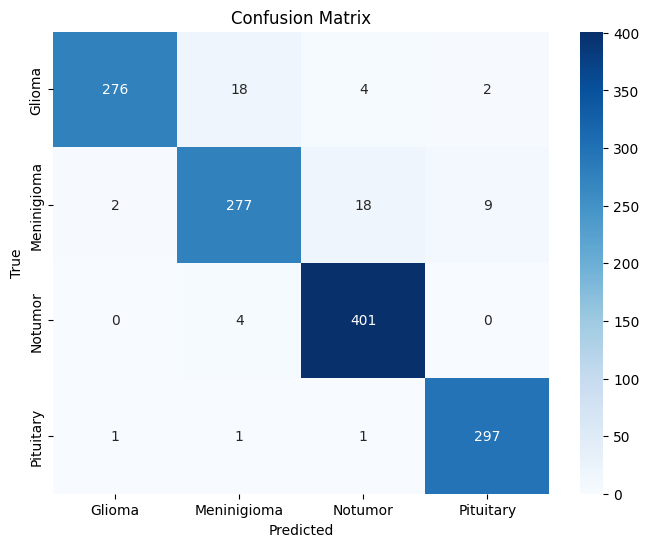

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
model_1.save("SSL_2_40-60.h5")

# SSL 2

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_2_40-60.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/low_confidence"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/very_low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/212 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


  0%|          | 1/212 [00:00<01:15,  2.78it/s]

Tr-me_1169.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1169.jpg to BT100/Training/meningioma/20250331_001551_Tr-me_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0297.jpg to BT100/Training/pituitary/20250331_001551_Tr-pi_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|▏         | 3/212 [00:00<00:30,  6.93it/s]

Tr-me_0243.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0243.jpg to BT100/Training/meningioma/20250331_001551_Tr-me_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1250.jpg -> Class: notumor, Confidence: 0.41
Moved low-confidence image Tr-me_1250.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 5/212 [00:00<00:21,  9.65it/s]

Tr-gl_1164.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1164.jpg to BT100/Training/glioma/20250331_001551_Tr-gl_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0753.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0753.jpg to BT100/Training/pituitary/20250331_001552_Tr-pi_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 7/212 [00:00<00:18, 11.20it/s]

Tr-gl_0359.jpg -> Class: meningioma, Confidence: 0.95
Moving Tr-gl_0359.jpg to BT100/Training/meningioma/20250331_001552_Tr-gl_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0674.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0674.jpg to BT100/Training/glioma/20250331_001552_Tr-gl_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 9/212 [00:00<00:16, 12.45it/s]

Tr-gl_1066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1066.jpg to BT100/Training/glioma/20250331_001552_Tr-gl_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1336.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_1336.jpg to BT100/Training/pituitary/20250331_001552_Tr-me_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 11/212 [00:01<00:15, 13.21it/s]

Tr-pi_1387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1387.jpg to BT100/Training/pituitary/20250331_001552_Tr-pi_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_0435.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0435.jpg to BT100/Training/pituitary/20250331_001552_Tr-pi_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 13/212 [00:01<00:14, 13.96it/s]

Tr-gl_0188.jpg -> Class: meningioma, Confidence: 0.60
Moved low-confidence image Tr-gl_0188.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1242.jpg to BT100/Training/meningioma/20250331_001552_Tr-gl_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 15/212 [00:01<00:13, 14.40it/s]

Tr-me_0368.jpg -> Class: meningioma, Confidence: 0.92
Moving Tr-me_0368.jpg to BT100/Training/meningioma/20250331_001552_Tr-me_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1066.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-me_1066.jpg to BT100/Training/glioma/20250331_001552_Tr-me_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 17/212 [00:01<00:13, 14.86it/s]

Tr-no_0086.jpg -> Class: glioma, Confidence: 0.71
Moved low-confidence image Tr-no_0086.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1137.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1137.jpg to BT100/Training/glioma/20250331_001552_Tr-gl_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 19/212 [00:01<00:13, 13.93it/s]

Tr-gl_0202.jpg -> Class: glioma, Confidence: 0.95
Moving Tr-gl_0202.jpg to BT100/Training/glioma/20250331_001552_Tr-gl_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1332.jpg to BT100/Training/meningioma/20250331_001553_Tr-me_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 21/212 [00:01<00:13, 14.04it/s]

Tr-me_0226.jpg -> Class: notumor, Confidence: 0.88
Moved low-confidence image Tr-me_0226.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0049.jpg -> Class: glioma, Confidence: 0.74
Moved low-confidence image Tr-gl_0049.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 23/212 [00:01<00:13, 14.15it/s]

Tr-me_0109.jpg -> Class: meningioma, Confidence: 0.94
Moving Tr-me_0109.jpg to BT100/Training/meningioma/20250331_001553_Tr-me_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0481.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0481.jpg to BT100/Training/glioma/20250331_001553_Tr-gl_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 25/212 [00:01<00:12, 14.41it/s]

Tr-gl_1214.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1214.jpg to BT100/Training/glioma/20250331_001553_Tr-gl_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0210.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_0210.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 27/212 [00:02<00:12, 14.72it/s]

Tr-me_0802.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0802.jpg to BT100/Training/meningioma/20250331_001553_Tr-me_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1203.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1203.jpg to BT100/Training/glioma/20250331_001553_Tr-gl_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0494.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0494.jpg to BT100/Training/pituitary/20250331_001553_Tr-pi_0494.jpg


 14%|█▎        | 29/212 [00:02<00:12, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0041.jpg -> Class: notumor, Confidence: 0.57
Moved low-confidence image Tr-pi_0041.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▍        | 31/212 [00:02<00:12, 15.01it/s]

Tr-meTr_0008.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0008.jpg to BT100/Training/meningioma/20250331_001553_Tr-meTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0354.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0354.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 33/212 [00:02<00:13, 13.30it/s]

Tr-me_0325.jpg -> Class: notumor, Confidence: 0.57
Moved low-confidence image Tr-me_0325.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1344.jpg -> Class: pituitary, Confidence: 0.94
Moving Tr-pi_1344.jpg to BT100/Training/pituitary/20250331_001554_Tr-pi_1344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 35/212 [00:02<00:14, 12.36it/s]

Tr-gl_0193.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0193.jpg to BT100/Training/glioma/20250331_001554_Tr-gl_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0934.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_0934.jpg to BT100/Training/meningioma/20250331_001554_Tr-me_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 37/212 [00:02<00:13, 12.82it/s]

Tr-pi_0368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0368.jpg to BT100/Training/pituitary/20250331_001554_Tr-pi_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0038.jpg to BT100/Training/glioma/20250331_001554_Tr-gl_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 39/212 [00:03<00:13, 13.19it/s]

Tr-pi_1301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1301.jpg to BT100/Training/pituitary/20250331_001554_Tr-pi_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1218.jpg to BT100/Training/pituitary/20250331_001554_Tr-pi_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 41/212 [00:03<00:12, 13.58it/s]

Tr-me_0545.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-me_0545.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0191.jpg to BT100/Training/notumor/20250331_001554_Tr-me_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 43/212 [00:03<00:11, 14.11it/s]

Tr-me_0271.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_0271.jpg to BT100/Training/meningioma/20250331_001554_Tr-me_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_0974.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0974.jpg to BT100/Training/pituitary/20250331_001554_Tr-pi_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 45/212 [00:03<00:11, 14.44it/s]

Tr-me_0893.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0893.jpg to BT100/Training/meningioma/20250331_001554_Tr-me_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0237.jpg to BT100/Training/glioma/20250331_001554_Tr-gl_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 47/212 [00:03<00:12, 12.98it/s]

Tr-gl_1211.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1211.jpg to BT100/Training/glioma/20250331_001554_Tr-gl_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0261.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0261.jpg to BT100/Training/notumor/20250331_001555_Tr-me_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 49/212 [00:03<00:12, 12.88it/s]

Tr-gl_0249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0249.jpg to BT100/Training/meningioma/20250331_001555_Tr-gl_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0853.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0853.jpg to BT100/Training/meningioma/20250331_001555_Tr-me_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▍       | 51/212 [00:03<00:13, 12.32it/s]

Tr-me_0674.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0674.jpg to BT100/Training/meningioma/20250331_001555_Tr-me_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0894.jpg -> Class: glioma, Confidence: 0.95
Moving Tr-gl_0894.jpg to BT100/Training/glioma/20250331_001555_Tr-gl_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 53/212 [00:04<00:12, 12.94it/s]

Tr-gl_0326.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0326.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0621.jpg to BT100/Training/glioma/20250331_001555_Tr-me_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 55/212 [00:04<00:11, 13.60it/s]

Tr-pi_1420.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1420.jpg to BT100/Training/pituitary/20250331_001555_Tr-pi_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.85
Moved low-confidence image Tr-gl_1015.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 57/212 [00:04<00:11, 12.97it/s]

Tr-gl_0479.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-gl_0479.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0983.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0983.jpg to BT100/Training/pituitary/20250331_001555_Tr-pi_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 59/212 [00:04<00:12, 11.88it/s]

Tr-pi_0032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0032.jpg to BT100/Training/pituitary/20250331_001555_Tr-pi_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1111.jpg -> Class: pituitary, Confidence: 0.97
Moving Tr-pi_1111.jpg to BT100/Training/pituitary/20250331_001556_Tr-pi_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 29%|██▉       | 61/212 [00:04<00:11, 12.63it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 0.83
Moved low-confidence image Tr-pi_1078.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0129.jpg -> Class: pituitary, Confidence: 0.62
Moved low-confidence image Tr-pi_0129.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|██▉       | 63/212 [00:04<00:11, 13.09it/s]

Tr-no_0387.jpg -> Class: notumor, Confidence: 0.84
Moved low-confidence image Tr-no_0387.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0308.jpg to BT100/Training/glioma/20250331_001556_Tr-gl_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0542.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0542.jpg to BT100/Training/pituitary/20250331_001556_Tr-pi_0542.jpg


 31%|███       | 65/212 [00:05<00:10, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1178.jpg to BT100/Training/pituitary/20250331_001556_Tr-pi_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 32%|███▏      | 67/212 [00:05<00:10, 14.14it/s]

Tr-me_1321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1321.jpg to BT100/Training/meningioma/20250331_001556_Tr-me_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0348.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0348.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 69/212 [00:05<00:11, 12.78it/s]

Tr-me_1224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1224.jpg to BT100/Training/meningioma/20250331_001556_Tr-me_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1025.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1025.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0895.jpg -> Class: glioma, Confidence: 1.00

 33%|███▎      | 71/212 [00:05<00:13, 10.32it/s]


Moving Tr-gl_0895.jpg to BT100/Training/glioma/20250331_001556_Tr-gl_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0694.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0694.jpg to BT100/Training/glioma/20250331_001557_Tr-me_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 73/212 [00:05<00:15,  9.01it/s]

Tr-me_0432.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0432.jpg to BT100/Training/meningioma/20250331_001557_Tr-me_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_1256.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1256.jpg to BT100/Training/glioma/20250331_001557_Tr-gl_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▌      | 75/212 [00:06<00:15,  8.91it/s]

Tr-me_0410.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-me_0410.jpg to BT100/Training/glioma/20250331_001557_Tr-me_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1144.jpg to BT100/Training/meningioma/20250331_001557_Tr-me_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▋      | 77/212 [00:06<00:14,  9.27it/s]

Tr-pi_1425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1425.jpg to BT100/Training/pituitary/20250331_001557_Tr-pi_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 78/212 [00:06<00:15,  8.81it/s]

Tr-gl_1240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1240.jpg to BT100/Training/meningioma/20250331_001557_Tr-gl_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 79/212 [00:06<00:15,  8.49it/s]

Tr-me_0906.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0906.jpg to BT100/Training/meningioma/20250331_001557_Tr-me_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 80/212 [00:06<00:16,  8.24it/s]

Tr-gl_0740.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0740.jpg to BT100/Training/glioma/20250331_001558_Tr-gl_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 81/212 [00:06<00:16,  8.11it/s]

Tr-me_0796.jpg -> Class: glioma, Confidence: 0.74
Moved low-confidence image Tr-me_0796.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▊      | 82/212 [00:06<00:15,  8.29it/s]

Tr-gl_1163.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1163.jpg to BT100/Training/glioma/20250331_001558_Tr-gl_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 83/212 [00:07<00:24,  5.35it/s]

Tr-me_0264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0264.jpg to BT100/Training/meningioma/20250331_001558_Tr-me_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0255.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0255.jpg to BT100/Training/meningioma/20250331_001558_Tr-no_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 85/212 [00:07<00:18,  6.84it/s]

Tr-gl_0980.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0980.jpg to BT100/Training/glioma/20250331_001558_Tr-gl_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1140.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1140.jpg to BT100/Training/pituitary/20250331_001558_Tr-pi_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 87/212 [00:07<00:15,  8.00it/s]

Tr-me_0126.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0126.jpg to BT100/Training/meningioma/20250331_001559_Tr-me_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 88/212 [00:07<00:15,  8.18it/s]

Tr-gl_0140.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_0140.jpg to BT100/Training/glioma/20250331_001559_Tr-gl_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 89/212 [00:07<00:15,  8.18it/s]

Tr-me_0646.jpg -> Class: glioma, Confidence: 0.58
Moved low-confidence image Tr-me_0646.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 90/212 [00:08<00:14,  8.32it/s]

Tr-pi_1013.jpg -> Class: glioma, Confidence: 0.93
Moving Tr-pi_1013.jpg to BT100/Training/glioma/20250331_001559_Tr-pi_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 91/212 [00:08<00:14,  8.46it/s]

Tr-pi_0042.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0042.jpg to BT100/Training/pituitary/20250331_001559_Tr-pi_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1298.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1298.jpg to BT100/Training/meningioma/20250331_001559_Tr-gl_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 93/212 [00:08<00:11, 10.19it/s]

Tr-me_1107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1107.jpg to BT100/Training/meningioma/20250331_001559_Tr-me_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0171.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0171.jpg to BT100/Training/meningioma/20250331_001559_Tr-me_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 95/212 [00:08<00:10, 10.88it/s]

Tr-me_1259.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1259.jpg to BT100/Training/meningioma/20250331_001559_Tr-me_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1139.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-gl_1139.jpg to BT100/Training/notumor/20250331_001559_Tr-gl_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 97/212 [00:08<00:09, 11.59it/s]

Tr-pi_1182.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1182.jpg to BT100/Training/pituitary/20250331_001559_Tr-pi_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0887.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0887.jpg to BT100/Training/glioma/20250331_001600_Tr-gl_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 99/212 [00:08<00:09, 11.34it/s]

Tr-pi_0204.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0204.jpg to BT100/Training/pituitary/20250331_001600_Tr-pi_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1017.jpg to BT100/Training/meningioma/20250331_001600_Tr-gl_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 101/212 [00:08<00:09, 11.95it/s]

Tr-gl_1319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1319.jpg to BT100/Training/glioma/20250331_001600_Tr-gl_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1410.jpg to BT100/Training/notumor/20250331_001600_Tr-no_1410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▊     | 103/212 [00:09<00:09, 11.57it/s]

Tr-me_1338.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-me_1338.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1318.jpg to BT100/Training/glioma/20250331_001600_Tr-gl_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████▉     | 105/212 [00:09<00:08, 12.19it/s]

Tr-gl_0187.jpg -> Class: pituitary, Confidence: 0.37
Moved low-confidence image Tr-gl_0187.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0979.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_0979.jpg to BT100/Training/glioma/20250331_001600_Tr-me_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0099.jpg to BT100/Training/glioma/20250331_001600_Tr-gl_0099.jpg


 50%|█████     | 107/212 [00:09<00:08, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0541.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0541.jpg to BT100/Training/meningioma/20250331_001600_Tr-me_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████▏    | 109/212 [00:09<00:09, 10.63it/s]

Tr-me_0084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0084.jpg to BT100/Training/pituitary/20250331_001601_Tr-me_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0059.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-gl_0059.jpg to BT100/Training/pituitary/20250331_001601_Tr-gl_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 111/212 [00:09<00:10, 10.03it/s]

Tr-me_0301.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_0301.jpg to BT100/Training/glioma/20250331_001601_Tr-me_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0977.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0977.jpg to BT100/Training/glioma/20250331_001601_Tr-gl_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 113/212 [00:10<00:10,  9.61it/s]

Tr-me_1269.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1269.jpg to BT100/Training/meningioma/20250331_001601_Tr-me_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0808.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0808.jpg to BT100/Training/pituitary/20250331_001601_Tr-pi_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 115/212 [00:10<00:09, 10.57it/s]

Tr-pi_1090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1090.jpg to BT100/Training/pituitary/20250331_001601_Tr-pi_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0293.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0293.jpg to BT100/Training/notumor/20250331_001601_Tr-no_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 117/212 [00:10<00:09,  9.95it/s]

Tr-me_1314.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1314.jpg to BT100/Training/meningioma/20250331_001601_Tr-me_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0177.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0177.jpg to BT100/Training/meningioma/20250331_001601_Tr-me_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 119/212 [00:10<00:08, 10.94it/s]

Tr-me_0323.jpg -> Class: notumor, Confidence: 0.57
Moved low-confidence image Tr-me_0323.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0087.jpg -> Class: pituitary, Confidence: 0.91
Moving Tr-me_0087.jpg to BT100/Training/pituitary/20250331_001602_Tr-me_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 121/212 [00:10<00:08, 10.23it/s]

Tr-gl_1175.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1175.jpg to BT100/Training/glioma/20250331_001602_Tr-gl_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0962.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0962.jpg to BT100/Training/glioma/20250331_001602_Tr-me_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 123/212 [00:11<00:09,  9.57it/s]

Tr-gl_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0192.jpg to BT100/Training/notumor/20250331_001602_Tr-gl_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0355.jpg to BT100/Training/notumor/20250331_001602_Tr-gl_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 125/212 [00:11<00:08,  9.94it/s]

Tr-gl_0845.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0845.jpg to BT100/Training/glioma/20250331_001602_Tr-gl_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0212.jpg to BT100/Training/meningioma/20250331_001602_Tr-me_0212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1072.jpg to BT100/Training/meningioma/20250331_001602_Tr-me_1072.jpg


 60%|█████▉    | 127/212 [00:11<00:08,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1225.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1225.jpg to BT100/Training/meningioma/20250331_001602_Tr-me_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 129/212 [00:11<00:08, 10.29it/s]

Tr-me_0220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0220.jpg to BT100/Training/meningioma/20250331_001603_Tr-me_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0900.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0900.jpg to BT100/Training/glioma/20250331_001603_Tr-gl_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 131/212 [00:11<00:07, 10.42it/s]

Tr-gl_0045.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-gl_0045.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1198.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1198.jpg to BT100/Training/glioma/20250331_001603_Tr-gl_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 133/212 [00:12<00:07, 10.99it/s]

Tr-gl_1151.jpg -> Class: glioma, Confidence: 0.57
Moved low-confidence image Tr-gl_1151.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0589.jpg to BT100/Training/notumor/20250331_001603_Tr-me_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 135/212 [00:12<00:06, 11.84it/s]

Tr-gl_0888.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-gl_0888.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0673.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0673.jpg to BT100/Training/meningioma/20250331_001603_Tr-me_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1272.jpg -> Class: glioma, Confidence: 0.97

 65%|██████▍   | 137/212 [00:12<00:05, 12.61it/s]


Moving Tr-gl_1272.jpg to BT100/Training/glioma/20250331_001603_Tr-gl_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0342.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0342.jpg to BT100/Training/meningioma/20250331_001603_Tr-me_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 139/212 [00:12<00:06, 11.07it/s]

Tr-me_0910.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0910.jpg to BT100/Training/glioma/20250331_001603_Tr-me_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1193.jpg -> Class: glioma, Confidence: 0.94
Moving Tr-gl_1193.jpg to BT100/Training/glioma/20250331_001603_Tr-gl_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 141/212 [00:12<00:06, 11.18it/s]

Tr-me_0203.jpg -> Class: meningioma, Confidence: 0.70
Moved low-confidence image Tr-me_0203.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1295.jpg to BT100/Training/glioma/20250331_001604_Tr-gl_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 143/212 [00:12<00:05, 11.80it/s]

Tr-me_0784.jpg -> Class: meningioma, Confidence: 0.90
Moving Tr-me_0784.jpg to BT100/Training/meningioma/20250331_001604_Tr-me_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0210.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-no_0210.jpg to BT100/Training/notumor/20250331_001604_Tr-no_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 145/212 [00:13<00:05, 11.47it/s]

Tr-pi_0615.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0615.jpg to BT100/Training/pituitary/20250331_001604_Tr-pi_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0754.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0754.jpg to BT100/Training/pituitary/20250331_001604_Tr-pi_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 147/212 [00:13<00:05, 12.18it/s]

Tr-gl_0517.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0517.jpg to BT100/Training/glioma/20250331_001604_Tr-gl_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0540.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_0540.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 149/212 [00:13<00:05, 11.78it/s]

Tr-me_0024.jpg -> Class: pituitary, Confidence: 0.84
Moved low-confidence image Tr-me_0024.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-meTr_0006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0006.jpg to BT100/Training/meningioma/20250331_001604_Tr-meTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 71%|███████   | 151/212 [00:13<00:05, 11.42it/s]

Tr-gl_1261.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1261.jpg to BT100/Training/glioma/20250331_001604_Tr-gl_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0480.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0480.jpg to BT100/Training/glioma/20250331_001605_Tr-gl_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 153/212 [00:13<00:05, 11.22it/s]

Tr-gl_0358.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0358.jpg to BT100/Training/meningioma/20250331_001605_Tr-gl_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0781.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0781.jpg to BT100/Training/glioma/20250331_001605_Tr-gl_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 155/212 [00:13<00:04, 11.89it/s]

Tr-me_0814.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0814.jpg to BT100/Training/meningioma/20250331_001605_Tr-me_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0238.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0238.jpg to BT100/Training/glioma/20250331_001605_Tr-gl_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 157/212 [00:14<00:05, 10.58it/s]

Tr-pi_1174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1174.jpg to BT100/Training/pituitary/20250331_001605_Tr-pi_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0419.jpg -> Class: glioma, Confidence: 0.90
Moving Tr-gl_0419.jpg to BT100/Training/glioma/20250331_001605_Tr-gl_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 159/212 [00:14<00:04, 11.39it/s]

Tr-pi_0054.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0054.jpg to BT100/Training/pituitary/20250331_001605_Tr-pi_0054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0010.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0010.jpg to BT100/Training/notumor/20250331_001605_Tr-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 161/212 [00:14<00:04, 12.03it/s]

Tr-me_0658.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0658.jpg to BT100/Training/meningioma/20250331_001605_Tr-me_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0360.jpg -> Class: glioma, Confidence: 0.68
Moved low-confidence image Tr-gl_0360.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 163/212 [00:14<00:04, 11.85it/s]

Tr-pi_0033.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0033.jpg to BT100/Training/pituitary/20250331_001605_Tr-pi_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0194.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0194.jpg to BT100/Training/notumor/20250331_001606_Tr-me_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 165/212 [00:14<00:03, 12.36it/s]

Tr-me_1071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1071.jpg to BT100/Training/meningioma/20250331_001606_Tr-me_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1225.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1225.jpg to BT100/Training/glioma/20250331_001606_Tr-gl_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 167/212 [00:14<00:03, 12.70it/s]

Tr-gl_1215.jpg -> Class: glioma, Confidence: 0.39
Moved low-confidence image Tr-gl_1215.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1241.jpg -> Class: meningioma, Confidence: 0.57
Moved low-confidence image Tr-gl_1241.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 169/212 [00:15<00:03, 10.94it/s]

Tr-me_0326.jpg -> Class: notumor, Confidence: 0.50
Moved low-confidence image Tr-me_0326.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0340.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-gl_0340.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 171/212 [00:15<00:03, 10.96it/s]

Tr-me_0270.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0270.jpg to BT100/Training/meningioma/20250331_001606_Tr-me_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1145.jpg to BT100/Training/glioma/20250331_001606_Tr-me_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 173/212 [00:15<00:03, 10.90it/s]

Tr-gl_0223.jpg -> Class: pituitary, Confidence: 0.93
Moving Tr-gl_0223.jpg to BT100/Training/pituitary/20250331_001606_Tr-gl_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1180.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1180.jpg to BT100/Training/pituitary/20250331_001606_Tr-pi_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 175/212 [00:15<00:03, 11.59it/s]

Tr-pi_0730.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0730.jpg to BT100/Training/notumor/20250331_001607_Tr-pi_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1106.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1106.jpg to BT100/Training/glioma/20250331_001607_Tr-gl_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 177/212 [00:15<00:03, 11.43it/s]

Tr-me_0208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0208.jpg to BT100/Training/meningioma/20250331_001607_Tr-me_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0968.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0968.jpg to BT100/Training/glioma/20250331_001607_Tr-gl_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 179/212 [00:16<00:02, 11.24it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 0.96
Moving Tr-me_0613.jpg to BT100/Training/meningioma/20250331_001607_Tr-me_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0343.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0343.jpg to BT100/Training/meningioma/20250331_001607_Tr-me_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 181/212 [00:16<00:02, 11.74it/s]

Tr-gl_0065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0065.jpg to BT100/Training/glioma/20250331_001607_Tr-gl_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1170.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-gl_1170.jpg to BT100/Training/glioma/20250331_001607_Tr-gl_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▋ | 183/212 [00:16<00:02, 11.54it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0329.jpg to BT100/Training/meningioma/20250331_001607_Tr-me_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0800.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_0800.jpg to BT100/Training/meningioma/20250331_001607_Tr-me_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 185/212 [00:16<00:02, 11.07it/s]

Tr-gl_1293.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-gl_1293.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0262.jpg to BT100/Training/pituitary/20250331_001607_Tr-me_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 187/212 [00:16<00:02, 11.06it/s]

Tr-gl_0996.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0996.jpg to BT100/Training/glioma/20250331_001608_Tr-gl_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1181.jpg to BT100/Training/pituitary/20250331_001608_Tr-pi_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 89%|████████▉ | 189/212 [00:16<00:01, 11.91it/s]

Tr-me_0859.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0859.jpg to BT100/Training/meningioma/20250331_001608_Tr-me_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1229.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1229.jpg to BT100/Training/meningioma/20250331_001608_Tr-me_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 191/212 [00:17<00:01, 11.57it/s]

Tr-pi_0995.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0995.jpg to BT100/Training/pituitary/20250331_001608_Tr-pi_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-gl_0342.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250331_001608_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 193/212 [00:17<00:01,  9.62it/s]

Tr-pi_0532.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0532.jpg to BT100/Training/pituitary/20250331_001608_Tr-pi_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-pi_0211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0211.jpg to BT100/Training/pituitary/20250331_001608_Tr-pi_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 195/212 [00:17<00:01,  9.05it/s]

Tr-me_0240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0240.jpg to BT100/Training/meningioma/20250331_001608_Tr-me_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0984.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0984.jpg to BT100/Training/glioma/20250331_001609_Tr-gl_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 197/212 [00:17<00:01,  9.41it/s]

Tr-no_0256.jpg -> Class: notumor, Confidence: 0.81
Moved low-confidence image Tr-no_0256.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 198/212 [00:17<00:01,  8.98it/s]

Tr-pi_1310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1310.jpg to BT100/Training/pituitary/20250331_001609_Tr-pi_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 199/212 [00:18<00:01,  8.64it/s]

Tr-gl_0079.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0079.jpg to BT100/Training/notumor/20250331_001609_Tr-gl_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 200/212 [00:18<00:01,  8.65it/s]

Tr-me_1125.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-me_1125.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 201/212 [00:18<00:01,  8.76it/s]

Tr-gl_0357.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0357.jpg to BT100/Training/glioma/20250331_001609_Tr-gl_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▌| 202/212 [00:18<00:01,  8.81it/s]

Tr-gl_0362.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0362.jpg to BT100/Training/meningioma/20250331_001609_Tr-gl_0362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 203/212 [00:18<00:01,  8.03it/s]

Tr-me_0294.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0294.jpg to BT100/Training/meningioma/20250331_001609_Tr-me_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▌| 204/212 [00:18<00:00,  8.18it/s]

Tr-pi_0104.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0104.jpg to BT100/Training/pituitary/20250331_001610_Tr-pi_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 205/212 [00:18<00:00,  7.82it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1050.jpg to BT100/Training/meningioma/20250331_001610_Tr-me_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 206/212 [00:18<00:00,  7.57it/s]

Tr-me_1291.jpg -> Class: meningioma, Confidence: 0.96
Moving Tr-me_1291.jpg to BT100/Training/meningioma/20250331_001610_Tr-me_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0752.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0752.jpg to BT100/Training/pituitary/20250331_001610_Tr-pi_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 208/212 [00:19<00:00,  8.98it/s]

Tr-pi_1401.jpg -> Class: pituitary, Confidence: 0.90
Moving Tr-pi_1401.jpg to BT100/Training/pituitary/20250331_001610_Tr-pi_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0065.jpg -> Class: notumor, Confidence: 0.44
Moved low-confidence image Tr-no_0065.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▉| 210/212 [00:19<00:00, 10.28it/s]

Tr-pi_1050.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-pi_1050.jpg to BT100/Training/notumor/20250331_001610_Tr-pi_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0041.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0041.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|██████████| 212/212 [00:19<00:00, 10.92it/s]

Tr-gl_0841.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0841.jpg to BT100/Training/meningioma/20250331_001610_Tr-gl_0841.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [38]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/very_low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/very_low_confidence': 39


39

In [39]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")

Total number of files in the Training folder: 5673


In [40]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

In [41]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [42]:

# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5673

Testing
Number of Labels: 1311


In [43]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)


In [44]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [45]:
model_2 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

In [47]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)


In [48]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_2.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_2 = model_2.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.4861 - loss: 1.1021 - val_accuracy: 0.6667 - val_loss: 0.8280 - learning_rate: 0.0010
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.7981 - loss: 0.5544 - val_accuracy: 0.8276 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8666 - loss: 0.3589 - val_accuracy: 0.8581 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.9118 - loss: 0.2426 - val_accuracy: 0.9031 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9396 - loss: 0.1753 - val_accuracy: 0.9184 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9477 - loss: 0.1496 - val_accuracy: 0.9123 - val_loss: 0.3432 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9593

In [49]:
test_loss, test_acc = model_2.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9556 - loss: 0.6058
Test accuracy: 95.3471%


In [50]:
from sklearn.metrics import classification_report

y_pred = model_2.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       300
           1       0.94      0.91      0.92       306
           2       0.94      0.99      0.97       405
           3       0.96      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



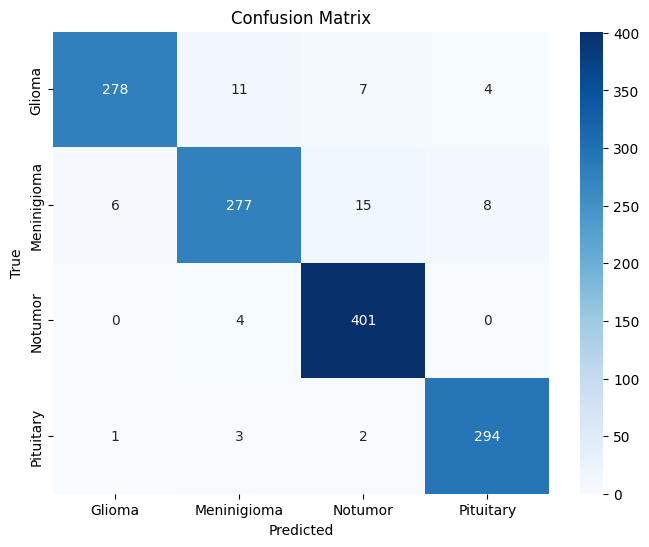

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
